In [1]:
# !pip2 install pypolyagamma

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import plotnine as gg

import warnings
warnings.filterwarnings('ignore')

#import importlib
#importlib.reload(logistic.agent_logistic)
#reload(sys.modules['logistic.agent_logistic'])

In [2]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    env = FixedLogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(-3,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [3]:
num_articles = 100
dim = 10
var = 1.0
theta_mean = 0
theta_std = 1

time_limit= 0.1

verbosity=1

In [4]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda hypers: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda hypers: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = hypers[1],
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda hypers: SAGATS(num_articles, dim, [0]*(dim+1), cov=None, 
                                          step_size=lambda t: hypers[0]/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = hypers[1],
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)

In [5]:
make_best_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_best_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

make_best_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038]
Experiment: Step 0
 Laplace sample: array([ 0.31563495, -2.02220122, -0.30620401,  0.82797464,  0.23009474,
        0.76201118, -0.22232814, -0.20075807,  0.18656139,  0.41005165])
 Sample: array([ 0.19829972,  0.11900865, -0.67066229,  0.37756379,  0.12182127,
        1.12948391,  1.19891788,  0.18515642, -0.37528495, -0.63873041])
 Sample: array([-0.08289989, -0.5126661 ,  0.22359833, -0.89679948, -1.51740976,
       -0.39399187, -0.32868286,  0.30709575, -0.04813158,  1.82496237])
 Steps taken: 984
 Sample: array([-0.46891391,  0.14620236,  0.74111607,  0.77945599,  0.29831589,
        0.52585753, -1.09998729,  0.63233748, -0.4564206 , -0.01646572])
 Accept proportion: 0.406780
 Steps taken: 354
 Sample: array([-0.18488831,  0.0515337 ,  0.09694096,  0.73267984, -1.27060434,
        0.97453324,  0.6677033 , -0.63859789,  0.0990227 ,  0.29248058])
 Steps tak

 Sample: array([ 0.18148089, -2.25957874, -0.11826894, -0.06615724,  1.8580933 ,
       -0.80875668,  1.27395024,  2.09497124, -1.64098176, -1.11940309])
 Steps taken: 1062
 Sample: array([-0.51813509,  0.13881058,  0.96600753, -1.66992603, -0.79839977,
       -0.04771807, -0.21585471,  0.19716303, -0.37293873,  0.52342721])
 Steps taken: 975
Experiment: Step 8
 Laplace sample: array([ 0.56414766, -1.7724438 ,  0.69848351,  0.97348046,  1.67917661,
        0.61579619, -0.26683995, -1.2800438 , -1.71013897,  1.29136606])
 Steps taken: 426
 Sample: array([-2.70973202e-01,  4.14916942e-01, -8.40145497e-01, -3.02257300e-01,
        3.49864507e-01,  1.14780403e-03,  9.70151260e-01, -2.01705829e+00,
       -1.00229258e-01, -1.23099038e+00])
 Sample: array([ 0.59015165,  0.20749721, -1.2298927 ,  0.72522338,  0.83392881,
       -2.07101578,  0.77348661, -0.7995901 , -0.65737412, -0.11486623])
 Steps taken: 1306
 Sample: array([ 0.47188105, -0.34482374,  0.08363501, -1.65879324, -0.02057157,
 

 Sample: array([-0.21190052,  2.61570309, -0.81497967,  1.13335513, -0.0269447 ,
        0.08494108, -1.97635042, -1.16149296,  0.17228105, -1.16314904])
 Steps taken: 1242
 Sample: array([ 1.27743524, -0.62185653, -0.526391  , -0.99815234, -0.23291153,
        0.72370698,  0.69564753, -0.76538464, -0.02176659, -0.37577425])
 Accept proportion: 0.524096
 Steps taken: 332
 Sample: array([ 0.61074731, -0.88225771, -0.32341699, -0.29504671,  0.17001115,
       -0.96892595,  1.3634917 , -1.38852819,  0.77481955, -0.2054869 ])
 Steps taken: 1020
 Sample: array([ 0.18705548,  0.80422938,  0.41783974, -1.47246915, -0.00327819,
       -0.66344872, -0.26004184, -0.28659431,  1.24561692, -0.92975123])
 Steps taken: 924
Experiment: Step 16
 Laplace sample: array([-0.49958989,  1.69188045, -0.350146  , -1.8543694 ,  2.66419987,
       -2.39073466, -2.01429076,  0.24963073,  1.08279337, -3.1588006 ])
 Steps taken: 415
 Sample: array([-0.66001179,  0.47908387, -1.06037866, -2.19624103,  0.03716477,


 Sample: array([-0.27158088,  0.20251823, -0.25208318, -0.19507854,  0.50107255,
       -0.70903388,  0.76353393, -1.41437722,  0.22633792, -0.47505846])
 Steps taken: 1219
 Sample: array([ 0.5044192 , -0.75763464,  0.42526139, -0.20829674, -0.09806873,
       -0.63646738,  1.54633743, -0.92021302, -0.46191789, -0.04839368])
 Accept proportion: 0.546296
 Steps taken: 324
 Sample: array([ 0.69372721,  0.42831615,  0.0672346 , -2.10748334,  1.11407037,
       -0.23777092, -1.15852439,  0.58420966,  0.55717058, -1.66461057])
 Steps taken: 975
 Sample: array([ 1.45410019,  0.04023144, -1.25140408, -1.61042697,  0.25049248,
       -1.41454692,  2.02610622,  0.56795965, -1.78912928,  0.66080104])
 Steps taken: 868
Experiment: Step 24
 Laplace sample: array([ 1.37960837,  0.76023749, -1.63339908, -0.53469857,  2.96784946,
       -0.58111151, -2.21343477, -0.38661953, -0.59485014, -2.11435471])
 Steps taken: 400
 Sample: array([ 0.35779895, -0.78115206, -0.64743592, -0.65865589,  0.32832921,
 

 Sample: array([ 1.06626009, -0.94119927, -0.12629946,  0.59449004, -0.2901222 ,
       -0.29007442,  1.00326886, -1.32209317,  0.38539741, -0.4915266 ])
 Steps taken: 1180
 Sample: array([-0.53920441, -1.70500917,  0.3183453 , -0.01053387,  0.60420553,
       -0.49050476,  0.60432309, -0.28689626,  0.52974475,  0.3529593 ])
 Accept proportion: 0.563863
 Steps taken: 321
 Sample: array([-1.02256284, -1.77310678,  0.26977706, -0.76361159,  2.41034105,
       -1.26377518,  1.53631315, -0.20440145, -0.23894937, -0.70056909])
 Steps taken: 941
 Sample: array([-0.85764113,  0.74550646, -0.79461712, -0.11401106, -0.26816912,
       -0.55417602, -0.10851642, -1.09491489,  0.04857006,  1.62699159])
 Steps taken: 849
Experiment: Step 32
 Laplace sample: array([ 0.42789526, -1.30860339,  0.19350364, -3.21476626,  0.81121386,
       -2.12861459,  0.93692817, -0.68517711,  3.97662839, -1.59564475])
 Steps taken: 396
 Sample: array([ 1.93248527,  0.01228248, -1.53386967, -0.64718262, -0.44192414,
 

 Sample: array([ 0.40079832,  0.0871893 , -0.55832921,  0.73354636, -0.244412  ,
       -1.23934141,  0.94382928,  0.07336512,  0.05937521, -0.8980948 ])
 Steps taken: 1140
 Sample: array([-0.48174258,  0.00587452, -0.70663023, -0.59396381, -0.26231279,
       -1.69041502,  1.46403653, -0.63324223,  0.67765981,  0.3666409 ])
 Accept proportion: 0.454259
 Steps taken: 317
 Sample: array([ 1.15225185, -1.7366776 ,  0.37523207, -0.19736626,  1.80752362,
       -1.8064724 ,  0.74325866, -1.11357148,  0.25797278, -0.47276195])
 Steps taken: 791
 Sample: array([ 1.74235745, -0.66525513, -0.37298868, -0.7888227 ,  0.12895869,
        0.37134906, -0.24151218, -0.37660281, -0.64927649, -0.65537551])
 Steps taken: 637
Experiment: Step 40
 Laplace sample: array([11.73996253, -5.12634744,  1.57304409, -0.9308784 ,  1.58863511,
       -1.18336692, -0.42849848, -8.7589111 , -0.2773409 ,  4.60533426])
 Steps taken: 382
 Sample: array([ 0.8691507 ,  0.05531122, -1.14134578, -1.80949368,  0.22577713,
 

 Sample: array([ 0.23250948, -0.18108339,  0.54343377,  0.5050354 , -0.05361676,
       -1.00887011,  1.38645079, -0.76741551, -0.36755609, -1.06470994])
 Steps taken: 1106
 Sample: array([ 0.07903805, -0.81791097, -0.6464894 , -1.01338138, -0.00295347,
       -0.60631533,  2.22970413, -0.06684092, -0.30897473,  0.45685337])
 Accept proportion: 0.555195
 Steps taken: 308
 Sample: array([-0.73136132,  0.0445254 ,  1.34844884, -0.21502707, -0.71588778,
       -2.68567609,  0.57364904,  1.38769762,  0.52345258, -1.23364126])
 Steps taken: 806
 Sample: array([ 2.82610646, -0.35980379, -0.35155166, -2.08282667,  0.3938251 ,
       -0.47049508, -0.38028012, -0.58477358, -0.60487636,  0.00595455])
 Steps taken: 650
Experiment: Step 48
 Laplace sample: array([10.48251194, -5.4510377 ,  1.15415676, -1.3720904 ,  0.76393691,
       -0.23318892, -1.0208155 , -8.28037942,  2.17639369,  3.16625427])
 Steps taken: 376
 Sample: array([-0.72353298, -0.43732142, -0.06040481, -0.73470872,  0.91574679,
 

 Sample: array([ 1.4829926 ,  0.80279081, -0.32241335,  0.24891394, -0.92813872,
       -1.38832003,  0.62805262, -1.57118458,  0.76766716, -0.47275328])
 Steps taken: 1074
 Sample: array([-0.11200801, -0.15573089,  0.13920772, -1.12872753, -0.56596948,
       -1.52616134,  1.69336927, -0.0338665 ,  0.32370918,  0.48864677])
 Accept proportion: 0.565789
 Steps taken: 304
 Sample: array([-0.76652374, -1.41744914,  0.48828014, -0.16851274,  0.40355104,
       -0.92197641,  0.78888795,  0.06695967,  0.86650411, -0.0573931 ])
 Steps taken: 801
 Sample: array([ 0.75522717, -0.26552465, -0.7630775 , -0.80255722, -0.55465703,
        0.30664811,  0.93081604, -0.52109788, -0.29949773,  0.34784823])
 Steps taken: 647
Experiment: Step 56
 Laplace sample: array([11.87535306, -6.84654591,  1.09024227, -1.50087758,  2.53516262,
       -1.23376917, -1.41209195, -9.34816403,  2.49617543,  3.91309027])
 Steps taken: 366
 Sample: array([ 0.02309455, -1.31569207, -0.20959415,  0.20773294,  0.93478793,
 

 Sample: array([ 2.06921837, -0.73480985, -0.00860126,  0.28034184, -0.7119764 ,
       -0.72149172,  0.63298922, -0.40324045, -0.38395564, -0.94319091])
 Steps taken: 1034
 Sample: array([-0.43335296, -0.33889359, -0.3453133 , -0.66438737, -0.56806243,
       -0.34995802,  1.95802693, -0.38267066,  0.25783719, -0.15652852])
 Accept proportion: 0.567010
 Steps taken: 291
 Sample: array([-1.06013655, -1.12271294, -0.6005442 ,  0.5899157 ,  1.30963208,
       -0.5098046 ,  0.96891192, -0.54190604, -0.41055353, -0.13146114])
 Steps taken: 789
 Sample: array([ 0.5353905 , -0.17483424, -0.44328365, -0.10809196,  0.85343044,
       -0.98098319,  0.3057179 , -0.40498547,  0.02295805, -0.34457828])
 Steps taken: 637
Experiment: Step 64
 Laplace sample: array([11.08399393, -8.239441  , -0.13389011, -1.84254985,  0.9659165 ,
        1.05238638, -1.87684651, -6.5225921 ,  2.57108438,  2.35119461])
 Steps taken: 260
 Sample: array([ 0.34810535, -0.02925962, -1.43424269, -0.29511982,  0.24853329,
 

 Sample: array([ 1.61533036, -0.10391348, -0.30889144, -0.16635068, -0.54371318,
       -0.32652483,  1.09052194, -0.9720507 , -0.30566228, -0.46154355])
 Steps taken: 989
 Sample: array([-0.07210245, -0.32164489,  0.07023505, -0.97713561,  0.63325297,
       -1.2600683 ,  0.87428853,  0.15362538, -0.1492305 ,  0.09886624])
 Accept proportion: 0.575342
 Steps taken: 292
 Sample: array([-0.2850565 , -0.28723525, -0.40685999, -0.42228488,  0.39157296,
       -1.16960674,  1.63853648, -1.03577006,  0.5428844 ,  0.2992928 ])
 Steps taken: 821
 Sample: array([ 1.02001172, -0.23661061, -0.65600538, -0.08746372,  0.23620552,
       -0.71096624,  0.5025166 , -0.43856465, -0.20471401, -0.00302028])
 Steps taken: 655
Experiment: Step 72
 Laplace sample: array([12.00881432, -6.80828891,  1.07793374, -1.19724084, -0.50197408,
       -0.69629572, -2.1583821 , -8.40842323,  2.9557701 ,  3.6807029 ])
 Steps taken: 351
 Sample: array([ 0.15574626, -0.50391533, -0.76149829, -0.59219036,  1.29182081,
  

 Sample: array([-1.47704312, -0.90580341,  0.30528342,  0.57330101,  0.87425082,
       -1.02453963,  1.53264447, -1.77808643,  1.05413223, -1.02390451])
 Steps taken: 959
 Sample: array([ 1.20846617e-03, -1.14066707e-01, -7.31029418e-02, -5.86581273e-01,
       -1.54965303e-01, -8.53381565e-01,  1.40594547e+00, -2.54885400e-01,
        1.07703243e-01, -1.93236047e-01])
 Accept proportion: 0.525952
 Steps taken: 289
 Sample: array([ 0.24516062, -0.84062907,  0.39391047,  0.12633648,  1.35852999,
       -1.41573891,  0.02147942, -0.42471649, -0.53202481, -0.01513819])
 Steps taken: 829
 Sample: array([ 0.89839346, -0.79290476, -0.54333792, -0.76664476,  0.84385544,
       -1.23065575,  0.8077349 ,  0.24284174, -0.26867167,  0.23400533])
 Steps taken: 667
Experiment: Step 80
 Laplace sample: array([12.31160577, -7.28955782,  2.18087602, -1.0710624 ,  2.31555163,
       -0.82758102, -0.51260682, -7.93187151,  0.67730817,  2.56625047])
 Steps taken: 346
 Sample: array([ 0.01765779, -1.1997

 Sample: array([ 1.03847798,  0.06881129, -0.14203734,  0.71267096, -0.32368314,
       -0.28437887,  0.19684794, -0.83411877,  0.20910485, -1.25980415])
 Steps taken: 920
 Sample: array([-0.23541743, -0.52114666, -0.05855585, -1.17635011, -0.28888392,
       -0.40662329,  1.71625035,  0.19282831,  0.15427904, -0.37160332])
 Accept proportion: 0.624088
 Steps taken: 274
 Sample: array([-0.19482765, -2.99159414,  0.70050194, -1.59505783,  1.51876299,
       -1.07352807,  0.66548261,  0.94483853, -0.78296189,  0.09240735])
 Steps taken: 811
 Sample: array([ 1.3184042 , -0.81572441, -0.64367634, -0.26263011,  0.15899103,
       -1.01956333,  0.50785094, -0.65305886,  0.77307132, -0.06191115])
 Steps taken: 664
Experiment: Step 88
 Laplace sample: array([12.46499379, -7.33859877,  1.87588437, -1.71878667,  2.23478892,
       -2.28565091, -2.1974145 , -7.82287121,  2.71159655,  3.18077282])
 Steps taken: 338
 Sample: array([ 1.11300206, -0.01100606, -0.1876878 ,  0.05091809,  0.76652347,
  

 Sample: array([ 0.45057388, -0.58953928, -0.57725072,  1.03710666,  0.59616295,
       -0.88876672,  1.43924851, -0.79254272, -0.22084065, -1.33400923])
 Steps taken: 884
 Sample: array([ 0.12378476, -0.58663421, -0.40209403, -1.14282965, -0.11993491,
       -1.34160283,  1.58799912,  0.01518456,  0.99351164, -0.14301507])
 Accept proportion: 0.629630
 Steps taken: 270
 Sample: array([-0.41266072, -0.23426495,  0.02866017, -0.95947221,  0.81316921,
       -1.02377073,  1.49678019, -0.80507313,  0.95492791, -0.84232117])
 Steps taken: 822
 Sample: array([ 1.10462645, -0.31771943, -1.33492499, -0.09916753, -0.57860862,
       -0.37735662,  0.7111272 ,  0.24114433, -0.02092837, -0.16411518])
 Steps taken: 661
Experiment: Step 96
 Laplace sample: array([12.83936096, -7.35579686,  1.07979962, -1.85431865,  0.80126077,
       -1.54641918, -1.43258887, -8.97357888,  2.16049763,  4.42359844])
 Steps taken: 330
 Sample: array([ 1.54216035,  0.28667089, -1.03210107, -1.17860695,  0.49552438,
  

 Sample: array([ 1.40930902,  0.06576778, -0.23322706,  0.39286289, -0.59224014,
       -1.21950944,  1.08797818, -1.2445698 , -0.9487334 ,  0.59008514])
 Steps taken: 843
 Sample: array([ 0.21819847, -0.57652378,  0.01222819, -0.90413664, -0.13276905,
       -1.3871886 ,  2.06034917, -1.11189138,  0.83704927,  0.07175504])
 Accept proportion: 0.637736
 Steps taken: 265
 Sample: array([-0.77535863, -0.70471637,  0.37758727, -1.07893797,  1.13636021,
       -0.58357128,  0.13639802,  0.13779098,  0.34358979,  0.24914984])
 Steps taken: 834
 Sample: array([ 1.85082967,  0.23395168, -1.56762554, -1.31437396,  0.30992393,
       -2.3287275 ,  1.43303129,  0.3815169 ,  0.48747581, -0.26412939])
 Steps taken: 678
Experiment: Step 104
 Laplace sample: array([10.3365363 , -9.00887098,  3.06638727, -1.418892  ,  1.6071029 ,
       -1.75940422, -2.08502404, -8.03854354,  3.52960197,  2.97702275])
 Steps taken: 328
 Sample: array([ 0.20688635, -1.1007798 ,  0.09858479,  0.07484704,  1.18673319,
 

 Sample: array([ 0.23201236, -0.01668294, -1.09247216, -0.29454676, -0.56406676,
       -0.19080791,  2.49495494, -1.65647777, -0.27861725,  0.32973074])
 Steps taken: 804
 Sample: array([-0.24492163, -0.38142486, -0.55531757, -1.64707682,  0.07189585,
       -1.14488819,  1.32634433,  0.63006273, -0.29787616,  0.88080482])
 Accept proportion: 0.632184
 Steps taken: 261
 Sample: array([ 0.25330149, -1.37777316, -0.51660406, -0.72515647, -0.06940732,
       -1.59933545,  1.61540886,  1.16734347, -1.26597394,  0.96333273])
 Steps taken: 828
 Sample: array([ 0.86035701, -0.59680081, -0.80533683, -0.45460046,  0.22433464,
       -0.54629524,  0.69199005, -0.44672201,  0.323542  , -0.16678056])
 Steps taken: 683
Experiment: Step 112
 Laplace sample: array([11.13196451, -6.36892693,  0.17328684, -1.35788513,  2.15846782,
       -0.24580491, -0.16203638, -9.63778352,  1.76003669,  4.01773213])
 Steps taken: 323
 Sample: array([ 0.2954416 , -0.98859784, -0.52846225,  0.26922812,  0.87785224,
 

 Sample: array([ 1.39997098,  0.23522884, -1.07098791,  0.00341513, -0.35002494,
       -0.76215087,  1.12504697, -0.90149386, -0.463099  , -0.22400865])
 Steps taken: 767
 Sample: array([ 0.06095509, -0.47192219, -0.42413552, -1.46201925, -0.59890969,
       -0.44540587,  2.45764139,  0.00530431,  0.22607806, -0.19642125])
 Accept proportion: 0.643678
 Steps taken: 261
 Sample: array([-0.33531644, -2.45864276, -0.48986821, -0.0522782 ,  1.04058951,
       -0.98287343,  0.35808753,  1.33676258, -0.4485538 ,  0.03042689])
 Steps taken: 854
 Sample: array([ 1.92213032, -0.94492446, -0.2884562 , -0.55635279,  0.38751429,
       -1.51556028,  0.54868706, -0.58866869,  0.14792161,  0.02665481])
 Steps taken: 700
Experiment: Step 120
 Laplace sample: array([10.78470551, -6.46633449,  1.35099498, -0.88739683,  1.82935626,
       -1.140019  ,  0.76094803, -9.18352321,  1.19968855,  3.06273922])
 Steps taken: 317
 Sample: array([-0.39344187, -0.36365217, -0.79658741, -0.45069957,  0.58720268,
 

 Sample: array([ 1.73199047,  0.06832641, -0.52473555,  0.14762374, -0.98378012,
       -0.27837957,  1.30878182, -1.61350774, -0.41019696, -0.3039054 ])
 Steps taken: 725
 Sample: array([ 0.34452093, -0.2609408 , -0.11674204, -0.5072279 ,  0.12853491,
       -1.18909327,  1.75844874, -0.46747489, -0.49770424, -0.20889681])
 Accept proportion: 0.668067
 Steps taken: 238
 Sample: array([-0.11992226, -2.16636563, -1.23863485, -0.86642892,  1.25742927,
        0.24599015,  1.34787695, -0.2855769 , -1.22839615,  0.45352366])
 Steps taken: 810
 Sample: array([ 1.03322220e+00,  1.02697993e-01, -6.49297812e-01, -8.26434373e-01,
       -6.97315868e-04, -1.73943087e+00,  7.93754545e-01, -1.46886473e+00,
        2.19899514e+00, -3.82887470e-01])
 Steps taken: 651
Experiment: Step 128
 Laplace sample: array([11.25186677, -7.04842275,  1.96217278, -2.18841863, -0.36356975,
       -0.74119238, -0.59115048, -8.18479955,  1.12867809,  4.27770342])
 Steps taken: 301
 Sample: array([-0.62079397, -1.178

 Sample: array([ 2.11020815,  0.41575063, -0.3802683 ,  0.12796231, -0.31978985,
       -0.47726846,  1.12284814, -2.14242078, -0.62977613, -0.9356315 ])
 Steps taken: 703
 Sample: array([ 0.00888084, -0.06859764, -0.28551793, -0.77232836, -0.64120601,
       -1.21268586,  1.64354998, -0.30344218,  0.731694  , -0.07444855])
 Accept proportion: 0.676856
 Steps taken: 229
 Sample: array([-0.46758575,  0.17579521, -1.08519574, -0.6464385 ,  1.33192492,
       -0.07258966,  0.01598912, -0.73458206,  0.40267445, -0.15525268])
 Steps taken: 832
 Sample: array([ 0.73890987, -0.2443723 , -0.60489272, -0.79160141, -0.29728134,
       -0.62657524,  0.64042106, -0.50605575,  0.85440147, -0.17394146])
 Steps taken: 671
Experiment: Step 136
 Laplace sample: array([10.18195526, -4.08571411,  2.83496633, -0.14439866, -1.19329341,
       -1.69088999, -0.83828979, -7.91087964,  1.27227982,  2.24616818])
 Steps taken: 305
 Sample: array([ 0.21481456,  0.51155239, -1.01996104, -0.77702839,  0.5452599 ,
 

 Sample: array([ 0.09365528, -0.12535772,  0.19276536,  0.39969615, -0.57105398,
       -0.04975642,  1.51104286, -0.32170994, -0.55137906, -1.26676525])
 Steps taken: 670
 Sample: array([ 0.48868177,  0.04258474, -0.15499554, -0.76558496, -0.60256507,
       -1.98102846,  1.61589063,  0.26114791, -0.33668261,  0.07005283])
 Accept proportion: 0.707763
 Steps taken: 219
 Sample: array([-1.5924431 ,  0.35048044, -0.45498412, -0.30676537, -0.2742765 ,
       -0.34078597,  0.94667375, -1.20903028,  0.39587   ,  0.91814252])
 Steps taken: 831
 Sample: array([ 1.172705  , -0.24033509, -0.73516425, -1.12320474,  0.17618454,
       -1.36590866,  0.97373645, -0.51270824,  1.08545424, -0.05994206])
 Steps taken: 665
Experiment: Step 144
 Laplace sample: array([10.80301828, -6.24862202,  0.90988931, -1.78924705,  1.46157986,
       -0.74814639, -0.41299689, -7.4636332 ,  2.0070151 ,  2.45412615])
 Steps taken: 299
 Sample: array([-0.33886858, -0.42253589, -0.63928277,  0.61196186,  0.83695968,
 

 Sample: array([ 1.92239493, -0.6071114 , -0.09345958, -0.44797823,  0.68131181,
       -1.5217327 ,  1.35827955, -0.97702103, -0.73012069, -0.47586184])
 Steps taken: 644
 Sample: array([ 0.19722129, -0.46812462, -0.20360775, -0.57318631,  0.19583225,
       -1.05954813,  1.15536034, -0.99873535,  0.44542943,  0.16299244])
 Accept proportion: 0.648402
 Steps taken: 219
 Sample: array([-0.54260528, -0.36042628, -0.57151669, -0.49088236,  1.28663912,
       -1.11110936,  0.76807589, -0.3705912 , -0.13798122, -0.41508281])
 Steps taken: 846
 Sample: array([ 0.86029516, -0.3797352 , -1.05988655, -0.98056655,  0.32221951,
       -1.3042301 ,  1.64947578,  0.18346402,  0.19213767, -0.34360247])
 Steps taken: 683
Experiment: Step 152
 Laplace sample: array([11.01806745, -7.10225948,  0.63468148, -1.31432173,  1.27316477,
       -0.37867278, -0.23005983, -8.21197168,  1.38803483,  3.45699754])
 Steps taken: 295
 Sample: array([-1.46620659, -1.07254283,  0.13717827, -0.34662639,  1.27502583,
 

 Sample: array([ 1.10963242,  0.58747323, -0.52016015,  0.52875178, -0.29365729,
       -0.24063592,  0.98180117, -1.32415406, -0.44490406, -1.06662915])
 Steps taken: 610
 Sample: array([ 0.28153744, -0.35568341, -0.62493618, -1.2603264 ,  0.46058401,
       -1.76151628,  1.40064509, -0.16047552,  0.65732185,  0.19724573])
 Accept proportion: 0.678049
 Steps taken: 205
 Sample: array([-0.00396114, -0.3488244 , -0.11490586, -0.180895  ,  0.44750656,
       -0.39769647,  0.69117687, -1.42064749,  1.41032731, -1.55288521])
 Steps taken: 821
 Sample: array([ 0.71811937, -0.48229724, -1.22032255, -0.42642552, -0.00642168,
       -0.00407078,  0.79918731,  0.06158005, -0.07338199, -0.42413136])
 Steps taken: 654
Experiment: Step 160
 Laplace sample: array([10.9114957 , -6.1324142 ,  0.76450738, -1.62294173, -0.92736932,
       -0.99722149,  0.30593459, -8.75660995,  2.13403614,  3.50631743])
 Steps taken: 289
 Sample: array([ 0.98151602,  0.22635077, -0.86241044, -0.08890211,  0.42007098,
 

 Sample: array([ 1.00604677,  0.28726301, -1.1569806 ,  0.25258523, -1.0338411 ,
       -0.58164781,  1.56416757, -1.27252066, -0.11175646, -0.30492843])
 Steps taken: 223
 Sample: array([-0.49959992, -0.18840472,  0.34980662, -1.54867529, -0.28668745,
       -1.59889973,  1.85447929, -0.27318812,  0.7837145 , -0.17621454])
 Accept proportion: 0.666667
 Steps taken: 132
 Sample: array([-1.11994084,  0.03912222,  0.87928051, -0.16875729,  0.86774301,
       -1.11666102,  0.68663589, -0.13951679,  0.04095028, -1.2708767 ])
 Steps taken: 601
 Sample: array([ 1.30726481, -1.1092222 , -0.67131868, -0.76612443,  0.03200756,
       -1.5816977 ,  0.7767935 , -0.07952503,  0.96391651, -0.11611012])
 Steps taken: 662
Experiment: Step 168
 Laplace sample: array([11.88454263, -7.72720681,  1.57639183, -1.83872453,  1.4571505 ,
       -3.67654041, -0.39912424, -7.50557711,  2.05691877,  4.17014203])
 Steps taken: 198
 Sample: array([ 1.02530597,  0.5535798 , -0.96094469, -0.69655381,  1.03779527,
 

 Sample: array([ 1.09441983, -0.01734569, -1.08401671,  0.54274416, -0.8896868 ,
       -0.74040809,  1.30124466, -0.33776265, -0.0908582 , -0.58984528])
 Steps taken: 209
 Sample: array([-0.77951697, -0.30704178, -0.2556793 , -1.18806175, -0.51561434,
       -0.94588649,  1.93838097, -0.1356439 ,  0.75938797,  0.45669413])
 Accept proportion: 0.672000
 Steps taken: 125
 Sample: array([-1.26592466, -0.31717045, -0.12555535, -0.97806342,  1.28034917,
        1.12929842,  1.21072548, -0.06366982, -0.15309807, -1.90883127])
 Steps taken: 522
 Sample: array([ 1.6089964 , -0.14893059, -0.68433009, -1.36308114,  0.83433689,
       -1.2541308 ,  1.1764725 , -0.83614504,  0.02044409, -0.5605489 ])
 Steps taken: 590
Experiment: Step 176
 Laplace sample: array([10.95901354, -6.7092534 ,  2.32631403, -1.96190317,  0.53710747,
       -0.70806055, -0.9400904 , -8.54309183,  1.15886369,  4.1077009 ])
 Steps taken: 256
 Sample: array([ 0.09657417, -0.67112709,  0.25546514,  0.02892748,  0.8886344 ,
 

 Sample: array([ 1.06584231, -0.10803764, -0.21570289, -0.2370826 , -1.00384065,
       -0.56983389,  1.73277961, -1.3518904 , -0.30442501, -0.04354904])
 Steps taken: 150
 Sample: array([-0.10467687, -0.17564253, -0.2803254 , -1.23326036, -0.76379785,
       -0.71462646,  2.03165968,  0.67054311, -0.09513452, -0.31608777])
 Accept proportion: 0.646552
 Steps taken: 116
 Sample: array([-0.58369059, -0.9365195 ,  1.36502997, -1.08550151,  0.57673623,
       -0.56921803,  0.23897364,  1.21224061,  0.08921143, -0.92609404])
 Steps taken: 726
 Sample: array([ 0.58451584,  0.40702766, -1.05872698, -0.8155023 ,  0.29696136,
       -1.01481618,  1.60302896, -1.4950939 ,  0.76304575, -0.30391395])
 Steps taken: 623
Experiment: Step 184
 Laplace sample: array([11.3800578 , -6.24521364,  1.04020524, -3.24690839,  0.80369712,
       -0.31834127, -1.48378759, -8.70874315,  3.23571227,  3.92703875])
 Steps taken: 259
 Sample: array([ 0.32444235,  1.09442888, -1.33927022, -0.53153705,  0.82385881,
 

 Sample: array([ 0.21608927, -0.25056146, -0.2720239 , -0.50822915,  0.94995405,
       -0.93060479,  0.99529552, -0.7705667 , -0.35139635, -0.06722866])
 Steps taken: 265
 Sample: array([-0.20164411, -0.27211307, -0.32524065, -1.34386328,  0.40133892,
       -1.9561595 ,  1.19017076,  0.03509237,  0.72631465,  0.52049256])
 Accept proportion: 0.744966
 Steps taken: 149
 Sample: array([ 0.53136461, -0.29004223, -0.53646408,  0.20405734,  1.5292058 ,
       -0.11106089,  0.0248927 , -1.67977059, -0.35313848, -1.02718852])
 Steps taken: 626
 Sample: array([ 1.47628987, -0.70316048, -1.10847681, -1.43977675,  1.02964427,
       -2.75223346,  0.43804709,  0.53126342,  1.76977444, -0.36803771])
 Steps taken: 658
Experiment: Step 192
 Laplace sample: array([11.13434956, -7.73618804,  2.90240555,  0.02653988,  1.65134589,
       -1.34362698, -2.29570211, -8.18903027,  1.65534859,  3.09526536])
 Steps taken: 259
 Sample: array([ 0.72301816, -0.67829867, -0.35457131, -0.63966751,  0.68529219,
 

 Sample: array([ 0.87260321, -0.0237556 ,  0.02858394,  0.30063501,  0.01343594,
       -0.86195399,  1.40161836, -0.94111423, -0.10364846, -0.84204274])
 Steps taken: 164
 Sample: array([-0.24389214, -0.23545288, -0.48012562, -0.70677264, -0.88022031,
       -1.37388413,  2.41292108, -0.15465199,  0.07282374,  0.51801132])
 Accept proportion: 0.732143
 Steps taken: 56
 Sample: array([ 0.47784029, -0.45455462,  0.47898391,  0.89137703,  0.24261774,
       -1.80047945, -0.27135692, -0.77370176, -0.28618256, -0.14419645])
 Steps taken: 245
 Sample: array([ 0.31068281, -0.52475228, -0.53217409, -1.16185578,  0.74794312,
       -1.62509651,  0.960729  , -0.58270302,  1.09939606,  0.18015805])
 Steps taken: 675
Experiment: Step 200
 Laplace sample: array([11.3570494 , -6.22478232,  0.21764223, -0.08555633,  0.01726675,
       -1.96920099, -0.53620196, -7.67507004,  1.37710899,  3.97790986])
 Steps taken: 255
 Sample: array([ 0.03139687, -0.29503609, -0.37742166, -1.01318138,  0.82552971,
  

 Sample: array([ 0.92815361, -0.20393547, -0.05210082, -0.12005059,  0.28221739,
       -1.4941438 ,  1.04127578, -1.00874698,  0.29919722, -0.50397667])
 Steps taken: 5
 Sample: array([-0.54884039,  0.04311835, -0.59315821, -1.09198098, -0.26571423,
       -1.43156932,  2.81013223, -0.10725834,  0.08600243, -0.02934538])
 Accept proportion: 0.766667
 Steps taken: 60
 Sample: array([ 0.1449655 , -1.1639616 ,  0.79413941,  0.61912979,  0.24377544,
       -1.21344446, -0.41516915, -0.76794643,  1.22382993, -0.00791949])
 Steps taken: 250
 Sample: array([ 1.52940451,  0.59556404, -0.99647265, -0.84320383,  0.38613485,
       -0.24824674,  0.7013333 , -0.72546203, -0.0870675 , -1.20786805])
 Steps taken: 677
Experiment: Step 208
 Laplace sample: array([12.15987626, -6.31155471,  1.46328758, -2.29013522,  0.2012761 ,
       -0.54184885, -1.04700841, -8.01254014,  2.04559088,  2.96978518])
 Steps taken: 177
 Sample: array([ 0.65129953, -0.08933276,  0.17975808, -0.51353879,  1.05921992,
    

 Sample: array([ 0.78202023, -0.27804206, -0.70009232, -0.79320633,  0.14301039,
       -1.47357267,  1.80214273, -0.528686  , -0.15462784, -0.04548298])
 Steps taken: 73
 Sample: array([-0.26032159, -0.17260508, -0.61077528, -1.25318384, -0.56652178,
       -1.29815857,  2.61422682, -0.19241855,  0.48452653,  0.07991569])
 Accept proportion: 0.744681
 Steps taken: 47
 Sample: array([ 0.75920154, -0.9771523 , -0.17090665, -1.12064495,  0.03744495,
       -0.95801377,  0.36026464, -1.09139317,  1.33622651,  0.86683755])
 Steps taken: 302
 Sample: array([ 1.80328116, -0.33259359, -2.22777769, -0.99738836,  0.69879215,
       -2.46587718,  1.47213633,  0.03534555,  0.87697541,  0.00706196])
 Steps taken: 653
Experiment: Step 216
 Laplace sample: array([12.03351407, -5.73533351,  0.65671252, -0.65068323, -0.26700348,
       -1.656607  , -1.53138438, -7.7445756 ,  2.65366075,  2.90690442])
 Steps taken: 253
 Sample: array([ 0.13125831, -1.63542366,  0.22129704,  0.30965215,  1.07827128,
   

 Sample: array([ 1.54041661, -0.32444246, -0.23167409, -0.95245902,  0.18595484,
       -1.29188853,  1.80099736, -0.87129981, -0.16716255, -0.51951475])
 Steps taken: 228
 Sample: array([ 0.36858418, -0.85430887, -0.40378989, -0.82823975, -0.66729003,
       -1.13245945,  1.63895923,  0.3693132 ,  0.04604466,  0.3253192 ])
 Accept proportion: 0.767857
 Steps taken: 112
 Sample: array([-0.05050964, -0.63993097, -0.16753615, -0.07957376,  0.9330439 ,
       -1.31653709,  0.28560309, -0.78943739, -0.03120354,  0.78876209])
 Steps taken: 515
 Sample: array([ 1.41169384, -1.04950983, -0.17284615, -1.02174712,  0.57133733,
       -1.88765503,  0.66598135, -1.59373755,  1.35664865,  0.86211641])
 Steps taken: 650
Experiment: Step 224
 Laplace sample: array([12.42461796, -7.6239114 ,  2.58297478, -1.81877935, -0.43367553,
       -1.08169209,  0.06408712, -8.41768902,  1.12893083,  2.7830604 ])
 Steps taken: 173
 Sample: array([ 0.42061141, -0.82519285, -0.2277573 , -0.09127682, -0.40563535,
 

 Sample: array([ 1.41879488,  0.00619674, -0.28912619,  0.38667097, -0.20554779,
       -0.44702692,  0.9768864 , -1.11350642, -0.43521977, -0.90396728])
 Steps taken: 308
 Sample: array([-0.71606294,  0.19868906, -0.58736298, -0.79319676, -0.16652239,
       -0.96390299,  1.52285672, -0.04509812,  0.20744978,  0.16743743])
 Accept proportion: 0.709091
 Steps taken: 110
 Sample: array([ 0.74754197, -0.10302774, -0.01366995,  0.01495565,  0.91185323,
       -0.74698162, -0.1065734 , -1.35107435, -0.54439906,  0.05817894])
 Steps taken: 516
 Sample: array([ 0.08567917, -1.05366386, -0.81791507, -0.40312603,  0.60213137,
       -0.49269536,  0.83376255,  0.17848544,  0.48960542, -0.57908856])
 Steps taken: 701
Experiment: Step 232
 Laplace sample: array([12.07941956, -6.95748199,  1.02498529,  0.8922346 , -0.83452497,
       -0.2847452 , -1.43494468, -8.99181749,  1.33815292,  3.48645915])
 Steps taken: 167
 Sample: array([ 0.47826055,  0.49586984, -1.83591998, -1.6664414 ,  1.03823297,
 

 Sample: array([-0.0320491 , -0.19724488,  0.00760193,  0.10070579,  0.4076125 ,
       -0.74403047,  1.06988723, -0.90299588,  0.38399015, -1.09729476])
 Steps taken: 175
 Sample: array([ 0.77397947, -0.16370182, -0.68376683, -0.77247252, -0.00793663,
       -1.60052092,  1.69511567,  0.2186601 , -0.53022297, -0.14511582])
 Accept proportion: 0.761905
 Steps taken: 63
 Sample: array([-0.33772467, -0.35587365, -0.43629824, -0.40009337,  1.29641016,
       -1.71941096, -0.03695045, -0.51946742,  1.30114874,  0.19417092])
 Steps taken: 255
 Sample: array([ 1.1192668 , -0.0297156 , -0.71392501, -0.66166568,  0.00477881,
       -0.69135824,  0.73009393, -0.57014598,  0.39750917, -0.26438536])
 Steps taken: 682
Experiment: Step 240
 Laplace sample: array([13.7109275 , -6.71761367,  1.50674467, -1.98383225, -0.34976531,
       -0.95298755, -1.73832697, -8.55477962,  1.73199158,  4.32443542])
 Steps taken: 161
 Sample: array([-0.97049193, -0.99610888,  0.15233575, -0.74159197,  0.15845953,
  

 Sample: array([ 1.00067607, -0.49598592, -0.41635601, -0.12273554,  0.26471464,
       -1.32381883,  1.50147484, -0.2573936 , -0.11496917, -0.59457792])
 Steps taken: 306
 Sample: array([ 0.04147726,  0.05338325, -0.14733581, -1.07129325, -0.33074599,
       -1.24567823,  2.36548372, -0.60176266, -0.58308772,  0.3041836 ])
 Accept proportion: 0.792453
 Steps taken: 53
 Sample: array([ 0.09079942, -0.42620188, -0.79663746, -0.34223036,  1.08217389,
       -0.95822398,  0.79061033, -1.94413968,  1.20953445, -0.36375778])
 Steps taken: 254
 Sample: array([ 1.08455707, -0.60812989, -0.79448514, -0.69851479,  0.11974504,
       -1.53112148,  1.48488673, -0.10206316,  0.1406791 ,  0.00653146])
 Steps taken: 652
Experiment: Step 248
 Laplace sample: array([12.4899505 , -7.30145801,  1.87690363, -1.33464019,  1.20069481,
       -1.2186428 , -0.69304935, -9.84550553,  1.9947892 ,  3.91072109])
 Steps taken: 165
 Sample: array([ 1.27993976, -2.11276957, -0.33650723,  0.46302805,  0.52555893,
  

 Sample: array([ 0.31115506, -0.2493814 ,  0.18497242, -0.53734762,  0.32375412,
       -0.69247298,  0.82526317, -0.82333827,  0.0491818 , -0.40148472])
 Steps taken: 145
 Sample: array([-0.18610669, -0.05453974, -0.21137823, -0.65745778, -0.01391609,
       -1.97257958,  1.83981351, -0.75605925,  0.20480288,  0.46409602])
 Accept proportion: 0.666667
 Steps taken: 39
 Sample: array([ 0.26194349, -0.1835073 , -0.4553499 ,  0.28672542,  1.55169418,
       -1.47625189,  0.14306364, -0.96790178,  0.05959783, -0.39800455])
 Steps taken: 250
 Sample: array([ 0.33064314, -0.00310281, -0.85434929, -0.91952456,  1.16417037,
       -1.18447262,  0.8877298 , -0.11459118,  0.0476277 ,  0.01487546])
 Steps taken: 665
Experiment: Step 256
 Laplace sample: array([12.58036686, -7.15991018,  0.14419993, -1.93733279,  2.52080577,
       -0.38642821, -1.20110964, -7.6522674 ,  1.18811267,  3.54885516])
 Steps taken: 82
 Sample: array([ 0.00947071,  0.29982841, -0.61993779, -1.28662707,  1.48240155,
   

 Sample: array([ 0.66684748, -0.55749372, -0.18648176,  0.24896376,  0.19191642,
       -1.15171304,  1.24172843, -0.23943099, -0.46544462, -0.54834874])
 Steps taken: 93
 Sample: array([ 0.33266273, -0.66752123, -0.62963264, -0.68460998, -0.39494629,
       -1.06502539,  2.09269503, -0.26127137,  0.25637322, -0.02363538])
 Accept proportion: 0.651163
 Steps taken: 43
 Sample: array([ 1.01140835, -0.80057582,  0.03568503,  0.12817686,  1.03678531,
       -1.27851433,  0.26995932, -0.89038987, -0.71421793,  0.31209205])
 Steps taken: 251
 Sample: array([ 1.26595873, -0.7183059 , -0.37098106, -1.24172068,  0.66392904,
       -1.5577098 ,  1.38149421, -1.10403418,  0.78519489,  0.04000326])
 Steps taken: 641
Experiment: Step 264
 Laplace sample: array([10.43012102, -6.13387628,  2.42602362, -0.78473874,  2.22265587,
       -1.49470813, -1.37039788, -9.95075346,  2.44037168,  4.08820222])
 Steps taken: 80
 Sample: array([ 0.8550515 , -0.58368798, -1.51517728, -1.01602717, -0.04485334,
    

 Sample: array([ 1.25393727, -0.97221567, -0.27038535, -0.83769903,  0.09226121,
       -0.60358735,  1.76460161, -0.47071801, -1.07125039, -0.16032615])
 Steps taken: 288
 Sample: array([-0.07220754, -0.00310474, -0.23124864, -0.72113979, -0.06892245,
       -0.81387528,  1.10751529, -0.3680698 ,  0.41861712, -0.09137718])
 Accept proportion: 0.619048
 Steps taken: 105
 Sample: array([ 1.07766771, -0.14448017, -0.2132564 , -0.09558533,  0.10742887,
       -0.97144203,  0.28749574, -0.81283595, -0.53950844,  0.29344083])
 Steps taken: 749
 Sample: array([ 0.71496777, -0.37025232, -0.63912333, -0.69306851,  0.4170929 ,
       -1.28051868,  1.1246678 , -0.88219903,  0.29264065,  0.33648188])
 Steps taken: 670
Experiment: Step 272
 Laplace sample: array([12.95488717, -8.16362506,  1.36631412, -1.99949368,  0.97604204,
       -1.05517649, -2.32337013, -8.61568552,  3.10535303,  3.59434984])
 Steps taken: 159
 Sample: array([ 0.24393439,  0.23182238, -0.50696787, -0.41563452,  1.12890905,
 

 Sample: array([ 2.04143009, -0.40757594, -0.18265162,  0.33824932, -0.46627412,
       -1.02809081,  1.23372384, -0.80311939, -0.61741399, -0.86275175])
 Steps taken: 257
 Sample: array([ 0.39967717, -0.32155309, -0.61837956, -1.15876937, -0.83752816,
       -0.80606841,  2.54786959, -0.25720998,  0.12283332, -0.56197011])
 Accept proportion: 0.759036
 Steps taken: 83
 Sample: array([-0.2131402 , -0.32239275,  0.90085986,  0.45682748,  0.61774802,
       -0.49270297, -0.55042082, -0.98148513,  0.07295842, -0.43478311])
 Steps taken: 495
 Sample: array([ 1.04894156, -0.24549864, -0.93406184, -0.95657552,  0.37583733,
       -0.7818983 ,  0.68741231, -0.26103268,  0.5752787 , -0.32921826])
 Steps taken: 627
Experiment: Step 280
 Laplace sample: array([12.61969347, -7.07013643,  0.51227704, -1.41974481,  2.00640455,
        0.71915065, -1.68870277, -9.08758113,  1.27125464,  3.93300872])
 Steps taken: 157
 Sample: array([ 1.98117684, -1.48944469, -0.24689062, -1.23059529, -0.05533085,
  

 Sample: array([ 0.4029055 , -0.1267641 , -0.98694117,  0.05691217,  0.11743774,
       -1.24012834,  1.37552809,  0.37115157, -0.54564444, -0.57739798])
 Steps taken: 265
 Sample: array([ 0.22623283, -0.3755495 , -0.21173566, -1.37787676, -0.24800348,
       -1.54286682,  1.83385222,  0.26195876,  0.28683998, -0.18706379])
 Accept proportion: 0.711538
 Steps taken: 52
 Sample: array([ 0.63124228, -0.17650558,  0.24364894,  0.39965325,  1.08811735,
       -0.63978548, -0.41902001, -0.60420363, -0.67396373, -0.49743107])
 Steps taken: 215
 Sample: array([ 1.64312551, -0.59712031, -0.07954854, -1.27085203,  0.22393029,
       -1.38112051,  0.64026946, -1.13365984,  0.99094879,  0.16742058])
 Steps taken: 609
Experiment: Step 288
 Laplace sample: array([12.7624927 , -6.65727465,  0.72486175, -0.45991973,  2.18485492,
       -1.84611084, -0.32880278, -9.57376198,  2.0289463 ,  2.87415663])
 Steps taken: 79
 Sample: array([ 0.10793709, -0.69679692, -0.28913987, -0.44998695,  1.29098304,
   

 Sample: array([ 1.11681839e+00,  1.22480228e-03, -8.17509681e-01, -4.85835420e-01,
        5.05039297e-01, -1.36587957e+00,  1.42397492e+00, -1.03246535e+00,
        7.23049887e-02, -2.92967616e-01])
 Steps taken: 68
 Sample: array([ 0.35261866, -0.11500215, -0.87960922, -0.8552059 ,  0.21982523,
       -1.90958491,  1.33552974,  0.26707001,  0.36031439,  0.18154213])
 Accept proportion: 0.744186
 Steps taken: 43
 Sample: array([ 0.48279016,  0.40008063, -0.38083267,  0.55102308,  2.02349529,
       -0.95293694, -0.89389064, -0.34499411, -1.13126817, -0.45190059])
 Steps taken: 237
 Sample: array([ 1.56849599, -0.04750314, -1.54955745, -1.5085277 ,  0.42337322,
       -1.91705181,  1.49700303,  0.67359154, -0.42428992,  0.2689235 ])
 Steps taken: 598
Experiment: Step 296
 Laplace sample: array([12.34574219, -7.91253186, -0.74810995, -1.39912383,  1.57449866,
       -2.40182932, -0.18630038, -8.08585155,  2.60745932,  4.71237781])
 Steps taken: 152
 Sample: array([-0.29094599, -1.32575

 Sample: array([ 0.83179328,  0.2676592 ,  0.00742778,  0.05776581, -0.11951337,
       -1.20174163,  1.27898179, -1.49417718, -0.23125958,  0.13059873])
 Steps taken: 274
 Sample: array([ 0.39577857, -0.2982598 , -0.763204  , -1.00118545, -0.62631044,
       -0.83848646,  1.6109977 , -0.58661313,  0.4172258 ,  0.45748097])
 Accept proportion: 0.811321
 Steps taken: 53
 Sample: array([ 1.69488708e+00, -9.56898649e-01,  1.35882436e-03,  2.50723773e-01,
        1.49637413e+00, -1.06548579e+00, -1.07947061e+00, -7.76853494e-02,
       -6.66721040e-01, -4.70970538e-01])
 Steps taken: 146
 Sample: array([ 1.00624761, -0.25856496, -1.06413792, -1.59886779,  0.03539197,
       -1.79903086,  1.4462991 ,  0.46924764,  0.38090041,  0.08546977])
 Steps taken: 612
Experiment: Step 304
 Laplace sample: array([13.01505941, -7.46291076,  0.8463011 , -1.10245976,  0.9095774 ,
       -2.41105829, -1.61658284, -9.29074193,  4.1755603 ,  3.19815338])
 Steps taken: 148
 Sample: array([ 0.6761835 ,  0.9325

 Sample: array([ 0.52446068,  0.17385614, -0.53344586, -0.24872042, -0.01032335,
       -0.60853624,  1.07858458, -0.59643599, -0.18647727, -0.40307556])
 Steps taken: 241
 Sample: array([ 0.04614043, -0.17965387, -0.3603434 , -0.9876038 ,  0.5317581 ,
       -1.72456689,  1.43381109, -0.95807603,  0.91643324,  0.28701864])
 Accept proportion: 0.782609
 Steps taken: 46
 Sample: array([ 0.48389448, -0.40646164, -0.06493904, -0.89904768,  0.1709746 ,
       -1.5271194 , -0.96126051,  0.28467436, -1.16520377,  0.91875509])
 Steps taken: 234
 Sample: array([ 0.49324281,  0.06979409, -0.87838658, -0.76808204,  0.53346112,
       -1.10469369,  1.13006627, -0.7283831 ,  0.65459412, -0.24096554])
 Steps taken: 604
Experiment: Step 312
 Laplace sample: array([12.10870945, -7.06963566,  2.85211117, -0.21601111,  1.47598442,
       -1.05452228, -1.99960914, -9.5052771 ,  2.42665642,  2.8784665 ])
 Steps taken: 49
 Sample: array([ 0.93111922,  0.52030244, -0.54908113, -1.68203769,  0.01312474,
   

 Sample: array([ 0.290024  ,  0.42937837,  0.01571611,  0.01312337, -0.07646599,
       -0.61439912,  1.51351036, -0.87629955, -0.2784042 , -0.62396824])
 Steps taken: 255
 Sample: array([-0.44828547, -0.18199425, -0.38907483, -0.83394844, -0.17101514,
       -1.14076319,  1.96707452, -0.45958513,  0.48890337,  0.15926372])
 Accept proportion: 0.786667
 Steps taken: 75
 Sample: array([ 0.22771258,  0.51765712, -0.8506499 , -1.10859573,  0.56984787,
       -1.63446136, -0.27071201,  0.30013891, -0.68801627,  1.19135141])
 Steps taken: 243
 Sample: array([ 0.95581761, -0.66883564, -1.2150757 , -0.37009638,  1.14235069,
       -1.77527574,  1.16284216, -0.45289794,  0.82090159, -0.3193239 ])
 Steps taken: 599
Experiment: Step 320
 Laplace sample: array([12.86008191, -7.35888997,  2.40655495, -1.63833358,  1.65437798,
       -1.3062408 , -1.16884075, -8.66186678,  2.163656  ,  2.19711751])
 Steps taken: 137
 Sample: array([-6.27759511e-02, -1.46199923e+00,  7.00961849e-01, -1.37445464e-03,

 Sample: array([ 0.94234547, -0.1582621 ,  0.27556416,  0.08280157,  0.53289953,
       -1.56456273,  1.90801211, -1.50954879, -0.26194713, -0.98903259])
 Steps taken: 224
 Sample: array([ 0.44342592, -0.57214197, -0.57899259, -0.91546413, -0.26338742,
       -1.76964784,  2.31510716,  0.05173548, -0.50261395,  0.50428135])
 Accept proportion: 0.744681
 Steps taken: 47
 Sample: array([ 0.09131694, -0.48070138, -0.13668086, -0.99552835, -0.44982222,
       -1.67270633, -0.32704647, -0.06404305,  0.75847371,  1.35040263])
 Steps taken: 245
 Sample: array([ 0.1760593 ,  0.00339534, -0.7084984 , -0.81734012,  0.71328411,
       -0.61843269,  1.0024296 , -0.63655743,  0.40328227, -0.09400528])
 Steps taken: 604
Experiment: Step 328
 Laplace sample: array([13.71454823, -7.16155005,  1.47606098, -3.00217007,  1.26969239,
        0.92369814, -2.37921168, -9.24909891,  2.32731436,  3.87270915])
 Steps taken: 145
 Sample: array([-0.5431672 , -0.67740663,  0.22762891,  0.46509763,  1.37581208,
  

 Sample: array([ 0.90377233, -0.55406211,  0.03550741,  0.44976038,  0.47021362,
       -1.61355821,  1.44491159, -1.00507707,  0.05652758, -0.92277705])
 Steps taken: 235
 Sample: array([-0.22363795, -0.02150482, -0.14220987, -0.86448731,  0.09823228,
       -1.61086549,  1.44798584,  0.53114638, -0.66364944,  0.33024809])
 Accept proportion: 0.759259
 Steps taken: 54
 Sample: array([ 0.54982727, -0.71486132,  0.56138546, -0.51981757, -0.21909118,
       -1.39984448,  1.09317962, -0.94633244,  0.34563112, -0.23707585])
 Steps taken: 488
 Sample: array([ 0.69584517, -0.07972956, -1.57736163, -0.5059268 ,  0.35892861,
       -0.83046376,  1.48029766, -0.63675834,  0.41889796, -0.41686659])
 Steps taken: 591
Experiment: Step 336
 Laplace sample: array([14.2600661 , -8.23051625,  2.87202328, -1.75950485,  2.16803908,
       -1.38578552, -0.81372074, -9.40877752,  1.38993067,  3.20733503])
 Steps taken: 141
 Sample: array([ 0.72123159,  0.26255157, -0.05240363, -0.96392683,  0.99290484,
  

 Sample: array([ 0.8929023 , -0.59478794, -0.21946161, -0.4320386 ,  0.2050581 ,
        0.03225745,  0.66039845, -0.66625401, -0.58011176, -0.3561092 ])
 Steps taken: 45
 Sample: array([-0.34067177, -0.38550383, -0.24690337, -0.98146027, -1.02298149,
       -0.62161166,  2.0355475 , -0.01500602, -0.23910929,  0.52781987])
 Accept proportion: 0.735294
 Steps taken: 34
 Sample: array([ 0.60779654,  0.23000556, -0.2740241 , -0.58367796, -0.15124213,
       -1.51738376,  0.17341069, -0.32198168,  0.06327448,  0.46004166])
 Steps taken: 429
 Sample: array([ 0.37938671,  0.20958604, -0.87119662, -0.92728895,  1.42973317,
       -1.45107115,  0.73868031, -0.10221793,  0.21377015, -0.37358145])
 Steps taken: 593
Experiment: Step 344
 Laplace sample: array([13.81130986, -6.16465689,  1.82026669, -1.02569803, -0.17272149,
       -1.75173732, -1.67456387, -7.77073309,  1.91005463,  2.57257989])
 Steps taken: 74
 Sample: array([ 1.55878201, -0.22842579, -0.13769996, -0.52682548,  0.08995455,
    

 Sample: array([ 0.9581774 , -0.02605225, -0.16018464, -0.30847603,  0.19882649,
       -0.55632682,  1.19911049, -0.67033594, -1.01777325, -0.42828183])
 Steps taken: 232
 Sample: array([ 0.62102255, -0.1779099 , -0.1473338 , -0.90881896, -0.94324747,
       -2.39111889,  1.54949046,  0.19551313,  0.21726626,  0.54491028])
 Accept proportion: 0.755814
 Steps taken: 86
 Sample: array([-0.14759884, -0.61950172, -0.62686254, -1.05912159, -0.24202284,
       -0.57598492,  0.17768317,  0.14691982,  1.00951203, -0.14111012])
 Steps taken: 489
 Sample: array([ 1.64758447, -1.53565721, -1.06882818, -0.825525  ,  0.09191042,
       -1.11615916,  1.24939553,  0.22651446, -0.01263128, -0.07982882])
 Steps taken: 610
Experiment: Step 352
 Laplace sample: array([13.83337376, -7.14835603,  0.60221977, -2.29206757,  1.84402205,
       -1.63657886, -0.66567604, -9.09147074,  2.50045634,  3.59860675])
 Steps taken: 139
 Sample: array([ 0.52321479, -0.58719211, -0.48686497, -0.84679783,  1.11161483,
  

 Sample: array([ 0.34235615,  0.32801709, -0.73313491, -0.33758526,  0.17999885,
       -0.70472156,  1.30278075,  0.17128512, -0.8099093 , -0.49337952])
 Steps taken: 92
 Sample: array([ 0.46070699, -0.5058296 , -0.77870873, -1.39736035,  0.08869212,
       -2.27550529,  1.99547196,  0.67108648, -0.05844805,  0.32822127])
 Accept proportion: 0.777778
 Steps taken: 27
 Sample: array([-0.02405501, -1.03440269, -0.48071064, -0.51421674,  0.64109058,
       -0.47998103, -0.57184363, -0.2623887 ,  0.06265704,  0.89776317])
 Steps taken: 242
 Sample: array([ 0.46138969,  0.33929079, -0.95025003, -1.32510398,  0.87626626,
       -2.45036545,  1.57227917, -0.16856998,  1.07748581, -0.44730047])
 Steps taken: 402
Experiment: Step 360
 Laplace sample: array([ 12.94649086,  -7.42038669,   1.81936629,  -0.76869097,
         0.53747688,   0.47892993,  -2.03930546, -10.19419724,
         3.72698119,   1.98947892])
 Steps taken: 117
 Sample: array([-0.3660646 , -0.55038402,  0.38381835, -0.12580596,

 Sample: array([-0.29025509,  0.11604415, -0.17810606, -0.23735769,  0.04301609,
       -0.24664961,  1.4970935 , -0.40002241, -0.44909749, -0.59246244])
 Steps taken: 214
 Sample: array([ 0.53550523, -0.5937234 , -0.83977724, -1.0126188 ,  0.62556932,
       -1.01785186,  1.46756428, -0.28202555, -0.2976473 ,  0.30379471])
 Accept proportion: 0.729412
 Steps taken: 85
 Sample: array([-0.11311144, -1.1872963 ,  0.43431035, -1.31380847, -0.20090839,
       -0.49334799, -0.78010473,  0.44275317, -0.51301872,  0.63163455])
 Steps taken: 492
 Sample: array([ 1.62278088,  0.54000757, -1.72858755, -0.34469618,  0.64992641,
       -2.73575312,  1.52931963, -1.42932029,  1.08834164, -0.0446273 ])
 Steps taken: 597
Experiment: Step 368
 Laplace sample: array([13.50356691, -7.76697099,  1.00105421, -0.58400727,  1.23104777,
       -1.05779351, -1.69791174, -9.67667112,  3.18973926,  2.98530434])
 Steps taken: 136
 Sample: array([-0.45255577, -0.7857025 ,  1.18013426, -1.91646783,  1.08248681,
  

 Sample: array([ 1.44272177,  0.18482459,  0.26589357, -0.44309612,  0.37386562,
       -1.52573935,  1.43329988, -1.78237753,  0.37815729, -0.81146293])
 Steps taken: 166
 Sample: array([ 0.5234833 , -0.47690119, -0.93718037, -0.46782141, -0.02394725,
       -0.82857239,  1.74450559, -0.90564421,  0.08563402,  0.34408479])
 Accept proportion: 0.750000
 Steps taken: 48
 Sample: array([-0.737393  , -0.3931026 ,  0.09768001, -1.64994697,  1.00874861,
       -0.06399466,  0.37955574,  0.58159827, -1.39824263,  0.08422877])
 Steps taken: 473
 Sample: array([ 0.58475061,  0.11012987, -0.43225254, -1.44467907,  0.48805422,
       -1.45727735,  1.36025565, -0.28827238,  0.23505121,  0.14423403])
 Steps taken: 589
Experiment: Step 376
 Laplace sample: array([15.11361446, -7.28450144,  1.32941031, -3.67995065,  0.13245474,
       -0.54505626, -0.07236886, -8.54245943,  0.4209706 ,  4.14198003])
 Steps taken: 133
 Sample: array([-0.11714193, -0.10480139,  0.17653767, -0.81150593,  1.10569798,
  

 Sample: array([ 0.93621725,  0.01662529, -0.2263246 ,  0.40436106,  0.03874447,
       -0.75810303,  0.68284934, -1.0800263 , -0.30524069, -0.4060733 ])
 Steps taken: 9
 Sample: array([ 0.84526875, -0.08080371, -0.20684932, -0.76514194, -0.28998244,
       -1.54702608,  1.66551362, -0.28582762,  0.30017538, -0.65503152])
 Accept proportion: 0.750000
 Steps taken: 20
 Sample: array([-0.14993266, -0.75762752, -0.01711135, -2.27774617,  1.11537977,
        0.4707511 ,  0.08950378,  0.12859313, -1.39050204,  0.01748852])
 Steps taken: 158
 Sample: array([-0.48151263, -0.24062063, -0.86107292, -1.0808199 ,  0.8744033 ,
       -0.89234305,  1.21349894, -0.2600323 ,  0.58748797, -0.25155294])
 Steps taken: 539
Experiment: Step 384
 Laplace sample: array([ 11.91421645,  -7.23374466,   2.30613351,  -0.77679649,
         1.37047362,  -3.13481736,  -1.53785716, -10.53256901,
         2.37016415,   5.67813871])
 Steps taken: 20
 Sample: array([ 0.18137749,  0.04860013, -0.1141505 , -0.01748611,  

 Sample: array([ 1.7468851 , -0.29272402,  0.07629641,  0.12931261, -0.42635429,
       -1.10803731,  1.16451637, -0.803421  , -0.46242709, -0.93278679])
 Steps taken: 211
 Sample: array([-2.15704636e-01, -5.00779542e-01,  1.19946893e-01, -1.12715240e+00,
       -4.40822928e-01, -7.60931054e-01,  2.14303350e+00, -5.79211157e-01,
        3.63079619e-01, -5.48486349e-04])
 Accept proportion: 0.703704
 Steps taken: 81
 Sample: array([-0.13536655, -1.58662119,  0.7383256 , -1.64386641,  1.76970492,
        0.68489231,  0.23668213,  0.16839107, -1.75793173, -0.39762947])
 Steps taken: 471
 Sample: array([-0.16277375, -1.01917272, -0.99197719, -0.83012873,  1.4786757 ,
       -1.24799781,  1.54497905, -0.84251696,  1.14601995, -0.61095578])
 Steps taken: 606
Experiment: Step 392
 Laplace sample: array([13.74294652, -7.18900826,  0.3834634 , -3.07201338,  0.69784909,
       -0.87249848, -0.59054923, -9.14858644,  1.4633695 ,  4.94151362])
 Steps taken: 20
 Sample: array([ 0.06888933, -1.73569

 Sample: array([ 1.09341616,  0.02552834, -0.50166003, -0.18521367,  0.11279848,
       -1.48013479,  1.37586815, -0.58175656, -0.01250346, -0.48435942])
 Steps taken: 199
 Sample: array([-0.45813787,  0.08953349,  0.36972913, -1.23290017, -0.2658539 ,
       -1.45730531,  1.56465086, -0.17597917,  0.08929114,  0.06738669])
 Accept proportion: 0.766234
 Steps taken: 77
 Sample: array([ 0.03403708, -1.65619556,  0.43447988, -0.99611976,  1.62598161,
        0.28656945,  0.18173273,  0.49594235, -1.94739692, -0.11004007])
 Steps taken: 476
 Sample: array([ 1.96514369, -0.25559994, -0.85013384, -0.61394539,  0.73264407,
       -1.6975403 ,  1.11356965, -0.5961484 ,  0.35473624, -0.64044556])
 Steps taken: 589
Experiment: Step 400
 Laplace sample: array([12.68785966, -6.6542838 ,  1.25490226, -3.02450925,  2.25480012,
       -1.91082509, -0.86293747, -9.38831452,  3.17517068,  3.64050504])
 Steps taken: 18
 Sample: array([ 0.75345588,  0.24345024, -0.42562616, -1.05294718,  1.08441393,
   

 Sample: array([ 1.6322064 , -0.55100502,  0.01549121,  0.21397217, -0.36223102,
       -0.993321  ,  1.42442935, -1.34186921,  0.63523287, -1.30856406])
 Steps taken: 202
 Sample: array([-0.25040963,  0.29977723, -0.08380957, -1.05833556, -0.69561834,
       -0.92507525,  1.83959016, -0.17880026,  0.00423408, -0.01876042])
 Accept proportion: 0.769231
 Steps taken: 65
 Sample: array([ 0.41763384, -0.57125906,  0.25124603, -0.56017876,  1.40028381,
       -0.0801748 ,  0.54833095, -0.99390878, -1.03181967, -0.94719631])
 Steps taken: 190
 Sample: array([ 1.70671566, -0.41322332, -0.69841767, -0.34760263,  0.49926697,
       -1.65436105,  0.52657737, -0.86974467,  0.46505922, -0.12350272])
 Steps taken: 611
Experiment: Step 408
 Laplace sample: array([ 11.32977364,  -6.62125967,   1.52089318,  -0.02796084,
         0.78388087,  -0.34954192,  -0.05233929, -11.27030671,
         1.17229993,   4.88384079])
 Steps taken: 33
 Sample: array([ 0.28980676, -1.36390567, -0.99295909,  0.24553253,

 Sample: array([ 1.27962518, -0.15070312, -0.32540548, -0.29208332, -0.25486191,
       -1.75210635,  1.37484713, -0.83616488,  0.34218207, -0.37767951])
 Steps taken: 8
 Sample: array([ 0.0802772 , -0.32577495, -0.1534631 , -0.762104  , -0.06166549,
       -1.08540556,  2.31839956, -0.79415584, -0.28126519,  0.16930014])
 Accept proportion: 0.684211
 Steps taken: 19
 Sample: array([ 0.09111225, -0.28644378,  0.2091972 , -1.00191162,  1.39987288,
       -0.3078828 ,  0.80367928, -1.01639675, -1.50589736,  0.29678063])
 Steps taken: 192
 Sample: array([ 1.5757506 ,  0.26611461, -0.94283512, -1.1704789 ,  0.63912647,
       -2.06189394,  1.23650558, -0.17266208,  0.46034533, -0.45801478])
 Steps taken: 608
Experiment: Step 416
 Laplace sample: array([12.35464892, -7.60485201,  1.88857882, -2.15329893,  0.11553829,
        0.2088367 , -0.99481717, -9.29222139,  2.25377223,  3.44002546])
 Steps taken: 20
 Sample: array([-0.67711248, -0.28603715, -0.0050946 , -0.31881817,  0.91898214,
     

 Sample: array([ 1.91745743, -0.39435725, -0.49656554, -0.22717038, -0.31539839,
       -1.3366078 ,  1.26764623, -0.33902545, -0.63803924, -0.08301684])
 Steps taken: 9
 Sample: array([ 0.57328894, -0.55475999, -0.22846407, -1.13626505, -0.52568963,
       -1.13870525,  2.20480675, -0.22769059, -0.02489323, -0.15508164])
 Accept proportion: 0.777778
 Steps taken: 18
 Sample: array([-0.3862919 , -0.1205874 ,  0.42265387, -0.15620353,  0.8748602 ,
        0.06366385,  0.64805416, -0.83628285, -1.70474246, -0.03314398])
 Steps taken: 184
 Sample: array([ 9.43940864e-01,  7.52983460e-04, -1.19488076e+00, -8.25959547e-01,
        2.65721912e-01, -1.40021993e+00,  1.30446191e+00, -9.03022511e-01,
        9.81183055e-01, -1.00588627e-01])
 Steps taken: 647
Experiment: Step 424
 Laplace sample: array([12.91338052, -6.9477722 ,  1.73803755, -0.90383725,  1.34353914,
       -1.2398686 , -1.37782631, -9.96361846,  2.1464659 ,  4.05977416])
 Steps taken: 31
 Sample: array([-0.50415085, -0.3422037

 Sample: array([ 2.13456859, -0.34695741, -0.80674659,  0.07632148,  0.20992017,
       -1.35709519,  1.13735909, -0.18180063, -0.19886691, -1.14415176])
 Steps taken: 92
 Sample: array([ 0.11219035, -0.4803272 , -0.50221283, -1.07372596, -0.1610126 ,
       -0.87441197,  2.29364137, -0.22811061,  0.19763893, -0.10232059])
 Accept proportion: 0.794118
 Steps taken: 68
 Sample: array([ 0.07454424,  0.21857187, -0.50056341, -0.3620841 ,  0.54201006,
       -0.21146774,  0.20905239, -1.54707322,  0.14833237, -0.57659115])
 Steps taken: 446
 Sample: array([-0.00747467, -0.35075928, -1.13752722, -1.31296914,  0.5193309 ,
       -1.20182544,  2.06895473, -0.6576729 ,  0.71303358, -0.19042039])
 Steps taken: 391
Experiment: Step 432
 Laplace sample: array([12.13597802, -7.86517874,  1.67415115, -1.55044149,  2.62206854,
       -0.80525476, -0.54611414, -9.31849809,  0.13455416,  5.52239868])
 Steps taken: 37
 Sample: array([-0.20795993, -0.76989125,  0.8384647 , -0.52599568,  2.03353653,
    

 Sample: array([ 1.46846282, -0.17986871,  0.01323171,  0.25540488,  0.26803662,
       -1.9455314 ,  1.70061383, -0.77589637, -0.5960502 , -0.54244164])
 Steps taken: 13
 Sample: array([ 0.49058458, -0.464737  , -0.81910278, -1.77248039, -0.56205117,
       -1.2363856 ,  2.14159735,  0.2893485 ,  0.85965878, -0.47801281])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.52854604, -0.19130515, -1.15816297, -0.45558827,  1.09383324,
       -0.56865172,  0.87129209, -1.25567322,  0.25066331, -0.89127498])
 Steps taken: 568
 Sample: array([ 1.34701591, -0.12031033, -0.95250696, -0.51216792,  1.04083695,
       -1.97687789,  1.49750427, -1.7081745 ,  1.32584742, -0.69259725])
 Steps taken: 600
Experiment: Step 440
 Laplace sample: array([13.9370196 , -7.39078291,  0.36932042, -0.46715838, -0.33665573,
       -1.6283981 , -2.35680483, -8.3932606 ,  3.32005176,  2.91088068])
 Steps taken: 121
 Sample: array([ 0.09839817, -0.16828816, -0.46009444,  0.24283369,  0.94581539,
    

 Sample: array([ 1.40833199, -0.77612415, -0.72804887, -0.38415911, -0.07391466,
       -1.87746778,  2.03617446, -0.14885545, -0.2887771 , -0.04589318])
 Steps taken: 27
 Sample: array([-0.01677436, -0.17003084,  0.01544616, -1.25429295,  0.05339681,
       -1.87948983,  1.6713753 ,  0.0219722 ,  0.76085626, -0.36675237])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 0.55572792, -0.46138442, -1.59527587, -1.33752345,  0.85210978,
       -1.09073162,  1.31590403, -1.18626714,  1.20253425, -0.43359896])
 Steps taken: 614
 Sample: array([ 0.70099211, -0.19703276, -1.40807292, -0.53727937,  0.84651692,
       -0.60472184,  0.41491752,  0.40455992,  0.04750153, -0.69583093])
 Steps taken: 654
Experiment: Step 448
 Laplace sample: array([13.73956007, -8.10117059,  0.63819409, -0.87735367,  0.46057562,
       -0.43206514, -0.77926185, -9.18179709,  1.30726765,  3.93531838])
 Steps taken: 121
 Sample: array([-0.25499626,  0.64031707, -0.76710779, -0.8891461 ,  1.5592974 ,
    

 Sample: array([ 2.03068296,  0.79859865, -0.49719726, -0.13089751,  0.08743283,
       -1.82560977,  0.8102487 , -0.53910153, -1.35420997, -0.45672286])
 Steps taken: 188
 Sample: array([ 0.01677461, -0.21708188, -0.40659778, -0.86056192, -0.12229217,
       -1.32632754,  1.80535798, -0.56251159,  0.67738558, -0.14438993])
 Accept proportion: 0.797297
 Steps taken: 74
 Sample: array([ 0.37195962, -0.56794588, -1.5249529 , -0.78345582,  0.94041576,
       -1.6315116 ,  1.30122094, -0.17093673,  1.39279052, -0.7056287 ])
 Steps taken: 484
 Sample: array([ 1.39062084,  0.50247135, -1.26180676, -0.99704412,  0.51283422,
       -1.9969412 ,  1.60900976, -0.83578365,  0.90886205, -0.57036263])
 Steps taken: 624
Experiment: Step 456
 Laplace sample: array([12.10011092, -7.57641727,  1.1779866 , -1.77106232,  1.43302078,
        0.37811962, -2.36002665, -9.4961028 ,  1.41334117,  5.4616755 ])
 Steps taken: 17
 Sample: array([ 0.25905988, -1.32634096,  0.04505552, -0.07146883,  1.66476218,
   

 Sample: array([ 1.97135501,  0.39994954,  0.08917506, -0.08046403,  0.03587672,
       -1.23384594,  0.8582979 , -0.83546116, -1.52793772, -0.45330601])
 Steps taken: 12
 Sample: array([-0.06820497, -0.33951467, -0.71276407, -1.67832686, -0.62558828,
       -0.66318001,  2.11350567,  0.01280982,  0.39706744,  0.18095201])
 Accept proportion: 0.777778
 Steps taken: 18
 Sample: array([-1.31786374, -0.89910367, -1.56125064, -0.31936854,  1.14274221,
       -1.998307  ,  1.08788573,  0.68539457,  1.83593904, -0.57543827])
 Steps taken: 170
 Sample: array([ 0.43816348, -0.43131647, -0.48307344, -0.89801089,  0.6986087 ,
       -2.13340106,  1.52353762, -0.80272298,  0.57675377,  0.06586366])
 Steps taken: 611
Experiment: Step 464
 Laplace sample: array([ 11.85613588,  -6.26912715,   2.83243271,  -2.29458461,
         1.62553863,  -2.17200667,  -0.79720327, -10.2196333 ,
         2.33191221,   4.18448888])
 Steps taken: 29
 Sample: array([ 0.67421251, -1.23957501, -1.60911861, -0.60177639, 

 Sample: array([ 2.09832346,  0.03663506, -0.29165687,  0.3105427 , -0.9658021 ,
       -0.80957854,  1.74716475, -0.88659515, -0.74897491, -0.64084037])
 Steps taken: 8
 Sample: array([ 0.01357722, -0.33497179, -0.53617045, -0.98673186, -0.34923027,
       -0.93381548,  1.66560647, -0.27905598,  0.21647909,  0.38488684])
 Accept proportion: 0.800000
 Steps taken: 10
 Sample: array([-1.25620051, -0.29050636, -1.27476745, -1.20292344,  1.45998367,
       -1.85090376,  1.28861021, -0.40068631,  2.19967287, -1.04473889])
 Steps taken: 253
 Sample: array([ 0.81938032, -0.58353593, -0.72556826, -0.94080998,  0.80775691,
       -1.2304523 ,  0.7359498 ,  0.25643965,  0.28100582, -0.39562198])
 Steps taken: 597
Experiment: Step 472
 Laplace sample: array([11.69606189, -6.17205736,  1.35110645, -1.29860448,  2.21613137,
       -2.30121877,  0.04625954, -9.94496079,  2.73249808,  3.17839434])
 Steps taken: 31
 Sample: array([-0.08409793, -0.03225204, -0.64679552, -0.33991288,  0.82660894,
     

 Sample: array([ 1.51800683, -0.03312536,  0.40086262,  0.49517305, -0.19398703,
       -0.93905425,  1.55635211, -1.44905096, -0.92217432, -0.84983177])
 Steps taken: 65
 Sample: array([-0.41863833, -0.22509906, -0.50781112, -0.5601986 , -0.3840956 ,
       -1.37104251,  1.77229301, -0.01878565,  0.36141332,  0.18624601])
 Accept proportion: 0.764706
 Steps taken: 17
 Sample: array([-0.38341407,  0.50480221, -0.87399129, -0.78190962,  1.26852981,
       -2.13950415,  1.17684742, -0.55228169,  1.64322306, -1.11875567])
 Steps taken: 177
 Sample: array([ 1.53789709, -0.81273972, -0.92022536, -1.21140662,  0.49512759,
       -1.10448978,  1.76975354, -0.0654761 , -0.43350714, -0.09356983])
 Steps taken: 595
Experiment: Step 480
 Laplace sample: array([13.56354998, -8.60621222,  0.81627682, -2.06061809,  1.75505085,
       -1.72298591, -0.07800341, -9.32974828,  2.40372262,  3.88040928])
 Steps taken: 17
 Sample: array([-1.53204475,  0.03197053, -0.10154042, -0.62410132,  1.4103509 ,
    

 Sample: array([ 1.39313253, -0.36035556,  0.04597466,  0.6933103 , -0.16179253,
       -1.01217453,  1.40393409, -1.18588961, -0.0494255 , -1.15652774])
 Steps taken: 23
 Sample: array([-0.02062723, -0.47349421, -0.29144058, -0.62707459, -0.61282441,
       -1.17397694,  2.31633614, -0.20442974, -0.32986176,  0.42028381])
 Accept proportion: 0.888889
 Steps taken: 18
 Sample: array([-0.42208475, -0.52375925, -0.63132708, -0.77797917,  2.00424913,
       -1.95536156,  0.98031959, -0.98387649,  1.54736405, -0.75770772])
 Steps taken: 194
 Sample: array([ 1.13564375, -0.94430341, -0.24627862, -0.53798458, -0.30200432,
       -0.86740021,  0.86179937, -0.47816262,  0.42886827, -0.05176269])
 Steps taken: 633
Experiment: Step 488
 Laplace sample: array([12.4630403 , -6.74130885,  1.5894411 , -3.07029726,  0.35166952,
       -0.82773664, -2.02666401, -8.02242203,  2.77841486,  3.60780851])
 Steps taken: 32
 Sample: array([-0.22673467, -0.1816089 , -1.13027969, -0.14216827,  0.95808514,
    

 Sample: array([ 1.16060617, -0.6066091 ,  0.14093396,  0.32879885,  0.50003544,
       -1.07966456,  1.5837548 , -0.96229659, -0.20647354, -1.22726229])
 Steps taken: 156
 Sample: array([ 0.18380911,  0.08527655, -0.56202274, -0.68161729, -0.57369204,
       -1.50641298,  1.94128485,  0.04513842, -0.35973356,  0.3491783 ])
 Accept proportion: 0.818182
 Steps taken: 44
 Sample: array([-0.0796131 , -0.45595962, -1.48971415, -0.39949729,  2.41172828,
       -1.9805917 ,  0.45978684, -0.63848801,  0.50350395, -0.09292473])
 Steps taken: 464
 Sample: array([ 0.67226516,  0.21389749, -0.80304213, -1.16062359,  0.2958687 ,
       -1.25121977,  1.25771148, -0.3557281 ,  0.81654711, -0.66511164])
 Steps taken: 577
Experiment: Step 496
 Laplace sample: array([14.26799542, -8.614342  ,  2.18028065, -2.07725633, -0.19714062,
       -3.20758181, -0.05471797, -9.21835408,  3.20570515,  2.90986937])
 Steps taken: 28
 Sample: array([-0.33455653,  0.39683677, -1.1674975 , -0.53442707,  1.08343555,
   

 Sample: array([ 0.68262187, -0.53572356,  0.50606519,  1.02296997,  0.59800685,
       -1.14239581,  0.61096059, -0.70401634, -0.98096079, -0.77994294])
 Steps taken: 6
 Sample: array([-0.32683432, -0.1336834 , -0.07400171, -0.44572371, -0.12269519,
       -1.40227302,  2.23409942, -0.86146098, -0.24596794,  0.09761947])
 Accept proportion: 0.909091
 Steps taken: 11
 Sample: array([ 0.1117512 , -0.35000335, -0.68668399, -1.29785063,  2.30468661,
       -2.02888456,  0.40032475, -0.42969836, -0.24151779,  0.69315858])
 Steps taken: 188
 Sample: array([ 1.09327327, -0.92034419, -0.33060559, -1.02480192,  0.32321875,
       -1.02959746,  1.21456784, -1.25477825,  0.87755123,  0.1199446 ])
 Steps taken: 598
Experiment: Step 504
 Laplace sample: array([15.08323196, -7.79301618,  1.16130567,  0.52360812,  0.55984445,
       -3.25204054, -1.57432694, -9.02896862,  0.53104165,  5.16934638])
 Steps taken: 29
 Sample: array([-0.56108512, -0.64468964,  0.17770335, -0.12617875,  1.01846884,
     

 Steps taken: 113
 Sample: array([-0.25667522, -1.91593276, -0.17230223,  0.28206729,  0.98471735,
       -1.02402606,  2.18187049, -0.31076083,  0.5232753 , -0.88465311])
 Sample: array([ 1.42135   ,  0.70665736, -0.14271058, -0.03219885,  0.45561146,
       -1.36649737,  1.07861283, -0.92984373, -0.43852643, -1.12475756])
 Steps taken: 164
 Sample: array([ 0.31289607, -0.21955026, -0.64832713, -0.83743761,  0.04333628,
       -1.23617743,  2.76984495, -0.70530391, -0.0471779 , -0.29376311])
 Accept proportion: 0.843750
 Steps taken: 64
 Sample: array([ 0.33857223, -1.3377495 , -1.15138362, -1.17158028,  2.21893808,
       -0.96586139,  0.55166655, -0.01740895, -0.70296655,  0.20460832])
 Steps taken: 495
 Sample: array([ 1.43346927, -0.53739703, -0.96249721, -0.67082933,  0.8549432 ,
       -2.34032397,  0.88542257,  0.17538539,  0.78740448, -0.42889498])
 Steps taken: 592
Experiment: Step 512
 Laplace sample: array([13.54036974, -8.04290092,  2.49033194, -0.75132197,  0.75395276,
  

 Sample: array([ 0.98524698, -0.3568355 , -0.93925187, -1.1892953 ,  0.75800729,
       -1.56420768,  1.50190464, -0.59149056,  0.62522626, -0.14020231])
 Steps taken: 571
Experiment: Step 519
 Laplace sample: array([ 13.00457006,  -8.08056153,   1.61394032,  -0.38791058,
         0.50740569,  -2.27860994,  -1.12994102, -10.14438832,
         2.87827456,   4.11150636])
 Steps taken: 7
 Sample: array([ 0.05306815,  0.11684329, -0.48933318, -0.90281225,  0.84918691,
       -0.8580972 ,  1.35105542, -0.31663784, -0.40691272, -0.5304876 ])
 Sample: array([ 0.87820321, -0.60286194,  0.24475965,  0.3514358 ,  0.14397424,
       -0.98075281,  1.65484053, -1.02356708, -0.47200892, -0.83497137])
 Steps taken: 3
 Sample: array([ 0.54823837, -0.34302656, -0.91742242, -0.63555992,  0.00666463,
       -1.02248019,  2.15385497, -0.48577328,  0.34653438, -0.64932306])
 Accept proportion: 0.800000
 Steps taken: 30
 Sample: array([ 1.15232453, -1.01504497,  0.12514323, -1.49166413,  1.57297186,
       

 Sample: array([ 1.37143956, -0.92994525, -0.44012432, -1.12725984,  0.91373725,
       -0.84503025,  0.69410315, -0.67621624, -2.80890965, -0.15298872])
 Steps taken: 197
 Sample: array([ 0.52342848, -0.24313964, -1.00957527, -0.86215173, -0.10521884,
       -1.14853926,  1.69473947, -1.10821181,  1.03855043,  0.09972919])
 Steps taken: 622
Experiment: Step 527
 Laplace sample: array([11.77977232, -7.61586213,  1.80004165, -1.72253021, -0.31027608,
        1.06462744, -0.40552843, -9.38320311,  0.63340553,  4.13692619])
 Steps taken: 31
 Sample: array([-1.02613498, -0.35048022, -0.22445653,  0.51429335,  2.66438869,
       -1.37938939,  1.17853131, -1.47801821,  0.09805147, -0.33560467])
 Sample: array([ 0.83249153, -0.55676297, -0.15710229, -0.19679884,  0.70130075,
       -1.82001741,  1.54099552, -1.09534055,  0.45453127, -0.55194973])
 Steps taken: 34
 Sample: array([-0.15202383, -0.63126484, -0.17798275, -1.08002462, -0.26026009,
       -0.45694427,  1.63487315, -0.09904394,  0.2

 Sample: array([ 0.78467238, -0.30214501,  0.10070017, -0.73858997,  0.2623566 ,
       -1.35489331,  1.6522293 , -1.11240655,  0.33953404, -0.65095542])
 Steps taken: 34
 Sample: array([ 0.441129  , -0.59948029, -0.23983689, -0.95963136, -0.11510274,
       -1.00286426,  1.55199915, -0.30619642,  0.35594125, -0.18898342])
 Accept proportion: 0.800000
 Steps taken: 15
 Sample: array([ 1.23649766, -1.10055181,  0.11454747, -0.38917975,  0.3994136 ,
       -0.30981435,  1.13689087, -0.56966762, -1.91391591, -0.65038613])
 Steps taken: 174
 Sample: array([ 1.89999783, -0.01810919, -0.91855651, -0.74514346,  0.9218343 ,
       -1.79238458,  0.38901476, -0.67662003,  0.74105975, -0.10582139])
 Steps taken: 567
Experiment: Step 535
 Laplace sample: array([14.08422934, -7.68103592,  0.68197609, -0.24646301,  1.47400908,
       -1.17113964, -1.43393269, -9.78682446,  1.33726868,  4.56394839])
 Steps taken: 27
 Sample: array([ 1.06594862, -0.97554391, -0.80082805,  0.16841755,  0.70947855,
    

 Sample: array([ 1.17775506, -0.55312382, -0.31853603, -0.34186009,  0.18384344,
       -1.32968316,  1.10914008, -0.30282817, -0.28188915, -0.2141216 ])
 Steps taken: 39
 Sample: array([ 0.44586042, -0.22104156, -0.03517214, -1.06529845,  0.11694774,
       -1.26325584,  1.44655748,  0.13199762, -0.45444789, -0.15450263])
 Accept proportion: 0.666667
 Steps taken: 15
 Sample: array([ 1.00734597, -0.95223568, -0.46495594, -0.33231609,  1.16971391,
       -1.22367985,  1.50310211, -0.26219874, -1.16478919,  0.13175616])
 Steps taken: 307
 Sample: array([ 0.98079565, -0.141285  , -0.72467495, -1.1795939 ,  0.39267723,
       -1.30155112,  0.36259965,  0.2135618 ,  0.64148739, -0.29727766])
 Steps taken: 345
Experiment: Step 543
 Laplace sample: array([12.35589729, -7.92326732,  0.28590387, -1.49684807,  0.94794682,
       -0.75712276, -0.41566555, -9.6986545 ,  2.14107414,  4.73076785])
 Steps taken: 26
 Sample: array([ 1.06302448,  0.23830989, -0.49842102, -0.08048745,  0.71733609,
    

 Steps taken: 29
 Sample: array([ 0.13719474, -1.13473337, -1.15656964,  0.03419903,  1.55199741,
       -1.34082943,  2.20705282, -1.03123129,  0.01394796, -1.27448935])
 Sample: array([ 1.52872378,  0.1087796 , -0.6866669 , -0.19039603, -0.21128747,
       -0.94209948,  1.3202707 , -0.11710791, -0.76386457, -0.53549396])
 Steps taken: 4
 Sample: array([ 0.14857454, -0.08241063, -0.47592694, -1.08402371, -0.24250875,
       -0.98508028,  1.89967306, -0.22198183,  0.31623778, -0.36385675])
 Accept proportion: 0.933333
 Steps taken: 15
 Sample: array([ 0.90910327, -1.41381502,  0.1164478 , -0.55859002,  0.65905236,
       -1.66598505,  1.53708624, -0.50219639, -0.77524311, -0.72554619])
 Steps taken: 172
 Sample: array([ 1.10320619,  0.04458188, -0.40543151, -1.94966311,  0.8544956 ,
       -1.72012445,  1.53844017, -0.42677158,  0.31110413, -0.20797527])
 Steps taken: 582
Experiment: Step 551
 Laplace sample: array([11.89416356, -8.72639207,  0.91034603, -1.70850214,  0.18882018,
     

 Steps taken: 27
 Sample: array([ 0.79445768, -0.6991459 , -0.03991686, -1.0728646 ,  0.59245566,
       -0.66954768,  1.34745733, -1.03135348,  0.71025597, -0.55213767])
 Sample: array([ 1.45102263, -0.14046645,  0.1312282 ,  0.2466538 ,  0.12897815,
       -0.88355601,  1.06931165, -1.28851354, -1.0842613 , -0.36896052])
 Steps taken: 4
 Sample: array([-0.06695935, -0.39902908, -0.25023702, -1.20860875, -0.12129538,
       -0.8154959 ,  1.86661741,  0.21706728,  0.05504816, -0.26336533])
 Accept proportion: 0.846154
 Steps taken: 13
 Sample: array([ 1.28193148, -1.70429704,  0.15767552, -0.1230473 , -0.05205174,
       -1.83470363,  1.14170145,  0.40542105, -0.67547378,  0.01617299])
 Steps taken: 171
 Sample: array([ 0.6653423 , -0.77124104, -0.35774502, -1.20091706,  0.16673508,
       -1.00075653,  1.36912067, -0.58863167,  0.38616894,  0.16019597])
 Steps taken: 563
Experiment: Step 559
 Laplace sample: array([ 1.45790423e+01, -7.47582097e+00,  8.37114714e-01, -1.55273785e+00,
  

 Steps taken: 27
 Sample: array([ 0.46003864, -1.1678727 , -0.14906934, -0.9679305 ,  0.57608977,
       -0.49314971,  1.04936607, -1.26088713,  0.97012893, -1.01765054])
 Sample: array([ 1.67986689,  0.37080337, -0.47067563, -0.32402022, -0.04998017,
       -0.95035324,  1.13316903, -0.7123899 , -0.47163742, -0.80896639])
 Steps taken: 95
 Sample: array([ 0.00228168, -0.16096801, -0.6354183 , -0.83096856, -0.29942241,
       -0.79275329,  1.8478365 ,  0.21538081,  0.05168011, -0.43984558])
 Accept proportion: 0.827586
 Steps taken: 29
 Sample: array([ 1.14426353, -1.78663419, -0.54809345,  0.25558658, -0.11539575,
       -1.52510469,  0.83168833, -0.19319632, -0.32297775,  0.66161794])
 Steps taken: 397
 Sample: array([ 1.02753466, -0.25527216, -0.55964597, -1.34241603,  0.40812813,
       -1.78590547,  0.92420578,  0.14332728,  0.70506954, -0.06872763])
 Steps taken: 374
Experiment: Step 567
 Laplace sample: array([13.0625389 , -7.50856213,  3.52271255, -3.10378745, -0.4451249 ,
    

 Sample: array([ 1.54518098,  0.0835754 , -1.90102052, -1.02918072,  1.16571375,
       -2.8879517 ,  2.27643944, -0.62174614,  0.32437801,  0.21146199])
 Steps taken: 584
Experiment: Step 574
 Laplace sample: array([ 13.4199508 ,  -8.40410947,   1.30985216,  -2.32355142,
         0.80787229,  -1.62576685,   0.75882967, -10.18907042,
         2.58090417,   3.51560746])
 Steps taken: 29
 Sample: array([ 0.52289648, -1.24557193, -0.51214871, -0.7684231 ,  1.6282469 ,
       -1.63646915,  2.53959911,  0.13874977, -1.28399461, -0.53421346])
 Sample: array([ 1.00173008,  0.04538998, -0.14850379, -0.52877863,  0.41447433,
       -1.67285799,  1.62142681, -0.91519754, -0.28674443, -0.26960618])
 Steps taken: 18
 Sample: array([ 0.27429986, -0.03007997, -0.61561624, -1.20832128, -0.3817508 ,
       -0.48712181,  1.51206656,  0.17639097,  0.27945978, -0.59930384])
 Accept proportion: 0.857143
 Steps taken: 14
 Sample: array([ 0.93821432, -0.89889018, -0.99947925,  0.59999278, -0.25199748,
     

 Sample: array([-0.06760176, -0.44707211, -0.43348585, -1.03511205, -0.2759982 ,
       -1.00693332,  1.70568253,  0.25430971,  0.50430048, -0.30100727])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 0.39800937, -0.40129527, -0.18864624,  0.71124331, -0.29748312,
       -2.1137653 ,  0.84472765, -0.45937851, -0.89337862,  0.70792   ])
 Steps taken: 562
 Sample: array([ 0.74626648,  0.13540451, -1.04184895, -1.21189886,  0.16237119,
       -0.83815658,  1.78742725, -1.33439386,  0.91904438, -0.42271761])
 Steps taken: 571
Experiment: Step 582
 Laplace sample: array([13.41596235, -7.57786098,  2.83617235, -3.17240848,  0.41884287,
       -1.88390198, -2.54685969, -8.94225995,  2.94034773,  4.40325755])
 Steps taken: 106
 Sample: array([-0.23851598, -0.78171721,  0.02717211,  0.36234682,  1.16571518,
        0.0723504 ,  1.0046845 , -0.76511805, -0.21522521, -1.36154827])
 Sample: array([ 0.98480687,  0.07537356, -0.31612211,  0.12475812,  0.55161065,
       -1.4321058 ,  

 Sample: array([ 0.88098639, -0.15731895, -0.52053952, -0.04385598,  0.09660496,
       -0.99155864,  1.08865873, -0.52280447, -0.26137023, -0.31696521])
 Steps taken: 133
 Sample: array([-0.26377567, -0.11260579, -0.257391  , -0.86462379, -0.55664244,
       -1.58064226,  2.10645682, -0.2644    ,  0.84169312, -0.2232272 ])
 Accept proportion: 0.818182
 Steps taken: 55
 Sample: array([ 0.37359601, -0.35843668,  0.49884952,  0.44795776, -0.50505786,
       -2.33082647,  0.08446262, -0.81004695, -0.13830462,  1.22966053])
 Steps taken: 461
 Sample: array([ 1.64587397, -0.56553602, -0.26919314, -0.92046971,  0.02784908,
       -1.75505668,  1.20695705, -0.57504193,  0.62928537, -0.35877517])
 Steps taken: 563
Experiment: Step 590
 Laplace sample: array([ 12.51621577,  -7.31705502,   2.5298171 ,  -2.65557025,
         3.2006972 ,  -0.28394338,  -1.05413269, -10.45629286,
         2.42592529,   3.18494285])
 Steps taken: 15
 Sample: array([-0.29506516, -0.53278809,  0.3983012 , -0.50467291,

 Sample: array([ 0.33337747, -0.29545836, -0.60983793, -1.26760033,  0.69110857,
       -1.39774379,  0.96433187, -0.15295299,  0.9130091 , -0.18029652])
 Steps taken: 465
Experiment: Step 597
 Laplace sample: array([ 12.41773793,  -5.72141022,   1.2679185 ,  -2.62427739,
         0.70657675,  -2.44323331,  -0.99453032, -10.13814978,
         2.75904319,   5.11889039])
 Steps taken: 27
 Sample: array([-0.27240186, -0.65098416, -0.52168103, -0.1721176 ,  0.44762729,
       -0.65274214,  1.22422404,  0.00724895, -0.43656481, -0.04790327])
 Sample: array([ 0.9847884 , -0.31217424, -0.49139931, -0.03485588, -0.58217645,
       -1.02293987,  1.60694386, -0.73502048,  0.05269215, -0.36448511])
 Steps taken: 9
 Sample: array([-0.29215178,  0.23913791, -0.71108877, -0.74792847, -0.40348819,
       -1.74546213,  1.9373751 , -0.56501864,  0.58389503,  0.48104977])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 0.49264893, -0.30048655,  0.78333156,  0.24936633, -0.61036922,
       

 Sample: array([-0.67239414,  0.21502013, -0.36880245, -0.70545765, -1.02206078,
       -1.51963751,  1.99324342, -0.29723904,  0.53288148,  0.28892772])
 Accept proportion: 0.857143
 Steps taken: 14
 Sample: array([ 0.01112996, -0.15486934,  1.1472422 , -0.12063409, -0.55258537,
       -1.84049949,  0.01509028, -0.6090578 , -0.74257235,  1.22746541])
 Steps taken: 185
 Sample: array([ 0.81365059, -0.05072825, -1.06043405, -0.76589206,  0.46254703,
       -0.93998973,  1.18178109, -1.16361376,  0.70002676, -0.16078832])
 Steps taken: 550
Experiment: Step 605
 Laplace sample: array([ 13.32079537,  -6.07621602,   2.01252308,   0.75817295,
        -0.04693401,  -1.18194561,  -0.57378333, -10.9959454 ,
         1.67161872,   3.12540699])
 Steps taken: 26
 Sample: array([-0.08866444, -0.13090633, -0.3110867 ,  0.15246979,  0.96593745,
       -1.53428436,  2.09308726, -0.79008558, -0.96888011, -0.23901292])
 Sample: array([ 0.76938342, -0.59833003, -0.57871787,  0.35840336, -0.0860477 ,
    

 Steps taken: 87
 Sample: array([ 0.70820234, -0.32197968, -0.21354733, -0.18442048,  0.84635126,
       -1.89574753,  1.0627512 , -1.32390125, -0.24679674,  0.15695448])
 Sample: array([ 0.63164314,  0.15363126, -0.7044752 ,  0.04186112,  0.27916079,
       -0.81461689,  1.51218259, -0.31256508, -0.80295942, -0.40127968])
 Steps taken: 9
 Sample: array([-0.33964285, -0.25547739, -0.42119841, -0.81934178, -0.50530249,
       -0.76484029,  1.44369985, -0.3869044 ,  0.85983799,  0.02319509])
 Accept proportion: 0.800000
 Steps taken: 25
 Sample: array([-0.02065733, -0.75457436,  1.50084969, -0.86344714, -0.14851122,
       -1.86835516,  0.10107046, -0.72077893, -0.01313159,  0.7494349 ])
 Steps taken: 180
 Sample: array([ 1.92145972, -0.24826437, -1.18243696, -0.721753  ,  0.47246987,
       -2.35661364,  1.13002908, -0.3436677 ,  0.87534867, -0.27768495])
 Steps taken: 558
Experiment: Step 613
 Laplace sample: array([ 12.93314152,  -8.97708568,   1.70841631,  -1.21457662,
         1.882

 Sample: array([ 1.16726391, -0.36206611, -0.92821157, -0.5051855 ,  0.56793763,
       -1.60483327,  1.12424121, -0.33142664,  0.44478205, -0.38296315])
 Steps taken: 563
Experiment: Step 620
 Laplace sample: array([13.28404336, -6.71612153,  2.48218324, -0.73049186,  1.10450463,
       -1.41035341, -1.32738635, -9.63164375,  1.84192122,  3.26107077])
 Steps taken: 17
 Sample: array([ 0.28306775, -0.1603792 , -0.54601204, -0.6423574 ,  1.10753197,
       -0.62536933,  2.79531454, -1.24378164, -0.92891519, -0.91883367])
 Sample: array([ 0.96524395,  0.06358124, -1.14447072, -0.0529518 ,  0.59894995,
       -1.47836866,  1.29356416,  0.03252285, -0.35648023, -0.53200687])
 Steps taken: 12
 Sample: array([-0.21669392,  0.09196673, -0.3352439 , -0.99498682, -0.80596788,
       -1.00270278,  1.8095644 , -0.40470416,  0.50558081,  0.08842163])
 Accept proportion: 0.846154
 Steps taken: 13
 Sample: array([ 0.10422726, -0.918068  ,  1.37838571, -1.58310037,  0.46573721,
       -1.01743374,  0

 Sample: array([ 0.12500898, -0.09635595,  0.10414796, -0.72777974, -0.55511992,
       -1.24045521,  1.89600985, -0.88444812,  0.45389356, -0.12813076])
 Accept proportion: 0.923077
 Steps taken: 13
 Sample: array([ 0.68363169, -0.94969457,  1.83381793, -1.08882815,  0.17491805,
       -0.58128639, -0.04792351, -0.95029647, -0.50075936,  0.10314062])
 Steps taken: 191
 Sample: array([ 0.6503765 , -0.08611929, -1.05720979, -0.59413224,  1.04578439,
       -1.62236351,  0.78522241, -0.22509477,  0.37480403,  0.10263056])
 Steps taken: 578
Experiment: Step 628
 Laplace sample: array([ 12.94666337,  -6.85427122,   0.94938171,  -3.90952282,
         1.15579807,  -0.61037639,   1.45494528, -10.16766362,
         1.1403654 ,   4.36967203])
 Steps taken: 25
 Sample: array([-0.08119047, -1.00147705,  0.53879136, -1.22672925,  1.68184716,
       -1.92784868,  1.88398433, -0.90818126, -0.32545516,  0.06225113])
 Sample: array([-0.04085693,  0.06377222, -0.97006473, -0.50212661,  0.34896961,
    

 Steps taken: 16
 Sample: array([ 1.45534917, -0.71290907,  0.07123044, -0.47308614,  0.76440056,
       -1.40708996,  1.86051527, -1.35826071, -0.39692019, -0.2967128 ])
 Sample: array([ 0.63765379,  0.17946448, -0.94943214, -0.04479434,  0.36428205,
       -1.3232363 ,  1.7180485 , -0.01488684, -0.38351034, -0.97779869])
 Steps taken: 7
 Sample: array([-0.14952427, -0.27955226,  0.0801718 , -1.23852603, -0.25056228,
       -1.41782681,  1.92888958, -0.66859315,  0.80418024,  0.06175689])
 Accept proportion: 0.625000
 Steps taken: 8
 Sample: array([ 0.2244587 , -1.37183183,  0.69054413, -0.62313458,  0.11921309,
       -0.66732027,  0.79424821, -0.85894639, -0.36308271,  0.84218694])
 Steps taken: 230
 Sample: array([ 1.59788829, -0.31263496, -1.17960661, -0.52765628,  0.78278043,
       -2.16746173,  0.97806546, -1.09146389,  1.09431954,  0.13576671])
 Steps taken: 557
Experiment: Step 636
 Laplace sample: array([14.71506191, -7.46982718,  1.77696791, -2.23752985, -0.50940503,
      

 Steps taken: 25
 Sample: array([ 0.59099339,  0.53208159, -0.07040726, -0.2378161 ,  1.09495678,
       -1.07673121,  1.85869647, -1.61987342, -0.89209441, -0.48582676])
 Sample: array([ 0.36336788,  0.26619043, -0.49405526,  0.15236358,  0.00843137,
       -1.9556759 ,  1.93712706, -1.1026282 ,  0.50898073, -0.52500949])
 Steps taken: 27
 Sample: array([-0.3030012 , -0.25402665, -0.1966803 , -0.83161232, -0.04264841,
       -1.43747592,  1.80924008, -0.72147335,  0.54862963,  0.17772154])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 0.03753903, -1.21150691,  0.50186455, -1.66004824,  1.07716009,
       -1.57369584,  1.00160901, -1.03166826,  0.56419144,  0.50928085])
 Steps taken: 196
 Sample: array([ 1.18348745, -0.2808048 , -0.25735962, -0.27850219,  0.88142942,
       -2.38135296,  0.85034941, -1.33010462,  1.08619526,  0.02105064])
 Steps taken: 600
Experiment: Step 644
 Laplace sample: array([14.11003894, -6.82071988,  1.91883872, -1.4541126 , -0.97410135,
     

 Steps taken: 15
 Sample: array([-0.13941775,  0.14610072, -0.43099844, -0.3752903 ,  1.20168525,
       -1.69597068,  2.47440666, -0.7415578 , -0.42220003, -0.24819273])
 Sample: array([-0.08149121,  0.71585835, -0.28930565, -0.17000816,  0.33005992,
       -1.57311665,  2.28745739, -1.27228834,  0.10282271, -0.78082557])
 Steps taken: 7
 Sample: array([-0.73110625, -0.39984073,  0.08301519, -0.83769275, -0.00625845,
       -1.60512754,  1.8801753 , -0.32077376,  0.57546386,  0.20580629])
 Accept proportion: 0.833333
 Steps taken: 6
 Sample: array([ 2.68548987e-01, -1.19130699e+00,  5.56995618e-01, -1.25687013e+00,
        1.21947650e+00, -1.86574582e+00,  1.15546630e+00, -5.69756136e-01,
        4.69533677e-01, -1.18280890e-03])
 Steps taken: 164
 Sample: array([ 1.18817873, -0.69971617, -1.31953468, -1.42003942,  0.65711184,
       -1.85812884,  1.35855105, -0.01799866,  1.22941488, -0.20476129])
 Steps taken: 586
Experiment: Step 652
 Laplace sample: array([ 12.73278555,  -7.664582

 Sample: array([ 0.58085905, -0.10750008, -1.09038211, -1.35548873,  0.74455376,
       -2.03268479,  1.5500645 , -0.68433363,  1.22905672, -0.16284633])
 Steps taken: 549
Experiment: Step 659
 Laplace sample: array([ 13.9965026 ,  -7.68889804,   0.82350178,  -0.94110528,
         0.35974672,  -2.34203049,   0.29399663, -10.35546747,
         1.82384621,   4.8242645 ])
 Steps taken: 20
 Sample: array([-1.49608631, -0.29811145, -0.49359128, -0.99861325,  1.74766824,
       -0.75549376,  2.44779251, -0.36254266, -0.75865891, -0.28077064])
 Sample: array([ 0.15092668,  0.18196785, -0.5874346 , -0.15228379,  0.71600799,
       -1.06799362,  2.50362766, -0.87106709, -0.46175527, -1.22081224])
 Steps taken: 24
 Sample: array([-0.3492787 , -0.24923294, -0.04677561, -0.67385567, -0.08303807,
       -1.32328116,  1.54593987, -0.2822608 ,  0.34354319,  0.11423728])
 Accept proportion: 0.923077
 Steps taken: 13
 Sample: array([ 0.71305135, -0.50549605,  0.1519399 , -1.89782589,  1.34733278,
     

 Sample: array([ 0.06997717, -0.44176957, -0.12465429, -0.6965039 , -0.09679187,
       -1.19525847,  1.42250192, -0.29035899,  0.17393142,  0.1187062 ])
 Accept proportion: 0.916667
 Steps taken: 12
 Sample: array([ 1.0284401 , -0.88912306,  0.27706369, -1.05628613,  1.36784781,
       -1.07225491,  1.20756629, -1.43290352, -0.17713258, -0.33860054])
 Steps taken: 356
 Sample: array([ 1.49959415, -0.04644253, -0.93735248, -0.60405469,  0.5878727 ,
       -1.69970902,  1.03966424, -0.49640753,  0.16186157, -0.31298648])
 Steps taken: 571
Experiment: Step 667
 Laplace sample: array([14.46990216, -7.64758574,  2.8723227 , -2.71449319,  1.54588549,
       -1.17445386, -1.41257289, -9.95295248,  1.46562997,  4.35511559])
 Steps taken: 100
 Sample: array([ 0.74785636, -0.1719314 , -0.25562082, -0.69617923,  0.73609014,
       -1.16251073,  1.45513209, -1.53405039,  0.32541006, -1.64093535])
 Sample: array([ 0.44604723,  0.49864906, -0.82785267, -0.46847944,  0.87631079,
       -1.14018352, 

 Sample: array([ 0.21400278,  0.42101646, -0.23558585,  0.36748347,  0.52646652,
       -1.57615714,  1.52654648, -1.06785307,  0.07511393, -0.87337021])
 Steps taken: 7
 Sample: array([ 0.1352859 , -0.45456936, -0.48119061, -1.04972383, -0.23031484,
       -1.39647312,  1.89489953,  0.34261827,  0.12464635, -0.06010206])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([ 0.83530895, -1.46569213,  0.15811709, -1.15884185,  0.65972181,
       -0.49033112,  1.07739849, -0.65144645, -0.64452417, -0.10204497])
 Steps taken: 569
 Sample: array([ 1.08928575, -0.76228016, -0.47602483, -0.21284615,  0.74957697,
       -1.83464137,  0.61673948, -0.98272813,  1.32894994, -0.56730051])
 Steps taken: 550
Experiment: Step 675
 Laplace sample: array([ 13.63668012,  -9.27827485,   3.08693122,  -1.31128964,
         1.0638597 ,  -0.70791935,  -1.38988486, -10.05666395,
         1.76952024,   3.93111681])
 Steps taken: 24
 Sample: array([ 0.67084775, -1.7804438 , -0.24526072, -0.18855158,  0

 Sample: array([ 0.47898056, -0.17884869, -0.15334648,  0.12325651,  0.57170064,
       -1.19247502,  1.21504768, -0.64199499,  0.02957135, -0.71056328])
 Steps taken: 21
 Sample: array([ 0.40617739, -0.56195176, -0.68237155, -0.69615378, -0.28054005,
       -1.16997165,  1.86620841, -0.30513201,  0.57655152, -0.09834986])
 Accept proportion: 0.916667
 Steps taken: 12
 Sample: array([ 1.41957648, -1.63389355,  0.30379596, -0.8100048 ,  0.58817589,
       -0.44035555,  0.74463436, -0.70268254, -0.78424345, -0.06241304])
 Steps taken: 336
 Sample: array([ 0.24058867,  0.38857433, -1.33137602, -1.02968845,  0.24506611,
       -1.10810597,  1.55327589, -0.24820434,  0.22792841,  0.12607075])
 Steps taken: 620
Experiment: Step 683
 Laplace sample: array([13.62959219, -9.75545096,  1.68857211, -2.65483766,  1.10695111,
        0.51438224, -0.47111126, -8.15387426,  0.38563741,  3.99382675])
 Steps taken: 23
 Sample: array([-0.39715348, -0.84977518, -0.12428625,  0.46096192,  1.02882093,
    

 Steps taken: 9
 Sample: array([-0.184945  , -0.51468827, -0.94668107, -0.41973825,  0.74900311,
       -1.42169555,  1.69976353,  0.32682064,  0.33975179, -0.27403525])
 Sample: array([ 0.55581029,  0.17765775, -0.31082996, -0.24044276,  0.87696451,
       -0.85151463,  1.32082534, -1.17856622, -0.12639216, -1.08481581])
 Steps taken: 7
 Sample: array([ 0.73249042, -0.60554728, -0.81747237, -0.9140908 , -0.28828987,
       -1.08508873,  1.57696685, -0.19406409,  0.22434221,  0.20915127])
 Accept proportion: 0.818182
 Steps taken: 11
 Sample: array([ 1.55577747, -1.13650255, -0.12774223, -1.37993808,  0.39618676,
       -0.45292375,  0.58204258, -1.1756978 , -0.58348983,  0.69426845])
 Steps taken: 110
 Sample: array([ 2.00486046, -0.20952174, -1.16515897, -1.55805268,  0.71873835,
       -1.82906191,  1.096059  , -0.34748656, -0.03974829,  0.53005779])
 Steps taken: 615
Experiment: Step 691
 Laplace sample: array([13.95635834, -6.28123706,  2.1557427 , -2.03540651,  1.01248554,
      

 Sample: array([ 1.33434523e+00, -6.75626241e-02, -8.09041263e-01, -5.93693252e-01,
        6.56914391e-04, -1.54638187e+00,  1.04395137e+00, -9.04373775e-01,
        9.25375662e-01, -2.96052909e-01])
 Steps taken: 601
Experiment: Step 698
 Laplace sample: array([ 14.36010005,  -7.0795594 ,   1.21542856,  -1.63098941,
         0.07159685,  -1.90539483,  -0.38911032, -11.02995887,
         4.00300997,   2.9083106 ])
 Steps taken: 26
 Sample: array([-0.06872581, -0.23348941, -1.28834303, -0.60876793,  0.81159005,
       -1.0583976 ,  2.38704434,  0.32942033, -0.96703679, -1.63809864])
 Sample: array([ 0.57493619,  0.00127661,  0.03372256,  0.14052956,  1.05580661,
       -1.24880769,  1.17880888, -1.23659449, -0.41616567, -0.91757762])
 Steps taken: 4
 Sample: array([ 0.41925123, -0.65232032, -0.36132473, -0.90184793, -0.61425119,
       -0.9913037 ,  1.89954299, -0.3959373 ,  0.2303211 ,  0.14703686])
 Accept proportion: 1.000000
 Steps taken: 8
 Sample: array([ 1.14602232, -1.38966411,

 Sample: array([ 0.25728142, -0.11527633, -0.46726606, -1.0711976 , -0.1180353 ,
       -0.7983775 ,  1.38766634, -0.65807505,  0.31699147,  0.01417749])
 Accept proportion: 0.909091
 Steps taken: 11
 Sample: array([ 0.39540216, -0.73199079,  0.81974868, -0.78575495,  0.73056861,
       -1.07817331,  0.21536436, -1.24655695,  0.18463675,  0.02774789])
 Steps taken: 186
 Sample: array([ 0.46132478,  0.06325193, -0.75934652, -0.87424706,  0.69206388,
       -1.98276347,  1.42958771, -0.93669234,  1.4466372 , -0.53331493])
 Steps taken: 608
Experiment: Step 706
 Laplace sample: array([15.63609977, -8.82660261,  2.40858099, -3.80470696,  1.95165941,
       -0.72008549, -2.47227945, -9.96253875,  2.20705757,  5.15941252])
 Steps taken: 26
 Sample: array([ 0.55214309, -2.75543857,  0.38035562,  0.56289543,  0.96195365,
       -1.68636264,  2.10467585, -2.16138201,  0.6084278 , -1.05361287])
 Sample: array([-0.0525331 ,  0.23490939,  0.04529423, -0.64353597,  1.38951313,
       -0.69852003,  

 Steps taken: 14
 Sample: array([ 0.22889785, -0.14552326, -0.08573218,  0.33987275,  0.95600822,
       -1.22984959,  2.04376776, -1.01035849,  0.27835409, -1.19834935])
 Sample: array([ 0.20612119, -0.0386249 , -0.42595863, -0.10161509,  0.85747577,
       -0.82450831,  1.00479007, -0.43415557, -0.66118166, -0.49762213])
 Steps taken: 5
 Sample: array([ 0.27258305, -0.18428496, -0.12389776, -0.90872087, -0.72791636,
       -0.87074042,  1.51661814, -0.44172626,  0.19507055,  0.29113038])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 0.44980429, -1.05861393,  1.11612697, -0.78570664, -0.02514348,
       -0.97021601,  0.20675738, -1.70221375,  1.04728879,  0.59742472])
 Steps taken: 183
 Sample: array([ 0.3872167 , -0.65818064,  0.04494698, -0.60084713,  0.90055074,
       -1.11107435,  1.23822597, -1.20118818,  0.44613096, -0.28498057])
 Steps taken: 553
Experiment: Step 714
 Laplace sample: array([ 14.27133861,  -7.91129165,   2.59239184,  -0.14587006,
         1.3815

 Steps taken: 24
 Sample: array([ 0.20081349, -1.11069173,  0.13420731, -0.30456517,  1.32899949,
       -1.91927302,  1.71329531, -1.78816329,  1.21843271, -1.16744054])
 Sample: array([ 0.2631159 ,  0.50071167, -0.43828239, -0.53526828,  0.18054368,
       -0.64421886,  1.00588127, -0.16079289, -0.9202697 , -0.25749192])
 Steps taken: 86
 Sample: array([ 0.20636921, -0.10118985, -0.32975615, -0.93657992, -0.71955023,
       -1.40954913,  1.58535499, -0.56401876,  0.30815875,  0.67710651])
 Accept proportion: 0.794872
 Steps taken: 39
 Sample: array([ 0.82801523, -0.03397628,  0.3895133 , -1.1199817 , -0.42085889,
       -0.30364626,  0.71492207, -1.27905936,  0.5251603 , -0.06263587])
 Steps taken: 408
 Sample: array([ 0.7475626 , -0.07596901, -0.70994064, -0.90897738,  1.01245751,
       -1.70133979,  1.28889658, -0.30335586,  0.19322872, -0.27301268])
 Steps taken: 360
Experiment: Step 722
 Laplace sample: array([14.12882215, -7.53348727,  2.14390572, -0.72319892,  0.8003107 ,
    

 Sample: array([ 1.54512138, -0.17997608, -1.08605639, -0.90852727,  0.01023438,
       -0.81510912, -0.00458973, -0.23471952,  1.06982491, -0.55527689])
 Steps taken: 549
Experiment: Step 729
 Laplace sample: array([ 14.08224707,  -6.88125326,   1.9219424 ,   0.14993953,
         1.22559802,  -0.45151221,  -2.72970694, -11.31849415,
         1.99683811,   4.95457003])
 Steps taken: 94
 Sample: array([ 0.25052447, -0.00606776, -0.26053765, -0.3158249 ,  0.14987294,
       -0.90366259,  1.9345503 , -0.92674368, -0.22779448, -0.29089676])
 Sample: array([ 0.46599791,  0.32725895, -0.76712431, -0.31754468,  0.48670209,
       -0.80900651,  0.9744033 , -0.05804442, -0.48917126, -0.83473924])
 Steps taken: 98
 Sample: array([-0.05712023, -0.12786868, -0.50782472, -0.6045232 , -0.3649616 ,
       -1.5767159 ,  1.67437797, -0.21463485, -0.06659076,  0.73311167])
 Accept proportion: 0.833333
 Steps taken: 42
 Sample: array([ 0.78338545,  0.30240927, -0.35613713, -0.91819088, -0.59763403,
     

 Sample: array([ 0.06974568, -0.09450243, -0.75147418, -0.36193199, -0.63526475,
       -1.40564416,  1.82925765, -0.93129119,  0.18714731,  0.8373688 ])
 Accept proportion: 0.818182
 Steps taken: 11
 Sample: array([ 0.52270662,  0.35972839,  0.49978535, -0.80234025, -0.79364192,
       -0.00796055, -0.24521406, -0.83616096, -0.25196158, -0.12446336])
 Steps taken: 178
 Sample: array([ 1.17668789, -0.06386249,  0.08958658, -1.30238502,  0.62007616,
       -2.51555156,  1.40043704, -1.36123897,  0.78958974,  0.20510113])
 Steps taken: 538
Experiment: Step 737
 Laplace sample: array([ 12.47441765,  -8.0505158 ,   2.01406134,  -2.41869224,
        -0.15534492,  -0.22610157,   1.21636269, -10.96507255,
         2.47863069,   3.01969888])
 Steps taken: 13
 Sample: array([ 0.05806603, -0.15038717, -1.06261129, -0.44193492,  0.86943318,
       -1.01025129,  2.05039458, -0.40638518,  0.80503878, -1.50143071])
 Sample: array([ 1.24052598,  0.26076311, -0.60425213, -0.13073478, -0.10318333,
    

 Steps taken: 23
 Sample: array([-0.65761198, -1.48541948,  0.49456422, -0.52512014,  0.80044098,
       -0.82862851,  1.47468772, -2.27490453,  0.47057752, -0.86752841])
 Sample: array([ 0.6570707 ,  0.25763548, -0.76917373, -0.00612889, -0.21027996,
       -0.88047461,  1.63813108, -0.69735523, -0.38306502, -0.25671933])
 Steps taken: 6
 Sample: array([ 0.07564181,  0.1384988 , -0.70413222, -0.91358675, -0.16004578,
       -1.46212986,  1.79979876, -0.95111083,  0.37820652,  0.41610141])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.68012825,  0.10655784,  0.16409668, -1.29105365, -1.0193322 ,
        0.04182213, -0.06148954, -0.99578532, -0.13051066,  0.26953615])
 Steps taken: 623
 Sample: array([ 0.54735236, -0.11989489, -0.76118992, -0.12701925,  0.43551004,
       -1.45699979,  0.93863912, -0.89406664,  0.72912481, -0.066714  ])
 Steps taken: 541
Experiment: Step 745
 Laplace sample: array([13.8127318 , -7.1921523 ,  1.35277793, -2.2551814 ,  1.3404244 ,
      

 Steps taken: 88
 Sample: array([-0.19735001, -0.4859711 , -0.76571929, -0.1338579 ,  0.89578183,
       -0.48703622,  2.46100526, -1.06144234, -0.11017385, -0.77452642])
 Sample: array([ 0.64585772,  0.04075297, -0.52374158,  0.17331447,  0.35403005,
       -0.97343079,  1.42304011, -0.21284967, -0.88224401, -0.69015018])
 Steps taken: 99
 Sample: array([-0.07751426,  0.15441436, -0.60881915, -0.740107  , -0.21521132,
       -1.72972583,  1.69134733, -0.50435844,  0.01349649,  0.67897147])
 Accept proportion: 0.871795
 Steps taken: 39
 Sample: array([ 0.76317286, -0.25471246, -0.40280992, -1.78886816, -0.40116114,
       -0.01334244,  0.78789998, -1.54915597, -0.22043811,  0.5398853 ])
 Steps taken: 475
 Sample: array([ 1.51880495, -0.85603586, -1.06196123, -0.95911648, -0.12029756,
       -1.19820501,  0.83212079,  0.374915  ,  0.50253614, -0.28233096])
 Steps taken: 567
Experiment: Step 753
 Laplace sample: array([14.29502114, -7.45546384,  2.19232736, -1.9780132 ,  1.46263188,
    

 Sample: array([ 1.10060428, -0.52627173, -0.63411075, -1.12369895,  0.54965527,
       -1.52780111,  0.77494184, -0.1713393 ,  0.96330962, -0.34790393])
 Steps taken: 560
Experiment: Step 760
 Laplace sample: array([ 13.22466057,  -7.18696801,   3.34107052,   1.09971712,
         1.33095605,  -3.39871783,  -3.03092424, -10.8351212 ,
         2.73001127,   4.81180624])
 Steps taken: 8
 Sample: array([-0.85732204, -0.492294  , -0.08573579,  0.02763728,  1.16332213,
       -1.42833105,  2.40305344, -1.63929953,  0.45299319, -0.41130263])
 Sample: array([ 0.43874018,  0.42861054, -0.20071136,  0.43186164,  0.18764345,
       -1.12698781,  1.16685294, -0.17739805, -1.01908443, -0.98673437])
 Steps taken: 19
 Sample: array([-0.09514388,  0.00404797, -0.57516095, -0.69170984, -0.10515434,
       -1.56167473,  1.77708347, -0.56030763, -0.15318386,  0.67361691])
 Accept proportion: 1.000000
 Steps taken: 11
 Sample: array([ 1.64710962, -0.71454742, -0.68835612, -1.10660262,  0.24599413,
      

 Sample: array([-0.0026102 , -0.17955037, -0.28742459, -0.51879279, -0.15109204,
       -1.45461048,  1.85221504, -0.41764904, -0.12120745,  0.2077695 ])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 1.90159927, -0.47826963, -0.74900184, -1.26247952,  0.47917575,
       -0.7350168 ,  0.98429268, -1.91410288,  0.0232884 ,  0.77809799])
 Steps taken: 641
 Sample: array([ 1.16665326, -0.3667574 , -0.09034601, -1.06907313,  0.41003406,
       -1.86834153,  1.27615576, -0.49356099,  0.03403068,  0.16136671])
 Steps taken: 604
Experiment: Step 768
 Laplace sample: array([ 12.84370419,  -7.59341832,   1.69174155,  -1.64707793,
         2.68836941,  -0.1592994 ,  -1.08713354, -10.93735244,
         1.65489028,   4.80757977])
 Steps taken: 90
 Sample: array([ 0.35102049, -0.71975318, -0.33913698,  0.62848223,  0.78497525,
       -0.97866301,  1.15533024, -1.08064754,  0.24376992, -0.73917056])
 Sample: array([ 0.82371657, -0.10681071, -0.09490991,  0.67829061,  0.43831677,
     

 Steps taken: 14
 Sample: array([-0.57320314, -1.11479256,  0.17674959, -0.54044588,  0.94210155,
       -1.61788427,  2.16783722, -1.52077491,  0.6647    , -0.00595839])
 Sample: array([ 0.99662735, -0.11989059,  0.01558564,  0.53750784,  0.31108708,
       -1.38294677,  0.98455702, -0.63974434, -0.91781665, -0.37927323])
 Steps taken: 3
 Sample: array([ 3.17509574e-01, -1.90032181e-01, -6.73843490e-04, -9.77428530e-01,
       -5.23229999e-01, -1.53454947e+00,  1.69642692e+00, -2.72602736e-01,
       -2.69691951e-01,  4.63798804e-01])
 Accept proportion: 0.909091
 Steps taken: 11
 Sample: array([ 1.27248479, -0.36837047, -0.69830847, -0.83735514,  0.7944063 ,
       -1.05178956,  0.9149924 , -1.5671585 ,  0.12816425,  0.10229853])
 Steps taken: 181
 Sample: array([ 1.58261134, -0.17333049, -0.77424489, -0.92106494,  0.06900402,
       -1.52248167,  1.07266333, -1.51333417,  1.05908736,  0.17160658])
 Steps taken: 552
Experiment: Step 776
 Laplace sample: array([ 14.75214833,  -9.07149

 Steps taken: 14
 Sample: array([ 0.0417334 ,  0.24526641, -0.51651404,  0.65480266,  1.14028531,
        0.01328974,  0.96615279, -0.89722321, -0.74529668, -0.44646911])
 Sample: array([ 0.56437235, -0.1562863 , -0.33045451,  0.31985254,  0.03372177,
       -1.55893459,  1.20279672, -0.52296627, -0.24838934, -0.0858346 ])
 Steps taken: 10
 Sample: array([ 0.09865643, -0.2190737 , -0.08474724, -0.78046145, -0.53934238,
       -1.68207593,  1.4833658 , -0.0288103 , -0.17821222,  0.67168   ])
 Accept proportion: 0.909091
 Steps taken: 11
 Sample: array([ 0.85274595, -0.16078025, -0.60680229, -0.59629933,  0.87559064,
       -1.30717777,  0.59283944, -0.86744137,  0.33698473,  0.20428462])
 Steps taken: 177
 Sample: array([ 0.98390533, -0.15635462, -0.85901084, -0.82615978,  0.37686617,
       -1.09855458,  1.32327032, -0.06928817, -0.3565045 , -0.19424346])
 Steps taken: 547
Experiment: Step 784
 Laplace sample: array([14.46883756, -5.97242093,  0.98954642, -0.15277116,  2.29405232,
    

 Steps taken: 13
 Sample: array([-0.76418843, -0.95879407, -0.18562118,  0.57345454,  0.93088206,
       -1.35499396,  1.79716791, -0.91332686,  0.39840424, -0.42619966])
 Sample: array([ 0.72875541, -0.07016492, -0.11041044,  0.38000741,  0.1499845 ,
       -0.91707082,  0.92722259, -0.4481045 , -0.26570122, -0.68414828])
 Steps taken: 7
 Sample: array([ 0.54255899, -0.32622207, -0.24770427, -0.91283839, -0.26612032,
       -1.80999391,  1.14498294, -0.08992604, -0.00295103,  0.55841668])
 Accept proportion: 0.875000
 Steps taken: 8
 Sample: array([ 1.30279757,  0.00148889, -0.69303533, -0.90913764,  0.8871285 ,
       -1.37481131,  0.41770623, -0.54953236,  0.17950924, -0.53002026])
 Steps taken: 317
 Sample: array([ 1.4720896 , -0.36420184, -0.44587104, -1.06611242,  0.58327459,
       -1.24051442,  0.53036581, -1.02597431,  0.8339859 , -0.19413456])
 Steps taken: 544
Experiment: Step 792
 Laplace sample: array([13.47621122, -7.0611037 ,  2.10316084, -0.68523479,  0.80382467,
      

 Steps taken: 12
 Sample: array([ 1.08915459, -0.02667252, -0.17624432, -0.16457983,  0.44141292,
       -0.88772221,  2.05225814, -2.70148632, -0.38095487, -0.63846691])
 Sample: array([ 0.88515175, -0.28978746, -0.23986874, -0.05515431,  0.52633667,
       -1.15598811,  1.40049064, -0.41051316, -0.56679499, -0.77733036])
 Steps taken: 6
 Sample: array([ 0.56654858, -0.33793937, -0.54906288, -1.08087276, -0.07086391,
       -1.61057864,  1.19791987, -0.02222943,  0.04809513,  0.5786652 ])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.54616753, -0.36372312, -0.12252942, -0.83133083,  1.1418651 ,
       -1.29856592, -0.18857724,  0.19425388, -0.00492949, -0.11183882])
 Steps taken: 642
 Sample: array([ 0.70841207, -0.8636297 , -0.11072089, -1.29199451,  0.95973064,
       -2.01907813,  1.26917392, -0.50157304,  0.68604272, -0.13802235])
 Steps taken: 535
Experiment: Step 800
 Laplace sample: array([ 14.93515075,  -6.51756946,  -0.50104866,  -3.55384053,
        -0.8437

 Sample: array([ 0.37895992, -0.65304566, -0.51272632,  0.12522135,  0.92798469,
       -1.69960765,  0.86628172,  0.03479347,  0.34195537, -0.92388228])
 Steps taken: 411
Experiment: Step 807
 Laplace sample: array([ 11.63816537,  -7.8165542 ,   1.42317165,  -1.4257018 ,
         2.65389184,  -0.63017669,  -1.9346854 , -11.79545312,
         3.5405512 ,   5.47001239])
 Steps taken: 19
 Sample: array([ 0.46069857, -0.51967353, -1.17202117,  0.28395584,  0.68285466,
       -1.24144588,  2.3517111 , -0.51093606, -0.54747982, -0.86174   ])
 Sample: array([ 0.63359355, -0.23729527, -0.26198739,  0.18407625,  0.50211663,
       -0.77184647,  1.11920735, -0.25329338, -0.52740325, -1.05005049])
 Steps taken: 80
 Sample: array([ 0.43335182, -0.11166154, -0.52592148, -0.76347913, -0.40048609,
       -1.27142112,  1.48047336, -0.11500373, -0.32265101,  0.19969453])
 Accept proportion: 0.885714
 Steps taken: 35
 Sample: array([ 0.25252494,  0.4428418 , -0.7170692 , -0.84095424,  0.56254971,
     

 Sample: array([ 0.2164968 , -0.26352735, -0.49433157, -0.47160588, -0.25358239,
       -1.09866132,  1.5195092 , -0.28510318, -0.21017644,  0.20738026])
 Accept proportion: 0.700000
 Steps taken: 10
 Sample: array([ 0.39475113,  0.4171904 ,  0.00236543, -0.20816259,  0.10023662,
       -0.29853536,  0.13759757, -0.0034636 , -0.79641181, -0.79354579])
 Steps taken: 191
 Sample: array([ 0.55021635,  0.31189587, -0.73686483, -0.86274536,  0.57582021,
       -1.28311071,  0.76314888, -0.63464558,  1.05648354, -0.62436024])
 Steps taken: 551
Experiment: Step 815
 Laplace sample: array([14.04485876, -6.78990267,  1.26284132, -2.03844253,  1.16077861,
       -1.20757682,  0.77752633, -9.91867847,  2.02480151,  2.3143095 ])
 Steps taken: 22
 Sample: array([ 0.75465412, -0.39724887, -1.04976782, -0.72156456,  0.47633039,
       -1.15090272,  2.57494809, -0.17673092, -0.92143941, -1.39333309])
 Sample: array([ 1.26651911, -0.53238017, -0.06344016, -0.41942101,  0.30842045,
       -0.9477085 ,  

 Sample: array([ 1.15244606, -0.52197904,  0.21797099,  0.05270736,  0.16802171,
       -0.88973691,  1.2069625 , -0.97704329, -0.62659228, -0.53752547])
 Steps taken: 6
 Sample: array([ 0.08250733, -0.2140538 , -0.5740618 , -0.91353833,  0.06797605,
       -1.04758516,  1.79719104, -0.49417494, -0.21468414,  0.445065  ])
 Accept proportion: 0.857143
 Steps taken: 21
 Sample: array([ 0.48778941, -0.28827769,  0.32241016, -0.42308651, -0.00657601,
       -0.06214414,  0.2376708 , -0.63789572, -1.11318354, -0.31521268])
 Steps taken: 417
 Sample: array([ 1.46286088, -0.23526484, -1.73633137, -0.4764132 ,  0.9912227 ,
       -2.37416522,  1.40068418, -0.01296414,  0.77686732, -0.85866988])
 Steps taken: 429
Experiment: Step 823
 Laplace sample: array([ 13.7448862 ,  -7.64596427,   2.27242216,  -0.57607665,
         0.49345477,  -0.36700703,  -1.32890635, -10.80188728,
         1.52138192,   4.07375363])
 Steps taken: 13
 Sample: array([ 0.22234329, -0.4485624 ,  0.35221719, -0.15598272,  

 Sample: array([ 1.32088655, -0.1439073 ,  0.00868768, -0.42098988,  0.48123131,
       -1.2389708 ,  1.2949784 , -1.10114284, -0.30785438, -0.65921869])
 Steps taken: 4
 Sample: array([-0.0272701 ,  0.01334917, -0.40297235, -1.18422513,  0.16879056,
       -1.24958036,  1.59514633, -0.41868778, -0.05110332,  0.31662658])
 Accept proportion: 1.000000
 Steps taken: 6
 Sample: array([ 0.94392966, -0.59191206,  0.72592256, -0.99627204,  0.05090108,
       -0.1923782 ,  0.60845596, -0.62941596, -0.97713156, -0.05034687])
 Steps taken: 227
 Sample: array([ 0.63325725, -0.91761929, -0.30927412, -1.45955628,  0.6304892 ,
       -0.97555381,  1.0077109 , -0.13777233,  0.46964674,  0.2151727 ])
 Steps taken: 563
Experiment: Step 831
 Laplace sample: array([ 15.50488927,  -9.5711296 ,   1.25115422,  -2.04969283,
         2.15595932,  -1.83035002,  -1.23939288, -10.46465288,
         2.25493808,   4.75376515])
 Steps taken: 20
 Sample: array([ 0.44553893, -0.12009831, -1.60646938, -0.21924827,  1

 Sample: array([ 1.33700937,  0.17835588, -0.03727017, -0.16676596,  0.29010571,
       -1.14587878,  1.34291783, -0.94699784, -0.86046131, -0.71279988])
 Steps taken: 7
 Sample: array([ 0.26501438, -0.3435115 , -0.72424645, -1.06726707,  0.27402268,
       -1.15484066,  1.19273512, -0.49772809,  0.10558091,  0.55968443])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 0.8701074 , -0.68147921,  0.30646027, -0.89779666, -0.20856982,
       -0.29383815,  0.5954255 , -0.17341423, -0.56856039, -0.08902486])
 Steps taken: 292
 Sample: array([-0.0469491 , -0.69103822, -0.96883406, -0.89191232,  1.27407596,
       -1.05091556,  1.2542215 , -0.22228838,  0.53266412, -0.25434184])
 Steps taken: 561
Experiment: Step 839
 Laplace sample: array([ 14.03376752,  -8.7166604 ,   1.18044852,  -1.70210912,
         1.45220147,  -1.54550454,  -0.54045562, -10.71796923,
         3.16499825,   3.95929229])
 Steps taken: 77
 Sample: array([ 0.54453073, -0.60673934, -0.64165457, -0.36637469,  1

 Sample: array([ 0.89232587, -0.558597  , -0.81654356,  0.26753604,  0.44676425,
       -1.21668959,  0.80463011, -0.63915101,  0.15861962, -0.21588512])
 Steps taken: 543
Experiment: Step 846
 Laplace sample: array([13.87844848, -8.41841114,  1.17340113, -2.88136892,  0.04813784,
       -2.8449854 , -1.79660294, -9.15056089,  3.49083574,  5.27154958])
 Steps taken: 42
 Sample: array([-0.29299141, -0.16901737, -0.02019358,  0.20574681,  1.05591366,
       -0.76049359,  2.07320766, -1.83580061, -0.12425337, -0.80513395])
 Sample: array([ 0.74391739, -0.5764579 ,  0.07063015,  0.18951191, -0.14427447,
       -0.21543403,  1.62200092, -0.77419856, -0.30379124, -1.07960729])
 Steps taken: 23
 Sample: array([-0.11730016, -0.35615637, -0.15053537, -0.92765726,  0.24025433,
       -1.26439605,  1.4868254 , -0.28181281, -0.07125708,  0.28650535])
 Accept proportion: 0.900000
 Steps taken: 10
 Sample: array([ 0.69965268, -0.35770941,  0.18134052, -0.93309097, -0.78233763,
       -0.47908497,  1

 Sample: array([ 0.24154862, -0.40360157, -0.42751966, -0.571443  ,  0.09096346,
       -1.19071343,  1.48320222, -0.41056925, -0.0583315 ,  0.19222091])
 Accept proportion: 0.625000
 Steps taken: 8
 Sample: array([ 1.03355258, -0.36375699,  0.1079376 , -1.45212528, -0.66671508,
       -1.19853201,  1.53693891,  0.14256096, -0.13397991, -0.56911146])
 Steps taken: 189
 Sample: array([ 1.37370094,  0.16513029, -0.85929702, -0.70354933,  0.41567862,
       -1.6313668 ,  0.83147341, -0.41728452, -0.58114898,  0.36199307])
 Steps taken: 321
Experiment: Step 854
 Laplace sample: array([14.88376616, -7.61581329,  1.43596704, -1.59356781,  1.97722602,
       -2.49095699, -0.93292919, -9.84239394,  2.38799669,  3.8107573 ])
 Steps taken: 14
 Sample: array([ 0.23276002, -1.76550418,  0.45998371, -0.7566087 ,  0.56386991,
       -1.22424474,  1.83386832, -0.95747942,  0.16270826, -1.08215132])
 Sample: array([ 0.41764528, -0.44917152, -0.04851668,  0.45732105, -0.16475326,
       -0.25361065,  1

 Sample: array([ 0.45034024, -0.74474344,  0.26640294,  0.64684257, -0.12710947,
       -0.53317136,  1.70495488, -0.81522405, -0.59963779, -0.83790785])
 Steps taken: 26
 Sample: array([ 0.3171645 , -0.74218292, -0.45526881, -0.55445991,  0.29446119,
       -1.21235499,  1.50667983, -0.53943387,  0.01814372,  0.31141627])
 Accept proportion: 0.888889
 Steps taken: 9
 Sample: array([ 1.1597631 , -0.08503851,  0.14635932, -1.53614204, -0.65820737,
       -1.1934481 ,  1.03024862,  0.39044043, -0.28877079, -0.14858017])
 Steps taken: 176
 Sample: array([ 0.82988151, -0.54587997, -0.85117059, -0.95664923,  0.99174651,
       -1.88132491,  1.06922209, -0.37377703,  1.16272231, -0.45926926])
 Steps taken: 531
Experiment: Step 862
 Laplace sample: array([ 13.65501568,  -8.23012735,   2.80654746,  -0.75266582,
         0.54950118,  -1.57494108,  -2.68392841, -11.42092184,
         3.23075254,   5.36771144])
 Steps taken: 18
 Sample: array([-0.91616519, -0.30012553, -0.17680157, -0.47307402,  

 Sample: array([ 0.96690121, -0.42164381,  0.25851375,  0.66196321,  0.08872508,
       -0.74013988,  1.37362711, -1.47080675, -0.74860098, -0.67833632])
 Steps taken: 22
 Sample: array([ 0.26809552, -0.29518811, -0.49931979, -0.82889459, -0.08361476,
       -0.87176093,  1.39467558, -0.486856  , -0.28870821,  0.3007374 ])
 Accept proportion: 0.900000
 Steps taken: 10
 Sample: array([ 0.17829722, -0.07589731, -0.35047616, -1.66950097, -0.35081693,
       -0.33305494,  0.92559365,  1.06508941, -0.70254425, -0.1656463 ])
 Steps taken: 173
 Sample: array([ 0.87164693, -0.23918988, -1.05130352, -1.18683658,  1.38834404,
       -1.26581122,  0.88573877, -0.47326063, -0.04732878,  0.00592529])
 Steps taken: 549
Experiment: Step 870
 Laplace sample: array([ 15.12997313,  -7.6409302 ,   0.2992979 ,  -1.95232614,
         1.67924164,  -1.55235263,  -1.49049382, -10.77883079,
         3.35321008,   4.6350566 ])
 Steps taken: 5
 Sample: array([ 0.08077183, -0.38589012, -0.91831411,  0.19354845,  

 Sample: array([ 1.01967334, -0.30319925,  0.34588204, -0.07009522,  0.23251426,
       -0.52557978,  1.29100666, -1.38540339, -0.45874085, -0.64582353])
 Steps taken: 12
 Sample: array([ 0.56065197, -0.2110955 , -0.67295904, -0.89741875,  0.04872981,
       -1.20063301,  1.51272097, -0.37298632, -0.53931536,  0.16674557])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 0.10384069,  0.12084152, -0.82354364, -1.35030009,  0.43031519,
       -0.16746609,  1.25037017,  0.04733771, -0.87739564, -0.23860991])
 Steps taken: 241
 Sample: array([ 0.02564612,  0.28721513, -0.902674  , -1.15737089,  0.33763462,
       -1.97619075,  1.5803302 , -0.57008965,  0.60854478,  0.41812046])
 Steps taken: 565
Experiment: Step 878
 Laplace sample: array([ 14.71505206,  -7.9866451 ,   2.39574494,  -2.82942133,
         0.37771091,  -1.05405428,  -1.27642929, -10.03910035,
         1.49189512,   4.79932678])
 Steps taken: 17
 Sample: array([ 0.1684597 , -0.54994925, -0.29603875,  0.2053654 ,  

 Sample: array([ 0.99105968, -0.37035702,  0.35853722,  0.28303333,  0.51302341,
       -0.85629441,  0.93340336, -1.82909247, -0.53841295, -0.51562349])
 Steps taken: 13
 Sample: array([ 0.60448995,  0.05759766, -0.59307504, -1.14197343, -0.20058248,
       -1.21436646,  1.64599539,  0.02614169, -0.30353595, -0.02114669])
 Accept proportion: 0.800000
 Steps taken: 15
 Sample: array([ 0.11897709,  0.63711317, -0.44316517, -1.85492098,  0.36285214,
       -0.32667176,  1.11377833, -0.16399624, -0.17120001, -0.51814768])
 Steps taken: 426
 Sample: array([ 1.42370394, -0.01484088, -0.51709294, -0.91766882,  0.02904203,
       -1.17281789,  1.61419895, -1.09297297,  0.48742643, -0.69440588])
 Steps taken: 414
Experiment: Step 886
 Laplace sample: array([ 15.29085431,  -9.1636275 ,  -0.04830141,  -2.09176139,
         2.70966518,  -0.17224439,  -2.15721566, -10.80781453,
         3.1213197 ,   4.86787474])
 Steps taken: 14
 Sample: array([ 1.22062832, -0.14118163, -0.93427523, -0.15327732, 

 Steps taken: 17
 Sample: array([ 0.38809274, -0.7732334 , -0.61383622, -0.02840234,  1.84505594,
       -1.6381277 ,  1.49136478,  0.37431166, -0.17470038, -0.5288176 ])
 Sample: array([ 1.69916199,  0.00897648, -0.43572152,  0.00676796,  0.48533265,
       -1.26684504,  1.64739952, -1.72288447, -0.45530346, -0.7573646 ])
 Steps taken: 22
 Sample: array([ 0.24302924, -0.13856946, -0.37950374, -0.93511432, -0.22980911,
       -0.78801851,  1.73402889, -0.3203486 , -0.10861891, -0.18425441])
 Accept proportion: 0.888889
 Steps taken: 9
 Sample: array([ 0.39611497,  0.42312507, -0.34602075, -2.35501771, -0.03197802,
       -0.78794508,  1.37278075, -0.36784398, -0.23358235, -0.43591821])
 Steps taken: 202
 Sample: array([ 1.17432178, -0.73532402, -0.91605819, -1.40426431,  0.86541914,
       -1.45829142,  1.27406285, -0.33250269,  0.35340763, -0.16730815])
 Steps taken: 534
Experiment: Step 894
 Laplace sample: array([ 14.59630233,  -7.88252842,   0.50901947,  -2.06907263,
         1.453

 Sample: array([ 0.34680288,  0.83308603, -0.33838527, -2.05173664, -0.43423043,
       -0.73110618,  1.49836254,  0.06315479, -0.37809769, -0.12298695])
 Steps taken: 116
 Sample: array([ 0.27050451, -0.33824454, -0.93706256, -1.16681003,  0.51527224,
       -1.295293  ,  1.54302687, -0.23410411,  0.58318553, -0.25494644])
 Steps taken: 317
Experiment: Step 901
 Laplace sample: array([ 14.24088012,  -8.04081874,   2.36579893,  -1.91911768,
         1.44628197,  -2.44874246,  -0.96351526, -11.11522257,
         3.48821089,   4.04366056])
 Steps taken: 6
 Sample: array([-0.06310311, -1.56414607,  0.42316051, -0.84913687,  0.7373284 ,
       -0.84354555,  1.24734699,  0.10945179,  0.31109479, -0.34965781])
 Sample: array([ 1.08875554,  0.12864223, -0.05461907, -0.04503738, -0.05289765,
       -1.3831173 ,  1.40173219, -1.02900292, -0.0965245 , -0.6162151 ])
 Steps taken: 5
 Sample: array([ 0.24748572, -0.02290046, -0.55361415, -0.89280799, -0.33203586,
       -1.23920663,  1.86593362, -0

 Sample: array([ 0.97275107, -0.19681549, -0.34194984, -0.57503698,  0.1078477 ,
       -1.41087379,  1.78802276, -1.13196606,  0.40640141, -0.46899715])
 Steps taken: 20
 Sample: array([ 0.38367877, -0.07867498, -0.69748879, -0.77310562,  0.00482936,
       -1.18950481,  1.57251506, -0.08320454, -0.31914775,  0.04299165])
 Accept proportion: 1.000000
 Steps taken: 9
 Sample: array([-0.10385684,  0.91779003, -0.22198626, -2.40776598, -0.22395519,
       -0.79594238,  1.34612531, -0.06934898, -0.30515005, -0.01170096])
 Steps taken: 179
 Sample: array([ 1.14049363, -0.33083719, -0.71396367, -0.81478098,  0.29052834,
       -1.59232468,  1.39904836, -0.68689235,  0.93275114, -0.36528385])
 Steps taken: 549
Experiment: Step 909
 Laplace sample: array([ 15.31445163,  -7.97659858,   0.73401721,  -1.5327652 ,
         1.18709359,  -1.59198823,  -1.1337609 , -10.66236243,
         2.97143173,   4.00385348])
 Steps taken: 11
 Sample: array([ 0.73432211, -1.30848166,  0.03438356, -0.91248807,  

 Sample: array([ 1.40740136, -1.12788494, -0.87199181, -1.19316398,  0.9041783 ,
       -1.46679943,  1.44514425, -0.78216237,  0.61081561,  0.1970487 ])
 Steps taken: 533
Experiment: Step 916
 Laplace sample: array([ 14.41093009,  -7.83799532,   2.43634077,  -0.56931767,
         1.43413461,  -2.41831331,  -0.29704806, -10.77461032,
         2.01192316,   3.70230937])
 Steps taken: 15
 Sample: array([ 0.33779197, -1.21469446,  0.05881131, -1.40827352,  1.27810963,
       -0.98947126,  1.53877717, -0.13219683, -0.09945392, -1.13310557])
 Sample: array([ 0.66314531,  0.22476216, -0.06079391, -0.2480479 ,  0.18111267,
       -1.23993497,  1.76250062, -1.32863029, -0.00958071, -0.66260429])
 Steps taken: 17
 Sample: array([ 0.20844081, -0.15976895, -0.42770692, -0.57853003,  0.01858772,
       -1.66183143,  1.59488944, -0.11248189, -0.34448692,  0.02281153])
 Accept proportion: 0.750000
 Steps taken: 8
 Sample: array([-0.33493687,  0.64820113, -0.24309976, -2.031913  , -0.01600461,
      

 Sample: array([ 0.38321691, -0.27728934, -0.46668066, -0.85202072, -0.07719921,
       -1.50320766,  1.4657808 ,  0.1765841 , -0.4512855 ,  0.34120576])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.50180008,  0.44498111,  0.13464988, -1.61294699, -0.13315454,
       -0.94185769,  1.22014561,  0.49015038, -0.57251086,  0.00922166])
 Steps taken: 140
 Sample: array([ 1.60207898, -0.62860051, -0.81102736, -0.9917324 ,  0.22549306,
       -1.96783555,  1.64281076, -0.85920866,  0.87124565, -0.22395986])
 Steps taken: 552
Experiment: Step 924
 Laplace sample: array([ 13.42439508,  -7.26314932,   2.37670439,  -0.54367537,
         1.20656333,  -1.13805884,  -1.23928538, -10.57761458,
         2.59575156,   2.91801005])
 Steps taken: 13
 Sample: array([ 0.47663735, -1.11137764,  0.54611879, -0.44287729,  0.46698567,
       -2.03845832,  2.20271172, -0.74499169, -0.65260363, -0.71487265])
 Sample: array([ 0.08670366, -0.25807465, -0.26381518, -0.47217955,  0.31609678,
     

 Sample: array([ 0.45829292, -0.25497488, -0.36257485, -0.21818307, -0.00916047,
       -0.95867228,  2.11682882, -0.92752551, -0.63819591, -0.2017588 ])
 Steps taken: 17
 Sample: array([ 0.30049725, -0.31984908, -0.37288438, -0.76533624,  0.31520801,
       -1.30387224,  1.60834951, -0.11540759, -0.43837376,  0.103371  ])
 Accept proportion: 0.750000
 Steps taken: 8
 Sample: array([-0.30390578,  0.55383194, -0.2571258 , -1.96372735, -0.02985759,
       -0.65198459,  1.63262256,  0.4360102 , -0.55660126, -0.13867878])
 Steps taken: 169
 Sample: array([ 1.40706732, -0.46369038, -0.71253538, -0.72559259,  0.8510773 ,
       -2.58573016,  1.66568289, -1.58011015,  0.88117706,  0.4555146 ])
 Steps taken: 552
Experiment: Step 932
 Laplace sample: array([ 14.09389843,  -7.17051086,   0.9923808 ,  -1.07980923,
         2.48259271,  -1.59960045,  -0.66217937, -11.9683492 ,
         2.17785979,   5.58074958])
 Steps taken: 88
 Sample: array([ 0.21136851, -1.41834149, -0.14949036, -1.11599438,  

 Sample: array([ 0.85230036, -0.39397087, -1.24540587, -0.50406629,  0.55015867,
       -1.83396342,  1.83526841, -1.32613924,  1.05800842, -0.62090481])
 Steps taken: 356
Experiment: Step 939
 Laplace sample: array([ 15.25563936,  -9.43438287,   0.5268942 ,  -1.77607769,
         2.00203636,  -0.82074456,  -1.32276383, -10.82016549,
         3.55185614,   3.93384806])
 Steps taken: 11
 Sample: array([-0.56198156, -1.42351619, -0.78143183, -0.54214997,  1.59686697,
       -1.21095516,  1.97141496,  0.57091655, -1.63065225, -0.73025558])
 Sample: array([ 0.82606542, -0.12894773, -0.59115047, -0.40528184, -0.04985997,
       -0.86474293,  2.01779089, -0.39149191, -0.87841507, -0.47420121])
 Steps taken: 17
 Sample: array([ 0.07852219,  0.12095392, -0.75196137, -0.66688644,  0.02280969,
       -1.20032207,  1.55018452, -0.19001343, -0.30477448,  0.06863935])
 Accept proportion: 1.000000
 Steps taken: 6
 Sample: array([ 0.09915024,  0.47374359, -0.65022072, -1.47917946,  0.07703906,
      

 Sample: array([ 0.02285182,  0.35167405, -0.88152262, -0.66091719, -0.0943359 ,
       -1.41812075,  1.79501868, -0.16868588, -0.10805618, -0.0442758 ])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 0.31543438,  0.47175122, -0.51927142, -1.43967429, -0.37926641,
       -0.485397  ,  1.13362995,  0.4538973 , -0.50738031, -0.01024468])
 Steps taken: 182
 Sample: array([ 0.22231383, -0.19637123, -0.62893816, -1.2872643 ,  0.9477954 ,
       -1.5815397 ,  1.3969308 ,  0.0055663 ,  0.2669834 , -0.1736017 ])
 Steps taken: 327
Experiment: Step 947
 Laplace sample: array([ 16.84492244,  -9.24964101,   2.13266435,  -1.87459962,
        -0.15129974,  -1.45182763,  -0.54903179, -10.59981687,
         2.41090698,   3.39555566])
 Steps taken: 16
 Sample: array([ 0.63980448, -1.42904047,  0.13814377, -0.70788977,  1.38059588,
       -1.10457533,  1.7945886 ,  0.07394689, -0.7837578 , -0.31626772])
 Sample: array([ 1.0353927 ,  0.29108137, -0.43224365, -0.27805813,  0.29715502,
     

 Sample: array([ 0.75436272,  0.3749724 , -0.40986247, -0.67911923,  0.87566406,
       -0.95470135,  1.67552028, -1.02837257, -0.749651  , -0.78950357])
 Steps taken: 14
 Sample: array([-0.14448496,  0.13913515, -0.86404403, -0.78276734, -0.27254635,
       -1.4381192 ,  1.91928197, -0.09231327, -0.05927658,  0.13775978])
 Accept proportion: 0.800000
 Steps taken: 5
 Sample: array([ 0.61122265, -0.33130722, -0.31792366, -1.41344259,  0.1698536 ,
       -0.33878099,  0.65225421,  0.73901363, -0.65747552, -0.53698714])
 Steps taken: 191
 Sample: array([ 1.05191429, -0.66595482, -0.77482492, -0.58678842,  0.81188776,
       -1.86420494,  0.06925146,  0.22064863,  0.83316601, -0.03417445])
 Steps taken: 564
Experiment: Step 955
 Laplace sample: array([ 15.44620295,  -8.1498264 ,   0.83767054,  -2.14305668,
        -0.63358523,  -0.16145737,  -1.48285445, -10.86752524,
         3.46789461,   4.15243541])
 Steps taken: 8
 Sample: array([ 0.05570417, -1.70790052,  0.72152448,  0.11363974,  1

 Sample: array([ 1.37336397, -0.53856858, -1.40695455, -0.68172338,  0.92898773,
       -1.99196994,  1.48906471, -0.44233943,  0.19737721,  0.09811953])
 Steps taken: 319
Experiment: Step 962
 Laplace sample: array([14.32308181, -7.33461115,  1.00787954, -1.92258882,  0.35556327,
       -2.43962039, -1.22934087, -8.49111228,  1.21595833,  4.95850637])
 Steps taken: 34
 Sample: array([-0.21426958, -1.01753947,  0.09312469,  0.06454157,  1.46729303,
       -0.78891159,  1.21810012, -0.14603723, -0.07590863, -0.42117286])
 Sample: array([ 0.3686669 , -0.03831428, -0.30631637, -0.16518005,  0.40766   ,
       -1.23494191,  2.25863921, -0.36877897, -0.90168775, -0.78828521])
 Steps taken: 64
 Sample: array([-0.18269236,  0.22816614, -1.04325005, -0.65302593, -0.23379348,
       -1.50901834,  2.10662443, -0.25512838,  0.02459386,  0.24231353])
 Accept proportion: 1.000000
 Steps taken: 8
 Sample: array([ 1.27224118, -0.13339261, -0.28680289, -1.64309091,  0.21114829,
       -0.92347364,  0.

 Sample: array([-2.87822164e-01, -8.97133950e-02, -8.93656788e-01, -7.77473084e-01,
        7.26856783e-04, -1.22349098e+00,  2.38660333e+00, -2.51487236e-01,
       -8.83092460e-02, -1.19059746e-02])
 Accept proportion: 1.000000
 Steps taken: 6
 Sample: array([ 1.28971235, -0.83264059, -0.44038563, -1.45721078,  0.38648171,
       -1.01736368,  0.52318645,  0.64128305, -1.09172896, -0.73828758])
 Steps taken: 172
 Sample: array([ 0.28306893, -0.54606974, -0.16646939, -0.61236492,  0.55130882,
       -1.50194449,  1.13274727, -0.88715713,  1.46474051, -0.86724958])
 Steps taken: 573
Experiment: Step 970
 Laplace sample: array([ 14.14761957,  -7.07176312,   1.73729701,  -2.86462743,
        -0.42091638,   1.15589294,  -1.74256634, -11.41405888,
         3.3273973 ,   3.86570968])
 Steps taken: 13
 Sample: array([-0.33132835, -0.85158772, -0.11002946,  0.2569626 ,  0.98919659,
       -1.67736715,  1.10508984, -0.42517539, -0.08860302, -0.4114161 ])
 Sample: array([ 0.21912   , -0.0592188

 Steps taken: 14
 Sample: array([ 0.54465642, -0.39820631,  0.062654  , -0.82232251,  1.42749741,
       -1.21107742,  1.53518341,  0.12970587, -0.73270455, -0.55763174])
 Sample: array([ 0.54162986,  0.05844034, -0.65360082,  0.48994847,  0.25967363,
       -1.2271462 ,  1.17852506, -0.56018474, -0.86115851, -0.25026741])
 Steps taken: 18
 Sample: array([-0.32159693, -0.04674631, -1.11414775, -1.02757148, -0.24861364,
       -1.52111532,  2.66018967, -0.06487644, -0.07073015,  0.24450831])
 Accept proportion: 1.000000
 Steps taken: 7
 Sample: array([ 0.93935447, -0.32403302, -0.39084712, -1.01777693,  0.58279277,
       -1.11856921,  1.12889223,  0.2873465 , -1.88327079, -1.08796982])
 Steps taken: 170
 Sample: array([ 0.54075801,  0.2811448 , -1.27118165, -1.11766768,  0.89964191,
       -2.21969289,  1.94169397, -0.57040104,  0.35380038, -0.18444834])
 Steps taken: 541
Experiment: Step 978
 Laplace sample: array([ 13.54644284,  -7.87684742,   0.65404045,  -0.95592615,
         1.435

 Steps taken: 16
 Sample: array([ 0.26756081, -1.23074947,  0.60124897, -1.2300376 ,  1.50316999,
       -2.3786058 ,  1.18411388, -0.6029045 ,  0.19808584,  0.1793861 ])
 Sample: array([ 0.19979901,  0.11845801, -0.35385063,  0.34883374,  0.39479081,
       -0.94487237,  1.20692938, -0.49610333, -0.70243219, -0.52427726])
 Steps taken: 17
 Sample: array([-0.16823118, -0.10260698, -1.29213131, -0.87418006,  0.05849752,
       -1.23308826,  2.64621009, -0.27654333,  0.14240752,  0.08772363])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 0.74476019, -0.00509306,  0.01855325, -0.94979043,  0.7551399 ,
       -0.75980216,  1.36710003,  0.36511713, -1.42838585, -1.43540408])
 Steps taken: 153
 Sample: array([ 0.66407242, -0.58922921, -0.38697267, -0.70503098, -0.05588588,
       -0.66207031,  1.23419166, -0.74250871,  0.74637146, -0.45825393])
 Steps taken: 563
Experiment: Step 986
 Laplace sample: array([ 15.49031712,  -5.63932104,   0.41515498,  -3.62032234,
         0.731

 Steps taken: 15
 Sample: array([ 0.40887501, -1.74480823, -0.55246895, -1.46499908,  0.63581208,
       -1.93442849,  2.37565067,  0.28277906, -1.15508493, -0.49352205])
 Sample: array([ 0.06793116, -0.04372743, -0.06186289,  0.28993321,  0.1558447 ,
       -0.56896181,  1.48440637, -0.8798195 , -0.26069836, -1.04428928])
 Steps taken: 7
 Sample: array([-0.3046246 ,  0.12696241, -1.29818436, -0.8687361 , -0.00683578,
       -1.05368147,  2.56032692, -0.36552005,  0.07097514, -0.00826547])
 Accept proportion: 1.000000
 Steps taken: 5
 Sample: array([ 0.63232184, -0.24455766,  0.25402492, -0.67793315,  0.30480514,
       -0.6261276 ,  1.2500621 ,  0.14397957, -0.94032937, -1.72094938])
 Steps taken: 189
 Sample: array([ 0.73756317, -1.16529399, -0.78786047, -0.55959968,  0.71384195,
       -1.3718022 ,  1.22712819, -0.09269221,  0.38874227, -0.34227247])
 Steps taken: 542
Experiment: Step 994
 Laplace sample: array([ 14.48134557,  -7.35807857,   2.4629164 ,  -1.4829027 ,
        -0.6677

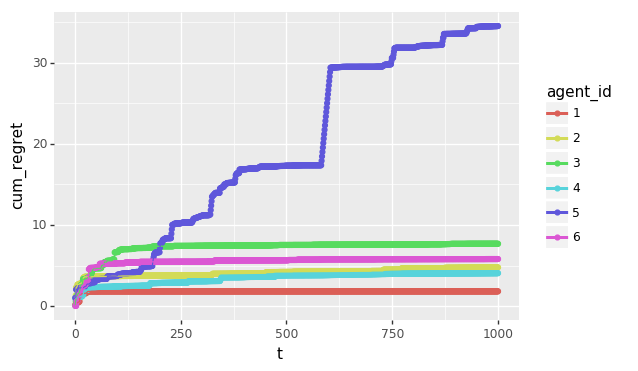

<ggplot: (8749288953741)>


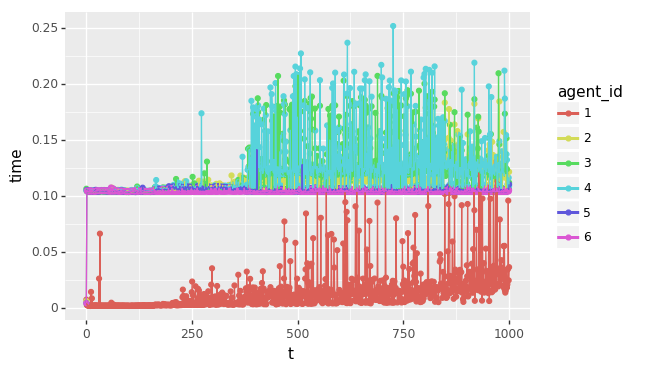

<ggplot: (8749288953741)>


([[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
   0             1        1     0.999981    0.147379        0.147379     1   
   1             2        2     0.999981    0.998953        0.998953     1   
   2             3        3     0.999981    0.059516        0.059516     1   
   3             4        4     0.999981    0.985287        0.985287     1   
   4             5        5     0.999981    0.998953        0.998953     1   
   5             6        6     0.999981    0.003443        0.003443     1   
   6             7        1     1.999962    0.259875        0.112496     2   
   7             8        2     1.999962    1.319523        0.320570     2   
   8             9        3     1.999962    0.606626        0.547110     2   
   9            10        4     1.999962    0.988730        0.003443     2   
   10           11        5     1.999962    1.028285        0.029332     2   
   11           12        6     1.999962    0.023056        0.01

In [6]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
make_agents = [make_laplace_agent,
               make_pgts_agent,
               make_best_langevin_agent,
               make_mala_agent,
               make_best_sgld_agent,
               make_best_sagald_agent]
                #,make_mala_agent_untimed]
simple_compares(make_agents, num_articles, dim, var, 1000, [1], verbosity=verbosity)
#simple_compares(make_agents, num_articles, dim, var, 1000, range(100,105), verbosity=verbosity)

In [ ]:
#from algorithms.langevin import *
#npla.eig(logistic_Hessian(agents[0].theta, agents[0].contexts))
#simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0)

# v2

In [7]:
def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    env = FixedLogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, df_list, cum_regrets_list, avg_regrets    

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seed=0, verbosity=0):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
    
def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets


In [8]:
num_articles = 100
dim = 20
var = 1.0/2
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=1

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521]
 Laplace sample: array([ 0.31563495, -2.02220122, -0.30620401,  0.82797464,  0.23009474,
        0.76201118, -0.22232814, -0.20075807,  0.18656139,  0.41005165,
        0.19829972,  0.11900865, -0.67066229,  0.37756379,  0.12182127,
        1.12948391,  1.19891788,  0.18515642, -0.37528495, -0.63873041])
 Sample: array([ 0.42349435,  0.07734007, -0.34385368,  0.04359686, -0.62000084,
        0.69803203, -0.44712856,  1.2245077 ,  0.40349164,  0.59357852,
       -1.09491185,  0.16938243,  0.74055645, -0.9537006 , -0.26621851,
        0.03261455, -1.37311732,  0.31515939,  0.84616065, -0.85951594])
 Sample: array([-0.74344483,  0.64596739,  0.80373014,  0.45770812, -0.06749684,
        0.23497337,  0.13914216,  0.39125283,  0.84998147,  0.430

 Sample: array([ 1.61374562,  0.73997047, -0.87868764, -0.75969151,  0.44576302,
        0.91150239, -0.72576753, -0.20517479, -0.9724568 ,  0.4110505 ,
        0.12881943, -0.42304371, -0.09866803,  0.75511232, -0.0809913 ,
       -1.48506824, -0.34426333,  0.36643518,  0.46558815, -0.66882179])
 Accept proportion: 0.518519
 Steps taken: 27
 Sample: array([ 0.41801558, -0.45145462, -0.56550767, -1.54546152, -2.3987612 ,
        0.71129256, -0.605898  ,  0.65634382, -0.32616105, -0.14082852,
       -0.73483959,  0.16301096, -1.34084326,  0.02390191, -0.86938999,
       -0.95467898,  1.08415385, -1.42879962, -0.69642482,  0.22285369])
 Steps taken: 100
 Sample: array([ 1.43352787,  1.30689164,  0.83748137, -1.49628753,  0.87193442,
       -0.95185382,  0.28047473,  0.73442868, -0.20464602,  0.18784642,
        1.68130231, -0.8425433 , -0.68422309,  0.03468874, -0.80879637,
        0.37847692,  2.41039877, -1.57901428, -0.25741317, -0.14263731])
 Steps taken: 89
 Laplace sample: array([-

 Sample: array([-1.94548845, -0.32664765, -0.19826616, -0.55171835, -0.21812911,
       -0.2421409 ,  1.84983747,  0.99874518,  0.55973514,  0.08061525,
       -0.35309618,  0.1561296 , -1.11174729, -0.78333046, -0.44077401,
        1.99739343, -0.76597386, -0.84471266, -0.13517937,  0.22336303])
 Steps taken: 73
 Laplace sample: array([-1.38225639,  0.01683497,  1.64831798, -2.05472837, -1.36171097,
       -1.28140581,  0.12417742,  1.08344067,  0.82077506, -1.45195393,
        3.36321081, -1.96068457, -3.48287478,  0.05403858,  2.37897518,
       -0.78742637,  1.02431338,  1.52795128,  0.76542156, -0.63300517])
 Steps taken: 30
 Sample: array([-0.66795197,  0.96764223, -0.18172043,  1.60357338,  0.64864662,
        1.43520044,  1.46119977, -0.93429128, -2.38594991,  0.15746938,
        0.08803356, -0.71327119, -0.46891023,  0.7452175 , -1.82881893,
        0.21098497, -0.67966227, -0.44396574, -1.05819177,  2.26683174])
 Sample: array([ 0.64911691,  0.49971114, -0.14296748,  0.116208

 Sample: array([-0.64540431,  0.7392503 ,  0.12632745,  0.91880448,  1.21568458,
        0.2334076 ,  1.16545613, -0.28581782,  0.51500954,  0.85551507,
        2.03784295, -0.86227811,  0.05119304,  1.74214052,  0.3187931 ,
       -0.08280693, -0.13820246, -0.7049114 ,  1.53182356, -0.07833449])
 Steps taken: 79
 Laplace sample: array([ 1.19174775, -0.83110511,  3.35995118, -0.77965672,  0.40051604,
       -1.53664643,  0.37712726,  3.45681268, -0.83845898, -0.61461429,
        2.00793051, -1.01363475, -0.80344062, -0.67445275,  1.33444282,
        0.37966933,  0.13681517,  0.57583119,  0.08420357, -1.32764126])
 Steps taken: 30
 Sample: array([ 0.36927654, -0.97945429, -0.97956121,  0.52794227,  0.479012  ,
        0.25378665,  1.29359187,  0.12655606,  1.11508341,  0.50854347,
        1.67143663, -0.24802266,  0.79677963, -0.02000801, -0.08046402,
        0.64856509,  0.38822638,  0.83241528, -0.2665619 , -1.19197385])
 Sample: array([ 0.87314019, -1.1559526 , -0.03431475, -0.742361

 Sample: array([ 0.22198943, -0.78200133,  0.37414446, -1.11093454, -0.66683186,
        0.35402021,  0.88507756, -0.97955186,  0.0812902 , -0.13553765,
        0.48905322, -0.23291603, -1.20512039, -0.91897424,  0.14987469,
       -0.20846143, -0.05812787,  1.06303105, -0.51115746, -0.28622914])
 Accept proportion: 0.518519
 Steps taken: 27
 Sample: array([ 0.51088084,  0.98228101, -0.37537707, -0.58475596, -0.3274927 ,
        0.65701068, -0.7029992 , -0.31664843,  0.43735221, -0.08806299,
       -1.04489105, -2.15620203, -0.10573148, -0.98703534, -1.151835  ,
       -0.30348283,  0.14925187, -0.82034621, -0.32247844,  0.30245173])
 Steps taken: 100
 Sample: array([ 1.34962578,  0.12837872, -1.0177257 , -0.27421505, -0.82871681,
        0.53268107,  1.32612092, -0.00568092, -0.526502  ,  0.39174657,
        1.31048154, -0.65868727,  0.20034671,  0.80074672,  1.67403725,
       -0.51963771, -0.70455162,  0.6702557 ,  0.75689109,  0.32651575])
 Steps taken: 88
 Laplace sample: array([ 

 Steps taken: 27
 Sample: array([ 2.02738175e+00, -8.67797541e-01, -7.35640159e-01, -9.72941928e-01,
        3.47613531e-01, -1.59484030e-03,  1.66847651e+00, -7.81262183e-01,
       -2.84987900e-01,  5.60281570e-01, -1.29174776e+00,  5.05287892e-01,
       -1.60688599e+00, -1.31953170e-01, -5.76491233e-01,  6.05639238e-01,
        5.16752981e-01, -5.83173997e-01,  1.82849644e-01,  5.05669403e-01])
 Sample: array([ 1.77342435, -0.24120349,  0.28656746, -1.96767075,  1.1913371 ,
       -0.57065283,  1.05278386,  0.51775767,  0.87498493, -0.02363007,
        0.32712673, -1.2984668 , -0.75651601,  0.22908331,  0.93310883,
       -0.35508137,  0.14152902,  0.95168328,  0.2999269 , -1.26577123])
 Steps taken: 115
 Sample: array([ 0.14731601, -0.06798126,  0.20267232, -0.50660845, -0.42601674,
       -0.29885959,  1.21220372, -0.51948233,  0.52803952,  0.12316134,
        0.61504994, -0.45738465, -0.65927359,  0.21865638, -0.30288259,
        0.07850019,  1.11558953,  0.24333122, -0.08129127

 Sample: array([ 1.39807237, -1.25967759,  0.10017602, -1.04520749, -0.38252006,
       -1.07067632,  0.2235859 ,  0.11560426,  0.97830567, -0.2639186 ,
       -0.41441924,  0.98235976, -0.91344705, -0.02560091, -0.34052412,
        0.48838036,  0.4930257 , -1.25631193,  0.8148077 , -0.23172747])
 Steps taken: 97
 Sample: array([-0.24340108, -0.3471864 ,  0.77575771, -1.36080675, -0.37678036,
       -0.80481438,  1.61902261, -0.54731823, -0.4728289 ,  0.17566137,
        1.46585076, -0.78473454, -0.38645779,  0.03564115,  0.85280095,
       -0.48532295, -0.12848237, -0.35631789,  0.45420053,  0.33396231])
 Accept proportion: 0.387097
 Steps taken: 31
 Sample: array([-0.179332  , -0.83861933, -0.07962697,  0.18895185, -0.02536013,
       -0.9582845 ,  0.61054565, -1.54245789, -0.09389751, -0.32942703,
       -0.3268789 , -2.78173105,  0.35050397, -0.64597444, -0.48353629,
       -0.84672669,  0.98855812, -0.55714304, -0.1072774 , -0.23541181])
 Steps taken: 93
 Sample: array([ 1.5959735

 Sample: array([ 0.09232828, -0.61581647,  0.75383676, -0.67698067,  0.09605325,
       -0.52038223,  1.24903911,  0.17196403,  1.46139448,  0.48801167,
        1.06904119, -1.05538586,  0.10561068, -1.13493922,  0.73332065,
        0.24241678,  0.337225  ,  0.37901017, -0.38801955,  0.55156504])
 Accept proportion: 0.217391
 Steps taken: 23
 Sample: array([-0.79199381, -1.50940679,  0.43450296, -0.03970702,  0.72730218,
       -0.89625021,  0.9536768 , -1.35392159,  0.40463224, -1.81482207,
        0.24598759, -1.15588895,  0.28873831, -0.08300477,  0.44293258,
       -0.27105296, -0.74634224, -0.66965498, -0.61670339, -0.18545072])
 Steps taken: 77
 Sample: array([ 1.15428971,  0.53763873, -1.02255754, -0.61015829,  0.98014464,
       -1.02359782,  1.02109851, -1.67934728, -0.4480875 ,  0.45548638,
        1.23564339, -1.48866538, -1.24856321, -1.37701509,  0.04454784,
       -0.9235207 ,  0.84844939,  0.88049592,  0.93181294, -0.27365559])
 Steps taken: 61
 Laplace sample: array([ 2

 Steps taken: 27
 Sample: array([ 0.88714783, -2.30635912,  0.07255326, -1.58664836, -0.73876744,
       -0.9891927 ,  0.49703286,  0.34775347,  0.30014253, -0.54941174,
        1.11432216, -0.51449732, -0.08757373,  0.12858192,  0.22053317,
        0.43692005, -0.38611139,  1.65106497, -0.14557462,  0.15585298])
 Sample: array([ 1.21108666, -0.8928071 , -0.55610983, -1.30529342, -0.31355817,
       -2.22956338,  0.28379112, -0.70972594, -0.12805589, -0.5964193 ,
        1.05567737, -0.96597739, -0.43346306,  0.57717973,  0.69856613,
       -1.05201877, -0.11182943, -0.91536713, -0.41559857, -0.22669667])
 Steps taken: 107
 Sample: array([ 0.91899413, -0.83113293,  0.03787514, -0.90399099,  0.37831207,
       -0.75198634,  1.02706108, -0.52111287,  1.2013569 ,  0.05411555,
        0.48141067, -1.84224461, -0.14300852, -0.34617039,  0.39478909,
        0.3869113 , -0.44002134,  0.03354637, -0.74446886,  0.13295303])
 Accept proportion: 0.633333
 Steps taken: 30
 Sample: array([ 0.094928

 Sample: array([ 0.12740621, -0.66890002, -0.37462931,  0.61944167, -0.59055891,
        0.07715373,  1.58827597, -0.37685724,  0.10293929, -0.22607679,
       -0.56557441, -1.60672311, -0.68549501, -0.43196078,  0.41861159,
       -2.64336076,  0.70267235, -0.26406705,  0.60443132, -0.51758749])
 Steps taken: 65
 Sample: array([ 1.43398877,  1.12256004, -1.78837547, -0.69369496,  0.77404933,
        0.07951209,  0.48404221,  0.50841532,  1.11911021,  1.07363497,
        0.32805317, -0.14386347, -0.31880226, -0.91059755, -0.40529734,
        0.3622447 ,  0.99829194, -0.36699249,  0.62367192,  0.55900806])
 Steps taken: 62
 Laplace sample: array([ 2.74700562, -3.16525705,  0.52448749,  0.62717758,  4.50304295,
       -2.55304837,  1.48012559,  0.86841066, -2.37652193, -1.13760383,
        3.75641274, -1.89739139, -1.29701153, -2.38880763,  3.93690802,
       -1.92943871,  4.53063316, -1.17263029, -1.38776158, -1.49492002])
 Steps taken: 30
 Sample: array([ 1.19117667, -0.22117751, -0.61

 Sample: array([ 0.11232776, -1.12824233, -1.27335245, -1.57007924, -0.42127687,
       -1.56231023, -0.20235253, -0.83580917,  0.44780431,  0.21899179,
        1.96188055, -2.37345252,  0.01104542, -0.16156737, -0.41015697,
       -0.07938284,  0.75687172, -0.7139101 ,  0.73437374, -0.99959435])
 Steps taken: 86
 Sample: array([-0.30799461, -0.76598657,  0.63023289, -1.04767201, -0.21230032,
       -0.29735456,  1.20651436, -0.92333657, -0.54178717, -0.22397455,
        0.79438463, -0.97548135, -0.55870289, -0.27161784,  1.65598261,
        0.18145141,  0.12544209, -0.663511  , -0.48106663,  0.92037851])
 Accept proportion: 0.344828
 Steps taken: 29
 Sample: array([-1.34576902, -2.1563336 , -0.68082176, -0.15459501, -0.38560853,
       -1.03263824,  0.88208938, -0.96883399,  0.08846521, -1.28436745,
        0.66343006, -0.43562733, -0.22953296, -0.63342977, -1.06164029,
       -1.01898615,  0.6767155 , -0.56508522, -0.65797828, -1.08711732])
 Steps taken: 78
 Sample: array([ 2.1805633

 Sample: array([-0.48230462, -0.66471634, -0.08991638, -1.29681735, -1.87141891,
       -0.84400626,  1.24011594, -0.5244867 , -0.23457288, -0.7257966 ,
        0.32375042, -1.30147902, -0.54159277, -0.69505228,  0.51909073,
        0.69657983,  0.00608274, -1.48394868, -0.39032129,  0.92692204])
 Accept proportion: 0.583333
 Steps taken: 24
 Sample: array([-1.87657635, -1.13031642,  0.36823082,  0.51831674, -0.03049533,
       -0.06304886,  0.03518817, -1.45782535,  0.26168957, -0.83105831,
        0.23509407, -0.52114775, -0.21328733,  0.01166747,  0.11261795,
       -0.11772049,  2.1861578 , -0.82139143,  0.4039597 , -1.0054968 ])
 Steps taken: 79
 Sample: array([ 2.78869093,  0.61836641, -1.25388954, -1.24471904,  0.59230452,
       -0.87684686,  2.49826935,  0.02355177, -0.00413365,  1.37383111,
        0.65279178, -1.23040132, -0.20042949,  0.17853291,  1.49174149,
       -0.56383691, -0.64767783,  1.43592927,  0.70580283, -1.03389118])
 Steps taken: 62
 Laplace sample: array([ 2

 Steps taken: 17
 Sample: array([ 2.46826725,  1.29575657, -0.90719712,  0.18562054, -1.17270714,
       -1.29145035,  1.47020529,  0.26311037, -0.95828581,  0.44180558,
        0.70279515, -0.27795903, -1.92374376, -0.21220871,  0.44265266,
       -0.90228351, -0.23921606,  1.10972279, -0.90478723,  0.80271062])
 Sample: array([ 1.86083772, -1.71454159, -1.94476886, -1.06165322,  0.60054126,
       -0.11836242,  0.31629458, -0.24018575, -0.09764417, -0.14928359,
        0.76396751, -0.99747008, -0.87208575, -0.39886541,  0.96363312,
        0.12149066,  1.22201426, -0.84157199,  1.28983299,  0.49629476])
 Steps taken: 64
 Sample: array([-0.4400866 , -1.12261849,  0.52851818, -0.83819771, -0.90602079,
        0.30221537,  1.62808003,  0.14888041, -0.16544609, -0.08295259,
        0.35987261, -0.98532604, -0.17996494, -0.43223994,  0.55809544,
        0.77105616, -0.30122202,  0.19242352,  0.04543512,  0.2030649 ])
 Accept proportion: 0.684211
 Steps taken: 19
 Sample: array([ 0.3652405

 Sample: array([ 0.70286187, -0.34945439, -0.40105711, -1.60901062, -0.27631028,
       -0.88844144,  0.60730254, -0.40959517,  0.09285837,  0.19683064,
        0.48201602, -1.23814749, -0.35579249, -0.70689861,  0.73874522,
        0.51817511, -0.46628189, -0.96077024, -0.34782686,  0.3019588 ])
 Accept proportion: 0.722222
 Steps taken: 18
 Sample: array([-0.81692733, -1.77961278,  0.77275325, -0.2013788 , -0.03044752,
        0.20364933,  0.871015  , -1.33852918,  0.49168833, -1.18523978,
        0.33709212, -1.27223917, -0.69267663, -0.24539836, -0.01477212,
        0.25480038, -0.84717663, -0.80878833, -0.22775461,  0.79728905])
 Steps taken: 52
 Sample: array([ 2.17499326, -0.15238636, -1.78220772, -1.50002278, -0.42724225,
       -1.32072582,  0.58722177, -0.31227489,  0.66110232,  0.54341645,
        1.2242848 , -1.268146  , -1.02008215, -0.50070874, -0.17571419,
       -0.24524322,  0.44233698,  0.30522396,  0.86083621, -1.42069509])
 Steps taken: 61
 Laplace sample: array([ 1

 Steps taken: 24
 Sample: array([ 0.65731911, -0.41579721, -0.24030422, -0.16492709,  1.22179298,
       -1.55639842,  0.64467906, -0.31612519,  1.12248455, -0.0072411 ,
        1.35144266, -1.51282235, -0.71338323,  0.6429198 , -0.5542323 ,
       -0.75765387, -0.85987485,  0.3934496 , -0.28462988,  1.17000747])
 Sample: array([-0.16431569, -1.01551603, -0.49649847, -0.66672405,  0.70687966,
       -1.03173884,  0.41080282, -0.69359623,  0.0908689 ,  0.34260723,
        1.38404803, -1.17722479, -0.6252968 ,  0.44116762,  1.11525733,
        0.106077  ,  0.05932147, -0.63088668,  0.83770584,  0.04450234])
 Steps taken: 91
 Sample: array([-0.12477628, -1.35577637,  0.18478397, -0.74332973,  0.2880782 ,
       -0.71155372,  1.59888881, -0.64158328, -0.76405324, -0.32063183,
        0.7663751 , -0.49039544, -1.14314411, -0.14983335,  1.03938906,
        0.65076071, -0.4247052 , -0.52148545, -0.51624969,  0.00958718])
 Accept proportion: 0.629630
 Steps taken: 27
 Sample: array([-0.5359470

 Sample: array([-1.02124165, -1.05510097,  0.4710383 ,  0.43695367,  0.22824592,
       -0.58499798, -0.41636665, -1.465212  ,  1.40825648, -0.27957396,
        1.07607258, -0.81475662, -0.3255861 , -0.55439248, -0.46364307,
        1.0062792 , -0.13745293, -0.72380089,  0.05420062,  0.13374126])
 Steps taken: 68
 Sample: array([ 1.77907408, -0.39886654, -1.55677003, -0.21283648,  0.3421983 ,
       -0.26960821,  1.22468194,  0.8899408 , -0.33508159, -0.20499313,
        0.95333701, -3.23051711, -1.32390898, -0.15737028,  0.31174362,
       -0.10257246,  0.02007579,  1.41863007,  0.17786184, -1.56838364])
 Steps taken: 61
 Laplace sample: array([ 3.57947555, -2.8176686 ,  1.26992793,  0.33370313,  5.59541344,
       -2.99413517,  3.50617887,  0.62938546, -1.48234035, -1.59155876,
        4.27996291, -6.11085028, -1.07305504, -0.07900708,  0.52860666,
       -2.60138898,  1.90648041, -2.32002774, -2.09418043,  1.61909447])
 Steps taken: 28
 Sample: array([ 1.30626863, -0.77413081, -0.78

 Sample: array([ 0.1514983 , -1.42766552, -0.68896073, -0.67893185, -0.04952552,
       -0.96174522,  0.23216273, -0.52009983, -0.51718544, -0.63383579,
        0.90045618,  0.19242562, -1.16197186,  0.41567057,  0.19643876,
        0.90693327, -0.14151821,  0.06311251,  0.21701545, -0.30385322])
 Steps taken: 73
 Sample: array([ 0.0394326 , -0.7015437 ,  0.19580078, -0.91809037, -0.39712671,
       -0.40111093,  1.14202893, -0.3009931 , -0.01489554,  0.32658814,
        0.76557278, -1.29146021, -0.96551665, -0.7018573 ,  0.43650562,
        0.28296696, -0.25492649, -0.53162788, -0.19156242,  0.31394432])
 Accept proportion: 0.538462
 Steps taken: 26
 Sample: array([ 0.99221615, -0.66457652,  0.28528114,  0.03985489,  0.62239501,
       -0.42858339,  0.31491354,  0.25184078,  1.2406646 , -0.70434064,
        1.04172064, -0.97567963, -1.07647926,  0.08085757, -0.91333409,
        0.81563695,  0.25730006, -0.37324399, -0.23605329,  0.30902393])
 Steps taken: 79
 Sample: array([ 1.1437938

 Sample: array([ 1.29658382, -1.10618274, -1.49432648, -0.55940036,  0.78479202,
        0.22403934,  1.41310314, -0.10383538, -0.28528086,  0.21650451,
        2.06340517, -0.39891541, -0.1054488 ,  0.74038078, -0.21710883,
       -0.56748126,  0.17373334, -0.12172723,  0.43521136,  0.97759852])
 Steps taken: 56
 Laplace sample: array([-0.31524796, -3.80306059,  2.35714185,  0.84244835,  5.47472045,
       -3.1059291 ,  2.02912713, -0.53997597, -2.24023203, -0.61273405,
        4.8460349 , -3.6904287 , -1.94394838,  0.38942593,  1.85600538,
       -4.39406906,  0.8128644 , -3.44542732, -2.35904265,  1.66603682])
 Steps taken: 28
 Sample: array([ 2.56686765, -1.78272463, -1.05123945, -0.19852508,  0.81261203,
        0.15389125,  0.74940281, -0.20178294,  0.0237281 ,  0.21502369,
        1.84309707, -1.75183925,  0.08358261,  0.26568482,  0.4017441 ,
        1.23913216, -0.67403304, -0.06600223, -0.18854868,  0.76295862])
 Sample: array([ 1.27718746, -0.35701911, -2.03524982, -0.853871

 Sample: array([ 0.64372712, -0.34656927, -1.32846105, -1.2140866 , -1.30289291,
       -1.76118556,  0.78522524, -0.01502635,  0.34916864, -0.04302422,
        1.06309433, -1.6434761 ,  0.2060565 ,  0.41763054,  0.25188622,
        0.03578487, -0.28421791, -1.29792904,  0.81629506,  0.28252086])
 Steps taken: 50
 Sample: array([ 0.07911644, -1.11079271,  0.63254751, -1.20713968, -0.47468533,
       -0.01744695,  1.73807146, -0.93506853, -0.28514844, -0.31620372,
        0.07872972, -1.18507722, -0.98260368, -0.82632109,  0.38533488,
        0.65619668, -0.4947054 , -0.80920356, -0.79786767,  0.47095272])
 Accept proportion: 0.647059
 Steps taken: 17
 Sample: array([ 1.21062731, -0.71459684,  0.40056167,  0.40975414,  0.31751244,
        0.15731609,  0.11825007, -0.03215241,  0.84042169, -0.53418437,
        0.67142718, -0.96006001, -0.65903472, -0.64370573,  0.69069845,
        0.08660828, -0.30739285, -0.70376706, -0.25604524,  0.11755712])
 Steps taken: 58
 Sample: array([ 1.8031777

 Laplace sample: array([ 0.96525522, -2.72266366,  0.6127849 , -0.36940131,  6.57117478,
       -2.35979325,  1.21144007, -2.28947262, -2.01319621, -2.15746499,
        5.42610573, -4.17045898, -0.01323454,  0.6401226 ,  0.45790845,
       -4.12839781,  1.46480388, -1.79592979, -1.74077169,  0.02250513])
 Steps taken: 27
 Sample: array([ 1.29237983, -1.29419537, -0.17747098, -0.64934542,  0.58509555,
       -2.53913583,  0.20172469, -0.78830353,  0.68696485, -0.05896068,
        1.10579968, -0.56271948,  0.11332007,  0.27651466,  1.15010588,
        0.14595655, -0.40853752, -0.46876834,  0.14050607,  0.99705586])
 Sample: array([ 1.57875623, -0.51285909,  0.06734617, -0.95286253,  0.28750473,
       -1.37030854,  0.72475715,  0.45575914, -0.32362952, -0.46165192,
        0.06946006, -0.94510389, -0.76624351, -0.96635478, -0.18026059,
        0.76490897,  0.71826331, -1.78391501,  0.85692536, -0.83057079])
 Steps taken: 77
 Sample: array([ 0.45123732, -0.09650045, -0.33160548, -0.887079

 Steps taken: 17
 Sample: array([ 1.76212889, -1.17197299,  0.08298064, -0.02515385,  1.13605167,
       -0.77575528,  1.5237627 , -1.34180322,  0.42697346,  0.41565888,
       -0.53285026, -1.82151874, -0.63027801, -0.94882957,  0.52588932,
        0.41803843, -0.20373471, -1.05008495,  0.25374799,  1.12031142])
 Sample: array([ 0.88475161, -0.44739066, -1.01308578, -1.32861058,  0.52955343,
       -2.16690581, -0.43867871, -0.58114798,  0.30785767,  0.19633372,
        0.65536504, -1.06646565, -0.36925138, -0.24505767,  0.26963483,
        0.81877317,  0.40454865,  0.26717254,  0.38043754, -0.60832896])
 Steps taken: 73
 Sample: array([-0.4284991 , -0.33609311, -0.73374274, -0.90468859, -0.86582458,
       -0.31176827,  0.9724582 , -0.88610008,  0.56984384, -0.06609394,
        1.5030031 , -0.91779013, -0.95906058, -0.5788275 ,  0.78449239,
        0.8479782 , -0.60026639,  0.05449318,  0.14848436,  1.07316836])
 Accept proportion: 0.521739
 Steps taken: 23
 Sample: array([ 1.3065012

 Sample: array([ 0.83574547, -2.21835817, -0.59766015, -0.16573247,  0.95423337,
       -0.3450125 ,  1.50909736,  0.7664443 ,  0.14976415, -0.74871257,
       -0.56640533, -1.225058  ,  0.26794212, -0.97335769,  0.5659503 ,
       -0.17215886,  1.31451924, -0.77789331,  0.13573897,  0.46180092])
 Steps taken: 67
 Sample: array([ 0.895988  , -2.04190433, -1.18183211, -2.21214416,  1.31026684,
       -0.76153114,  1.14289453, -0.88461029, -0.91239425,  1.18481909,
        1.46560132,  0.07890551, -2.35963724,  0.27789032,  1.70861979,
       -1.45420947,  0.18875154,  0.80677084, -0.51979453,  0.86446378])
 Steps taken: 60
 Laplace sample: array([ 1.3714739 , -3.19878996,  2.70875666, -1.53739537,  4.88843841,
       -4.23324084,  3.96740135,  0.39814732, -2.44074591, -2.47834905,
        3.524397  , -4.25126513, -0.4831232 , -1.39354876,  0.3730256 ,
       -3.03599915,  1.8974787 , -0.53106869, -1.01489327,  0.4110714 ])
 Steps taken: 9
 Sample: array([ 1.61950717, -1.39064789,  0.078

 Sample: array([-0.6163442 , -0.86501282, -0.39862701, -1.61018515, -0.17717508,
       -0.1699092 ,  0.8780207 , -0.46337654,  0.57766994,  0.25222766,
        0.66292914, -1.04224251, -0.36301017, -1.28119284,  0.8555506 ,
        0.433378  , -0.59225176, -0.1038879 ,  0.58085301,  0.29925753])
 Accept proportion: 0.642857
 Steps taken: 14
 Sample: array([ 0.62468312, -1.93113923, -0.24558275, -0.21320559,  0.73946002,
        0.11048545,  1.07751493,  1.24556505,  0.62491524, -0.58593881,
        0.05219356, -1.14089878,  0.1246939 , -1.22864617,  0.26305484,
       -0.17117349,  0.82453539, -0.26265769,  0.38126469, -0.71352294])
 Steps taken: 50
 Sample: array([ 1.35174574, -2.67026756, -1.8344551 , -0.96490783,  1.23018161,
        0.04515973,  0.7248687 , -0.56466211, -0.78992064,  0.38816294,
        0.33152192, -0.78337648, -2.01729173,  0.83441249,  0.43356447,
       -1.2470215 ,  1.14232066,  0.07047988,  0.77406054,  0.10926849])
 Steps taken: 60
 Laplace sample: array([ 1

 Sample: array([ 2.15501476,  0.26483024, -0.28444981,  0.06684476,  1.0809668 ,
       -1.67519463,  0.49759414, -0.59436916, -0.12502923,  0.24554221,
        1.21056074, -1.01297501, -0.49679913,  0.8622284 ,  1.67561723,
        0.04957098,  0.28977667, -0.83993549,  0.88344127, -0.61215221])
 Steps taken: 47
 Sample: array([ 0.03938995, -0.32725881, -0.78620989, -0.62344465, -0.40463144,
       -0.47856802,  1.72785462, -0.4801787 ,  0.30696592,  0.39005514,
        0.78833278, -1.74944304, -0.09448058, -0.93336256,  0.62721896,
        0.31184887, -0.14118082,  0.19744123,  0.38190976,  0.46791506])
 Accept proportion: 0.666667
 Steps taken: 18
 Sample: array([ 0.940949  , -1.90644342, -0.54674532,  0.54940718,  0.82942168,
        0.12026047,  1.33185888,  0.3820592 ,  0.3431852 , -1.12034898,
       -0.35261112, -1.50469865,  0.30128998, -1.03334698,  0.84274528,
       -0.64669949,  0.8791931 ,  0.05106961, -0.10345234, -0.11286649])
 Steps taken: 76
 Sample: array([ 1.6980837

 Steps taken: 18
 Sample: array([ 1.55015684, -1.32370157, -0.01240391,  0.09880275,  1.00958554,
        0.33628527,  0.19958008, -0.78964429,  1.04739021,  0.85905964,
        0.68783307, -0.85142267,  0.13853894, -0.00804392,  0.35198844,
        0.99804072, -0.30150638, -1.33706238,  0.64667869,  0.70582897])
 Sample: array([ 0.20923542, -1.07488035, -0.52309698, -0.13880551,  0.37392095,
       -1.14233116,  0.82123099, -0.21820668,  0.32755422, -0.24832862,
        1.72773069, -0.73968887,  0.03915717,  0.67894817,  0.4493762 ,
       -0.10477028, -0.71189476, -0.92487078,  1.24446209, -0.65128742])
 Steps taken: 41
 Sample: array([ 0.21109461, -0.17478652,  0.02956001, -0.59134955,  0.32973414,
       -0.0166587 ,  1.45974545, -0.10236685,  0.11498152, -0.33947231,
        0.07646996, -1.73124658, -0.22828525, -0.36916546,  1.09959066,
        0.20160391, -0.39466038,  0.38109384, -0.06829965,  0.03716035])
 Accept proportion: 0.571429
 Steps taken: 14
 Sample: array([ 0.9316596

 Sample: array([ 1.95737773, -0.96582966, -1.56460162, -0.04965189,  0.7364232 ,
       -0.8008804 ,  0.93772882, -0.62515877, -0.06186776,  0.25557443,
       -0.13083517, -1.75957577, -1.43829439, -0.68126272,  1.36787297,
       -0.23932952,  0.21837612,  0.93835276,  0.39058516,  0.19517604])
 Steps taken: 37
 Laplace sample: array([ 2.55084295, -2.48024863,  0.04570883, -2.15074991,  3.62802682,
       -2.10897195,  5.81044448, -3.07605161, -2.9024196 , -0.12194597,
        4.96077439, -2.21988503, -0.59201793,  0.26786365,  0.58830943,
       -3.53981155, -0.30432532, -0.9949612 , -0.37587179,  1.74895179])
 Steps taken: 17
 Sample: array([ 1.39785106, -0.76560271, -0.63750476, -0.20352624,  1.76503087,
       -1.08321691,  0.64138681, -1.16125472,  1.48375197,  0.0395444 ,
        1.38428966, -1.90864198, -0.24217479, -1.09987991, -1.32857604,
        0.00466297,  0.2061256 , -1.92911821,  0.62150623,  0.39159555])
 Sample: array([-0.07331681, -2.44036627, -0.94679873, -1.348729

 Sample: array([ 0.8629706 , -1.44618779, -0.46727427,  0.53188629,  0.60264586,
        0.5716174 ,  1.01638762,  0.00170541,  0.90648579, -0.42980497,
       -0.37484781, -1.67431986, -0.08034369, -1.25546721,  0.55002213,
       -0.4879887 ,  0.09785016, -0.20283502, -0.16002613, -0.17769409])
 Steps taken: 56
 Sample: array([ 0.83838095, -1.91521453, -1.61458062, -1.05739855,  0.53776945,
        0.11554607,  0.7421174 , -0.73397304,  0.32588721,  0.84276475,
        0.52603551, -1.73925191, -1.53167975, -0.48938708,  0.32224645,
       -1.11721673,  0.22721081,  0.92475638,  0.89274135, -0.4152775 ])
 Steps taken: 50
 Laplace sample: array([ 1.68944706, -3.51656436,  1.36354611, -0.02801505,  6.79444277,
       -1.567178  ,  3.13411481, -0.58245001, -2.36348304, -1.19435334,
        5.13105021, -1.58146341, -0.17130596, -0.48964959,  1.8738325 ,
       -5.50910361,  0.95262755,  0.06369136,  0.9241711 ,  0.52433451])
 Steps taken: 18
 Sample: array([ 2.40288721, -0.15165028, -0.61

 Sample: array([ 0.69128437, -2.05867417, -1.4482078 , -1.1112434 ,  0.12719895,
       -0.35520667,  1.71985325, -0.78558354, -0.46228824,  0.58539341,
        0.60769774, -1.14747938, -0.42080845, -0.6159116 ,  0.29026299,
       -0.59153555, -0.23654276,  0.56901796,  0.11790312,  0.4311529 ])
 Steps taken: 40
 Laplace sample: array([ 0.6683025 , -2.86394333,  1.30572488, -0.88984488,  6.9692967 ,
       -1.84574993,  0.9996049 , -0.91562223,  0.35724292, -3.35065185,
        4.86704828, -2.10911995,  0.59604726, -0.9251206 ,  1.87411752,
       -4.04617645,  1.69758118, -0.51641126, -1.76656201,  1.77060396])
 Steps taken: 25
 Sample: array([ 1.57465205, -1.39886983, -0.4860731 , -0.24549633,  0.62727694,
       -1.7126697 ,  1.30772991, -0.36511542, -0.29339012,  0.08997026,
        0.88911929, -0.89294705, -0.42299479,  0.2220349 ,  0.47692352,
       -1.2552592 , -1.4694865 , -0.01972083, -0.18237985,  1.56149704])
 Sample: array([ 1.93142217, -1.58159576, -0.61435864, -1.298904

 Sample: array([ 0.34772313, -0.90972362,  0.05803112,  0.63473074, -0.08342566,
        0.23267622,  0.32532735, -0.33310942,  0.99529089, -0.85782494,
        0.16094808, -2.87788398, -0.19521805, -0.75742834, -0.03299787,
       -0.53560351, -0.31251259,  1.13445487, -0.4232463 , -0.13455905])
 Steps taken: 40
 Sample: array([ 1.13996969, -1.06434213, -1.66706505,  0.25154081,  0.87879196,
       -0.65219824,  1.95340359, -0.17357356, -0.40453714,  0.62657826,
        0.38328656, -1.65252521, -1.04766193,  0.32740852,  1.33111885,
       -1.05103886, -0.27104224,  1.30175818,  1.63836483,  0.2885248 ])
 Steps taken: 36
 Laplace sample: array([ 2.57383765, -2.62383673,  2.66080323, -0.98052129,  6.34843303,
       -4.70141075,  3.13360994, -1.54501249, -0.2214673 , -3.76733551,
        6.01668524, -2.69634093,  0.63649564, -1.93363307,  1.32257457,
       -3.50905346,  3.04730726, -0.73614535, -1.45015406,  0.93170637])
 Steps taken: 16
 Sample: array([ 2.12339091, -1.90094682,  0.15

 Accept proportion: 0.384615
 Steps taken: 13
 Sample: array([ 1.04228460e+00, -8.33103205e-01,  1.41431460e-01,  3.96341717e-01,
        2.45301109e-03,  3.27398196e-01,  2.05214126e-01,  1.40861011e-01,
        1.02099196e+00, -6.58308893e-01, -5.31409086e-01, -2.57606416e+00,
        7.64258907e-02, -2.54489333e-01,  9.29419427e-02, -2.54921376e-01,
       -1.16322708e-01,  8.86077187e-01, -4.53550781e-01,  2.67571991e-02])
 Steps taken: 51
 Sample: array([ 0.38971866, -0.97757168, -1.4816445 , -0.44158542,  0.76406174,
       -0.86139154,  1.75696229, -0.36922234, -0.27010101,  0.89178679,
        1.46150394, -0.85969078, -0.2275536 ,  1.32641587,  1.15048512,
       -1.17905077, -0.28650748,  0.55564437,  1.00943429,  0.38010655])
 Steps taken: 40
 Laplace sample: array([ 3.08038021, -3.42359815,  1.02994266, -0.90649637,  6.93847909,
       -3.34075878,  3.23248357, -1.11050387, -2.91168226, -2.45459253,
        5.08904199, -2.15270743,  0.23761706,  0.56709937,  2.29333664,
    

 Sample: array([-0.17584486, -1.24730129, -0.21410338, -0.95486161,  0.39509454,
        0.35012269,  0.69566862, -0.06166809,  0.04172417, -0.6036653 ,
        0.6114672 , -1.33998472, -0.21916286, -0.62879497,  0.68520908,
       -0.01640445, -0.34373319, -0.01806551, -0.36029293,  0.91635746])
 Accept proportion: 0.666667
 Steps taken: 6
 Sample: array([ 0.89197443, -1.38750805,  0.27711501,  0.66384135,  0.07398088,
        0.47128678,  0.5806538 ,  0.12927422,  0.5769979 , -0.1663041 ,
       -0.00415251, -1.98495909, -0.33400925, -0.36844575, -0.19054836,
       -0.34101644, -0.01414477,  1.0104378 , -0.74078198, -0.10723923])
 Steps taken: 50
 Sample: array([ 0.79557716, -0.84316232, -1.95139647, -0.44128793,  0.26859704,
        0.01402064,  1.89550295,  0.32834027,  0.23572413,  1.01672531,
        0.73218413, -1.84612543, -1.02342105, -0.12713592,  0.1685537 ,
        0.40251062,  0.50739615, -0.83262324,  0.57498518, -0.02076844])
 Steps taken: 40
 Laplace sample: array([ 0.

 Sample: array([ 1.93044812, -0.49812305, -2.03764387, -0.25813267,  0.61582726,
       -0.24111491,  2.36898639,  0.37102772,  0.0148653 ,  0.34778677,
        0.17555228, -1.27578765, -0.82649716,  0.46874272, -0.24004476,
       -0.79172705,  0.0702055 , -0.88161757,  0.20838501, -0.15481166])
 Steps taken: 38
 Laplace sample: array([ 0.92185546, -3.02228754,  2.69073068, -0.82692645,  7.63399506,
       -2.64987018,  1.96631958, -1.43555972,  0.38782863, -3.9345457 ,
        6.06631863, -2.47280389,  0.46724993, -1.55787778,  1.40401005,
       -3.90592016,  2.08617072, -2.85781353,  0.42308798,  2.87868575])
 Steps taken: 17
 Sample: array([ 2.74676729, -0.85648579, -0.00785414, -0.38360148,  0.96578636,
       -2.35941654,  2.30903461, -0.84293861,  0.0971999 ,  0.89105871,
        0.54465937, -0.82397768,  0.08578594,  0.25950478,  0.52162059,
        0.33219466,  0.1734445 , -0.31010246,  0.30455136,  0.04395673])
 Sample: array([ 0.98462049, -1.28590585, -1.33464459, -1.149854

 Sample: array([ 0.69984947, -0.80512078,  0.17712107, -0.21665553, -0.10553561,
        0.48571287,  0.80686868,  0.28117027,  0.65583227,  0.36916837,
        0.40578758, -2.02067507, -0.11746206, -0.07205333, -0.32377981,
       -0.00944029, -0.48858558,  0.43687647, -0.99431272, -0.8905174 ])
 Steps taken: 45
 Sample: array([ 1.80949973, -0.25472485, -2.3219834 ,  0.3508677 ,  0.04664042,
       -0.53215265,  2.31043026, -0.02016372,  0.6988462 ,  2.09082156,
        0.63247833, -1.34294337, -0.76136566, -0.37023466,  0.03037183,
       -0.1574189 ,  0.17202177, -0.08126775,  0.80366972,  0.27905045])
 Steps taken: 39
 Laplace sample: array([ 1.89067298, -1.18539652,  0.76645737, -0.82417697,  5.59309224,
       -3.03397966,  3.97443597, -0.91408502, -1.0558598 , -3.15122878,
        5.53151562, -3.01960037, -0.36445112, -0.37489307,  1.68794074,
       -4.40170749,  1.96450181, -1.07958981, -2.26303598,  3.14562454])
 Steps taken: 14
 Sample: array([ 1.23207345, -1.74953457,  1.09

 Steps taken: 13
 Sample: array([ 0.75390531, -1.00347992,  0.20050787,  0.5266757 ,  1.68149887,
       -1.2008238 ,  1.49952709, -1.17463089, -0.20187147, -0.67760958,
        1.05031697, -1.18863035,  0.56532558,  0.49647957,  1.23058684,
       -0.22019045, -0.44911515,  0.02051224, -0.46877419,  0.7245848 ])
 Sample: array([ 0.68241981, -1.07382475, -1.70394485, -1.66471208, -0.71453701,
       -1.53036612,  0.23685167,  0.46953029,  0.14545405, -0.12215456,
        1.17525632, -0.93892476, -0.23890007, -0.23330489, -0.0729896 ,
        0.16338665, -0.41320767, -1.10649981,  0.00423264,  0.43599792])
 Steps taken: 36
 Sample: array([-3.94237888e-01, -1.44028313e+00,  1.59552494e-01, -1.79637724e+00,
       -3.76031996e-02, -4.56406276e-01, -9.48716308e-04, -2.71877347e-01,
        2.55286168e-01,  2.09286780e-01,  4.98864406e-01, -1.34136838e+00,
       -5.56568458e-01, -7.40173839e-01,  7.15500122e-02, -1.00513060e-01,
       -2.62598374e-01, -2.92820631e-01,  1.30866782e-02,  1.

 Steps taken: 13
 Sample: array([ 2.43555212, -1.6929239 ,  0.13623262, -0.45195099,  1.10948305,
       -1.61455926,  1.78268018, -0.46472148,  0.26605998,  0.43499614,
        0.73203751, -1.61997948, -0.8363617 , -0.14446935,  0.10348995,
       -0.47656803, -0.49971865, -1.1647904 ,  0.03019922,  1.76190487])
 Sample: array([ 0.71428502, -1.20071065, -2.12346086, -1.41835665, -0.3439811 ,
       -0.91993981, -0.89893931, -0.57439551,  1.25193528, -0.22256998,
        0.88619399, -1.12882951, -0.20559931, -1.38113652,  0.45860996,
        0.84431197,  0.05407913, -2.21872027,  1.48774096, -0.33391127])
 Steps taken: 35
 Sample: array([ 0.13453516, -0.5601798 , -0.51712202, -1.6641273 , -0.05023959,
       -1.08813888,  0.33551336,  0.14198184,  0.60177932,  0.11047754,
        1.11533533, -1.03888274, -0.50080268, -0.77367343,  0.58441102,
        0.16258017, -0.05991486, -0.5129755 ,  0.71450683,  0.45079001])
 Accept proportion: 0.833333
 Steps taken: 12
 Sample: array([ 1.0739219

 Laplace sample: array([ 0.10480434, -1.82709341,  1.08891232,  0.27924208,  6.95192495,
       -3.94263918,  4.95798141, -1.99039047, -2.53720513, -3.56028953,
        5.16021068, -4.16921736, -0.42338656, -1.2212617 , -0.12187733,
       -3.95741483,  3.22195557, -1.47671669, -2.05978575,  0.18589655])
 Steps taken: 16
 Sample: array([-0.36675053, -2.19068936,  0.197055  , -0.80374205,  1.49526294,
       -1.27963655,  1.52824576, -1.07740278,  1.29248563,  0.85686361,
        1.32278204, -1.53331597,  0.40664659,  0.17137037, -0.33465864,
       -0.57111412, -0.41486118, -0.73372583,  1.28647965,  0.22807023])
 Sample: array([ 2.12885382, -0.57453327, -0.52941845, -1.24443931,  0.44774097,
       -2.39611898,  0.22288844, -0.05353705,  1.43596729,  0.06163333,
        1.39865565, -0.18648836, -1.11049971, -0.90164155,  0.47454924,
        1.69896387,  0.71022148, -2.43098467,  0.87665024, -0.60095719])
 Steps taken: 33
 Sample: array([ 0.10010238,  0.04263983, -0.07312148, -2.169531

        0.33534826,  0.46351745, -0.04505294,  0.52596256,  0.71797564])
 Accept proportion: 0.416667
 Steps taken: 12
 Sample: array([ 0.60268144, -0.65586793,  0.5975333 , -0.28446481, -0.16079778,
       -0.69344873,  0.68329718, -0.21258284,  0.73872389, -0.36726031,
        0.06931436, -2.2553672 , -0.04851624,  0.15262512, -0.73002082,
       -0.39999099, -0.84321175,  0.02980664, -0.710185  , -0.66015003])
 Steps taken: 51
 Sample: array([ 2.2090282 , -1.80177525, -1.07234433, -1.73871238,  1.09214863,
       -0.94445652,  1.87044989, -0.88093688,  0.26571142, -0.38844099,
        0.15132119, -1.15606567, -0.34801586, -0.85713367,  0.65220457,
       -1.3387051 , -0.55418727, -0.27923249, -0.6310437 ,  1.42892162])
 Steps taken: 40
 Laplace sample: array([ 2.32266566, -3.05267131,  1.63572889, -0.49781736,  6.07478971,
       -2.97563618,  3.36510675, -0.54716105, -2.59148958, -4.83623748,
        4.71794465, -1.55652878,  0.6648707 , -0.89767795,  1.94278922,
       -4.40980542

 Sample: array([ 0.27351598, -0.7941834 ,  0.7622524 ,  0.0854909 ,  0.17116722,
       -0.61747366,  0.66948903, -0.16293407,  0.25989748, -0.24436863,
        0.45348825, -2.23492278,  0.05734334,  0.10234137, -0.76240878,
       -0.57289598, -0.27845106,  0.30658611, -1.1318888 , -0.40299727])
 Steps taken: 9
 Sample: array([ 2.4206908 , -1.04030741, -1.48919668, -1.53418817,  1.2609436 ,
       -0.48226586,  1.45899601, -1.31495503,  0.82236038,  0.31058749,
       -0.62141307, -0.89745162, -0.15614592, -0.73812385,  0.58867738,
       -1.11942299, -1.49804041,  0.16770278,  0.24628134,  1.21812045])
 Steps taken: 10
 Laplace sample: array([ 1.46781082, -2.55485973,  1.38228982, -0.21929478,  6.27033618,
       -3.3775935 ,  3.60523195, -3.12181889, -2.12475183, -2.73042241,
        5.01414876, -3.46211211,  1.02898875, -0.30668975,  1.39504148,
       -5.2100205 ,  2.7738504 , -1.08769269, -1.3433384 ,  1.8954336 ])
 Steps taken: 15
 Sample: array([ 1.29115419, -2.48112671,  0.447

 Sample: array([-0.08109354, -0.34712472, -0.14693495, -1.46998057, -0.01196631,
       -1.07188618,  0.77667969, -0.01788235, -0.47009136, -0.10272098,
        0.53779985, -1.71113972,  0.11358406, -0.47606331,  0.59421441,
        0.25210375, -0.11247004, -0.02380874,  0.23066675, -0.02848577])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([ 0.16043753, -1.177379  ,  0.54778099,  0.06922755, -0.02920934,
        0.16256885,  0.7254498 , -0.21981061,  0.03003755, -0.42889106,
        0.67509311, -1.92502654,  0.0785403 ,  0.24342151, -0.30513523,
       -0.73447178, -0.52673629,  0.39109266, -0.92604972, -0.43589061])
 Steps taken: 46
 Sample: array([ 1.65356805, -0.55873527, -1.20984123, -0.83500988,  0.43313959,
       -1.18827067,  1.94378036, -1.7122106 ,  0.16129825,  0.50052403,
        0.264764  , -2.03354049, -1.06006345, -0.95492205,  0.57924634,
       -0.57788658, -0.95738507,  0.17498745,  1.09651734,  0.33882479])
 Steps taken: 39
 Laplace sample: array([-0.

 Sample: array([ 1.64982996, -0.85948152, -0.98558915, -0.96243441,  0.85147942,
       -1.11444966,  1.47090976, -1.25077015,  0.51658086,  0.34472662,
        0.32916661, -1.34443885, -1.29714787, -1.1767547 ,  0.66223892,
       -0.30983063, -0.6998041 , -0.27705979,  0.59128794,  0.16937516])
 Steps taken: 19
 Laplace sample: array([-0.42587641, -2.84746264,  0.57431106, -0.59138309,  5.65740808,
       -2.25287797,  1.95076128, -4.35367067, -1.43734599, -0.91074627,
        4.7679501 , -2.89084785,  0.13347102, -2.33964771,  0.96667817,
       -4.28071458,  1.73363652, -1.15131894, -0.56403627,  1.79630983])
 Steps taken: 12
 Sample: array([ 1.31119693, -0.14071085,  0.02924705,  0.46779147,  1.21564843,
       -1.52413871,  1.28869774, -0.73990731, -0.20192987,  0.65476396,
        1.00751683, -1.26738374, -0.67683963,  0.98907887,  0.45095538,
       -0.14688256, -0.10583734, -0.42906997,  0.11503668,  0.17700633])
 Sample: array([ 1.2353898 , -0.1254572 , -1.47293048, -1.372231

 Steps taken: 20
 Sample: array([ 1.54204215, -1.72454557,  0.24936614,  0.25264908,  0.80965639,
       -0.3233422 ,  1.23441311, -0.70021053,  0.87691438,  1.22021604,
       -0.13698232, -2.01039063, -0.4252765 , -0.24008732, -1.06056006,
       -0.7983751 ,  0.46660722, -1.5886856 ,  0.06291218,  0.80764019])
 Sample: array([ 1.28710266, -1.0579597 , -1.39503511, -0.67669913,  0.03197444,
       -2.25615247,  0.63567786, -0.72634246, -0.38707075,  0.08233443,
        2.03022674, -2.06971423, -0.59894985,  0.76588672,  0.98494725,
        0.28498657,  0.66573386, -1.80829406,  1.35115345,  0.2886406 ])
 Steps taken: 1
 Sample: array([-0.05030713, -0.73713862,  0.13997878, -1.13813342,  0.11531125,
       -0.42790791,  0.3079796 ,  0.03430147,  0.39226985, -0.11945368,
        0.69000684, -1.0757461 , -0.22679336, -0.48902534,  1.02771323,
       -0.53550577, -0.28692413, -0.25933049,  0.43422758,  0.79240403])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([-0.349333  ,

 Steps taken: 19
 Sample: array([ 1.61930411, -1.39145714, -0.09800331, -0.63708466,  1.96966532,
       -1.20016378,  1.74384459,  0.3362645 ,  0.63440677,  0.26422639,
        1.38319762, -1.29070179, -0.19996455,  0.30371145, -0.29509598,
        0.6579618 , -0.96128268, -1.28712713,  1.04845   ,  1.50740147])
 Sample: array([ 1.11967429e+00, -9.20190782e-01, -1.10741489e+00, -1.21952098e+00,
       -6.56189113e-01, -1.80735092e+00,  4.22138229e-01,  4.23640090e-01,
       -4.51100052e-01, -3.09184962e-01,  7.60987255e-01, -1.74047937e+00,
       -6.08633035e-01,  1.48427798e-01,  1.25796275e+00,  8.74850747e-01,
       -1.67505472e-03, -1.87670707e+00,  8.42840644e-01,  4.64854386e-01])
 Steps taken: 27
 Sample: array([ 0.36616354, -0.9441436 ,  0.41339485, -1.47916258,  0.21627087,
       -1.18397871,  0.15654839, -0.05157237,  0.10760293, -0.1309361 ,
        0.90302599, -1.41312471, -0.36080124, -0.35274613,  0.5109849 ,
        0.16895852, -0.40147391, -0.39083098,  0.5498053 ,

 Laplace sample: array([-0.06679772, -0.75640285, -0.49782834, -0.2492173 ,  5.30419537,
       -2.34489718,  4.22838893, -1.54725115, -1.95346001, -1.99055478,
        6.05596439, -2.9585199 ,  0.13028262,  0.18373045,  3.50649582,
       -3.83286831,  1.02062146,  0.26501515, -2.16694643,  1.28771718])
 Steps taken: 15
 Sample: array([ 1.97191446, -1.68172092, -0.23890421, -0.84271351,  0.84074726,
       -1.87674784,  0.5560071 ,  0.35456766,  0.88458683,  1.30349848,
        0.71055728,  0.1270346 , -0.16431521,  0.6338943 , -0.80492037,
        0.54975899,  0.46496219, -1.07087211,  0.74076932,  0.71550332])
 Sample: array([ 1.14404475, -1.32654394, -1.32772859, -1.78375885, -0.83685374,
       -2.65876331,  0.44774756,  0.13177229, -0.72184826, -0.42032564,
        1.0146554 , -1.20202804, -0.35394908,  0.02584341,  0.92513444,
        0.37963258, -0.518885  , -1.72349827,  1.48184522,  0.09812927])
 Steps taken: 1
 Sample: array([ 0.50057144, -1.04790454,  0.63484834, -1.6981776

 Sample: array([ 1.25716134, -0.92466353, -1.56685524, -1.80276611, -0.80174918,
       -2.47382882,  0.45298346,  0.01330846, -0.11796907, -0.41648587,
        1.34876825, -1.2531231 ,  0.23324227,  0.12566232,  0.34416449,
       -0.21527312, -0.14968683, -1.8009343 ,  1.46852179, -0.37953605])
 Steps taken: 11
 Sample: array([ 0.48021453, -1.25074945,  0.62153829, -1.98196969,  0.46057761,
       -1.12613411,  0.45205068, -0.58035031, -0.01716295, -0.42466149,
        0.81000236, -1.19871847, -0.31753482, -0.51294311,  0.36530245,
       -0.07802738, -0.25705819, -0.37393108,  0.16066953,  0.74002443])
 Accept proportion: 0.333333
 Steps taken: 3
 Sample: array([-0.54967008, -0.31138926,  0.11934592, -0.67071838, -0.54945664,
       -0.280651  ,  1.50661997, -0.32621139,  0.50923977,  0.00529847,
       -0.35404124, -1.04441129, -0.71392688,  0.59736562,  0.60716013,
       -0.21268601,  0.31951088, -0.07809474, -1.09969722,  0.18748403])
 Steps taken: 35
 Sample: array([ 1.83322688

 Sample: array([-0.24833091, -0.47224271,  0.17528679, -0.88509483, -0.65653978,
       -0.21974452,  1.23080578, -0.09829899,  0.59404264,  0.2380546 ,
        0.59025926, -1.40143247, -0.8684612 ,  0.7986793 ,  0.44032919,
       -0.44002482,  0.35598913, -0.09736441, -1.49175459, -0.11621474])
 Steps taken: 27
 Sample: array([ 1.67618376, -1.38179228, -0.88295382, -0.17320336,  1.48069454,
       -0.92828994,  1.58143245, -0.73152746,  0.08530123,  0.80208639,
        0.21556098, -0.68887761, -0.65068428,  0.08822237,  0.53871201,
       -0.14409419, -0.45357033, -0.72654652,  0.95960327,  0.5049297 ])
 Steps taken: 21
 Laplace sample: array([ 1.70682919, -0.91916237,  2.48420253, -0.68038309,  7.11624115,
       -2.85626447,  5.45604416, -0.24198015,  0.02619359, -0.71899284,
        6.65293196, -3.14147334, -0.0903665 , -0.77439876,  1.64139022,
       -3.66894999,  2.22834672,  0.48461865, -1.59290026,  1.75355771])
 Steps taken: 3
 Sample: array([ 2.16598771, -1.5453709 , -1.080

 Sample: array([ 1.91150287,  0.64706059, -1.28681466, -1.74981014, -0.52063608,
       -1.7077021 ,  0.28969457,  0.71707221,  0.26441473,  0.35968982,
        1.48164748, -1.86318644,  0.19486348,  0.03288607,  1.02552481,
       -0.58752639, -0.02204692, -2.01667268,  1.62885906, -0.59834402])
 Steps taken: 7
 Sample: array([ 0.21922261, -0.74941008,  0.11662712, -1.86380624,  0.20528464,
       -0.87372203,  0.22288752, -0.56152552,  0.09901938, -0.66049818,
        0.74145896, -0.99409086, -0.5047514 , -0.49649783,  0.3684112 ,
       -0.08559019,  0.15110599, -0.488288  ,  0.23056888,  1.28943869])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([-0.20015476, -0.38812238,  0.17142641, -0.8090013 , -0.35927487,
       -0.29152305,  1.66010993, -0.15212898,  0.34372053, -0.13466197,
        0.43734416, -1.55553213, -1.06240381,  0.82729015,  0.47779765,
       -0.449121  ,  0.32442283, -0.03051483, -1.62193761, -0.0499091 ])
 Steps taken: 16
 Sample: array([ 1.69209079,

 Steps taken: 6
 Sample: array([ 1.37280682, -2.62972442,  1.03676367, -0.46822374,  1.52972108,
       -2.62902796,  1.43469774, -0.0499611 , -0.10374281,  0.76601198,
        0.86883278, -1.60059013,  0.02297045,  0.92631718,  0.75527754,
       -0.60546059,  0.72237598, -0.45295559, -0.48018415,  0.42373708])
 Sample: array([ 1.8429502 , -0.21429149, -0.66862403, -1.48403885, -0.11923752,
       -2.39382244,  0.2421161 ,  0.23836992,  0.42860435,  0.41075503,
        1.19385185, -2.15556119, -0.24197113,  0.4805584 ,  1.27575216,
       -0.18733403, -0.59594089, -0.87450216,  1.31880885, -0.24362052])
 Steps taken: 10
 Sample: array([ 0.25805814, -0.71918689, -0.21727792, -1.62883721,  0.3802686 ,
       -0.80731593,  0.51869998, -0.83701385,  0.35815899, -0.47210755,
        1.23513875, -0.71949028, -0.15573763, -0.93758858,  0.87571645,
       -0.24437948, -0.12426502, -0.95685379,  0.18860869,  0.7807479 ])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([-0.25447252,

 Sample: array([ 0.51544632, -1.84692317, -1.50422854,  0.57072296,  0.41781716,
       -0.85045253,  1.91149341, -0.36156651,  0.07755704,  1.42651857,
        0.9661988 , -1.44949672, -0.02036113,  0.64500529,  0.9096113 ,
       -0.51523603, -0.16345168, -0.55399827,  2.30712139,  0.34219162])
 Steps taken: 27
 Laplace sample: array([ 0.11407323, -0.22676985,  3.63427759,  0.83862067,  4.77720309,
       -0.93405387,  2.76461459, -1.51413788, -0.46428847, -2.11558541,
        5.91370227, -2.23473149, -0.22825104, -2.74446997,  3.28270626,
       -5.95995017,  3.17205913, -1.77482085,  0.2692575 ,  1.33557004])
 Steps taken: 5
 Sample: array([ 1.45253599, -1.03548139, -0.15386554, -0.44885832,  1.01702931,
       -1.61194556,  0.41319558, -0.55682555,  0.43377583, -0.04496383,
        0.55875384, -1.09270806, -0.19129856, -0.10768194, -0.15916969,
       -0.25314827, -0.20639379, -0.68717008, -0.00393199,  1.23004458])
 Sample: array([ 1.23466671, -0.45898726, -1.18723081, -1.7927008

 Steps taken: 5
 Sample: array([ 2.2560136 , -0.70555105,  0.24902957, -0.16528477, -0.02865241,
       -1.17479002,  1.5163189 ,  0.71236184,  0.45627996,  0.65681766,
        0.4256079 , -0.77730993,  0.17973585,  0.10517669, -0.62574192,
        0.26426867,  1.36402138, -0.06835543, -0.54857628,  0.07207644])
 Sample: array([ 1.48163332, -0.48957139, -0.81493008, -0.96266264, -0.55963858,
       -1.46063873,  0.1831226 ,  0.35154374,  0.54594418,  0.92326781,
        0.93967359, -1.53967066, -0.21767784,  0.11621629,  1.17394361,
        0.24443446,  0.07540529, -1.01502741,  0.7895145 , -0.03385999])
 Steps taken: 4
 Sample: array([ 0.59120943, -0.59451475,  0.18251272, -1.53930378,  0.04288471,
       -0.62978732,  0.67426076, -0.7584396 ,  0.24548485, -0.15187773,
        1.09190254, -1.07239513, -0.05127098, -0.9343508 ,  0.79908976,
       -0.28486159,  0.03288683, -0.30932949, -0.22670855,  1.06238462])
 Accept proportion: 0.750000
 Steps taken: 8
 Sample: array([ 0.03757581, 

 Laplace sample: array([ 1.59187873, -1.63758139,  1.71390559, -0.06433673,  6.41397091,
       -1.12532335,  3.40770832, -1.68093069, -1.49396685, -1.94050626,
        5.65803704, -1.76375038, -1.93187564, -3.43716652,  1.74231913,
       -5.98048513,  0.49716753, -2.20040787, -0.56632344, -0.21089413])
 Steps taken: 14
 Sample: array([ 2.10776212, -1.00334844, -0.17013282, -0.94594808,  1.14751822,
       -0.84858196,  1.49159056,  0.15800346,  0.70073747,  0.69963749,
        0.80016768, -1.48700955, -0.5071732 , -1.14271194, -1.62615395,
       -0.22830101,  0.78231912, -1.17728921,  0.00999215,  0.73010189])
 Sample: array([ 0.23565851, -1.15397048, -0.94236463, -1.17563134,  0.35576554,
       -1.90316285,  0.03408689, -0.76286197,  0.55595109,  0.38719137,
        1.08421409, -0.86837384, -0.99442809,  0.1801574 ,  0.69028367,
        1.13736496,  0.52872304, -0.79910604,  0.70803817, -0.34573786])
 Steps taken: 23
 Sample: array([ 0.40013248, -0.99605363, -0.19132899, -1.235929

 Sample: array([ 0.09877915, -3.15494071, -2.44132317, -0.58661361,  1.13859633,
        0.04826271,  0.93327332, -0.57044055,  0.29992002,  0.80348342,
        0.79308779, -0.47127191, -0.2399043 ,  0.57827243,  0.49773151,
        0.11314167, -0.44670861, -1.02644454,  2.12258839,  1.12448368])
 Steps taken: 14
 Laplace sample: array([ 3.12630434, -1.42275424,  2.36794939, -2.05888623,  6.82024297,
       -1.59751138,  2.21306236, -3.75274452,  0.05197294, -1.08636025,
        4.87333059, -3.02753781,  0.26271193, -2.07543632,  2.33773836,
       -5.91649674,  0.21887445, -2.72618883,  0.68666451, -0.234353  ])
 Steps taken: 7
 Sample: array([ 1.3387526 , -1.8462557 ,  0.62815418, -1.13216273,  0.86334683,
       -2.18752043,  1.1414105 , -0.98222003, -0.22114792,  0.70557609,
        1.42798246, -0.78334268,  0.6524822 ,  1.02649198,  0.24033884,
        0.08539257,  0.69232304, -0.76406373, -0.49122766,  0.84602217])
 Sample: array([ 1.56409861, -1.21045942, -0.67112673, -0.8034268

 Sample: array([ 0.04761049, -2.85575601, -1.08873917, -0.26098324,  1.7320338 ,
        0.60943128,  1.73203325, -0.15677433,  0.30073201,  0.47538981,
        0.71921746, -0.89676788, -0.6270618 ,  0.45571346,  0.18845693,
       -0.01073851, -0.47801748, -0.94791576,  1.83182308,  0.74898502])
 Steps taken: 25
 Laplace sample: array([ 0.62275116, -0.09847457,  2.15257512,  0.52827285,  7.2561411 ,
       -2.14405489,  3.15052564, -1.64310173, -0.73813184, -1.33039504,
        5.72427177, -2.75388242, -1.66496472, -2.49688591,  2.85133976,
       -6.17553267,  1.8666999 , -2.84715303, -0.25750625,  0.28508275])
 Steps taken: 15
 Sample: array([ 2.2391005 , -0.04034905,  0.68978394,  0.00537178, -0.30495385,
       -1.70343103,  1.61824153,  0.21600084, -0.53970197,  0.0672694 ,
        0.62207149, -2.14794449,  0.20854068, -0.00769152, -0.75332869,
        0.50079037,  0.61099028, -0.63449555, -0.63029803,  0.07848387])
 Sample: array([ 0.81808279, -1.55127569, -0.29720267, -0.626237

 Sample: array([ 0.8860422 ,  0.14151188, -0.72809224, -0.59630544, -0.4851686 ,
       -0.90008235,  2.48545037, -1.24114624,  0.20283793,  0.75156584,
        0.54244545, -1.02434843, -0.60622188, -0.09429389, -0.19163885,
       -1.33385   ,  0.03462994,  0.47627518, -0.89634706,  0.5617121 ])
 Steps taken: 12
 Sample: array([ 1.05378216, -2.47181963, -1.33088391, -0.2808734 ,  1.92941506,
       -0.02419562,  1.7190015 , -0.32919156,  1.04956789,  1.08167352,
        0.79259179, -0.42290458, -0.70747886,  0.13624136,  0.81436068,
       -0.52649922, -0.73648733, -0.36980164,  1.93986595, -0.12336289])
 Steps taken: 24
 Laplace sample: array([ 3.79057654,  0.3085373 ,  3.95967912,  0.08056348,  6.93045518,
       -2.23758572,  2.54542797, -3.49712676,  0.41466763, -2.64342126,
        8.97850959, -2.28190169, -0.02256933, -1.85383077,  1.58600429,
       -5.49511922,  1.33833073, -3.14532055, -0.60872388, -0.54177338])
 Steps taken: 3
 Sample: array([ 1.2073473 , -1.98948432, -0.955

 Steps taken: 5
 Sample: array([ 1.20150232, -1.40124928,  0.29187256, -0.08149439,  1.64510855,
       -0.09663538,  1.98074955, -1.2489474 ,  0.40896317, -0.13260139,
        0.10593217, -1.4754837 , -0.20382461, -0.11875177,  0.51621292,
       -0.01090927,  0.66269215, -0.09596995, -0.27128079,  1.2702384 ])
 Sample: array([ 1.76068113, -1.96537683, -0.90434158, -0.69052029,  0.47617171,
       -1.05341418,  0.73486915, -0.72713863, -0.66508904, -0.0637894 ,
        1.24654684, -1.37967009, -0.55816909, -0.55517838,  1.13251358,
        0.46164554,  0.61279162, -0.37300811,  1.00956615, -0.11601138])
 Steps taken: 4
 Sample: array([ 0.52180155, -1.0534487 , -0.05487423, -0.67742059, -0.23572684,
       -0.31313017,  0.80374583, -0.06636437, -0.26833058, -0.39032643,
        0.91012635, -1.01965588, -0.6300168 , -0.119865  ,  0.76048916,
        0.49869064, -0.18084271,  0.01618583,  0.21365631,  0.38997795])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.75129905, 

 Sample: array([ 0.47921859, -0.53448815, -0.10152134, -0.98129742, -0.08968407,
       -0.61547504,  0.85420907,  0.5039614 , -0.40543674, -0.24375516,
        1.45353208, -1.24794109, -0.51017023, -0.13152985,  0.79832404,
        0.4306644 ,  0.04050876, -0.18335928,  0.43098955,  0.40323878])
 Accept proportion: 0.400000
 Steps taken: 5
 Sample: array([ 0.72435966, -0.46729399, -0.65371932, -0.59551993, -0.56335101,
       -0.95597544,  3.12596691, -1.29408645, -0.13295383,  0.58683809,
        0.58136587, -1.62228701, -0.15850467,  0.52190378, -0.23734875,
       -1.23110657,  0.21619093,  0.50049169, -0.5014712 ,  0.37099476])
 Steps taken: 48
 Sample: array([ 0.67954088, -1.72266879, -1.52339476, -0.13671164,  1.60788437,
        0.02652201,  1.32947669, -0.78313623,  0.70664655,  0.0158461 ,
        0.0861335 , -1.26017738, -0.35518382, -0.79207461,  0.93162199,
       -0.02138561, -0.22569011, -0.01306051,  1.20115992,  0.6974169 ])
 Steps taken: 38
 Laplace sample: array([ 0.

 Sample: array([ 0.7629199 , -1.63430285, -1.15770784, -0.49462931,  1.58056566,
       -0.49545752,  1.30880077, -0.65732614,  0.75631525,  0.81496434,
       -0.17577466, -1.78649338, -0.72929265, -0.58128729,  1.16274079,
        0.29102507, -0.27531942,  0.36882205,  0.8748365 ,  0.13081026])
 Steps taken: 30
 Laplace sample: array([ 0.54450282, -0.87956343,  2.52842539, -0.99009687,  6.00546942,
       -2.10526622,  3.0206988 , -3.38089054, -2.67362497, -2.5698332 ,
        6.39879442, -3.70481738,  0.57790222, -2.72367549,  1.91990436,
       -7.2465525 ,  1.08359822, -1.93703959, -1.3572319 ,  0.18395119])
 Steps taken: 13
 Sample: array([ 0.75405605, -2.01433456, -0.30356408, -0.48479112,  0.63681502,
       -1.40228215,  1.1177248 ,  0.6510874 ,  0.26526867,  0.23747777,
        1.06313285, -1.44230357,  0.07736327, -0.20651593, -1.20383585,
        0.01234909,  0.69342709, -0.37511051, -0.09851155,  0.64492345])
 Sample: array([ 1.05722235, -1.63743009, -1.22511192, -0.638290

 Sample: array([ 0.51397754, -0.32419771, -0.63185071, -0.95351079, -0.69794674,
       -1.20624216,  2.93529383, -0.25739464, -0.14954082,  1.11858398,
        0.76608939, -1.73939048,  0.16530748,  0.62205988, -0.57379934,
       -0.55523477, -0.0269284 ,  0.31403998, -0.30818839,  0.53168293])
 Steps taken: 26
 Sample: array([ 0.80299098, -1.28079538, -0.98707804, -0.78774526,  1.59654986,
       -0.17083415,  2.23606626, -0.42004219,  0.83631095,  0.75991846,
        0.1397464 , -1.09361383, -0.78602644, -1.13941029,  0.97862117,
        0.52589981, -0.20028846,  0.21045543, -0.31388201, -0.45173551])
 Steps taken: 38
 Laplace sample: array([ 1.75335975, -1.1338627 ,  4.15980241,  0.06681913,  6.73360769,
       -1.79911356,  2.28699657, -2.01778422,  1.11543097, -2.50335284,
        5.97686782, -2.21742899, -0.88955031, -3.81038815,  2.062229  ,
       -5.76039418,  1.22099964, -1.78586539, -1.00126212, -0.42500994])
 Steps taken: 14
 Sample: array([ 1.79610754, -1.04821793,  0.51

 Sample: array([ 1.31925584, -0.69004353, -1.19505429, -0.98675623,  0.99559698,
       -0.6765118 ,  2.36341402, -0.73474856,  1.45271437,  0.79676714,
        0.40632233, -1.25767853, -0.87034813, -1.42719492,  0.72098748,
        0.30241978, -0.54054724,  0.10658483, -0.22865847, -0.44096914])
 Steps taken: 6
 Laplace sample: array([ 1.15067624, -1.36751666,  3.35315182, -1.47519875,  7.29190569,
       -0.45239782,  1.95106847, -1.80606262, -0.84645386, -1.62162443,
        7.74527346, -4.03736656, -1.04249863, -2.41991349,  0.80000383,
       -5.42531   ,  1.52869627, -1.11237388, -0.79803949,  0.87645329])
 Steps taken: 3
 Sample: array([ 2.393024  , -0.69168998, -0.94171785, -1.51079863,  0.25620527,
       -1.48213576,  0.83310466,  0.88717441, -0.06273466,  0.27340732,
        1.34587793, -0.13012682, -0.16136682,  0.39213558, -1.01247856,
       -0.08249699,  0.32367333,  0.26012409, -0.01672268,  0.03600246])
 Sample: array([ 0.46203121, -1.27279183, -0.81056966, -0.92079542

 Sample: array([ 0.49809409, -0.45993011, -0.91463466, -1.01364288, -0.49457024,
       -1.56852956,  2.46356373, -0.11377785,  0.09652904,  0.79047309,
        0.67770164, -1.93856601,  0.03990346,  0.35983061, -0.64131976,
       -0.57888593,  0.86503032, -0.06946306, -0.42562719, -0.07640766])
 Steps taken: 6
 Sample: array([ 1.48944855, -0.97842989, -2.0024017 , -1.43496394,  0.86317952,
       -0.44603486,  1.90226054, -1.06442041,  1.79837202, -0.11767716,
        0.11948576, -1.5089383 , -0.53714532, -2.03518681,  0.92368007,
        0.34980362, -1.38956939, -0.52780216,  0.14281803, -0.5282118 ])
 Steps taken: 20
 Laplace sample: array([ 1.70980324,  0.26436887,  2.40872999, -0.50053896,  6.18951032,
        0.9355998 ,  2.94000196, -1.6477264 , -1.21906084, -2.82204444,
        9.32169235, -3.3701588 ,  0.02412992, -3.40343273,  3.29488405,
       -5.92456571,  2.10672391, -2.55396614, -0.86085536, -0.33331691])
 Steps taken: 2
 Sample: array([ 1.78331765, -1.58244095,  0.1893

 Sample: array([ 0.89206773,  0.15399833, -0.19366799, -1.2876572 , -0.14665695,
       -0.71952977,  1.52057464,  0.32693267, -0.81776475, -0.05769518,
        0.82840453, -0.9362616 , -0.88056395,  0.02202117,  0.52919225,
        0.67959693,  0.0897051 , -0.14424151, -0.40270359,  0.53241082])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([ 0.57044878, -0.60555106, -1.2316476 , -1.63790927, -0.53986359,
       -1.68100605,  2.59899239,  0.23066734,  0.05959926,  0.89290461,
        0.86774944, -1.77978427,  0.44461947,  0.07425   , -0.35212959,
       -0.7304197 ,  0.66751066, -0.00364574, -0.12407848,  0.20754162])
 Steps taken: 8
 Sample: array([ 1.5820793 , -0.84958024, -1.3866789 , -1.88551856,  0.73599459,
       -0.85839941,  1.30993246, -0.92220338,  1.58123281,  0.86387155,
        0.12270286, -1.9111989 , -0.25669595, -1.20799835, -0.28102307,
        0.35899203, -1.41343232, -0.15838934,  0.8379391 , -0.30890336])
 Steps taken: 34
 Laplace sample: array([ 1.3

 Steps taken: 2
 Sample: array([ 2.3413477 , -1.93150373, -0.2928962 , -0.70185557,  1.62270288,
       -1.36873495,  1.4251326 , -1.41376881,  0.36609696,  0.28080054,
        1.0806922 , -1.55469497,  0.48388552,  0.15088982, -1.03459126,
       -0.70527338,  0.93301315, -1.53245261, -0.76449705,  1.1208946 ])
 Sample: array([ 0.91256172, -0.89525474, -1.26901084, -0.30561714, -0.08779935,
       -1.66905929,  1.30972037,  0.78900315, -0.15298924, -0.15428903,
        1.90727684, -1.90816317, -0.56050564,  0.15012522,  0.36317878,
        0.34300994,  0.25256889, -0.09241575,  0.04156603, -0.14763405])
 Steps taken: 20
 Sample: array([ 0.75272179,  0.32319073, -0.06706342, -1.15050522, -0.29357393,
       -0.67788335,  1.57137181,  0.33914183, -1.06909555, -0.6995251 ,
        1.16201352, -0.93075156, -0.72527201,  0.03700353,  0.60771758,
        0.41156345,  0.03112638, -0.39948075, -0.55169773,  0.59495306])
 Accept proportion: 0.888889
 Steps taken: 9
 Sample: array([ 0.54601316,

 Sample: array([ 0.81956164, -0.42603901, -1.37090375, -1.04043954, -0.21856515,
       -2.37099925,  1.03605658,  0.07296311, -0.27669876, -0.27112427,
        1.85321639, -1.17915581, -0.25034305,  0.8780312 ,  0.13095838,
        0.34637928,  0.15519564, -0.49258954,  0.03793724, -0.49509531])
 Steps taken: 1
 Sample: array([ 0.52985127,  0.19716713, -0.25269931, -1.31587823, -0.24522667,
       -0.94595699,  1.29620211,  0.49307643, -1.34205871, -0.76048405,
        1.12314502, -0.88075662, -0.50226811, -0.29748661,  0.90853246,
        0.69495235,  0.27806326, -0.33579804, -0.22083221,  0.44205179])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([ 0.60230276, -0.41329778, -1.78472581, -1.83254096, -0.71958417,
       -1.7560445 ,  2.43390933,  0.02642802, -0.5417457 ,  0.90176243,
        0.39340393, -1.53113097,  0.81753186, -0.02389819, -0.36205831,
       -0.63823122,  0.37445765, -0.24851199,  0.15749862,  0.1938174 ])
 Steps taken: 10
 Sample: array([ 1.47887092,

 Sample: array([ 1.06230031, -0.10830403, -0.35955765, -1.25978449, -0.10752317,
       -0.9196899 ,  1.50883448,  0.3920083 , -1.0603284 , -0.65589158,
        0.98523416, -1.04225388, -0.60894478, -0.5335036 ,  0.87911796,
        0.94737576,  0.47982736, -0.38030655, -0.24180273,  0.22094728])
 Accept proportion: 0.750000
 Steps taken: 8
 Sample: array([ 0.53129011, -0.98958103, -1.61283715, -2.11551818, -0.44983826,
       -1.63545208,  2.4044237 , -0.03958182, -0.1921435 ,  0.88995181,
        0.12222725, -1.16276599,  0.96760534, -0.15163095, -0.28956226,
       -1.31881098,  0.1484096 , -0.36208504, -0.43203464,  0.03329143])
 Steps taken: 46
 Sample: array([ 2.45866408, -0.70108329, -2.33620926, -2.33439117,  0.83773383,
       -2.00885281,  1.39395541,  0.48577854,  1.30460878,  0.97673666,
        1.1872122 , -2.16144616,  0.12763614, -0.95975978, -0.95147837,
       -0.19767772,  0.03748418, -1.19348934,  0.87132787, -0.3232091 ])
 Steps taken: 37
 Laplace sample: array([ 2.

 Laplace sample: array([ 1.4615628 , -1.20389585,  1.26441756,  1.07306188,  6.85435293,
       -0.2156886 ,  3.48258683, -1.7622045 , -0.40353155, -1.77482539,
        6.94322977, -3.22716767, -2.22337446, -1.35936552,  2.30233195,
       -5.95222473, -1.53417094, -3.2979866 ,  0.23705247,  0.77986785])
 Steps taken: 4
 Sample: array([ 2.495687  , -0.41736679,  0.06638486,  0.30820458,  2.15056814,
       -2.48674423,  1.51374653, -0.23694324,  0.2700067 , -0.4787282 ,
        1.00143794, -1.88208904, -0.33583449,  0.91127691,  0.31146754,
       -1.55703908, -0.36629037, -1.06489639,  0.43494207,  0.58658239])
 Sample: array([ 0.701413  , -1.54905553, -1.22026036, -1.51647537, -0.4502394 ,
       -2.60028638,  0.28226212,  0.20964487, -0.07012778, -0.43597866,
        2.10891192, -1.88909354, -0.17086127,  0.31895894,  0.50128187,
        0.125343  , -0.36708892, -0.54473401,  0.63357177, -0.63795853])
 Steps taken: 14
 Sample: array([ 0.95325959, -0.10405808,  0.14113552, -1.4517655

 Sample: array([ 0.98417352, -0.09323344,  0.47418436, -1.4528422 ,  0.07846915,
       -1.11131026,  1.68700871,  0.18675249, -1.60266103, -0.41092759,
        0.78162757, -1.21190538, -0.39997219, -0.28745782,  0.96669887,
        0.45532824,  0.64029185, -0.68532634, -0.18022623,  0.13774171])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.64144478, -1.13452544, -1.50384137, -1.95115261, -0.07239975,
       -1.80695709,  2.49216456, -0.45839201,  0.24203901,  0.6949324 ,
        0.04834927, -1.03885622,  0.83447821,  0.00436207, -0.64977147,
       -1.71417808,  0.08442041, -0.06731327, -0.67967249,  0.27686211])
 Steps taken: 27
 Sample: array([ 2.22748288, -0.52452952, -1.69839892, -2.2342624 ,  0.8520771 ,
       -0.60651735,  1.30640956, -0.47914929,  1.78324489,  0.34993374,
        0.36495541, -1.77230461, -0.1502963 , -1.66387343, -0.46316609,
       -0.59816668, -0.53657655, -0.34408171,  0.30255541, -0.40374049])
 Steps taken: 24
 Laplace sample: array([-0.

 Sample: array([ 2.24565499, -0.76744649, -1.6298777 , -1.97361592,  0.52048663,
       -1.00244233,  0.76882693, -0.96744426,  1.17697211, -0.07992511,
       -0.04173381, -1.73231456, -0.21944863, -1.35439597, -0.03744173,
       -0.31473612, -0.42247674, -0.07237523,  0.44501593, -0.819228  ])
 Steps taken: 19
 Laplace sample: array([ 0.14413274, -0.09687671,  1.89598015, -0.05185813,  7.8202215 ,
       -1.18794545,  2.49464296, -0.95579486,  0.77807809, -1.19034408,
        5.54574512, -1.30287198,  1.86124582, -1.57220312,  3.26535145,
       -7.13171752,  1.19833921, -3.11097998, -1.27517134, -0.07242939])
 Steps taken: 3
 Sample: array([ 2.23672126, -1.41834883, -0.37616165,  0.24038541,  0.07639794,
       -0.9972139 ,  1.62583998,  0.58485893,  0.54974359,  0.8854982 ,
        0.81442026, -0.66414867, -0.36486476,  0.96998156,  0.51763658,
       -0.06150883,  0.6180463 , -0.69572562, -0.22828475,  0.91867583])
 Sample: array([ 0.57487687, -1.59972003, -0.64337894, -1.0525124

 Sample: array([ 0.60881794, -0.49890349,  0.54533328, -1.1755693 ,  0.59937003,
       -1.05398019,  1.11784338, -0.11067344, -1.43904935, -0.38119319,
        0.68556896, -1.53404423, -0.52421589, -0.56067442,  1.05845366,
        0.37514754,  0.66245776, -0.13232406, -0.08994917,  0.17717446])
 Accept proportion: 0.714286
 Steps taken: 7
 Sample: array([ 0.27646277, -1.0318277 , -1.72104461, -1.57798522, -0.20186402,
       -2.10712377,  2.45794603, -0.17048316,  0.01533908,  0.3662026 ,
        0.33167032, -1.0477931 ,  0.29250431,  0.1729525 , -0.39254338,
       -1.6373429 , -0.01146035,  0.08252895, -0.21574714,  0.69632615])
 Steps taken: 24
 Sample: array([ 1.98990498, -0.30354507, -1.72109995, -1.73185   ,  0.76305667,
       -1.42971951,  1.0145592 , -0.84941621,  1.39320367, -0.02501225,
        0.1413448 , -1.54696111, -0.12495254, -1.55767711, -0.52571735,
       -0.73535408, -0.2842378 , -0.29948364,  0.94418915, -0.3441092 ])
 Steps taken: 21
 Laplace sample: array([ 2.

 Steps taken: 1
 Sample: array([ 1.75286693, -1.55969784,  0.49767971, -1.59649395,  0.55088079,
       -1.06942027,  0.67003138,  0.77867031,  0.86043301,  1.02407562,
        0.93878875, -1.59459369, -0.6999321 ,  0.71889776, -1.45847423,
        0.66990077, -0.33582091, -0.4992929 , -0.08474313,  0.85260832])
 Sample: array([ 1.01961201, -2.39417064, -0.84947298, -1.65370999, -0.4705962 ,
       -2.06180916,  0.69633368,  0.18750644, -0.88618414, -0.62469811,
        2.12536813, -2.75596233, -0.700766  , -0.11268587,  0.49284053,
        0.2304189 ,  0.46739241, -0.16407484, -0.2259301 ,  0.07087222])
 Steps taken: 2
 Sample: array([ 0.62674215, -0.6252821 ,  0.17485725, -1.54617377,  0.52534722,
       -0.93815262,  1.25649084, -0.00575038, -1.41220848, -0.56767168,
        0.77547201, -1.54476129, -0.24835907, -0.67562344,  0.95586211,
        0.41435572,  0.53673097, -0.14908431, -0.13171501,  0.07659975])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.00624252, 

 Sample: array([ 0.93749457, -0.82309472,  0.17966962, -1.67055704,  0.3846979 ,
       -0.9187953 ,  1.30507155, -0.28072882, -1.12190012, -0.65368307,
        0.61040756, -1.42581829, -0.23581322, -0.48461508,  0.85331122,
        0.09884616,  0.36511403, -0.1162976 ,  0.11001737,  0.54187127])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.09707046, -0.81988407, -1.64103885, -1.11559706, -0.50407458,
       -2.14296662,  2.54635542,  0.30891243,  0.49650956, -0.19453757,
        0.55318563, -0.67339036,  0.12511212,  0.42738594,  0.04924405,
       -1.83805154,  0.14608629, -0.09703633, -0.66336196,  0.58535746])
 Steps taken: 18
 Sample: array([ 1.71624726, -0.74981669, -1.16738408, -1.63477152,  0.28322409,
       -0.83316246,  0.99211809, -0.71025908,  1.44842473,  0.40214596,
        0.53933931, -2.23552059,  0.07824941, -1.17291368, -0.04767832,
       -0.36903593, -0.57077755, -0.60763681,  1.41765377, -0.35323108])
 Steps taken: 28
 Laplace sample: array([ 1.

 Sample: array([ 1.95005473, -0.59235036, -1.58774802, -1.74283645,  0.27703215,
       -1.91791692,  1.52847561, -0.45705403,  1.38369021,  0.07784462,
        0.20025368, -2.83744202,  0.22577968, -0.86470347, -0.00495596,
       -0.67470936, -0.47281687, -0.25130494,  0.85562002, -0.4164666 ])
 Steps taken: 19
 Laplace sample: array([ 2.84860309,  0.44572212,  4.26938658, -0.62160432,  6.91466846,
       -4.07833058,  4.07495116, -2.10301442, -0.26638298,  0.07588873,
        7.02956269, -2.69263296, -1.65082579, -1.90704211,  3.00415284,
       -6.45077603,  1.67460034, -0.52970912,  0.19782889,  1.14961442])
 Steps taken: 3
 Sample: array([ 1.46363162, -1.2328635 , -0.3400001 ,  0.33395779,  0.39030226,
       -0.86046184,  1.23884461, -0.12746918,  0.86024549,  0.36076211,
        0.67497067, -1.24059815, -0.10120759,  0.20802121, -0.64814326,
        0.26960275, -0.38147582, -0.34034427, -0.20527126,  0.57672257])
 Sample: array([ 1.3463312 , -2.04249315, -0.71596975, -1.7265974

 Laplace sample: array([ 2.08354121, -0.23390864,  3.10277695,  0.41309959,  9.34889306,
       -1.58231266,  2.29434725, -2.95678567,  0.73085636, -1.03380671,
        8.26640876, -2.29790693, -1.91423142, -2.08782492,  1.49798102,
       -4.43609161,  2.3728504 , -2.36848349, -0.09580461, -0.14238509])
 Steps taken: 4
 Sample: array([ 1.02652116, -0.94682311,  0.07939129,  0.14370416,  1.11137157,
       -0.58502069,  2.27901655,  0.48005306,  0.19603022,  1.12849858,
        0.90936153,  0.00959292,  0.0754032 ,  0.74944808, -0.79867885,
        0.49021709,  0.01707204, -0.79392042,  0.22894376,  0.46375403])
 Sample: array([ 1.18737398, -1.9650368 , -1.33796145, -1.84854777, -0.09612916,
       -1.7849229 ,  1.0964718 , -0.01469244,  0.17042386, -0.32163696,
        1.69290476, -2.55023544, -1.04224554, -0.85644191, -0.38778004,
        0.32412609,  0.20946727, -0.61974969,  0.17588839, -0.25141046])
 Steps taken: 3
 Sample: array([ 0.46017948, -0.83034289, -0.05015853, -1.41346578

 Steps taken: 7
 Sample: array([ 1.89495101, -1.28731343,  0.19159258, -0.56881695,  1.06765045,
       -0.98266888,  1.45360371, -0.47958284,  0.15175367,  0.59560992,
        0.71086551, -0.46986237, -0.15739816, -0.05891473, -0.17906959,
        0.26505669,  0.62829147, -0.54195508, -0.19352783,  1.00435373])
 Sample: array([ 0.39757133, -1.8169143 , -1.92793385, -1.89039683, -0.5583098 ,
       -1.23035565,  1.21201201, -0.18110905, -0.27923214, -0.79046557,
        1.59235213, -2.51133092, -0.98154544, -0.94593105, -0.65836553,
        0.26090774,  0.26615599, -0.53687936,  0.32556246, -0.20667354])
 Steps taken: 8
 Sample: array([ 0.35739842, -0.66721163,  0.20532165, -1.71110421,  0.07881899,
       -1.22574611,  1.31681   ,  0.04056297, -1.03096615, -0.42049892,
        0.49693134, -1.2672672 , -0.33449412, -0.65615633,  0.76987019,
        0.15841524,  0.31518442, -0.2556009 ,  0.12059711,  0.4017888 ])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([ 0.04483918, 

 Sample: array([ 0.03268318, -1.02901315, -1.05096825, -0.94871528, -0.31738924,
       -2.3028477 ,  1.91935918, -0.01361059,  1.05157656, -0.57049724,
        0.74286561, -0.83657535, -0.29966808,  1.3317665 ,  0.19956069,
       -1.79259377,  0.20589978, -0.20945941, -0.88721216,  0.54036673])
 Steps taken: 28
 Sample: array([ 1.31531989, -0.29036534, -0.78761176, -1.33597514,  0.61449334,
       -0.73084195,  1.9795699 ,  0.34827649,  0.63317249,  0.69901232,
        0.66618606, -2.81343524, -0.38174881, -0.56310774,  0.52101741,
       -0.19580646, -0.52269166, -0.02376449,  0.52719917, -0.09495453])
 Steps taken: 22
 Laplace sample: array([ 3.08987319, -0.47723848,  3.28331854,  0.85142134,  6.08107635,
       -1.86763566,  3.66836042, -2.44837775, -0.36714354, -2.36531488,
        6.61267238, -1.2259548 , -0.42400515, -2.935364  ,  3.1671717 ,
       -6.06774081,  1.71890132, -3.89727254, -0.11808011, -0.45163891])
 Steps taken: 3
 Sample: array([ 1.64486914, -0.73753421, -0.059

 Sample: array([ 0.57589232, -1.2855568 , -1.30289786, -1.52502008, -0.3849577 ,
       -1.76920419,  0.66099195,  0.22350668,  0.0664955 , -0.24333483,
        1.45233487, -1.58753586, -0.84256562, -0.88229721, -0.45072105,
       -0.28655107,  0.483754  , -1.3917938 ,  0.25369989, -0.55091223])
 Steps taken: 10
 Sample: array([ 0.40930535, -0.70981943,  0.32751835, -1.66074013, -0.14091273,
       -0.99395708,  1.38755103,  0.02631592, -1.19070139, -0.58977757,
        0.77785734, -1.00709194, -0.25257845, -0.14993902,  0.67301379,
        0.44020104,  0.69091386, -0.35936736,  0.39478535,  0.05427251])
 Accept proportion: 0.833333
 Steps taken: 6
 Sample: array([-0.07281018, -0.94442577, -1.08582489, -0.51841378, -0.28194726,
       -2.28738981,  2.34883957, -0.75204212,  0.87211071, -0.43821125,
        0.61153995, -0.90522099, -0.10540588,  1.22317596,  0.2176871 ,
       -1.71370368, -0.17440516, -0.29445174, -0.99458351,  0.62322883])
 Steps taken: 26
 Sample: array([ 1.231621  

 Sample: array([-0.09790291, -0.9071399 , -0.88100158, -0.72025175, -0.51947699,
       -2.26870929,  2.2239448 , -0.90243124,  0.84322227, -0.4270208 ,
        0.73489146, -0.77372245,  0.1954603 ,  1.25153067,  0.26267868,
       -1.46258388, -0.23682398, -0.48055438, -0.9224469 ,  0.80680463])
 Steps taken: 23
 Sample: array([ 1.51897867e+00, -9.11232292e-01, -1.01060264e+00, -1.24504426e+00,
        8.42653209e-01, -5.30736513e-01,  2.75058361e+00,  2.61529498e-01,
        8.29435179e-01,  6.90191426e-01,  5.55633619e-01, -1.61174080e+00,
       -7.02966437e-01, -9.40353047e-01,  5.79138363e-01,  4.29684540e-01,
       -5.17853303e-01, -7.23113126e-01,  4.95964282e-01, -5.15412600e-04])
 Steps taken: 19
 Laplace sample: array([ 0.62166794, -0.78816567,  3.64308965,  0.0461467 ,  5.74111811,
       -1.84430128,  2.5587247 , -2.34116221, -0.24608125, -1.5618234 ,
        7.88158563, -3.1839454 ,  0.74134481, -1.05946475,  2.45150728,
       -6.53927773,  0.61117258, -1.6317949 ,  0.1

 Laplace sample: array([ 2.61621904, -2.83800646,  4.75249863, -2.44080618,  7.24445251,
       -0.60015154,  4.28511188, -2.6005388 , -0.8326428 , -1.37818108,
        5.92978664, -3.25438165, -1.13599781, -3.63681804,  1.39356103,
       -5.51017166,  0.38262394, -2.10847974,  0.25338286,  0.27996642])
 Steps taken: 3
 Sample: array([ 1.64718096, -1.89470646, -1.11405939, -0.24013791,  0.38169224,
       -0.54924842,  1.95618021,  0.39382059,  0.45339513, -0.52885284,
        0.72642889, -1.27587788, -0.02050773, -0.19130812, -1.52932511,
       -0.65131572,  0.7654441 , -1.02894885, -0.60555114,  0.70615134])
 Sample: array([ 0.63825188, -1.27876666, -1.30405895, -1.67105099, -0.31585977,
       -1.86279246,  1.173109  ,  0.18227113, -0.01477823,  0.42496695,
        1.38830188, -2.13709552, -0.63517901, -1.14879425, -0.00295173,
       -0.17026779,  0.09825433, -1.45269316,  0.77433331, -0.59774144])
 Steps taken: 3
 Sample: array([ 0.6219326 , -0.45536249,  0.37713619, -1.57040991

 Sample: array([ 1.62491048, -0.39578833, -1.02621055, -1.73743456,  1.19425191,
       -0.62533961,  2.17781244,  0.04690128,  1.43587905,  0.66210608,
       -0.16923657, -1.66469156,  0.10592602, -0.99335505, -0.23515281,
       -0.08749604, -0.38032223, -0.48671411,  0.06576999,  0.05421425])
 Steps taken: 21
 Laplace sample: array([ 2.32087138, -1.225714  ,  3.27258282, -0.01167424,  6.18925837,
       -1.08472322,  4.37908333, -1.78435845,  0.22243506, -2.28515415,
        4.79601754, -2.85484944,  0.42482277, -2.03066838,  2.88154383,
       -8.44703179,  0.6408788 , -2.38053357, -0.29784777,  0.33750211])
 Steps taken: 2
 Sample: array([ 1.91387336, -0.60047605, -1.23503432,  0.00355634,  0.3983351 ,
       -0.36671181,  0.9114606 ,  0.50706506,  1.03255447, -0.01313528,
        1.27680787, -0.98094501,  0.06842561, -0.36884954, -0.88833856,
       -0.24838502,  1.1558872 , -1.15646086, -0.29138186, -0.00563983])
 Sample: array([ 0.55036632, -1.21702313, -1.33512633, -1.4795895

 Steps taken: 4
 Sample: array([ 2.030866  , -1.52940573, -0.41116056,  0.00236717,  1.17006647,
       -0.80604404,  0.18154547, -1.17171439,  0.09998531,  0.58991225,
        0.67319127, -1.23676493, -0.65685827,  0.06780863, -1.16561991,
       -0.76830658, -0.24966308, -0.97963561, -0.17341824,  1.90712147])
 Sample: array([ 0.94311663, -1.38798616, -1.37335053, -1.22455492, -0.26787814,
       -1.43284944,  1.51099368,  0.54405572, -0.01292334,  0.46414253,
        1.28528314, -2.01174002, -0.79218665, -0.82725554, -0.12473195,
       -0.50139941,  0.52892572, -1.66031846,  0.76826624, -0.14216793])
 Steps taken: 3
 Sample: array([ 0.46855125, -0.35185366,  0.26521378, -1.33703053, -0.13227587,
       -1.07574422,  1.7187891 , -0.11083661, -1.66760573, -0.72705748,
        1.00607609, -1.57904527, -0.16087823, -0.63279137,  0.59307073,
        0.32810382,  0.58706717, -0.36686096, -0.09151489,  0.06887693])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.01255078, 

 Sample: array([ 0.07810963, -1.19099196, -0.59362345,  0.38609129, -0.1291583 ,
       -2.20491343,  2.4936064 , -1.03123944,  0.64251622, -0.44023699,
        0.71127679, -0.67999611,  1.07806059,  0.85742749,  0.40325354,
       -0.60545956, -0.74930377, -0.56995353, -0.64628896,  0.54274162])
 Steps taken: 8
 Sample: array([ 1.59416558, -0.28894374, -1.05529161, -1.11787282,  1.14310232,
       -1.1772708 ,  2.0798876 , -0.53317198,  0.59879163,  0.83995633,
        0.7653746 , -1.70170732, -0.40926342, -0.76249439,  0.04324438,
        0.23901564, -0.2582442 , -0.91672692,  0.17159972,  0.49025993])
 Steps taken: 20
 Laplace sample: array([ 5.12451643, -1.1284885 ,  1.47504445,  1.31707116,  7.73247219,
       -1.8847535 ,  1.2138877 , -0.65737468,  0.91314867, -1.52071488,
        6.76206889, -2.95003177, -0.68713788, -0.89572708,  4.28843126,
       -8.88888157,  0.7341019 , -3.93457856,  2.16380778,  2.53298934])
 Steps taken: 3
 Sample: array([ 2.30248674, -1.29764177, -0.0435

 Laplace sample: array([ 1.19524071,  1.58016119,  1.16891599, -1.30370033,  7.18964757,
       -1.51336564,  0.75721789, -0.24841069,  2.46343411, -1.25962505,
        4.92304503, -2.77908633,  0.65573532, -1.4346541 ,  3.34254845,
       -7.54451428,  0.31963679, -4.17250865, -2.22676566,  2.49899706])
 Steps taken: 3
 Sample: array([ 1.85474835, -1.11324106, -0.34647631, -0.27652949,  1.43070952,
       -0.85882237,  0.987828  , -0.21870769,  0.48941702,  1.37184412,
        1.40142596, -1.22215965,  0.19584403,  0.8590752 , -0.04751969,
       -0.68014943,  0.59228122,  0.36497757,  0.49421325, -0.05105172])
 Sample: array([ 1.2679226 , -1.31227502, -1.23672527, -0.77335347,  0.3886959 ,
       -0.84741463,  1.07682362,  0.63900879,  0.19642483,  0.43073187,
        1.0345652 , -1.78023046, -0.66163348, -0.12871264,  0.42901335,
       -0.62408512,  0.47959888, -1.15027525,  0.53418399, -0.30483732])
 Steps taken: 2
 Sample: array([ 0.32929259, -0.35280114,  0.15987225, -1.53942645

 Steps taken: 7
 Sample: array([ 2.46987191, -1.26498849,  0.2099655 , -1.1432165 ,  1.30833647,
       -1.89759932,  1.20378105, -1.69375645, -0.08588002,  0.50425387,
        0.54490968, -1.73630297,  0.24662832,  0.70988339, -1.01913342,
       -0.45287338,  1.02181052, -0.60290185, -1.07720088,  0.41794796])
 Sample: array([ 1.37332142, -1.24039395, -1.31190585, -0.50679909,  0.46904303,
       -1.01935744,  1.15782977,  0.67604119,  0.52370303,  0.33146723,
        1.07596666, -1.66892671, -0.4974581 , -0.23179328,  0.53978554,
       -0.7233237 ,  0.67039704, -1.20627792,  0.40832316, -0.21601233])
 Steps taken: 9
 Sample: array([ 0.15023502, -0.26630999,  0.41092358, -1.47728712,  0.11459154,
       -0.84104328,  1.44390773, -0.18022088, -1.61907099, -0.59018841,
        1.15784506, -1.45867535, -0.47752967, -0.47086577,  0.9913007 ,
        0.3884904 ,  0.44878941, -0.01994639, -0.02959958,  0.03653349])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.67871503, 

 Steps taken: 2
 Sample: array([ 1.45940207, -0.8989371 , -0.76978167, -0.28896728,  1.10967054,
       -1.73905622,  1.79029117, -0.38161663, -0.10248688, -0.12032572,
        1.3720528 , -1.33157298,  0.28870008,  0.47716029, -0.07650024,
       -0.85802241,  0.42802529,  0.33634938, -1.32999919,  1.12716564])
 Sample: array([ 0.99545755, -1.12381297, -1.29224867, -0.60935294,  0.47751464,
       -1.05074409,  0.94123317,  0.48870558,  0.60770741,  0.22104368,
        0.96422016, -1.65613338, -0.50746799, -0.42141527,  0.27746471,
       -0.72086862,  0.8265606 , -1.26881422,  0.43221563, -0.18152921])
 Steps taken: 1
 Sample: array([ 0.31157893, -0.28421776,  0.24490017, -1.35745866,  0.1718165 ,
       -0.83752059,  1.6321287 , -0.27769124, -1.65437444, -0.37745059,
        1.15639684, -1.57493842, -0.47969457, -0.44864605,  0.77352089,
        0.52719013,  0.3723652 ,  0.08107297, -0.30106062,  0.17662675])
 Accept proportion: 0.000000
 Steps taken: 1
 Sample: array([ 0.68211614, 

 Steps taken: 2
 Sample: array([ 2.22658122, -1.092846  ,  0.27338093, -0.50288805,  1.58845679,
       -1.90471858,  0.91713273, -0.05399362,  0.04351182,  0.37945203,
        0.79481053, -1.07233806,  0.2934173 ,  1.65522006,  0.58893694,
       -0.04230552,  0.02008188, -0.47110238,  0.018164  ,  1.37787554])
 Sample: array([ 0.70128011, -1.34078355, -1.31732856, -0.3940633 ,  0.40770874,
       -1.04853059,  1.003335  ,  0.42735359,  0.30143047,  0.23192333,
        0.79732483, -2.16359226,  0.04724658, -0.62251262,  0.31565342,
       -0.65493697,  0.09412512, -1.11783236,  0.94959443, -0.04251596])
 Steps taken: 10
 Sample: array([ 0.75470067, -0.64196066,  0.10822243, -1.21788451,  0.32348564,
       -0.72128784,  1.70592113, -0.38793007, -1.45375528, -0.43822022,
        1.29032656, -1.60310359, -0.37308922, -0.65201405,  0.67898504,
        0.69018378,  0.50791099, -0.11078728, -0.49556535, -0.13968517])
 Accept proportion: 0.714286
 Steps taken: 7
 Sample: array([ 0.67113452,

       -6.29079573,  0.13608004, -3.50585085, -0.82905125,  1.91317721])
 Steps taken: 6
 Sample: array([ 2.0792086 , -1.2607773 , -0.20232386,  0.18807683,  0.9950094 ,
       -2.1833057 ,  1.12147658,  1.39800042, -0.52977025, -0.41196614,
        1.37453468, -1.30057598, -0.33902798,  1.27829634,  0.14828694,
       -0.99727135,  0.31757346, -0.15582987,  0.25760479,  0.29364374])
 Sample: array([ 0.9308191 , -1.36845333, -0.88506467, -1.12334948,  0.95023023,
       -1.11670319,  0.72171937,  0.48543492,  0.35595552, -0.48014803,
        0.69237716, -2.21149526, -0.62068923, -0.15806965,  0.31539684,
       -0.15765244,  0.12398394, -1.62385218,  0.67673338, -0.1662919 ])
 Steps taken: 8
 Sample: array([ 0.67383504, -0.55772398, -0.24348908, -1.40674275,  0.4901267 ,
       -0.98992094,  1.77648751, -0.31804314, -1.047621  , -0.34888946,
        0.85588342, -1.04291998, -0.8069024 , -0.90030753,  0.58205487,
        0.5789196 ,  0.56256345,  0.18274271, -0.29038282,  0.0212906 ])
 

       -0.13722662, -0.08852665, -1.91502126,  0.62641268,  0.16199717])
 Steps taken: 3
 Sample: array([ 0.16012802, -0.60582455, -0.30846213, -1.37600568,  0.08194342,
       -0.75584658,  1.70713157, -0.1381272 , -1.08103595, -0.36583471,
        0.61765458, -1.09178529, -0.52745368, -0.75246408,  0.44846302,
        0.72576103,  0.51375106,  0.3234783 , -0.3886988 , -0.03518028])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.71457972, -0.75751796, -0.46304999,  0.10904277, -0.40347878,
       -2.15807578,  1.93945206, -0.64193475,  0.42654792, -0.12916499,
        0.67351092, -0.24495327,  0.9779403 ,  0.60824523,  0.42334186,
       -0.53055069, -0.42956949, -0.22569744, -0.49015897,  0.58808365])
 Steps taken: 13
 Sample: array([ 2.43860392, -0.03840593, -0.7921543 , -1.51453807,  0.04190097,
       -1.78143953,  2.188919  , -0.37201471,  1.2505193 ,  0.45314907,
        0.60402821, -1.47843845, -0.40661993, -1.24504123,  0.70305484,
        0.0368407 , -0.50282

 Sample: array([ 0.06305729, -0.50442027, -0.27641631, -1.42220642,  0.01892177,
       -0.79278297,  1.35850242, -0.45820642, -1.23021709, -0.62625922,
        1.00817887, -0.88150085, -0.696328  , -0.77735421,  0.36057296,
        0.62906368,  0.67702714, -0.10152662, -0.37439718,  0.20129481])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.67614165, -0.86882076, -0.56137933,  0.34462127, -0.4245835 ,
       -2.06332779,  2.08370443, -1.02515348,  0.36883608, -0.12176497,
        0.61707405, -0.3479326 ,  0.8528907 ,  0.46919072,  0.30230703,
       -0.36193547, -0.75189101, -0.23842401, -0.48531902,  0.4411757 ])
 Steps taken: 26
 Sample: array([ 2.52343376,  0.26732987, -1.48357077, -1.28188818, -0.14156826,
       -1.19408543,  1.95903543, -0.14068361,  1.13534187,  0.44291079,
        0.38888278, -1.11306234, -0.56181728, -0.59587589,  0.42016144,
       -0.26427616, -0.37345035, -0.32991916, -0.12216492, -0.06619223])
 Steps taken: 20
 Laplace sample: array([ 4.

 Sample: array([ 2.39060278,  0.11212772, -1.90729849, -1.32447619, -0.446301  ,
       -1.81578765,  2.27399371,  0.29777564,  0.94704092,  0.40485686,
        0.50429098, -1.68640928, -0.76303465, -0.44875454,  0.24297008,
        0.37041047, -0.33024939, -0.31330835,  0.27402293, -0.23104898])
 Steps taken: 15
 Laplace sample: array([ 1.99779432,  1.26971341,  2.76789243, -0.51229048,  7.91220222,
       -1.35200261,  1.22559569, -1.76538638,  0.41159754, -1.78608806,
        5.40620233, -4.68173603, -0.12129798, -0.80807386,  3.21034807,
       -8.02925733,  0.80176933, -4.18701688, -0.30626624,  3.08650437])
 Steps taken: 5
 Sample: array([ 1.6864478 , -0.97255443,  0.25030729, -0.45955284,  1.52293406,
       -1.29421252,  1.00031009, -2.09031469,  0.3353761 ,  0.96578651,
        0.64571482, -1.27976049, -0.30021192,  0.83773577,  0.34554993,
       -0.85958946, -0.05736116, -0.02070783,  0.06333387,  1.32797746])
 Sample: array([ 0.93014314, -1.12646159, -0.11100658, -0.5986048

 Steps taken: 5
 Sample: array([ 1.69307113, -1.52007866,  0.40175368, -0.62245124,  1.51748092,
       -1.8730395 ,  1.28695529,  0.29494245, -0.55939316,  0.9956101 ,
        0.86183126, -1.00102223, -0.15482723,  1.43680602, -0.49026304,
       -0.16352983,  0.27203256, -0.16852735, -1.08909327,  2.14002647])
 Sample: array([ 1.045464  , -1.14840491, -0.20442152, -0.68749993,  1.08455742,
       -0.90711347,  0.39925598,  0.32415559,  0.7655352 , -0.17555061,
        1.21174318, -3.17479128, -0.86483815, -0.58792234,  0.9065421 ,
       -0.71256822, -0.44667489, -1.88272134,  0.46020302, -0.41515063])
 Steps taken: 7
 Sample: array([ 0.14028098, -0.72713698, -0.36479132, -1.4711005 , -0.0631751 ,
       -0.45006381,  1.28843483, -0.43835052, -0.87123723, -0.63024651,
        0.96091268, -1.46238197, -0.49813452, -0.5880231 ,  0.32410274,
        0.37380163,  0.3607571 ,  0.35870373, -0.35030811,  0.23556934])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.76555274, 

 Sample: array([ 1.67542108, -0.93903158, -0.19352448, -0.63335699,  1.37735435,
       -1.19907006,  1.06655802,  0.54097639,  0.85091121, -0.21837402,
        1.49141759, -2.67532153, -1.5449433 , -0.90023045,  0.74300768,
       -0.29513643, -0.8260164 , -2.2888724 ,  1.16317427, -0.36763693])
 Steps taken: 10
 Sample: array([ 0.31385219, -1.01233511, -0.07149786, -1.40513334,  0.0182853 ,
       -0.80856865,  1.27700297, -0.18756461, -1.20539504, -0.45321992,
        0.65558692, -1.29286614, -0.65811989, -0.43620639,  0.38971875,
        0.05925565,  0.28889989,  0.33222907, -0.44472048,  0.43684267])
 Accept proportion: 0.600000
 Steps taken: 5
 Sample: array([ 0.9228971 , -0.79253326, -0.40724279,  0.63842639, -0.09402982,
       -1.96637894,  2.21677773, -0.8375589 ,  0.62749188,  0.08005221,
        0.61396378,  0.05069569,  0.37263767,  0.43723581,  0.54334153,
       -0.52180433, -0.32128709, -0.2366122 , -0.41257626,  0.67809357])
 Steps taken: 27
 Sample: array([ 1.46955895

 Sample: array([ 1.20171602, -0.66790614, -0.61975126, -0.11663987,  0.83674465,
       -0.53297364,  0.92201676,  0.91105045,  0.92018541, -0.43827741,
        1.23240041, -2.34332179, -1.26826888, -1.16749416,  0.53190879,
       -0.43092041, -0.68670713, -1.91794462,  1.55302676, -0.26496314])
 Steps taken: 1
 Sample: array([ 0.03396576, -1.00201801, -0.46931877, -1.46869927, -0.025506  ,
       -0.71358459,  1.42590988, -0.11072025, -1.33238491, -0.50541859,
        0.82919981, -1.37208545, -0.53774007, -0.45142319,  0.20292244,
        0.09844594,  0.19912128,  0.42324039, -0.36619503,  0.28803049])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 0.96759369, -0.50671065, -0.38221525,  0.22945868,  0.16308089,
       -2.13222187,  2.18579005, -0.37699045,  0.61704014, -0.02660867,
        0.52929376,  0.07779253,  0.38845646,  0.15587258,  0.65920067,
       -0.422648  , -0.43046359, -0.12753326, -0.64707841,  0.65305461])
 Steps taken: 24
 Sample: array([ 1.48158082,

 Sample: array([ 1.2511345 , -0.68231519, -0.62775335,  0.00598495,  0.85660664,
        0.05729845,  0.59721683,  0.55194086,  0.85265616,  0.28320951,
        1.15814429, -2.00255445, -1.39123377, -1.05917586,  0.44972672,
       -0.57032561, -0.30189566, -1.94683318,  1.04872793, -0.72465566])
 Steps taken: 7
 Sample: array([ 1.92394872e-01, -1.01321561e+00, -4.79520327e-01, -1.64068696e+00,
       -7.82554677e-02, -4.37698211e-01,  1.31620980e+00,  8.66267430e-02,
       -1.35684807e+00, -3.17923759e-01,  9.97817751e-01, -1.31424224e+00,
       -4.90911068e-01, -4.93061165e-01,  3.03737957e-01, -4.05282332e-04,
        7.26382274e-02,  5.42872645e-01, -5.27360727e-01,  2.85698792e-01])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.93308668, -0.31181117, -0.56545713,  0.58139325,  0.21909028,
       -1.94527703,  2.37619451, -0.00976123,  0.60303941,  0.07861884,
        0.58424751, -0.30632066,  0.31835106,  0.32923757,  0.68653173,
       -0.36108734, -0.46737196

 Laplace sample: array([  2.79484737,   7.43865936,  -3.19444981,   1.89751539,
         1.47092373,  -4.80652368,  -1.56004076,  -5.66153914,
        -2.60152751,  -2.00029537,   3.14984466, -11.1340985 ,
         0.71471688,  -2.18586675,   2.07092792,  -5.64211635,
         4.21893789,   0.94502596,  -4.05015561,  -1.48739542])
 Steps taken: 5
 Sample: array([ 1.74541485, -1.34660021,  0.41062069,  0.17225732,  0.83190162,
       -1.82552448,  0.83564988,  0.35477166, -0.11753221, -0.41941183,
        1.39512929, -0.27547628, -0.1540152 ,  0.50523113,  0.33100911,
        0.22288138,  0.34835521, -0.2095646 ,  0.49386428,  0.55271047])
 Sample: array([ 1.18892371, -0.55376897, -0.85753563, -0.3281141 ,  1.02906664,
       -0.24989861,  0.62951582,  0.34918449,  0.84516714, -0.00994652,
        0.79081651, -2.10701954, -1.91441157, -1.20657135,  0.19418428,
       -0.82219717,  0.08517299, -1.74623115,  0.78829451, -0.70084025])
 Steps taken: 7
 Sample: array([ 0.20371711, -0.9195197

 Steps taken: 9
 Sample: array([ 1.35361677, -1.10869297,  0.38777549, -1.36583672, -0.03265759,
       -2.14132024,  0.48758338,  0.90824647,  0.2041119 ,  0.64745107,
        1.90776841, -1.0015756 , -0.2105065 ,  1.57035393, -0.07053117,
       -0.01973618, -0.12588224, -0.22537368, -0.09550523,  0.39678167])
 Sample: array([ 1.03740503, -1.07174265, -0.87522577, -0.26079005,  0.31691578,
       -0.34260005,  0.34948327,  0.40696254,  0.9825535 ,  0.28512565,
        0.74665617, -1.81893445, -2.52357289, -1.28861007,  0.32568202,
       -0.66487111, -0.34836017, -1.82330933,  0.58848559, -0.67772961])
 Steps taken: 13
 Sample: array([ 0.22504017, -1.00090486, -0.18811344, -1.516907  ,  0.04374064,
       -0.48358066,  1.32351543,  0.07142184, -1.2249678 , -0.25995919,
        0.88539883, -1.70467686, -0.52808652, -0.56753617,  0.56473401,
       -0.12592757,  0.12920417,  0.21402281, -0.36040151,  0.33794204])
 Accept proportion: 0.500000
 Steps taken: 4
 Sample: array([ 0.63770525,

 Sample: array([ 0.4695857 , -0.84297698, -0.02223557, -1.5280751 ,  0.344638  ,
       -0.48381631,  1.19720307,  0.42439943, -1.12517403, -0.24773691,
        0.94414534, -1.6864668 , -0.29735506, -1.02693293,  0.59478057,
       -0.21240579,  0.18110121,  0.28704512, -0.28120539,  0.44704221])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 1.04245489, -0.17735491, -0.45477971,  1.4021998 ,  0.20472478,
       -1.64489799,  2.18616396, -0.4077669 ,  0.30698344,  0.32392863,
        0.54071076, -0.13820139,  0.44620907,  0.99113079,  0.70585083,
       -0.20745781, -0.4700756 ,  0.1634543 , -0.01997348,  0.4873043 ])
 Steps taken: 23
 Sample: array([ 1.71935394, -0.82065869, -1.21713598, -1.35392796, -0.50033504,
       -2.64828011,  2.06834568, -0.21964387,  0.63997906,  0.5967226 ,
        1.75773208, -2.48008239,  0.49620629,  0.5390252 ,  1.40286905,
       -0.6531594 , -0.06784365, -0.35978303,  1.46855809, -0.56777467])
 Steps taken: 20
 Laplace sample: array([  0

 Steps taken: 5
 Sample: array([ 0.76417531, -1.64733967,  0.44510769, -0.6735098 ,  1.10870843,
       -2.06109016,  0.5278336 , -0.1152034 ,  0.13209208,  0.46199324,
        0.44517916, -0.34780589,  0.43498201,  0.93216891, -0.10086242,
        0.10257958,  0.23879105, -0.58243482,  0.32525596,  1.25271644])
 Sample: array([ 1.04816157, -0.87851857, -1.22353857, -0.62517554,  0.86395151,
       -0.68918609,  0.68962317,  0.10656988,  0.76468722, -0.6913466 ,
        0.86192278, -1.92243012, -2.24839398, -0.96792497,  0.48991778,
       -0.34462662,  0.286157  , -2.16442017,  0.81031104, -0.49667098])
 Steps taken: 8
 Sample: array([ 0.33607893, -1.13057791,  0.13802516, -1.45900158,  0.37875684,
       -0.64157392,  1.23201009,  0.3729189 , -0.93561476,  0.01450412,
        0.75656877, -1.71463411, -0.23920334, -0.97311168,  0.80159316,
       -0.01227688,  0.48170658,  0.18130809, -0.39630926,  0.50776047])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.87952406, 

 Laplace sample: array([  3.11785851,   9.16305058,  -3.74499281,   1.65654346,
         2.1016004 ,  -2.56011327,  -1.40508535,  -4.81940409,
        -2.55606024,  -0.74373073,   3.64563499, -10.71316441,
        -0.69233904,  -3.02895904,   2.71147851,  -4.55220109,
         4.11345669,   2.75157717,  -5.68764553,  -2.85431299])
 Steps taken: 4
 Sample: array([ 1.96945547, -0.56075845, -0.232733  ,  0.08420624,  1.06847081,
       -0.74738775,  0.62540589,  0.31690818,  0.48412387,  0.13892148,
        0.72140177, -2.25699721,  0.02356426,  0.56282284,  0.80756989,
       -0.40776014, -0.5621629 , -0.49228795,  0.79731449,  0.90863962])
 Sample: array([ 0.80497528, -0.99955017, -1.06679858, -0.39211638,  0.66902967,
       -0.75483601,  0.85941914, -0.00910465,  0.62380205, -0.48818062,
        1.26997101, -1.86465598, -1.77221864, -0.79799259,  0.27311633,
       -0.55764325, -0.22230782, -2.16963607,  0.77548737, -0.45031343])
 Steps taken: 6
 Sample: array([ 0.21610987, -1.0728173

 Sample: array([ 0.52375656, -1.25494155, -1.17831392, -0.60180938,  0.91775763,
       -0.85884904,  1.11576184, -0.14605195,  0.62939104, -0.7122495 ,
        1.4650693 , -2.04562665, -1.62440112, -0.57644218,  0.19094306,
       -0.32010343, -0.2345091 , -1.77121208,  0.6359732 , -0.74084001])
 Steps taken: 11
 Sample: array([ 0.38980731, -1.14646302, -0.16801544, -1.73143045,  0.5945795 ,
       -0.83722936,  1.16785846,  0.32462998, -0.82069891, -0.21170376,
        0.29149141, -1.51573869, -0.54144441, -0.67319328,  0.46800849,
        0.14535853,  0.27455153,  0.27657332, -0.14355461,  0.47621054])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([ 6.98057684e-01, -1.12243586e-01, -4.42412446e-01,  1.61293368e+00,
        2.43017763e-01, -1.60675138e+00,  2.04466512e+00, -6.17395559e-01,
        2.33439086e-02,  1.89612385e-01,  9.56075382e-01,  4.10224490e-04,
        2.30975738e-01,  1.18474878e+00,  1.03284255e+00, -3.71735848e-03,
       -3.58137169e-01,  1.507646

 Sample: array([ 4.54774500e-01, -9.08849408e-01, -1.31186858e+00, -3.12592042e-04,
        8.30630950e-01, -8.21201599e-01,  6.36124646e-01, -2.30502275e-02,
        9.13436384e-01, -8.05747331e-01,  1.20355309e+00, -2.07077641e+00,
       -1.49183544e+00, -3.62747308e-01,  9.48860347e-02, -1.37130191e-02,
        4.12620815e-02, -2.22052908e+00,  8.91100626e-01, -4.98909013e-01])
 Steps taken: 2
 Sample: array([ 0.44011599, -1.09762219,  0.02577036, -1.70902268,  0.61077321,
       -1.01249986,  1.10709305,  0.2407843 , -0.55740517, -0.09409198,
        0.4719485 , -1.56552315, -0.46282876, -0.54194792,  0.49536538,
        0.35495919,  0.00457032,  0.24233003, -0.28404161,  0.45964951])
 Accept proportion: 0.000000
 Steps taken: 1
 Sample: array([ 0.65191644, -0.16438316, -0.39695168,  1.36006267,  0.30184764,
       -1.64411654,  1.72057861, -0.33761877, -0.07298695,  0.01511775,
        0.97416248,  0.21645774,  0.47566311,  1.15084419,  0.88566088,
       -0.01883533, -0.21946386

 Sample: array([ 0.58797015, -0.22796805, -0.54406754,  1.18283038,  0.1975028 ,
       -1.59082521,  1.59514015, -0.27613649, -0.20934839, -0.04416878,
        1.11953922,  0.24063931,  0.06578644,  1.4069351 ,  0.51370746,
       -0.20894493,  0.05112858, -0.00400654, -0.04127089,  0.00618748])
 Steps taken: 19
 Sample: array([ 1.08068492, -0.86280758, -1.61045293, -0.81449016,  0.21951521,
       -1.12050773,  1.44055312, -0.25572571, -0.22092853,  1.07014885,
        1.69538265, -2.51867736,  0.79303636,  0.77424523,  0.79455157,
       -0.81515913, -0.61995613,  0.47507391,  1.72962727, -0.77203912])
 Steps taken: 30
 Laplace sample: array([ 1.80845481, -0.62933323, -0.19414841,  1.42264532,  1.30917954,
       -0.91657944,  2.0442345 , -0.31349512,  1.0752295 ,  1.06731898,
        1.66244165, -2.83590412,  0.05435426, -1.15424744, -0.07728535,
       -1.29101269,  0.65019477, -0.2663057 ,  0.28901893,  0.22903911])
 Steps taken: 9
 Sample: array([ 2.1244043 , -0.8317851 , -0.400

 Laplace sample: array([ 1.49493008,  0.6954588 , -1.65785687,  0.50056657,  2.14948242,
       -1.10334521,  1.21349071,  0.41643199,  1.29238247,  2.35343128,
        3.45599393, -2.18015782,  0.34012221,  0.63841639,  1.19814344,
       -1.96585915,  0.17103152, -0.73224095,  1.37935365,  1.39057569])
 Steps taken: 4
 Sample: array([ 2.85557801,  0.14804347,  0.30433235, -1.06867844, -0.00888644,
       -2.28262932,  0.90809944,  0.04700701,  0.82940844,  0.64852606,
        0.39707353, -1.11995837, -0.59940004, -0.53372926, -0.52757862,
        0.40860735,  0.15858818, -0.46729561, -0.6135822 ,  0.4598412 ])
 Sample: array([ 1.35428705, -1.06011891, -1.17001829, -0.13333783,  0.83602212,
       -0.91899836,  0.25789437,  0.08119736,  0.46125547, -0.75011884,
        1.57366814, -2.04684388, -1.32485343, -0.77727914,  0.07034144,
       -0.3771373 ,  0.06012813, -1.99280447,  0.84867852, -0.35503004])
 Steps taken: 5
 Sample: array([ 0.37828422, -1.20773355, -0.1923305 , -1.43069667

 Sample: array([ 0.41238035, -1.20830401, -0.06290204, -1.33537976,  0.73342992,
       -0.70889357,  1.24988939,  0.06633654, -0.45133417, -0.51583359,
        0.78976164, -1.22187617, -0.46254082, -0.53368175,  0.85845869,
        0.44510133, -0.22048571,  0.29261318,  0.17826175,  0.60799926])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([ 0.36722163, -0.13485265, -0.44368023,  1.31438266,  0.27617429,
       -1.19696611,  1.52030851, -0.03656734, -0.15042916,  0.00679226,
        1.18600853,  0.14847462,  0.21566485,  1.13842577,  0.37827433,
       -0.21215102, -0.08551972,  0.25347475,  0.09478216, -0.01844711])
 Steps taken: 8
 Sample: array([ 0.74246316, -0.72140448, -0.75581357, -1.04703816,  0.97150669,
       -0.1267789 ,  1.55342167, -0.19382913,  0.66557405,  0.69774796,
        1.81949773, -2.44865549,  0.36946771,  0.27384208,  0.8986558 ,
       -1.30286786, -1.23229853, -0.27108079,  1.83135904, -0.1145959 ])
 Steps taken: 7
 Laplace sample: array([ 1.83

 Sample: array([ 1.14053914, -1.26992404, -1.19030356, -0.85947796,  1.28805682,
       -0.1303588 ,  1.35225928, -0.25529256,  0.40634011,  0.82882594,
        1.87771237, -2.02267067,  0.52169851,  0.52943544,  0.95235915,
       -1.29569406, -1.23133426, -0.31624057,  1.57769368, -0.35038429])
 Steps taken: 18
 Laplace sample: array([ 1.62969971,  0.48912386, -0.96224172,  1.09966707,  1.57490295,
       -0.88161591,  2.57174214,  0.13748325,  1.36379915,  1.03356885,
        3.05716829, -2.13572679, -0.69362821, -1.12410373,  0.96530108,
       -1.17095447,  0.45859237, -2.03338963,  0.16973726,  0.72559764])
 Steps taken: 4
 Sample: array([ 0.52590424, -0.47938027, -0.09853494, -0.21069127,  1.39861363,
       -1.31814165,  0.62496462, -0.47552497,  0.70859351,  0.50747682,
        1.0646675 , -1.91715003,  0.15812038,  0.39985615,  0.66505416,
        0.04724708, -0.24298305, -0.34485777,  0.92216007,  0.24852755])
 Sample: array([ 1.00809289, -0.86653279, -0.84119572, -0.1337707

 Sample: array([ 0.28327713, -1.06666806, -0.04646736, -1.49020317,  0.70002918,
       -0.60722079,  0.99446315,  0.09452403, -0.47655001, -0.37867608,
        0.76062324, -1.30504464, -0.49940903, -0.27551996,  0.62312803,
        0.23029846, -0.17142842,  0.40590524,  0.38321185,  0.53356735])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.04806957, -0.17694743, -0.40047227,  1.37678125,  0.06443715,
       -0.8610106 ,  1.76325839, -0.17037096, -0.27781262, -0.22295254,
        0.87874992, -0.02484119,  0.19997829,  1.00036918,  0.5667605 ,
        0.04501954,  0.17110738,  0.09382415,  0.13365171,  0.07712109])
 Steps taken: 25
 Sample: array([ 1.29866195, -1.28109795, -1.65515719, -1.24978654,  0.67455138,
       -0.22545368,  1.42106496, -0.15941947,  0.14078251,  0.80872798,
        1.56551824, -1.96974229, -0.30896962,  0.39505096,  0.81254514,
       -1.17560682, -1.23126611, -0.57134056,  1.08712716, -0.2720203 ])
 Steps taken: 20
 Laplace sample: array([ 2.

 Laplace sample: array([ 1.20656255,  0.27529661, -1.25069164,  1.28200201,  2.41248177,
       -1.26706992,  1.35494131, -0.51367304,  2.32363757,  0.53474092,
        3.58140839, -2.2352661 , -0.53725406, -0.78883567, -0.38438664,
       -1.24142761,  1.49709634,  0.67200472,  0.12675319, -0.78238803])
 Steps taken: 9
 Sample: array([ 2.23439197, -0.54209533,  0.12083203, -0.7703472 ,  1.05914899,
       -2.23004211,  1.66687565, -0.10361054, -0.67576805, -0.72140163,
        1.37319518, -1.49562779, -1.11705659, -0.24002074,  0.59386235,
       -1.78212017, -0.60792911, -0.25506939, -0.53866834,  1.452158  ])
 Sample: array([ 1.11832669, -0.6918808 , -0.51478131, -0.24583364,  0.7752355 ,
       -0.95224899,  0.4850975 ,  0.34734377, -0.14684716, -0.9958766 ,
        1.06188431, -1.48195237, -1.90245866, -0.39455993,  0.77150608,
        0.32875479, -0.30890359, -1.68211857,  0.30217905, -0.59370712])
 Steps taken: 10
 Sample: array([ 0.32869276, -1.11940798,  0.116602  , -1.4860717

 Laplace sample: array([ 2.0442324 , -0.11589272, -0.83183556,  0.45473983,  2.32740909,
       -2.44315686,  0.73178333, -0.44389898,  0.41916807,  0.12648933,
        1.93835347, -4.02312947, -0.02556233, -1.27061244, -0.10064166,
       -1.14249356,  0.90577145, -0.63849909, -0.45723156,  0.26651646])
 Steps taken: 5
 Sample: array([ 2.21739494, -0.36489765,  0.02089327, -0.72732021,  0.57684209,
       -1.79532484,  0.80552874, -0.1049867 , -0.19319274, -0.25258503,
        0.8533768 , -1.59856696, -0.35539304, -0.22326249,  0.34591606,
       -0.94132474, -0.02505645, -0.82851763, -1.16393585,  1.04097382])
 Sample: array([ 1.50054738, -0.72215657, -0.20375816, -0.38515147,  0.98049571,
       -0.88432313,  0.47721947,  0.40419932,  0.26908381, -1.0097119 ,
        1.26021542, -1.36172407, -1.34781104, -0.73308653,  0.74917789,
        0.47194961, -0.08803769, -1.38654055, -0.05112974, -0.89096502])
 Steps taken: 6
 Sample: array([ 0.3143438 , -0.95512   ,  0.08955674, -1.72480786

 Laplace sample: array([ 1.23627105,  0.89778634, -0.99636681, -0.47346591,  0.45432398,
       -2.6084429 ,  1.99538142, -0.49029251,  1.1837891 ,  0.53074075,
        3.55860636, -2.29104356, -0.4509406 , -0.71159319,  0.29928925,
       -1.13114206,  0.48745804, -1.61947939,  1.37474711,  0.13490709])
 Steps taken: 5
 Sample: array([ 2.11968907, -0.359267  ,  0.33204405,  0.62339733,  0.2668695 ,
       -0.95925996,  1.7444603 ,  0.74145769, -0.2608524 , -0.65536717,
       -0.13261774, -1.7137031 , -0.55815377,  0.38547914, -0.76579199,
        0.2450888 ,  0.51818077, -1.44401573, -0.11169407, -0.36996014])
 Sample: array([ 1.28266574, -0.77783845, -0.65777148, -0.31973913,  0.69524111,
       -0.75767932,  0.05336952,  0.09316311,  0.3505656 , -0.95641212,
        1.2826321 , -1.24167783, -1.33422268, -1.00473493,  0.83956803,
        0.54229328, -0.33037803, -0.87832662, -0.05915957, -0.81115258])
 Steps taken: 6
 Sample: array([ 0.25679399, -1.06363731,  0.26773398, -1.56716897

 Sample: array([ 1.26650122e-03, -3.00224516e-01,  1.13915583e-01,  1.44508211e+00,
        4.65183382e-01, -8.67946853e-01,  1.19020231e+00, -3.42469507e-01,
       -1.58905905e-02, -4.65383985e-02,  5.22931374e-01, -6.56981024e-01,
        1.06475222e-01,  6.89344491e-01, -8.49750550e-02, -8.08523614e-02,
        1.54294194e-01, -8.28349007e-02, -5.80348677e-01, -1.61541903e-01])
 Steps taken: 7
 Sample: array([ 0.81186666, -1.43487805, -1.47615538, -0.85246093,  0.2867088 ,
        0.11164282,  1.64790377,  0.16544951, -0.25030952,  0.67172255,
        1.00333463, -1.59590366,  0.02402072,  0.32924572,  1.21740535,
       -0.37358312, -0.69590156, -0.04579835,  0.70019208,  0.60589577])
 Steps taken: 9
 Laplace sample: array([ 1.19356126,  0.7831343 , -0.15054273, -0.18211813,  1.02918627,
       -1.26188932,  2.6374518 , -0.08236429,  1.51827243, -0.06694301,
        2.95742871, -2.26487532,  0.35020462, -1.33359448,  0.49564495,
       -0.66721609,  0.28303798, -0.55816573,  0.233

 Laplace sample: array([ 4.37725040e-01,  5.48207059e-01,  2.82968118e-02, -7.20022508e-01,
        1.05170649e+00, -2.19282663e+00,  6.61775572e-01,  2.12912236e-03,
        1.14833194e+00,  5.72303543e-01,  1.93713480e+00, -1.98339744e+00,
        8.39782227e-01, -1.31064050e+00,  9.58000778e-01, -2.98434093e-01,
        4.07866418e-01, -1.21305047e+00,  1.04818647e-01,  2.34164161e-01])
 Steps taken: 5
 Sample: array([ 2.20357057, -0.06749197, -0.20518984,  0.21649801,  0.10309596,
       -1.13822415,  1.46651026,  1.44186365, -0.37691942,  0.25189647,
        1.07304604, -1.39428607,  0.40999479,  0.22443116, -0.62799438,
       -0.52980372,  0.63496676, -0.91690235, -0.01712827,  0.64212438])
 Sample: array([ 1.20757755, -0.91103353, -0.65556887, -0.33366356,  0.41345189,
       -0.81316596,  0.33171545,  0.0041771 ,  0.21127304, -0.98483322,
        1.00366726, -1.72488565, -1.94933502, -0.4856899 ,  0.61749323,
        0.60572153,  0.07549098, -1.34183774,  0.1588661 , -0.330119

 Steps taken: 9
 Sample: array([ 1.93930401, -0.14207318,  0.66611568,  0.22420852,  1.40227556,
       -1.49851189,  2.28329094,  0.31278134, -0.37201086,  0.13818377,
        0.74793671, -2.01209033, -0.24183458,  0.77818245,  0.46547504,
       -0.95053695,  0.27985848, -0.31866341, -0.80456236,  0.19284147])
 Sample: array([ 1.5081201 , -0.63798178, -0.29707684, -1.00087378,  1.19594036,
       -1.40026818, -0.26970075,  0.0077729 ,  0.47480038, -0.94569142,
        0.96286301, -2.08992671, -1.86871566, -0.22090505,  0.32924742,
        1.0884346 , -0.14561352, -1.39895968,  0.2794824 , -0.54307159])
 Steps taken: 13
 Sample: array([ 0.23994939, -0.97981401,  0.79333797, -1.3164621 ,  0.39253248,
       -0.62542118,  1.20939796, -0.13599795, -1.09215659, -0.12305096,
        0.67940731, -1.69648819, -0.44112154, -0.35410304,  0.52852314,
        0.31392163, -0.08661745,  0.34292637, -0.18359796,  0.42942122])
 Accept proportion: 1.000000
 Steps taken: 5
 Sample: array([-0.25955322,

 Sample: array([ 0.09411021, -1.10872279,  0.90601508, -1.34585113,  0.43994494,
       -0.33921723,  1.25161395, -0.2004479 , -0.98825039, -0.22600218,
        0.82021023, -1.42271598, -0.27515597, -0.57115496,  0.68922722,
        0.49344843,  0.09506688,  0.22791126, -0.12563125,  0.47793202])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([-0.1348862 , -0.08391706, -0.28916719,  1.96748744,  0.10989115,
       -1.34453   ,  1.32706945, -0.3271979 ,  0.28623201,  0.05958755,
        1.56947703, -0.89197157,  0.46432467,  0.71206537, -0.2033847 ,
       -0.11083684,  0.23164206, -0.32221772, -0.34009151, -0.27602997])
 Steps taken: 26
 Sample: array([ 1.51507618, -1.81699257, -1.76284182, -1.40872305,  0.1389693 ,
       -0.8789444 ,  1.47938686,  0.61636765,  0.56809511,  1.35235207,
        0.94714576, -1.78361198, -0.16910507, -0.26346622,  0.53901243,
       -0.74260537, -0.50005297,  0.24505617,  0.63694065, -0.41115012])
 Steps taken: 20
 Laplace sample: array([ 3.

 Sample: array([ 0.95789234,  0.14324389, -0.57351149, -1.10073343,  1.16124268,
       -1.55609912,  0.36378972,  0.21723584,  0.38905597, -1.25591126,
        0.49945208, -2.42106818, -1.58111514, -0.39040047,  0.85628521,
        0.1556964 ,  0.02357749, -1.77718667,  0.42514899, -0.75121502])
 Steps taken: 3
 Sample: array([-0.08694413, -1.13386483,  0.84835242, -1.13289019,  0.21416626,
       -0.33170389,  1.37244997, -0.08272972, -1.07882054, -0.13664096,
        0.8141382 , -1.35688886, -0.19006643, -0.54913209,  0.73128314,
        0.43510568,  0.157743  ,  0.20591739, -0.09923951,  0.63170875])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.08587418, -0.13597889, -0.17171642,  1.99218078,  0.05422066,
       -1.39418783,  1.52360142, -0.35525974,  0.19555559,  0.114117  ,
        1.74800029, -0.67166417,  0.69475446,  0.87052073, -0.06251405,
       -0.22107043,  0.4052204 , -0.16485945, -0.44154274, -0.38276841])
 Steps taken: 6
 Sample: array([ 1.74138205, 

 Steps taken: 9
 Sample: array([ 1.31189992,  0.21521944,  0.0304189 , -0.35446779, -0.21904947,
       -1.57857542,  1.61850293,  0.32016239, -0.40034987,  0.22277962,
        0.6533098 , -1.20917176, -0.62619869,  0.62947027, -0.23270933,
        0.22818237,  0.50180009, -1.04336524, -0.45376209,  0.6314914 ])
 Sample: array([ 1.29478436, -0.12972363, -0.7560585 , -0.73315093,  1.0592067 ,
       -1.56219078,  0.45990522,  0.16917323,  0.25454974, -1.22243189,
        0.60924582, -1.86170663, -1.41589819, -0.30343145,  0.89696123,
       -0.26227088, -0.22694929, -1.62121879,  0.87666029, -0.47501441])
 Steps taken: 9
 Sample: array([-0.25267937, -1.21121787,  0.86544441, -1.22304738,  0.39558657,
       -0.32565914,  1.53845617, -0.38735458, -1.26496282, -0.3594001 ,
        0.54945057, -1.16705092, -0.30158373, -0.66966406,  0.94653635,
        0.20731527,  0.20272623,  0.29924313, -0.54084032,  0.69913519])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([-0.11154019, 

        0.27658161,  0.48433967,  0.29527436, -0.3222019 ,  0.53775085])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.21747805, -0.86217927,  0.22337126,  1.81657605,  0.19430136,
       -1.25998689,  1.18112237, -0.75564524,  0.53409005,  0.1487632 ,
        1.65713469, -0.36544835,  0.54578545,  0.77204322, -0.65518246,
        0.21048004,  0.52896763,  0.2752825 , -0.3172495 , -0.71917159])
 Steps taken: 39
 Sample: array([ 1.5436844 , -0.91255595, -2.06985634, -0.39301672, -0.04664519,
       -1.30703339,  1.4943885 ,  0.04474194,  0.92457293,  0.73044954,
        0.18933464, -1.40968074,  0.53096473, -0.82677193,  1.05530046,
       -0.68211869,  0.50687113,  0.36430211,  1.37789296, -0.08447348])
 Steps taken: 31
 Laplace sample: array([ 5.59385547e-02, -3.78034372e-01, -1.40459579e+00,  1.42103319e+00,
        2.01328738e+00, -1.04858892e-01,  1.11620900e+00, -1.35924458e-03,
       -4.05229853e-01, -2.64737297e-01,  4.08920699e+00, -2.47028007e+00,
       -1.

 Sample: array([-0.05181888, -0.90063301,  0.46487302, -1.18074258,  0.34387401,
       -0.43537393,  1.49269438, -0.57625474, -1.22639588, -0.44280702,
        0.5893307 , -1.69518732, -0.39907062, -0.63085448,  0.73446515,
        0.61769885,  0.31171057,  0.48564039, -0.31897234,  0.31523995])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([-0.28735958, -1.00897951,  0.25732035,  1.90687859,  0.03540458,
       -1.28504612,  0.84320687, -0.61988121,  0.75348723, -0.13995576,
        1.74727954, -0.58885828,  0.41928091,  1.0559693 , -0.5414625 ,
        0.47837235,  0.34260349,  0.07607748, -0.38965585, -0.620836  ])
 Steps taken: 29
 Sample: array([ 1.29152642, -1.43344154, -2.02658928, -0.59436484,  0.59236458,
       -0.90409664,  1.85150795, -0.26439727,  0.65867779,  0.3156847 ,
        0.07216626, -1.80644409,  0.77023052, -0.93779162,  1.49204607,
       -0.25210805, -0.19537817,  0.19249737,  1.09359199,  0.34346508])
 Steps taken: 22
 Laplace sample: array([ 0.

 Sample: array([-0.40269867, -0.93508027,  0.34306513, -0.99993757,  0.24724829,
       -0.65192381,  1.20302383, -0.51167069, -1.19081159, -0.47256515,
        0.83245517, -1.7377869 , -0.52426931, -0.71076144,  0.72143065,
        0.52149211,  0.24604815,  0.41855127, -0.17496588,  0.30100176])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.20225412, -0.82545294, -0.20280425,  1.5619086 ,  0.09739071,
       -1.18846086,  0.73667666, -0.6582783 ,  0.75689371, -0.14112627,
        1.66116896, -0.54621371,  0.12071504,  0.49035583, -0.37958057,
        0.50158815,  0.51471107,  0.07129123, -0.24972693, -0.5151418 ])
 Steps taken: 39
 Sample: array([ 0.91257561, -0.96403673, -1.74942977, -0.59488504,  0.29017508,
       -0.61480977,  2.14678396,  0.10324492,  0.64606398,  0.08504763,
       -0.19799128, -1.9979589 ,  0.13014009, -0.47433016,  1.15960021,
       -0.45950198,  0.01906542, -0.18875816,  1.24614208,  0.39862521])
 Steps taken: 31
 Laplace sample: array([ 0.

 Sample: array([-0.32067608, -0.66924717, -0.22288469,  1.67336463,  0.08271603,
       -1.19376842,  0.64031352, -0.67863732,  0.76172271, -0.16892905,
        1.49837426, -0.42408382,  0.20019001,  0.45908522, -0.42398166,
        0.63698419,  0.65605357, -0.0353375 , -0.21336276, -0.6961377 ])
 Steps taken: 9
 Sample: array([ 1.71026022, -1.10232701, -1.43824701, -0.89408772,  0.0122278 ,
       -0.50493773,  2.27482904,  0.37589094,  0.0565364 ,  0.27963082,
        0.01445177, -1.62146488,  0.11973354, -0.49293201,  1.3731977 ,
       -0.42845454,  0.22942775, -0.62680621,  0.7026787 ,  0.37725055])
 Steps taken: 21
 Laplace sample: array([-0.31245818,  0.24885132, -0.20927981,  1.48269807,  1.41717604,
        0.92373135,  2.23476398,  0.21754408, -1.6437237 , -0.94702761,
        3.53934811, -3.38131443, -1.56312225,  0.21580622,  2.16118595,
       -1.69380588, -0.21371877, -0.72991707, -0.01445031,  1.08692242])
 Steps taken: 4
 Sample: array([ 1.65364135, -0.90760617,  0.0166

 Sample: array([ 0.04425279, -0.67878139, -0.22513377,  1.60602503, -0.09450846,
       -1.21568801,  0.61503318, -0.72092602,  0.8963618 , -0.17929828,
        1.63346008, -0.51906971,  0.06703491,  0.36295191, -0.65263061,
        0.64690373,  1.09900487, -0.06610024, -0.29464634, -0.87258108])
 Steps taken: 3
 Sample: array([ 1.35023406, -0.97898173, -1.97248857, -0.43669584,  0.13688931,
        0.09673361,  2.14774349,  0.4897418 , -0.45760104,  0.1422393 ,
       -0.05287258, -1.22911731,  0.09967058, -0.4220583 ,  1.11632388,
       -0.88123239,  0.03780557, -0.57101557,  0.9737963 ,  0.61022374])
 Steps taken: 13
 Laplace sample: array([-0.22944287, -0.64375928, -0.4495666 ,  1.50370852,  0.5409718 ,
       -0.26431072,  1.98809891, -0.13010011, -1.51285045,  0.42917671,
        3.46765074, -2.7736887 , -0.49084993,  0.98033381,  1.88700417,
       -1.33658508, -0.74951116, -0.28666649, -0.16089238,  0.67980153])
 Steps taken: 4
 Sample: array([ 1.82027817,  0.31050795,  0.7164

 Sample: array([-0.11078243, -1.12274392, -0.00637793, -0.53812985,  0.48455572,
       -0.82965867,  1.33825614, -0.65153097, -1.12422458, -0.63986952,
        1.09131744, -1.5225988 , -0.60028091, -0.88821391,  0.60552806,
        0.72590389,  0.12463192,  0.1470443 , -0.21081281,  0.13406318])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([ 0.31880368, -0.83069278, -0.23199553,  1.42435349, -0.06603008,
       -1.03701437,  0.79693718, -0.65231171,  0.78168431, -0.32907433,
        1.41040003, -0.64612597,  0.01504372,  0.47607222, -0.44956587,
        0.79391772,  1.16212213, -0.30062306, -0.32106703, -0.89184291])
 Steps taken: 27
 Sample: array([ 1.7666402 , -1.41663222, -1.93347653, -0.70473056,  0.79863923,
       -0.26597804,  1.75921968,  0.45644519, -0.11696252,  0.35102457,
       -0.08048554, -1.57906958,  0.19285265, -0.30343666,  1.22554977,
       -0.21671878, -0.10279118, -0.55694938,  0.59852873,  0.5733221 ])
 Steps taken: 20
 Laplace sample: array([ 0.

 Sample: array([ 1.66682242, -1.65531695, -1.57962206, -1.44083243,  0.80528164,
       -0.73446282,  2.26977745,  0.0946647 , -0.14514536,  0.11157008,
        0.03934803, -1.33869682,  0.41890801, -0.14051312,  0.74874076,
        0.24706152, -0.61153139, -0.57928119,  0.68181582,  0.72240752])
 Steps taken: 20
 Laplace sample: array([ 1.15485949,  0.45319423, -1.64352261, -0.3609934 ,  0.13685618,
       -0.82635644,  1.55818247, -0.12425719, -0.1429761 ,  1.12947316,
        3.53907517, -3.71974727, -0.92060239, -0.41669713,  1.55189723,
       -1.72590373, -0.92961419, -0.17974377,  0.38464255,  1.10586507])
 Steps taken: 5
 Sample: array([ 2.293195  , -0.11046202,  0.81303769, -0.13285996, -0.19814698,
       -1.0153861 ,  0.60418481, -0.06280473, -0.21896373, -0.33958987,
        0.78284341, -2.00102363, -0.84723408, -0.49303762,  0.44440236,
        0.52734416,  0.51748636, -1.33720097,  0.47540874,  0.17859647])
 Sample: array([ 1.323395  , -1.15486538, -0.84990598, -0.6705210

 Steps taken: 5
 Sample: array([ 0.39932313, -1.09216239, -0.20168053, -0.5631227 ,  1.85878995,
       -1.99979074,  1.06869636,  0.21205834,  0.00773061, -0.05537325,
        2.01605312, -1.46670824, -0.14122692,  0.81301941,  1.07098436,
       -0.6470586 , -0.70565577,  0.59344237,  0.19397465, -0.49233384])
 Sample: array([ 1.47074633, -1.47896469, -0.5532142 , -0.93745632,  0.83388361,
       -2.14428731, -0.90080764, -0.36580203,  0.42289943, -0.76165576,
        0.99026149, -2.39299413, -0.98214992, -0.36856269,  0.14956915,
       -0.64198578, -0.16933031, -1.09567543,  0.33652307, -0.86408143])
 Steps taken: 7
 Sample: array([ 0.0753946 , -1.30822611,  0.20824794, -0.54868493,  0.34679188,
       -0.68923275,  1.4369443 , -0.71307617, -1.03738428, -0.6352314 ,
        0.85310928, -1.4230793 , -0.59194879, -0.70623207,  0.72829403,
        0.64340015,  0.39214265,  0.23645274,  0.03260519,  0.30788222])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([ 0.07958175, 

 Laplace sample: array([ 0.12503339, -0.14495489, -1.16660759,  0.34335725,  0.93592172,
       -0.04779957,  1.95719511,  0.07901273, -0.71463564,  1.10581549,
        3.71062166, -1.97224697, -1.75653275,  0.29342979,  0.63602099,
       -2.12082621, -0.47601091, -0.80303116,  0.05955771,  2.87404993])
 Steps taken: 4
 Sample: array([ 1.74833093e+00, -4.58449855e-01,  1.46932101e-01, -1.11429686e+00,
        2.41576443e-01, -2.82612986e+00,  1.59201513e+00,  4.18427639e-02,
        1.36008214e-01, -5.56449747e-01,  1.49406692e+00, -1.34943779e+00,
       -2.24224470e-01,  3.78013506e-01,  1.92365215e-01, -8.25308678e-01,
       -1.96083128e-01,  2.33037499e-03, -5.50933973e-02,  3.00416044e-01])
 Sample: array([ 1.46713197, -1.44087914, -0.29910354, -1.30182779,  0.35070999,
       -1.89244737, -0.70111531, -0.44990085,  0.33205868, -0.62072806,
        0.63720917, -2.44587161, -1.15223547, -0.40196118,  0.07688112,
       -0.50954609, -0.3739424 , -0.95949793,  0.14890945, -0.788779

 Sample: array([ 1.97963864, -0.48939891, -0.77026554, -1.53827399,  1.27398117,
       -1.73625826,  2.63770373,  0.01799545,  0.17053047, -0.02904011,
        0.56095999, -1.04798621, -0.54404935, -0.45187444,  0.35224044,
       -0.63354067, -0.53168147, -1.11915714, -0.16934957,  0.41159546])
 Steps taken: 15
 Laplace sample: array([ 0.61963085,  0.31072887, -0.96043547,  0.33200118,  2.24584861,
       -0.63819614,  0.74749593,  0.18557786, -1.81575141,  0.62619701,
        3.17079823, -1.86247032, -0.42458345,  1.0153295 ,  1.30757321,
       -2.50434213,  0.23997403, -1.42866006,  0.1337501 ,  2.41150946])
 Steps taken: 5
 Sample: array([ 1.46817042, -1.27103263, -0.06853823, -0.58611538,  0.67769002,
       -1.45428553,  1.87993686, -0.86415365, -0.44486201, -0.43634893,
        0.96291187, -1.49264498, -0.56111765,  0.0165499 ,  0.49342707,
       -1.12508064,  0.21436971, -0.34529007, -0.82972489,  0.38701277])
 Sample: array([ 1.34445705, -1.33875795, -0.27252686, -1.1172754

 Sample: array([ 0.23610675, -0.94711536, -0.13456987, -0.89374963, -0.0703247 ,
       -1.00491147,  1.42388449, -0.90942564, -1.02248011, -0.8338611 ,
        1.07911222, -1.63486009, -0.52709013, -0.76405594,  0.42768501,
        0.65718304,  0.65040583,  0.43754441, -0.17876192,  0.66712589])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.09502216, -1.56460873,  0.19139037,  1.09157491, -0.09372858,
       -1.10846337,  0.67265667, -0.60088663,  1.26795712, -0.11635225,
        1.7437005 , -0.75510616,  0.03498022,  0.3685827 , -0.67805109,
        0.46250968,  0.6825543 , -0.56229888, -0.19621917, -0.60826485])
 Steps taken: 25
 Sample: array([ 2.10193509, -0.62066172, -0.68691077, -1.28431899,  1.56610237,
       -1.79119878,  2.1850937 , -0.29342497,  0.5673323 ,  0.11510157,
        0.71148127, -1.24383994, -0.82512453, -0.33997564,  0.81362821,
       -0.78711436, -0.79399783, -1.12692442, -0.39116743,  0.91417279])
 Steps taken: 23
 Laplace sample: array([-1.

 Sample: array([-0.28917394, -1.48559258,  0.18132385,  0.98338091, -0.23938088,
       -0.80200503,  0.67755716, -0.63940934,  1.30450319, -0.09605866,
        1.88471535, -0.58040948,  0.21200569,  0.33154729, -0.71327086,
        0.54965902,  0.76455584, -0.55379428, -0.07021376, -0.75206941])
 Steps taken: 28
 Sample: array([ 1.98412566e+00, -7.36477431e-01, -7.75963242e-01, -1.72583015e+00,
        1.32733816e+00, -1.49487609e+00,  2.30575656e+00,  2.09265151e-01,
        1.31103207e-01, -2.82142087e-02,  6.51959712e-01, -9.30757151e-01,
       -6.08917562e-01,  2.11362007e-03,  4.29695519e-01, -9.44398382e-01,
       -6.13899248e-01, -1.04278781e+00, -6.07664339e-01,  1.17467764e+00])
 Steps taken: 30
 Laplace sample: array([ 0.82303692,  0.12458429, -0.52482847, -0.13780501,  0.86023752,
       -0.71451633,  1.38628336,  0.73426827, -0.6990608 , -0.21726641,
        2.88234183, -4.76455536, -0.69761251, -1.10980588,  2.58703466,
       -1.77734089, -0.57930776, -0.51403199,  0.3

 Sample: array([ 1.69651745, -0.79270452, -0.47675897, -1.87767514,  1.24195813,
       -2.22592601,  2.61117638, -0.39728852, -0.02831347,  0.19851336,
        0.30887261, -1.1194473 , -0.62241931,  0.34719062,  0.95147117,
       -0.72157458, -0.15915608, -0.98655215, -0.926073  ,  1.15399107])
 Steps taken: 30
 Laplace sample: array([ 1.61489744,  0.58604989, -0.48296726,  0.44308841,  1.31106254,
        0.98309776,  0.91460286,  0.14913078, -1.52454881, -1.02820837,
        3.54694922, -3.34342456, -0.83929864, -1.36559874,  1.48812124,
       -3.13054625, -0.39255052, -0.82534377, -0.96668594,  2.06557697])
 Steps taken: 5
 Sample: array([ 1.6190413 , -0.92194898, -0.89857169,  0.40484158,  0.22946249,
       -1.49331476,  1.14657125,  0.23248894, -0.30682016, -0.98777243,
        1.6560711 , -1.99741896, -0.23614547,  0.01304981,  0.10644392,
       -0.64713773,  0.11058157, -0.20900282, -0.67530705,  0.51898118])
 Sample: array([ 1.0146659 , -1.25354796, -0.26413226, -0.4859807

 Laplace sample: array([ 0.66629169, -0.55555509, -1.12506142, -0.67646338,  1.21311624,
       -0.35522893,  2.23618577, -0.67800083, -0.57586037,  0.65870972,
        3.80123019, -2.4442616 , -1.13087245, -0.84022032,  0.86208887,
       -1.76574444, -0.16470085,  0.45848639, -0.53715309,  1.84335418])
 Steps taken: 4
 Sample: array([ 1.29973993, -1.06488243, -0.24201551,  0.0219899 ,  1.44672481,
       -2.75354114,  1.02292972, -0.26832556,  0.98175859, -0.38056388,
        1.26937589, -1.13546613, -0.27593894,  0.03464674,  0.29866485,
       -0.47203403, -0.48859267,  0.0064594 , -0.29088157,  0.02404816])
 Sample: array([ 0.98101247, -1.33036101, -0.17498291, -0.71531182,  0.18314637,
       -2.49798876,  0.19597552, -0.42482485, -0.10568155, -1.49352881,
        1.25405613, -2.38546649, -0.50893303, -0.71058123,  0.82061018,
       -0.96211911, -0.40345354, -1.48698716,  0.83966531, -0.58640801])
 Steps taken: 5
 Sample: array([ 0.12399413, -0.71404311, -0.15163768, -0.83476582

        0.86543537,  0.57763047, -0.42736674,  0.0369916 , -0.41043438])
 Steps taken: 26
 Sample: array([ 2.23204229, -0.95210714, -0.43537396, -1.76655679,  1.1430063 ,
       -1.18916469,  2.34946431,  0.15777247, -0.26274298, -0.55159397,
        0.49869797, -1.34130287,  0.11116629, -0.01354434,  0.22006237,
       -1.17450719, -0.11918088, -1.49062905, -0.75152706,  0.84856075])
 Steps taken: 20
 Laplace sample: array([ 1.20950421,  0.19280017, -1.3435718 , -0.34247671,  0.37184156,
       -0.20872679,  0.95490031, -0.31793192, -1.50822277, -0.23173914,
        3.00517003, -2.89589168, -0.45487162, -0.28501511,  0.57235613,
       -3.83837925, -0.46401563, -0.99225827, -0.58887496,  2.95621195])
 Steps taken: 4
 Sample: array([ 2.16614189, -0.99944758,  0.63991625,  0.04629406,  0.83080453,
       -2.30247784,  0.7576191 , -0.64295897, -0.15675603, -0.46890063,
        0.31773029, -1.20870692, -0.43761335,  0.25991136,  0.61463521,
       -0.49515561,  0.25281853, -0.91835195,  0

 Sample: array([ 1.81395057, -0.57583038, -0.90618539, -1.57902337,  1.07042696,
       -0.61698657,  2.30830895,  0.2603481 , -0.21372044, -0.10466591,
        0.49738693, -1.29311935, -0.41854986,  0.35818791,  0.09142728,
       -0.84481909, -0.25882098, -1.35941353, -0.63591622,  0.94895724])
 Steps taken: 12
 Laplace sample: array([ 1.39099123, -0.17976   , -0.7188986 , -1.36761533,  2.02818109,
       -0.3829943 ,  1.53957609, -0.53104552,  0.20323228, -0.07600338,
        2.58008217, -3.52864043, -0.94199442, -1.16180034,  2.05170833,
       -2.19956823, -1.46460525, -1.25492835,  0.13882616,  1.35683864])
 Steps taken: 3
 Sample: array([ 1.37093957, -0.78356522, -0.52818455, -0.9145096 ,  1.06639869,
       -1.54850864,  0.67763969, -0.99954207,  0.19444713, -0.49659695,
        1.24856731, -1.82370954, -0.23293785, -0.327637  ,  0.69845227,
       -0.7697425 , -0.70728499, -0.43472556, -0.06624217,  0.5908585 ])
 Sample: array([ 1.41424968, -0.85073971, -0.26723944, -0.8721270

 Sample: array([-0.28114183, -0.84003532,  0.09090789, -0.83472263, -0.11876129,
       -1.05959287,  1.24126641, -0.77269713, -0.37090743, -0.35648558,
        0.56481113, -1.36813862, -0.54614835, -0.56678031,  0.67578282,
        0.5067506 ,  0.49833526, -0.30773267, -0.5742245 ,  0.38519935])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([-0.08354613, -1.55428829,  0.15595839,  1.23440056, -0.42580722,
       -0.69041031,  0.15780952, -0.74129495,  1.71468513, -0.47091185,
        1.66728337, -0.30392907,  0.07040003,  0.16341277, -1.04812717,
        0.86007798,  0.39486283, -0.53739817,  0.21837272, -0.48435928])
 Steps taken: 24
 Sample: array([ 1.8575588 , -0.48567486, -0.91283957, -1.60353275,  1.05770723,
       -1.18202815,  2.29268133,  0.18951144,  0.18500461, -0.02976789,
        0.45047896, -1.33928134, -0.35141712, -0.07262458,  0.5226558 ,
       -0.5848599 , -0.3330676 , -0.96992943, -0.44197599,  0.75989454])
 Steps taken: 19
 Laplace sample: array([ 0.

 Sample: array([ 0.11482695, -1.67702591,  0.11573205,  1.04496137, -0.52846397,
       -0.83597808,  0.12700441, -0.75673111,  1.58741482, -0.27495785,
        1.64937522, -0.37572646,  0.00540964,  0.26190964, -1.04658182,
        0.86914588,  0.57933119, -0.64218736,  0.29895534, -0.69243156])
 Steps taken: 30
 Sample: array([ 1.64412613, -0.36090788, -0.97647077, -1.44364583,  1.09966246,
       -1.79060236,  2.25523139, -0.01230866,  0.42205715,  0.04598329,
        0.57695964, -1.37534927, -0.04655138, -0.10553117,  0.45412084,
       -0.40781606, -0.68735263, -1.17458056, -0.29330463,  0.40292019])
 Steps taken: 22
 Laplace sample: array([ 0.28494522,  0.12716561, -0.51467912,  0.59869415,  1.70558641,
        0.40401751,  0.75217908,  0.38455421, -2.07348209, -0.55783353,
        3.03281191, -3.37909744, -1.0219202 ,  0.14427585,  1.31232984,
       -1.7682368 , -0.32249407, -1.72831972, -0.7163919 ,  2.11569578])
 Steps taken: 4
 Sample: array([ 2.41692664, -0.82253898, -0.536

 Sample: array([ 0.06719155, -1.58881985,  0.34737221,  1.31390777, -0.35006085,
       -0.75734943, -0.01171466, -0.81245053,  1.49782725, -0.47724933,
        1.80281056, -0.40415976,  0.12600982,  0.42871218, -0.83067812,
        1.06835635,  0.53294894, -0.61815744,  0.06333807, -0.69204393])
 Steps taken: 25
 Sample: array([ 1.83272731, -0.59887483, -1.07905939, -1.73434243,  0.70429204,
       -1.16227193,  2.29219324, -0.08928892,  0.28867701,  0.32682755,
        0.42337851, -1.55127767, -0.20883867,  0.0334332 ,  0.34200697,
        0.01718732, -0.6151015 , -0.82375449,  0.17559186,  0.54865115])
 Steps taken: 20
 Laplace sample: array([-1.06359809, -0.78855132, -0.71664299,  1.42231319,  0.66813735,
        2.23967995,  2.19287772,  1.37480045, -2.34119028, -0.42722365,
        3.54434553, -2.90994117,  0.07826613,  0.25742441,  1.17704957,
       -1.53650305, -0.57405855, -1.46509115, -0.05147145,  3.33252741])
 Steps taken: 4
 Sample: array([ 1.82308715, -0.66979498, -0.575

 Sample: array([-0.09711626, -1.62944871,  0.1865685 ,  1.40511298, -0.41122501,
       -0.51223623, -0.02858861, -0.6694081 ,  1.36613494, -0.36178476,
        2.00485534, -0.61837688, -0.14792611,  0.40777052, -0.70145722,
        1.14506848,  0.34690499, -0.79878837, -0.07244085, -0.63403925])
 Steps taken: 22
 Sample: array([ 1.74229968, -0.34964211, -1.12163183, -1.49361563,  0.91680432,
       -1.03438581,  2.72276014, -0.12696259,  0.52460016,  0.69316153,
        0.55528384, -1.96449515, -0.44953365, -0.24413775,  0.22904542,
        0.29900914, -0.75686707, -0.67017526,  0.29270798,  0.4527249 ])
 Steps taken: 19
 Laplace sample: array([ 1.60700677,  0.23048109, -0.52756126,  0.31019851,  1.60936357,
       -0.04443373,  1.2377048 , -0.18484266, -0.31331485,  0.0676502 ,
        2.60285953, -2.81023276, -0.69871338, -1.6299193 ,  1.24055538,
       -1.66305098, -0.53203766, -2.00203669, -0.12986581,  1.56192592])
 Steps taken: 4
 Sample: array([ 1.1790987 , -0.3685194 , -0.606

 Sample: array([ 1.56750771, -0.77831137, -0.1542042 , -0.98300239,  0.15600285,
       -1.91956961,  0.90332453, -0.59606447,  0.1072828 , -1.55645552,
        0.49328853, -2.4760126 , -0.91501306, -1.35685544,  0.01738228,
       -0.66872051, -0.15310092, -1.39078306, -0.10749531, -0.08447378])
 Steps taken: 3
 Sample: array([-0.10077603, -0.88690841,  0.25565005, -0.84345372,  0.15707482,
       -1.01151358,  1.31364494, -0.74495977, -0.34616159, -0.39151078,
        0.31158729, -1.7039143 , -0.56290607, -0.71779002,  0.77092321,
        0.35533912,  0.42883176, -0.17237489, -0.30898038,  0.44827382])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([-0.39413305, -1.79660873,  0.14265169,  1.1816933 , -0.50385096,
       -0.38974073, -0.12033599, -0.8308932 ,  1.31965171, -0.25230067,
        1.92014533, -0.63670794, -0.02052026,  0.13553976, -0.54190462,
        1.03085075,  0.54351297, -0.9678193 , -0.10549072, -0.56447659])
 Steps taken: 26
 Sample: array([ 1.4390968 ,

 Sample: array([ 1.46903421, -0.61339932, -0.44736145, -1.14339888,  0.05880267,
       -1.92160371,  0.47811778, -0.52631028, -0.0173564 , -1.66831904,
        0.59310196, -2.22141928, -0.84739236, -1.44464111,  0.0718279 ,
       -0.62072875, -0.26408776, -1.32122186, -0.31054689, -0.13693638])
 Steps taken: 5
 Sample: array([ 0.0972962 , -0.99944262,  0.2692056 , -0.84784123,  0.26546146,
       -0.86729595,  1.38662129, -0.72669372, -0.31644728, -0.27290026,
        0.23008452, -1.74982415, -0.43924793, -0.75091857,  0.80770622,
        0.17801489,  0.46629867, -0.29305127, -0.12260691,  0.54339548])
 Accept proportion: 0.750000
 Steps taken: 4
 Sample: array([-0.50274988, -1.79797533,  0.03145479,  1.26919656, -0.46047987,
       -0.37012006,  0.0901021 , -0.63896333,  1.06134975, -0.37060838,
        1.92611788, -0.666977  , -0.13156706,  0.052058  , -0.40743943,
        0.72455717,  0.89409676, -1.28804334, -0.11292482, -0.54955553])
 Steps taken: 45
 Sample: array([ 1.38051371,

 Sample: array([ 1.52725189, -0.93842188, -0.41513661, -1.10826078,  1.31840558,
       -0.49378232,  2.12753011,  0.07095384,  0.99289455,  0.53428073,
        0.38047906, -1.84494372, -0.68713941, -0.58498046,  0.1031742 ,
        0.11635996, -0.11181861, -0.99496907,  0.01051975, -0.04264258])
 Steps taken: 36
 Laplace sample: array([-0.48052655,  1.54486748, -1.65843036,  0.01483731,  0.73271381,
       -0.14526465,  1.14897581,  0.87331971, -1.56244437, -0.01734609,
        3.60209725, -3.2207639 , -0.2820467 ,  0.68662128,  2.51474818,
       -1.79661613, -0.77342399, -0.83968134,  0.3557517 ,  2.17938107])
 Steps taken: 8
 Sample: array([ 1.83390587, -1.42011809, -0.13683995,  0.50737943,  0.90789093,
       -2.18361023,  0.45004976,  0.48938966, -0.54195518, -0.95222253,
        2.48953266, -0.27335014, -0.38831176,  1.4933445 ,  0.23529447,
       -0.5196698 , -0.48844846, -0.99963728,  0.05335818,  1.88683424])
 Sample: array([ 1.90612862, -0.91588491, -0.29347347, -1.1085281

 Sample: array([ 0.05785649, -1.30292287,  0.47662157, -0.82702505, -0.33659171,
       -0.38020149,  1.49496926, -0.79270393, -0.42206543, -0.49716635,
        0.4714466 , -1.56415718, -0.26717879, -0.89205089,  0.62969354,
        0.0580553 ,  0.20550545, -0.45976942, -0.12902571,  0.20910285])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.47398474, -1.52901824,  0.04542677,  1.31466383, -0.42834863,
       -0.34432165,  0.42659313, -0.33078753,  0.94466255, -0.3879799 ,
        1.79731558, -0.71111101,  0.07574879,  0.28632467, -0.68030865,
        0.86046953,  0.78312589, -1.08306858, -0.13126087, -0.49993145])
 Steps taken: 25
 Sample: array([ 1.86397459, -0.67975626, -0.75202984, -1.41479257,  1.15330363,
       -0.68187793,  1.93595719, -0.35446519,  0.78583771,  0.8273063 ,
        0.34437818, -1.55026363, -0.99537201, -0.64684379,  0.35643065,
        0.28077004, -0.22971101, -0.878874  , -0.03805204,  0.24968682])
 Steps taken: 21
 Laplace sample: array([ 0.

 Sample: array([ 1.51620317, -1.24023676, -0.65077125, -1.39896515,  1.29186068,
       -0.64781839,  1.9823017 , -0.54246333,  0.60170159,  0.70971373,
        0.26386777, -1.39844856, -0.68047678, -1.02407673, -0.17342473,
       -0.09374693, -0.39161966, -0.58435523, -0.08139016,  0.16598019])
 Steps taken: 20
 Laplace sample: array([ 0.83129843, -0.15716585, -0.19818734,  1.25922875,  0.71193585,
        1.29525609,  2.56086748,  0.10689619, -2.2791295 , -0.08263308,
        3.56892518, -2.66737029, -2.50994611,  0.30541269,  1.95219976,
       -2.00566017, -0.09104115, -2.03218023,  0.92551087,  3.34805036])
 Steps taken: 8
 Sample: array([ 1.03552213, -0.90709663, -0.88257485,  0.32406268,  1.2405353 ,
       -0.84799458,  1.85520317,  0.04704201, -0.71213258, -0.60868701,
        0.66929514, -1.6573443 , -0.59511732,  0.10051307,  0.74085306,
       -1.20443687,  0.24017055,  0.07426644, -1.01727341,  0.77933533])
 Sample: array([ 2.11907788, -1.127532  ,  0.51556384, -0.9594895

 Laplace sample: array([ 0.40453483,  0.62588301,  0.01163112,  0.84582225,  0.38930798,
        0.23020419,  1.61458259, -0.46659819, -1.55299536, -1.76518268,
        3.68261758, -3.02255057, -1.16869027, -0.7684621 ,  2.23354082,
       -1.44962744, -0.7874889 , -0.14598224, -0.67887471,  1.23329118])
 Steps taken: 4
 Sample: array([ 1.36869164, -0.83142243, -0.23903582, -0.6121277 ,  0.52716234,
       -1.51526435,  0.81616939, -0.9133378 , -0.09813592, -0.56932211,
        0.89354417, -1.68379806, -0.67139936,  0.024404  ,  0.90566405,
       -1.23722308, -0.75488703, -0.6998795 , -0.61317187,  1.61029612])
 Sample: array([ 2.44992385, -1.0106654 ,  0.25155347, -1.51928159, -0.21319232,
       -2.05219867,  1.07519199, -0.4302934 , -0.49793426, -1.2228339 ,
        0.44564359, -2.34829505, -0.03987656, -1.09553963,  0.22792448,
       -0.17832241, -0.08958667, -0.73455477,  0.10061361, -1.34837344])
 Steps taken: 5
 Sample: array([ 0.16797757, -1.32712427,  0.54623227, -0.69002596

 Laplace sample: array([ 1.05919186,  0.02183597,  0.30877509, -0.0169795 ,  0.82500652,
        0.54023024,  1.64288679, -0.06179866, -1.18266072, -0.22666538,
        4.03237339, -2.71515142, -0.92814543, -1.16040755,  0.7061619 ,
       -2.57995343,  0.41908545, -0.56626852, -0.34605626,  1.96222607])
 Steps taken: 3
 Sample: array([ 0.68940284, -1.27705694, -0.57888599, -0.12360665,  1.70482849,
       -1.47479822,  1.33866777,  0.1145616 ,  0.0844565 , -0.01959515,
        1.16272252, -1.52521405, -1.18478292, -0.17570374,  0.16941634,
       -0.04845625,  0.17706508, -0.01615095, -0.01805482,  0.1848578 ])
 Sample: array([ 2.41611979, -1.26062363,  0.31495916, -1.38755634, -0.40039235,
       -1.88253291,  1.08826455, -0.31792006, -0.46981635, -1.28916035,
        0.44232965, -2.49413009, -0.3927946 , -1.32175833,  0.15310174,
       -0.05231728, -0.06249517, -0.94108257,  0.27996844, -1.31472967])
 Steps taken: 2
 Sample: array([ 0.30124758, -1.35520704,  0.63238937, -0.80865541

 Sample: array([ 1.59083204, -1.08972892, -1.16718167, -1.79332482,  1.2432203 ,
       -0.84543386,  1.47143458, -0.11231625,  0.22392395, -0.16938436,
        0.20847468, -0.86208809, -1.30582936, -1.07748829,  0.13547439,
        0.22909518, -0.52378899, -0.62048551,  0.0617715 ,  0.37914269])
 Steps taken: 24
 Laplace sample: array([ 0.13098253,  0.54023019, -0.87772604,  0.91086149,  0.907717  ,
        0.10749441,  1.26304326,  0.04373668, -0.2664428 ,  0.70158904,
        3.05266286, -2.3878982 , -1.12368752,  0.2973798 ,  2.11804186,
       -1.01028411, -0.58884886, -1.13448329,  1.81704949,  2.4566152 ])
 Steps taken: 4
 Sample: array([ 1.78039222, -1.72971266,  0.10815775, -1.21030133,  1.26445194,
       -2.27729527,  0.89052445,  0.20407934,  0.8408294 ,  0.75882042,
        1.60426178, -1.33522195, -0.20539198,  0.56740377, -0.3530845 ,
       -0.05249153, -0.29259407, -0.30750442,  0.5384767 ,  0.19727031])
 Sample: array([ 2.40632489, -1.18533715,  0.19511839, -1.1080653

 Steps taken: 2
 Sample: array([ 2.38448947, -0.55667105, -0.64179028,  0.18049889,  0.7041672 ,
       -1.73617959,  1.51887097,  0.27838518, -0.18751876,  0.23312449,
        0.82814889, -1.03394104, -0.8278651 ,  0.11802654,  0.30318682,
       -0.7120691 ,  0.0280949 , -0.07836456, -0.46340198,  0.46810328])
 Sample: array([ 2.45933356, -1.16560199,  0.14581932, -1.1491172 , -0.34948069,
       -1.87724419,  0.59249431, -0.55724466, -0.47730127, -1.38193638,
        0.59880944, -2.8568819 , -0.50857287, -1.58560528,  0.33369794,
       -0.302933  , -0.04322867, -1.0317621 ,  0.0630249 , -1.29470884])
 Steps taken: 2
 Sample: array([ 0.32615721, -1.29250646,  0.57299509, -1.00272355, -0.16580119,
       -0.29745894,  1.77563052, -0.87753407, -0.43263612, -0.62813644,
       -0.22259445, -1.65016069, -0.0255964 , -1.16827503,  0.24704874,
       -0.10876663,  0.52864733, -0.40541371,  0.12571889,  0.20805936])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.16554834, 

 Laplace sample: array([ 1.12934833, -0.30036789, -0.31264365,  0.50138257,  1.87598051,
        0.52927766,  1.89171487,  0.13194154, -2.00226353,  0.56066669,
        3.88574828, -4.02556914, -0.99153463, -0.2548055 ,  1.54010946,
       -2.29860973,  0.83744147, -1.06700559,  0.73469003,  2.10918016])
 Steps taken: 4
 Sample: array([ 1.39338165, -0.67182391,  0.33033751,  0.24003096,  1.42366972,
       -1.9127205 ,  0.93911071, -0.12074822, -0.20059479,  0.1656803 ,
        0.83793474, -2.30112052, -0.76703835,  0.63839884,  0.55150914,
        0.25545031,  0.76752428, -0.8913199 , -0.33377289, -0.09744438])
 Sample: array([ 2.49053148e+00, -9.17161740e-01, -1.84513162e-01, -1.09911288e+00,
       -2.09179809e-01, -1.87297331e+00,  9.14423939e-01, -6.64890582e-01,
       -4.17853964e-01, -1.60148066e+00,  4.77332532e-01, -3.11855369e+00,
       -5.81714285e-01, -1.36419042e+00,  1.66963002e-01, -1.94965379e-01,
        2.66385173e-03, -1.35867615e+00,  4.42172586e-01, -8.76137091e-

 Laplace sample: array([ 0.75761255, -1.26246458, -1.04122664,  0.56677943,  1.66751464,
        1.98307708,  1.84066773,  0.11030765, -1.1985633 ,  0.17157973,
        3.04774631, -3.78664391, -2.14739296, -1.12656154,  2.42368501,
       -2.58241766, -1.99277995, -2.25251784, -0.07838589,  3.11680187])
 Steps taken: 3
 Sample: array([ 0.77688699, -1.25008785,  0.07134923,  0.35924447,  0.66363512,
       -1.09830544,  1.76981892,  0.37727322, -0.12846359,  0.11998454,
        0.95102382, -1.12389599, -0.21451156,  1.09993371,  0.63908552,
       -0.68959334, -0.1724941 ,  0.34574291, -0.597656  ,  0.77908664])
 Sample: array([ 2.47651354, -0.7479599 , -0.31943957, -1.24851288, -0.07421002,
       -2.19172936,  0.89616725, -0.79967109, -0.18166932, -1.24736091,
        0.59743811, -2.48827665, -0.97086547, -1.32636328,  0.16856989,
        0.18519486, -0.18177815, -1.44536087,  0.42387549, -0.83861959])
 Steps taken: 5
 Sample: array([ 0.16956503, -1.42427901,  0.41515472, -1.03033389

 Sample: array([ 2.33778217, -0.9537642 , -0.52116467, -1.44695077,  1.00543978,
       -0.76577666,  2.19276801, -0.59927585,  0.2303421 , -0.27277551,
        0.36463583, -1.44725852, -1.01679294, -0.99726076,  0.56581955,
       -0.46682013, -0.61556896, -0.84420332, -0.15274746,  1.15583894])
 Steps taken: 35
 Laplace sample: array([ 1.47564648,  1.49755486, -1.50072574, -1.05955414, -0.06209542,
       -1.45036727,  1.77856127,  0.19176087, -1.99558893, -0.49181866,
        4.70764567, -4.09661371, -0.84220501, -0.41141311,  2.27836899,
       -1.97529084, -0.41494884, -0.59251919,  0.35566848,  2.43877374])
 Steps taken: 8
 Sample: array([ 1.94919528, -0.85030395,  0.08611274, -0.89132871, -0.22685842,
       -2.05784047,  1.01759665,  0.34893306,  0.29820298, -0.0792256 ,
        0.51209414, -1.57393886,  0.15227598, -0.1378688 , -0.03392828,
       -0.12392285, -0.01553182, -0.56618122, -1.01168695,  0.40937827])
 Sample: array([ 2.39461393, -0.79575339, -0.59781387, -1.5235290

 Sample: array([ 2.27808627, -0.67221377, -0.82318536, -1.18735054,  0.09132703,
       -1.57664165,  1.09433163, -1.28427667, -0.06449103, -1.17916164,
        0.80536401, -2.14887665, -1.47463024, -1.58398402,  0.75661045,
        0.36968192, -0.02344588, -1.27287813,  0.2032415 , -0.55985006])
 Steps taken: 8
 Sample: array([ 0.10890844, -1.46218885,  0.61015455, -0.87570223, -0.38673793,
       -0.10898827,  1.55952626, -0.81681837, -0.55583761, -0.80927907,
        0.02595741, -1.44103734, -0.01080554, -1.31543377,  0.25109258,
        0.13199924,  0.36958507, -0.47832646,  0.20561208,  0.132948  ])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([-0.0205744 , -1.1710457 , -0.27217408,  1.20961815, -0.48189643,
       -0.70077664,  1.06345393, -0.60434076,  0.43961861,  0.09686801,
        1.53931331, -0.51166067,  0.27929084,  1.03508982, -0.77438841,
        1.73635907,  1.60615564, -1.23189719,  0.30909612, -0.01593618])
 Steps taken: 45
 Sample: array([ 2.44170279,

        0.09752394, -0.44336956, -1.21461492, -0.07304999,  1.30544712])
 Steps taken: 36
 Laplace sample: array([-1.01026564, -0.22226285, -2.07227768,  0.10939259,  0.72589613,
       -0.2043567 ,  1.97540274,  0.91923566, -1.76462715, -0.99694238,
        4.59089718, -2.02555542, -0.86365952,  0.95167556,  1.09105292,
       -1.91515473, -0.44552388, -1.38827579, -0.39011908,  1.4018932 ])
 Steps taken: 8
 Sample: array([ 1.72134302, -0.00896147, -0.27321933, -1.31380996,  0.62475601,
       -1.44563566,  1.08598454, -1.19089713, -0.00914242, -0.35266513,
        0.52451442, -1.73821349,  0.02160887,  0.36947896, -0.40748174,
        0.53517162,  0.0254741 , -1.08141444, -0.32797186,  0.93050203])
 Sample: array([ 2.18053816, -0.89465265, -0.64213892, -1.06630798, -0.02025326,
       -1.41745804,  0.859235  , -1.40129368, -0.08489342, -1.45124236,
        0.8405268 , -1.7165814 , -0.76425458, -1.6844316 ,  0.84708807,
        0.65270282,  0.10574521, -1.1461952 ,  0.16665186, -0.415

 Steps taken: 8
 Sample: array([ 1.67856801,  0.3628326 , -0.16923348, -0.37967472,  0.76022926,
       -1.30144349,  0.09575943,  0.10661237, -0.07266673, -0.13442474,
        0.65917746, -1.53828228, -0.24947502,  0.51384446,  0.66179372,
       -1.46313463, -0.30792185, -0.43042346,  0.04245133,  0.37999249])
 Sample: array([ 2.29905226, -0.83057718, -0.61948837, -1.3344029 , -0.38479907,
       -2.0202239 ,  0.91813311, -1.25056717, -0.05480027, -1.179703  ,
        0.94087182, -1.80324506, -0.5829036 , -2.03634827,  0.61874423,
        0.62743802,  0.03321262, -1.27755489,  0.32042116, -0.48945615])
 Steps taken: 4
 Sample: array([ 0.21208226, -1.36481817,  0.51985585, -1.08329279, -0.25774273,
       -0.14917172,  1.4472856 , -0.71187229, -0.5637809 , -0.4583367 ,
        0.13692684, -1.38551134, -0.37339031, -1.16929366,  0.29841101,
        0.0029835 ,  0.76892912, -0.63834653,  0.42064118,  0.40977963])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.09130036, 

 Sample: array([ 0.19147946, -1.65530137,  0.3408091 , -1.00760526, -0.10226422,
       -0.211573  ,  1.39880606, -0.84016652, -0.62834437, -0.3591016 ,
        0.02904956, -1.22330832, -0.45509906, -1.03831577,  0.21822332,
        0.20518472,  0.74799626, -0.52459884,  0.42603212,  0.40028612])
 Accept proportion: 1.000000
 Steps taken: 4
 Sample: array([ 0.03956207, -1.30600731, -0.09016317,  1.09619264, -0.40988807,
       -0.60109254,  0.93524069, -1.01812726,  0.10450708,  0.43525719,
        1.20310307, -0.65766025,  0.23822299,  1.31613136,  0.24941061,
        2.25968159,  1.64226735, -1.34509285, -0.01257475, -0.05294987])
 Steps taken: 44
 Sample: array([ 1.99733412, -0.50227504, -0.6964866 , -1.5797298 ,  2.00161821,
       -1.61900424,  2.04059467, -0.39075603,  0.24175725,  0.08273664,
        1.28063857, -0.30819045, -1.38919097, -0.45236503,  0.13462287,
        0.29349255, -0.19942673, -1.55176298,  0.54148862,  0.49190244])
 Steps taken: 36
 Laplace sample: array([ 0.

 Steps taken: 3
 Sample: array([ 1.52221219, -0.62533307, -0.59228584, -0.16066021,  0.81188597,
       -1.10626638,  0.25803042, -0.49457574,  0.44676521, -0.35539284,
        0.88925636, -0.47730241, -0.31125862, -0.57370455,  0.11287744,
       -0.20158107,  0.30614371, -1.40509237, -0.1660861 , -0.04540352])
 Sample: array([ 2.60386575, -1.03020155, -0.74334255, -1.01993825, -0.32795741,
       -2.1723747 ,  1.30587804, -0.88541644, -0.00383933, -0.9674687 ,
        1.02146947, -1.53302992, -0.77592823, -1.9467082 ,  0.99365071,
        0.38772335, -0.53132749, -1.04137589,  0.15630807, -0.75632338])
 Steps taken: 4
 Sample: array([ 0.31851551, -1.54525512,  0.55448627, -0.9405355 , -0.14511673,
       -0.18525903,  1.23722138, -0.8221192 , -0.58722184, -0.3215304 ,
        0.23783747, -1.12669888, -0.39649467, -0.84566565,  0.21165658,
        0.17857501,  0.55318999, -0.42781026,  0.3610314 ,  0.58354001])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([-0.17442785, 

 Sample: array([ 2.3870517 , -0.84668044, -0.72174295, -0.90226858, -0.1900947 ,
       -1.83447959,  1.11697127, -0.81390426,  0.12756179, -1.45492981,
        1.18883308, -1.58483384, -0.85247857, -1.78141399,  0.63021877,
        0.40157807, -0.33486025, -0.82641478,  0.03461101, -0.80628571])
 Steps taken: 2
 Sample: array([ 0.13406163, -1.72817883,  0.35133964, -0.85175659,  0.06569135,
       -0.15683264,  1.20567448, -0.77294565, -0.74795035, -0.65313842,
        0.40060957, -1.00498564, -0.43332355, -0.88869427,  0.33049908,
        0.06553098,  0.70773084, -0.50738058,  0.45757444,  0.45487593])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.18584243, -1.05565662, -0.02904048,  1.22784109, -0.52237455,
       -0.94535306,  0.71961891, -0.72743813, -0.07292829,  0.33241061,
        0.89950357, -0.708703  ,  0.08286359,  1.3938346 ,  0.37819515,
        2.40388711,  1.55190429, -1.67738383, -0.16368805, -0.2035452 ])
 Steps taken: 24
 Sample: array([ 2.3780148 ,

       -3.06828963, -0.78546225, -0.18293274,  0.25339874,  1.86119613])
 Steps taken: 4
 Sample: array([ 1.49277125, -0.52029905, -0.24398984, -0.29751708,  0.38301209,
       -1.50113355,  1.08194902, -0.17890026,  0.04521625,  0.16482046,
        0.34849434, -0.69004667, -0.45110853, -0.42619853,  0.48370847,
       -0.55447028,  0.07466297, -0.94919557, -0.13589194,  0.92778316])
 Sample: array([ 2.24352492, -0.4998632 , -0.80718219, -0.92142811, -0.33138171,
       -1.95892204,  1.15915876, -0.88655307,  0.15201966, -1.45648597,
        1.31914924, -1.48714035, -1.01541691, -1.83490111,  0.78521553,
        0.51037682, -0.2120861 , -0.91797612,  0.17761335, -1.11181055])
 Steps taken: 4
 Sample: array([ 0.07166247, -1.74607687,  0.44397289, -1.02890589,  0.32683098,
       -0.02796563,  1.13593072, -0.6592231 , -0.75600097, -0.67031155,
        0.34053713, -1.13088209, -0.35046952, -0.74048509,  0.37753765,
        0.22376845,  0.71246863, -0.57116765,  0.45738578,  0.48261946])
 

 Sample: array([ 1.96220576, -1.14840021, -0.5935976 , -2.07208509,  1.65130633,
       -2.52759539,  1.91102495, -0.17078341,  0.50424318,  0.54371028,
        1.48826689, -0.44192053, -0.49154004,  0.20678003,  0.50307666,
       -0.37466027, -0.25455272, -1.51208619,  0.637111  ,  0.43731179])
 Steps taken: 20
 Laplace sample: array([ 0.91971717, -0.44828549, -1.51999904,  0.14317772,  0.38347028,
        0.6104959 ,  1.3469208 , -0.33840408, -0.7801881 , -0.62817306,
        3.56803328, -2.94598257, -1.12478444, -1.04210304,  0.61053496,
       -2.4996132 , -0.87477417, -1.24885449,  0.37728638,  2.16262974])
 Steps taken: 4
 Sample: array([ 0.85878393, -0.05517615, -0.71483005, -0.05940613,  0.43693651,
       -1.94028055,  0.6667985 , -0.5981833 ,  0.12236116, -0.01117272,
        0.10554896, -1.21841192, -0.17596157, -0.03436685,  0.66723346,
       -0.32181511, -0.00329902, -0.74577083, -0.37840815,  0.50066242])
 Sample: array([ 2.19751942, -0.4950567 , -0.61170029, -0.5409507

 Sample: array([ 1.90907163, -0.84514765, -0.72407487, -2.13018358,  1.90979619,
       -2.73202464,  1.89814425, -0.47485832,  0.6676193 ,  0.30332082,
        1.62015883, -0.24466893, -0.62070926, -0.02748719,  0.5791926 ,
       -0.53967472, -0.51312402, -1.43673771,  0.46385702,  0.44196165])
 Steps taken: 23
 Laplace sample: array([ 0.12061349,  0.75602038, -0.24454811,  0.93326317,  1.40964745,
        0.34387627,  1.85429981,  0.5322587 , -2.06019127, -1.40116831,
        3.94538545, -2.76444273, -2.28469709, -0.65330616,  2.04342166,
       -1.32924972, -0.26490005, -1.49702602, -0.44815291,  2.66019485])
 Steps taken: 7
 Sample: array([ 1.63257223, -1.30318423, -0.31954526, -0.56391708,  1.20240853,
       -2.39632166,  1.0351327 , -0.42791806,  0.68286873,  0.38762428,
        2.11757405, -1.92280245, -0.17339138, -0.11147481,  0.4470568 ,
       -0.62547699, -0.1356271 ,  0.21260021,  0.27982609,  0.33338214])
 Sample: array([ 2.33624801, -0.33587465, -0.68733062, -0.6775112

 Sample: array([ 2.22747679, -0.59995983, -0.58349065, -0.61138768, -0.06255016,
       -1.69328985,  0.77088887, -0.89228292,  0.36952648, -1.00766898,
        1.05476178, -1.33421314, -0.90665906, -1.80618273,  0.68080876,
        0.40487602, -0.35776405, -0.84343482,  0.04240842, -1.29949194])
 Steps taken: 4
 Sample: array([ 0.09703396, -1.55777052,  0.54327113, -1.19701588, -0.04157811,
        0.12193688,  0.93015042, -0.35607142, -0.95064556, -0.7033048 ,
        0.29468056, -1.32222873, -0.31604111, -0.90087386,  0.31199124,
        0.22722433,  0.61139625, -0.64689171,  0.5805296 ,  0.2724965 ])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.00941911, -0.74282363, -0.11545055,  1.14287895, -0.17450068,
       -0.81461999,  0.98144134, -0.67956847, -0.37100026,  0.34928636,
        0.99727275, -0.24542903,  0.07860585,  1.3172732 ,  0.1213762 ,
        2.25600345,  1.42580489, -1.05980529, -0.36597912, -0.146284  ])
 Steps taken: 40
 Sample: array([ 1.95201824,

 Sample: array([ 0.24918225, -0.73352147, -0.12736995,  1.14361712, -0.27259583,
       -0.97366004,  1.06707425, -0.71097618, -0.42711632,  0.35383249,
        1.28042144, -0.33713173,  0.05074376,  1.45158547,  0.07194693,
        2.32096426,  1.63153681, -1.18179797, -0.3066949 ,  0.02456027])
 Steps taken: 23
 Sample: array([ 2.32760372, -0.56024861, -0.42773542, -1.38660065,  1.85132448,
       -2.72892828,  2.02073819, -0.57285585,  0.46030574, -0.67227665,
        0.7901082 , -0.371776  , -0.68431956,  0.16519838,  0.96487585,
        0.56640037, -0.74302942, -0.89670986,  0.74140015,  0.20519128])
 Steps taken: 15
 Laplace sample: array([ 1.75741646,  1.06963723,  0.33001444,  0.18219429,  0.53791855,
        0.31965102,  2.61928967,  0.23828891, -1.6112421 , -0.71768378,
        3.57722967, -3.08197075, -1.20335542, -0.78959283,  2.15160189,
       -2.45962394,  0.08582764, -0.74636238,  0.38504722,  1.81314939])
 Steps taken: 4
 Sample: array([ 1.23945982, -1.10123261, -0.620

 Laplace sample: array([ 0.20986867, -0.08436892,  0.07867213,  0.10631057,  1.38040621,
        1.00054834,  0.88357542, -0.26681461, -0.78243227, -0.21722562,
        3.39103421, -2.22641753, -0.28994507,  0.17115335,  2.4041723 ,
       -2.07439864, -0.77795417, -2.02923673,  0.90543841,  1.87397493])
 Steps taken: 3
 Sample: array([ 0.96543286, -1.53429015, -0.05666254, -1.29360696,  0.98311467,
       -2.70930836,  0.46525395, -0.99412562,  1.17264897, -0.25802999,
        1.89292942, -1.10967059,  0.05762543, -0.33030548, -0.24853761,
       -0.17064002, -0.2796102 , -1.23177607,  0.4311558 ,  0.28117481])
 Sample: array([ 2.06375786, -0.33039041, -0.75881321, -0.54823064,  0.07235044,
       -1.73998878,  1.21589666, -0.61281083,  0.54392098, -0.76468686,
        1.20670142, -1.27292626, -0.62930696, -1.76505258,  0.44446099,
        0.4356648 , -0.2245223 , -1.30274429,  0.29872779, -1.16018729])
 Steps taken: 4
 Sample: array([-0.13661499, -1.51110472,  0.79751855, -1.34001144

 Steps taken: 19
 Laplace sample: array([ 1.06104457, -0.2252205 , -0.07091666, -0.49098204,  1.13431446,
        0.41842097,  2.16364749,  0.36082001, -1.68051322, -0.43430987,
        3.59483559, -4.2454529 ,  0.3142289 , -0.91681441,  1.99187401,
       -1.71990068, -0.57751744,  0.4949346 ,  0.09561523,  0.52746488])
 Steps taken: 4
 Sample: array([ 1.33430635, -0.72599372, -0.2641233 , -0.48709311,  1.99639973,
       -2.07502432,  0.87159697, -0.87718913,  1.1130834 ,  0.32828804,
        0.40803092, -1.68914614,  0.020612  ,  0.26138087, -0.10100878,
       -1.12743236, -0.15421353, -0.84706152,  0.05016491,  0.22929262])
 Sample: array([ 2.06874295, -0.11677121, -0.47813218, -0.83780826,  0.05621152,
       -1.7932833 ,  1.40064887, -0.46728129,  0.45524792, -0.88157651,
        1.32044355, -1.56873165, -0.61164873, -1.59201617,  0.56850045,
        0.68907166, -0.09688817, -1.2952699 ,  0.31638378, -1.25477937])
 Steps taken: 4
 Sample: array([-1.74688021e-01, -1.44432374e+00,

 Laplace sample: array([ 0.93216171,  0.67546465, -0.66897639,  0.01650482,  0.18997073,
       -0.97694838,  1.66193812, -0.07930532, -0.71432369, -0.0239396 ,
        4.20163553, -3.22704277, -0.23401027,  0.16644783,  1.24123996,
       -2.23374039, -0.25137572, -1.13080153, -0.16364337,  2.00247744])
 Steps taken: 7
 Sample: array([ 1.79729984, -0.66959328, -0.25512731, -0.39449556, -0.00693265,
       -2.0456357 ,  1.27482838,  0.0577081 , -0.21790789,  0.18199551,
        2.13232978, -0.46417661, -0.65835886,  1.09810688,  1.16977294,
       -1.03442712, -0.18455297, -0.26225013, -0.09245851,  0.3432551 ])
 Sample: array([ 2.17152227, -0.2530506 , -0.70125051, -0.96993186,  0.12176063,
       -1.55151826,  1.18927936, -0.25499815,  0.1551026 , -0.79677379,
        1.25884622, -1.94134498, -1.2537195 , -1.10252785,  0.56260547,
        0.88378058,  0.05866151, -1.15931203,  0.17343892, -1.02091548])
 Steps taken: 8
 Sample: array([-0.26497736, -1.35798674,  0.66063012, -1.37380952

 Sample: array([ 1.86132488, -0.04422883, -0.94636783, -1.04115345, -0.0643357 ,
       -1.58168677,  0.94898781, -0.27142108, -0.09686557, -0.95739384,
        1.23020523, -1.80890881, -1.16204032, -1.4046806 ,  0.21162244,
        0.87889596, -0.00253412, -1.00096007, -0.09158624, -0.96494611])
 Steps taken: 7
 Sample: array([-0.30857047, -1.26711231,  0.54844431, -1.31176518,  0.18337482,
       -0.196344  ,  0.66795427, -0.38651135, -0.64233816, -0.3260768 ,
        0.37605856, -1.10014738, -0.59913354, -0.75733847,  0.33930583,
        0.35956648,  0.34412581, -0.81183762,  0.45160394,  0.52714682])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([ 0.12009138, -0.27726181, -0.10800946,  0.52330727,  0.26251709,
       -0.62611588,  0.4007537 , -0.90736314,  0.53830781,  0.40267901,
        1.64247814, -0.3704662 , -0.35600336,  1.35252892, -0.23334951,
        2.00442513,  0.7622562 , -1.19656928,  0.14508757, -0.39815504])
 Steps taken: 45
 Sample: array([ 2.00842323,

 Laplace sample: array([ 1.51542359,  0.99481234, -0.33418231,  0.22306762, -0.04652707,
       -0.42286935,  0.54268492, -0.76431957, -1.50026987, -0.9676201 ,
        2.82788083, -2.66804837, -0.30266946, -0.11367281,  1.41688104,
       -2.44398883, -0.01158953, -1.07829072,  0.63282644,  2.08633629])
 Steps taken: 7
 Sample: array([ 1.57131472, -0.51769824,  0.04040779, -0.23701723,  0.92808169,
       -1.22830377,  1.14803829, -0.66499042,  1.28379549, -0.1021508 ,
        1.23382719, -1.31567553, -0.60847388, -0.91104031, -0.7216004 ,
       -0.52650957, -0.56531946, -2.02910182, -0.98672022,  0.80153979])
 Sample: array([ 2.00799995, -0.18431727, -1.01749427, -1.20903911, -0.15218361,
       -1.57305444,  1.04627104, -0.16079965, -0.3633094 , -1.16679256,
        1.29132924, -2.29086928, -0.85218887, -1.4115567 ,  0.09224564,
        0.94341698,  0.18629665, -1.02684636, -0.16964937, -0.48752586])
 Steps taken: 8
 Sample: array([-0.25345498, -1.36813641,  0.56893874, -1.08855692

 Sample: array([ 1.67093224, -0.32419787, -0.61706717, -0.72644837,  0.93694879,
       -1.78986315,  1.79409372, -0.85802258, -0.27879618, -0.83445903,
        1.27363884, -0.62864831, -1.13495759,  0.701996  ,  0.65396293,
        0.6779069 , -0.54001455, -0.95580514, -0.2278505 ,  0.12781699])
 Steps taken: 8
 Laplace sample: array([ 0.20576508, -0.31343296, -1.94563175,  0.56807233,  0.98399137,
        0.17987756,  2.86592554,  0.97203684, -0.00648427,  0.14752171,
        4.13673251, -3.77527754, -0.56550894, -1.12413584,  1.71993764,
       -1.24980217, -0.28113189, -0.30354301,  1.04489508,  1.19264099])
 Steps taken: 3
 Sample: array([ 1.64978569, -1.19841213, -0.23496217, -0.60972345,  1.14277043,
       -0.71405942,  1.33666306,  0.48037581,  0.60368569,  0.43527813,
        1.17083521, -2.10726714,  0.38752047,  0.06394633, -0.67121886,
       -0.7272468 ,  0.30168594, -1.00262901, -0.57382264,  0.00946538])
 Sample: array([ 2.19969349, -0.3211654 , -0.67285199, -1.43954034

 Sample: array([ 1.8923901 , -0.53392115, -0.70205713, -0.84565834,  1.33581034,
       -1.21752   ,  1.60311061, -0.44056266, -0.24488939, -0.44907027,
        1.54101924, -0.68009522, -1.06988611,  0.48357807,  0.1168932 ,
        0.40350174, -0.62147577, -1.23198868, -0.18348147,  0.30766917])
 Steps taken: 28
 Laplace sample: array([ 0.45508167, -0.13090228, -0.81270234,  1.6218277 ,  0.09491375,
       -0.27674138,  2.21560792, -0.26650112, -1.10235711, -1.28423374,
        4.43193677, -4.94265275, -0.39965498, -1.25547499,  0.63860962,
       -1.62804538,  0.4275542 ,  0.15902034,  1.83663557,  0.82555793])
 Steps taken: 8
 Sample: array([ 1.65014483, -0.36729377, -0.25148679, -0.75642153,  0.31569429,
       -1.38197372,  0.89076044,  0.53925734,  0.24205759, -0.31469067,
        1.39620089, -1.65372093, -0.17215668, -0.09404933, -0.51352178,
       -0.7628497 ,  0.50986547, -0.90523594, -0.6189184 ,  0.40125028])
 Sample: array([ 2.34510878, -0.73850159, -0.71059624, -1.3268239

 Sample: array([ 2.2776812 , -0.8442968 , -0.66678134, -1.33924244, -0.10888436,
       -1.34092102,  1.37205528, -0.12025632, -0.20846682, -1.26881962,
        1.03874006, -2.39646029, -0.63208509, -1.15385569,  0.03908102,
        0.50652692,  0.07602936, -0.87019287, -0.56628273, -0.58192139])
 Steps taken: 2
 Sample: array([-0.146629  , -1.27762167,  0.62234924, -1.06540323, -0.36786077,
       -0.51716038,  0.91222748, -0.1909941 , -0.76284556, -0.40355659,
        0.62638735, -1.39091185, -0.5813406 , -0.7478234 ,  0.40356749,
        0.35458407,  0.22164497, -1.00131411,  0.49178203,  0.61117353])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-0.05164663,  0.05729554, -0.30315281,  0.66575475,  0.28917496,
       -0.74392597,  0.10096616, -1.06097814,  0.77764703, -0.25953289,
        1.5391714 , -0.48954501, -0.72562676,  1.59714231, -0.02106068,
        1.62729714,  0.63796199, -1.50561774,  0.36819667, -0.34161966])
 Steps taken: 22
 Sample: array([ 2.47470656,

 Steps taken: 4
 Sample: array([ 2.46375068, -0.52273928,  0.35500077, -0.94457388,  0.56164287,
       -2.15328411,  1.15135878, -0.56243032, -0.40185139, -1.18563572,
        1.39992703, -1.17306944, -1.18352613, -0.70616628,  0.80525865,
       -1.09686312,  0.43585374, -1.08699732, -0.47746875,  0.10355179])
 Sample: array([ 2.07467034, -0.79233333, -0.92382628, -1.43789012, -0.09139355,
       -1.38745661,  1.15557333, -0.11559245, -0.24463045, -1.16676381,
        1.30585937, -2.43797079, -0.64277872, -1.09315236, -0.33670239,
        0.50312049, -0.01590159, -0.81440796, -0.68386301, -0.43520696])
 Steps taken: 4
 Sample: array([-0.08008894, -1.29979633,  0.55787292, -1.01489776, -0.31035553,
       -0.45181762,  0.81229253, -0.12252068, -0.79577965, -0.39695786,
        0.74949747, -1.38540253, -0.54405148, -0.58717542,  0.31641097,
        0.50286405,  0.12477829, -0.78603628,  0.45859491,  0.65747342])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([-1.38474271e-

 Sample: array([ 0.08053222,  0.01006797, -0.55339848,  0.63076188,  0.00653544,
       -0.5857757 , -0.08931368, -1.05278786,  0.79188378, -0.20758196,
        1.92004719, -0.39521993, -0.88423453,  1.74908451, -0.21551986,
        1.32495086,  0.42965192, -1.1579742 ,  0.20156513, -0.73537083])
 Steps taken: 19
 Sample: array([ 1.91578317, -0.84345109, -0.8217679 , -1.05349968,  1.09653573,
       -1.07593894,  1.5618789 , -0.43868463,  0.02261933, -0.41522194,
        0.68931092, -1.43276444, -0.86544459, -0.46745063, -0.02080756,
        0.44340695, -0.50747824, -0.8456283 ,  0.18332069,  0.16484375])
 Steps taken: 25
 Laplace sample: array([ 0.54346009,  0.53185448, -0.47496226, -1.26949872,  1.07696458,
       -1.7530595 ,  1.08779106, -0.73264324, -0.77359722, -0.32196976,
        2.35781421, -3.50077934,  0.04713391, -1.13886802,  0.27836142,
       -1.16493666, -0.4971893 , -0.84111661, -0.08540161,  1.75892258])
 Steps taken: 6
 Sample: array([ 1.89190215, -0.35825561,  0.591

 Sample: array([ 0.04313768, -0.21260645, -0.61708653,  0.55527278,  0.06243541,
       -0.54724891,  0.04706871, -0.96222034,  1.07758456, -0.39476873,
        1.7623581 , -0.02034328, -1.17579501,  1.69821219, -0.27551233,
        1.26198287,  0.33103549, -1.17069251,  0.27293704, -0.77886584])
 Steps taken: 37
 Sample: array([ 1.33558896e+00, -9.10582097e-01, -1.83423474e-02, -1.08686461e+00,
        1.06148792e+00, -1.34587114e+00,  1.66784201e+00, -7.28108248e-01,
        4.95012903e-01, -4.97806755e-01,  5.37530741e-01, -1.43092470e+00,
       -9.01106859e-01, -2.36282569e-01,  9.79177114e-04,  5.34879150e-01,
       -6.53592247e-01, -5.52161836e-01,  1.48632460e-01, -4.03670345e-01])
 Steps taken: 35
 Laplace sample: array([ 2.27881135,  0.87491272, -0.94796351, -1.76787059,  1.11275457,
       -0.82084059,  1.55323754, -0.00933369, -0.83650904, -1.04414749,
        2.79636919, -3.55026219, -1.2344578 , -2.226762  ,  1.2830135 ,
       -3.21108885, -0.5000482 , -1.18905914, -0.8

 Sample: array([ 2.46678187e+00,  6.16975032e-02, -1.21823627e+00, -1.57096940e+00,
       -2.38846531e-01, -1.78916456e+00,  1.07054875e+00, -2.77729356e-01,
       -8.13852389e-01, -8.98569828e-01,  7.31390416e-01, -2.57159380e+00,
       -1.26525946e+00, -9.07376801e-01, -9.86467584e-02,  3.50576378e-01,
       -8.65483353e-04, -7.26837008e-01, -7.33773121e-01, -3.69182607e-01])
 Steps taken: 2
 Sample: array([ 0.31747238, -1.72285894,  0.52987675, -0.98679973, -0.48235093,
       -0.39166359,  0.79034217, -0.20937223, -1.02950517, -0.38116937,
        0.58028077, -1.49129854, -0.30655023, -0.3971922 ,  0.3269089 ,
        0.37416128,  0.04419254, -0.50379107,  0.62435565,  0.46867617])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([ 0.1495178 , -0.53304205, -0.63871243,  0.82499445,  0.06425811,
       -0.57036017,  0.30616866, -0.94559288,  1.12691956, -0.48025554,
        1.82543986,  0.0036297 , -1.28860656,  1.63593053, -0.27983638,
        1.25063013,  0.20184215

 Steps taken: 2
 Sample: array([ 2.20685881, -1.23915372, -0.01484947, -0.67331058,  0.90426797,
       -1.52989416,  1.31667215,  0.75724787,  0.4612394 ,  0.25854131,
        1.18870897, -1.68360447, -1.10352945,  0.67317232,  0.30977985,
        0.13793347, -0.50281799, -1.48448314,  0.17652409,  1.03570041])
 Sample: array([ 2.26228665e+00, -2.02162230e-01, -1.05246130e+00, -1.36529231e+00,
       -7.12775654e-02, -1.76023824e+00,  8.90656107e-01, -1.39791143e-01,
       -7.10184365e-01, -9.10810173e-01,  8.94791081e-01, -2.37480197e+00,
       -1.19376282e+00, -9.54387035e-01, -2.56309140e-01,  2.20404655e-01,
       -1.85346660e-03, -3.30983585e-01, -5.14724175e-01, -5.40797257e-01])
 Steps taken: 4
 Sample: array([ 0.34089317, -1.70343904,  0.47693007, -0.90997774, -0.2738174 ,
       -0.52959266,  0.72780125, -0.20358502, -1.03259217, -0.41185894,
        0.59454518, -1.42022155, -0.48148958, -0.47037495,  0.37353622,
        0.29154045,  0.17639127, -0.47106645,  0.66940761,  

 Sample: array([ 2.46914513, -0.31379897, -0.80616998, -1.57363733,  0.05488266,
       -1.82840976,  0.73095528, -0.12274968, -0.46745421, -0.88392865,
        0.8517534 , -2.67042933, -1.24746216, -0.82701271, -0.25184422,
        0.36965721, -0.04913417, -0.39110114, -0.35553207, -0.37739428])
 Steps taken: 2
 Sample: array([ 0.29305959, -1.30459762,  0.54272499, -1.03244164, -0.24942549,
       -0.48930773,  0.79222203, -0.27386242, -0.95774798, -0.47683766,
        0.44095992, -1.29750658, -0.4734635 , -0.40700638,  0.31564311,
        0.22208788,  0.20791933, -0.5000431 ,  0.47445517,  0.39533596])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.55415859, -0.52737854, -0.80783329,  0.82636613,  0.39736125,
       -0.75969733,  0.16615808, -0.38484889,  1.2359477 , -0.44296591,
        1.80987667,  0.1640511 , -1.14130251,  1.47864549,  0.01005343,
        1.26075414,  0.1624208 , -1.52630749,  0.35267153, -0.23570338])
 Steps taken: 24
 Sample: array([ 1.88568692,

 Steps taken: 4
 Sample: array([ 1.92721449, -1.64561235, -0.55983726, -0.85328782,  0.94883038,
       -2.65998706,  1.08901107, -0.04202844,  0.08281285, -0.18946929,
        1.89995865, -2.09576781, -1.02463561, -0.94518193, -0.38966266,
       -0.26401809, -0.0244314 ,  0.49160285, -0.45989952, -0.48734645])
 Sample: array([ 2.52556265, -0.45507863, -0.39531335, -1.85844913,  0.06316976,
       -2.05400532,  0.8925865 , -0.19258574, -0.3197324 , -0.83433032,
        0.62918664, -2.71362044, -1.19700161, -0.77448083, -0.35302184,
        0.0779103 ,  0.11528605, -0.18243698, -0.11172452, -0.68900625])
 Steps taken: 3
 Sample: array([ 0.28281033, -1.25598227,  0.39407471, -0.96750393, -0.26851822,
       -0.52964772,  0.71714165, -0.35532273, -0.85774983, -0.47095678,
        0.55043573, -1.30625891, -0.5501496 , -0.51299778,  0.36517539,
        0.09717777,  0.31169865, -0.54986372,  0.48043954,  0.38084164])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.40386348, 

 Sample: array([ 0.23189141, -0.61496601, -1.02739238,  0.649661  ,  0.27708397,
       -0.84067968, -0.12521922, -0.29837957,  1.56779907, -0.363458  ,
        1.70346106,  0.06677464, -1.04512827,  1.5056474 , -0.10915826,
        1.10267302,  0.2758808 , -1.37642164,  0.05229244, -0.18892046])
 Steps taken: 21
 Sample: array([ 1.27515216, -0.99097424, -0.67503917, -1.26336031,  1.36724391,
       -1.54974242,  1.85897804,  0.08066975,  1.14811146,  0.23486483,
        0.64396725, -1.42134118, -0.37584624, -0.76008705,  0.21381168,
        0.7709254 , -0.52591219, -0.56380453, -0.24389381, -0.52549622])
 Steps taken: 18
 Laplace sample: array([ 8.44359100e-01, -8.85558396e-01, -5.21183057e-01, -6.25069926e-01,
        1.78953213e+00, -1.15603826e+00,  1.36900408e+00, -4.46515183e-01,
       -1.46273912e+00, -1.03490089e-01,  3.32960447e+00, -2.99076972e+00,
       -8.73721625e-01, -8.49889355e-01,  4.84283403e-01, -1.94816291e+00,
       -1.44040983e-03, -9.23973576e-01, -8.51755761e

 Steps taken: 2
 Sample: array([ 1.29018491, -0.11864683, -0.42692915, -0.42529759,  0.7916069 ,
       -1.60193064, -0.32594822, -0.41225847, -0.66566123, -0.53205891,
        1.06187491, -1.72857972, -0.52454443,  0.1284856 , -0.19989356,
       -1.58506117, -0.5819882 ,  0.06013204, -0.35194365,  0.28115151])
 Sample: array([ 2.63522278, -0.48050305, -0.26175813, -1.73090604, -0.17558841,
       -2.29282688,  0.92993727, -0.29567663, -0.50860251, -0.81453429,
        0.64848387, -2.67082381, -1.51982099, -0.70964401, -0.77281784,
       -0.02310262,  0.15995968, -0.06930898,  0.27333148, -0.43286381])
 Steps taken: 3
 Sample: array([ 0.35034396, -1.28429267,  0.46377474, -1.18130468, -0.46878035,
       -0.67550519,  0.47930254, -0.28590136, -0.74757297, -0.4517095 ,
        0.95548566, -1.23857224, -0.32851615, -0.58949975,  0.39555732,
        0.06803954,  0.26019236, -0.37554634,  0.32772603,  0.48681486])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.24744561, 

 Sample: array([ 2.46599094, -0.48360039, -0.62384458, -1.91115891, -0.08245735,
       -2.22433243,  0.85241485, -0.08375939, -0.427454  , -0.885243  ,
        0.82751654, -2.69262831, -1.45126049, -0.69995588, -0.50192614,
        0.05998376,  0.4125448 , -0.38139681,  0.36057173, -0.41803778])
 Steps taken: 4
 Sample: array([ 0.24378065, -1.37066874,  0.27471531, -0.96244049, -0.18830826,
       -0.72009187,  0.57855527, -0.33951182, -0.60654635, -0.42248594,
        0.95136697, -1.12824087, -0.39454963, -0.65043476,  0.31250919,
        0.04317738,  0.32227418, -0.54300174,  0.30670825,  0.46533716])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([ 0.09117298, -0.87765129, -0.99914713,  0.57953509, -0.15560356,
       -0.71192009, -0.00975844, -0.21905734,  1.61108989, -0.57656378,
        1.58234442,  0.1949783 , -1.2548263 ,  1.43724903, -0.25136856,
        1.26298949, -0.3042453 , -1.21468955, -0.10757021, -0.67270714])
 Steps taken: 45
 Sample: array([ 0.74331526,

 Sample: array([ 0.00978883, -0.95338076, -1.00106509,  0.47587993, -0.10602675,
       -0.80790181,  0.10267859, -0.19605938,  1.42994169, -0.25476192,
        1.60628676,  0.18785601, -1.17090819,  1.59282501, -0.28877751,
        1.51126366, -0.07238409, -1.31418682, -0.13797282, -0.70129368])
 Steps taken: 25
 Sample: array([ 1.20012515, -0.95328229, -0.93338327, -1.2489372 ,  1.24168038,
       -2.0697998 ,  1.42879092, -0.54873958,  1.38856814, -0.00817425,
        0.26530212, -1.07403794, -0.73775433, -0.87017757,  0.34263558,
        0.66076264,  0.06404732, -1.14719892,  0.19014982, -0.92443873])
 Steps taken: 34
 Laplace sample: array([ 2.16930274,  0.49221123,  1.47918512, -1.10313511,  1.25942951,
       -0.89488006, -0.50211476, -0.94688811, -1.56264203, -0.90800937,
        2.97686347, -3.17127157, -0.86668849, -1.14273974,  0.4468325 ,
       -3.078022  ,  0.24828759, -1.01861172, -1.2820924 ,  2.25137568])
 Steps taken: 6
 Sample: array([ 1.57157483, -1.65186177,  0.714

 Sample: array([ 0.14873426, -1.03377887, -0.97193069,  0.49657197, -0.00451886,
       -0.69701006, -0.01091992, -0.51535326,  1.24022014, -0.1117109 ,
        1.7469877 ,  0.09670938, -1.01263088,  1.67483452, -0.43042386,
        1.44313286, -0.38676338, -1.38025307, -0.07113918, -0.65574892])
 Steps taken: 21
 Sample: array([ 1.34294371, -1.072183  , -1.43007553, -1.19563759,  0.69201614,
       -1.60995297,  1.24032059, -0.38280724,  1.23592375,  0.08065892,
        0.10960003, -1.74075086, -0.68822062, -1.05893988, -0.12370384,
        0.72111006, -0.15189608, -1.06732824,  0.60412791, -0.2216392 ])
 Steps taken: 17
 Laplace sample: array([ 0.85965742, -1.0248903 ,  0.02054534, -0.79568829,  0.66626535,
        0.30631023,  2.2819792 , -1.33982683, -0.12286259, -1.29092932,
        2.85590803, -4.54647684, -0.07145474, -2.38920843,  0.33581181,
       -2.06980736, -0.60237151, -0.73292126, -0.20387872,  0.31736399])
 Steps taken: 3
 Sample: array([ 2.3077022 , -0.84391534,  0.467

 Sample: array([ 2.48127969, -0.46436831, -0.68739339, -2.1250193 , -0.40406396,
       -2.48125885,  0.53776931, -0.74334648, -0.31284051, -1.0933677 ,
        0.64274677, -1.90285402, -1.60279325, -0.09825153,  0.28322299,
       -0.31272599,  0.23375264, -0.26345203,  0.02993194,  0.10309269])
 Steps taken: 3
 Sample: array([ 0.41271872, -1.31475327,  0.1628553 , -0.91702937, -0.61190959,
       -0.52469937,  0.46606981, -0.21160568, -0.78084503, -0.46574492,
        0.66881583, -1.30268671, -0.21480853, -0.58083949,  0.23777792,
        0.23924099,  0.43499607, -0.7250715 ,  0.23745011,  0.57799935])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([ 0.19349169, -0.95047667, -0.93908484,  0.63409806, -0.01860519,
       -0.65314511, -0.07023301, -0.38725896,  1.1419516 , -0.08764696,
        1.64978347,  0.00912415, -1.09798301,  1.61846191, -0.30951668,
        1.53068812, -0.36870672, -1.34858109, -0.08603318, -0.72529097])
 Steps taken: 23
 Sample: array([ 1.21111669,

 Steps taken: 3
 Sample: array([ 1.86683247, -0.01950722, -1.18077152, -0.31324373,  0.89337293,
       -1.55707158,  1.7488036 ,  0.48606908, -0.16432586,  0.06020822,
        1.40502811, -0.77156756, -1.01536409,  0.30899122,  1.04835016,
       -0.73008274, -0.42033396, -0.24103239,  0.03605428,  0.56577294])
 Sample: array([ 2.32492069, -0.45840303, -0.95434746, -1.9934298 , -0.60218055,
       -2.31532344,  0.49911053, -0.62350449, -0.46740031, -1.13595707,
        0.75156718, -1.60708883, -1.61790474, -0.32157432,  0.06364082,
       -0.06294056, -0.04849212, -0.32092807,  0.13393066,  0.1060608 ])
 Steps taken: 3
 Sample: array([ 0.42331453, -1.40284266,  0.06954777, -0.87983367, -0.57010886,
       -0.54608553,  0.47423803, -0.07031348, -0.75978344, -0.35090457,
        0.54444871, -1.32422442, -0.22198204, -0.67985727,  0.20270541,
        0.23220767,  0.49039802, -0.79538813,  0.20035757,  0.68204245])
 Accept proportion: 1.000000
 Steps taken: 2
 Sample: array([ 0.1399653 , 

 Sample: array([-0.00494101, -0.58406998, -0.93610267,  0.595992  , -0.10858893,
       -0.63871541, -0.13917174, -0.47234487,  1.0823431 , -0.25875328,
        1.4825873 ,  0.24229665, -0.93798265,  1.66731414, -0.13181058,
        1.42558649, -0.20324565, -1.38477329, -0.19773732, -0.0122929 ])
 Steps taken: 15
 Sample: array([ 1.36066208, -0.8939786 , -1.64509415, -1.27053124,  0.87908936,
       -1.26242829,  1.27815043, -0.76855011,  0.83869948,  0.46473641,
        0.29098845, -1.04055648, -0.40349452, -1.17409921, -0.31692683,
        0.69069369,  0.30134906, -1.40986755,  0.95324623, -0.16786972])
 Steps taken: 10
 Laplace sample: array([ 0.28319633, -1.06050352, -0.38124739, -1.85596038,  1.43172644,
        0.24758515,  2.23941149, -0.66205203, -0.03849616, -1.28499219,
        3.58869042, -3.42955961,  0.17368595, -2.74913668,  1.63553971,
       -1.43739402, -0.48023107, -1.5984291 , -0.20848255,  0.13871644])
 Steps taken: 3
 Sample: array([ 1.64710738, -0.64422674,  0.089

 Steps taken: 3
 Sample: array([ 1.86245383, -0.22540588,  0.22947665, -0.16376951,  0.79389537,
       -1.59299629,  0.66337465,  0.17019746, -0.20525794,  0.36232918,
        1.0040323 , -1.90831748,  0.03761515,  0.96955817,  0.65137544,
       -0.8546996 , -0.03336074, -0.71343619,  0.30158297,  0.1222674 ])
 Sample: array([ 2.24889233, -0.35033309, -1.16146917, -1.9308068 , -0.97873514,
       -2.41544702,  0.59744855, -0.28528492, -0.30570757, -0.80667829,
        1.13404965, -1.272857  , -1.39287755, -0.23549158, -0.27047046,
        0.02064854,  0.19479817, -0.20088428, -0.00994277,  0.08612529])
 Steps taken: 3
 Sample: array([ 0.3398785 , -1.30324534,  0.13610161, -1.00283401, -0.35831252,
       -0.53190797,  0.71821615, -0.17201092, -0.69704326, -0.16447059,
        0.50138158, -1.61402853, -0.22690608, -0.79107625,  0.39143333,
        0.32572938,  0.66405528, -0.7646296 , -0.17546969,  0.71014851])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([ 0.14330916, 

 Sample: array([ 1.39613912, -0.70926125, -1.62949233, -1.10597142,  0.59192752,
       -1.03575093,  1.33993998, -0.80451167,  0.54720199,  0.31286373,
        0.20574129, -1.45257338, -0.15874097, -1.32823054, -0.61659487,
        1.04892264, -0.02320001, -1.45780671,  0.84977918,  0.15409204])
 Steps taken: 8
 Laplace sample: array([ 1.92039396,  0.37198363, -1.14833563, -0.78962583,  0.78759909,
       -0.46470098,  1.78906514,  0.00563734, -1.55890043, -0.43079485,
        3.29955918, -5.2591895 , -0.69954232, -1.17162779,  0.87037949,
       -1.83839095, -0.59910587, -0.20891972, -0.68859523,  1.53423137])
 Steps taken: 4
 Sample: array([ 1.94616659, -0.09088559, -0.27701188, -0.43594357,  0.14883103,
       -1.55374662,  0.93371547,  1.02615349,  0.13923641, -0.22326289,
        1.34645232, -1.38080613, -0.6358349 ,  0.83337482,  0.46269641,
       -0.67129492, -0.17927008,  0.35881618, -0.05159055,  0.37056934])
 Sample: array([ 2.43398704, -0.45456731, -1.04342014, -2.0958546 

 Sample: array([-0.03189553, -1.38250261,  0.16271693, -1.02206077, -0.29282371,
       -0.33359951,  0.79813507, -0.20593619, -0.60374277, -0.2791435 ,
        0.48793524, -1.46372076, -0.44360751, -0.90974187,  0.39576261,
        0.3137053 ,  0.56797542, -0.76256783, -0.26274204,  0.86337118])
 Accept proportion: 0.000000
 Steps taken: 2
 Sample: array([-0.08377298, -0.59388675, -0.851826  ,  0.3910609 , -0.20583488,
       -0.73983391, -0.43258217, -0.24659517,  0.73916627, -0.24476735,
        1.6486761 ,  0.17083323, -0.49406095,  1.44194697, -0.05123986,
        1.26304374, -0.46891402, -1.4068959 ,  0.20809847, -0.24436061])
 Steps taken: 26
 Sample: array([ 1.35947746, -0.45421608, -1.41557157, -0.99134565,  0.69607114,
       -0.9657348 ,  1.36472774, -0.41284897,  0.38993519,  0.08828067,
        0.46250165, -1.82639606, -0.05926933, -1.27907416, -0.28400803,
        0.97427439,  0.24873277, -1.33933479,  0.93646394,  0.21799547])
 Steps taken: 18
 Laplace sample: array([ 1.

 Steps taken: 3
 Sample: array([ 1.74948294,  0.25811891,  0.12598268,  0.05648446,  0.43379248,
       -1.71469182,  1.55109786, -0.92060178, -0.34151258, -0.28634982,
        0.61069489, -1.43080778, -0.63495293,  0.00325246,  0.8458637 ,
       -0.44032825,  0.00318896, -1.14491768, -0.20321476,  0.83909159])
 Sample: array([ 2.21119082, -0.40556836, -1.20809626, -2.07647613, -0.74181217,
       -2.38612426,  0.93004939, -0.14947545, -0.2322548 , -1.08262926,
        1.36784634, -1.15662066, -1.29738218, -0.3719071 , -0.11269274,
       -0.05410876,  0.35016921, -0.36410909, -0.34041942, -0.09039761])
 Steps taken: 4
 Sample: array([ 0.04739447, -1.3429685 ,  0.07828215, -1.11326975, -0.15800929,
       -0.3321672 ,  0.80387787, -0.34251844, -0.39784476, -0.27023008,
        0.77512962, -1.41420724, -0.31470569, -0.67387508,  0.41827493,
        0.21181483,  0.40913752, -0.62566313, -0.18721735,  0.8302457 ])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([-0.10489718, 

 Steps taken: 3
 Sample: array([ 0.06003351, -1.29744551,  0.01906404, -1.17100399, -0.16797115,
       -0.27878789,  0.67751546, -0.42718101, -0.44703812, -0.22034276,
        0.72380939, -1.4600132 , -0.32634618, -0.67892947,  0.51659088,
        0.20479692,  0.51380441, -0.58324334, -0.10454503,  0.82138724])
 Accept proportion: 0.500000
 Steps taken: 2
 Sample: array([-0.29678   , -0.4166288 , -0.78963262,  0.5876534 , -0.05167846,
       -0.83828123, -0.23767047, -0.34906001,  0.89559409, -0.02970537,
        2.01911144,  0.23600679, -0.56706214,  1.18535605,  0.01971569,
        1.21213668, -0.34131939, -1.6560345 , -0.07365698, -0.23581508])
 Steps taken: 37
 Sample: array([ 1.30069681, -0.64073383, -1.27288496, -1.50630166,  1.18759315,
       -0.71639509,  1.29302862, -0.03090957,  0.26847996,  0.44930037,
        0.26854754, -1.3888638 , -0.89923376, -1.04543977,  0.28212368,
        0.46705484, -0.43190228, -1.09984583,  0.89199694,  0.03805631])
 Steps taken: 30
 Laplace sa

 Laplace sample: array([ 1.88514413,  1.08217862, -0.37590482, -0.5303484 ,  0.97856225,
       -1.79750926,  1.64591113, -1.26656161, -0.18604203, -0.67995353,
        3.24888437, -1.66417917, -0.61137925, -1.68633122,  0.5599806 ,
       -0.89030711, -0.17002567,  0.32957742, -0.89661892,  0.48304064])
 Steps taken: 7
 Sample: array([ 1.65109573, -0.75043917, -0.33933228,  0.14761934,  0.40055001,
       -1.21540571,  1.40053489,  0.00605547, -0.11038635, -0.04008966,
        1.14800816, -1.10890949, -0.43944202, -0.39618903,  0.116619  ,
        0.06075346,  0.2466914 ,  0.16030796, -0.18108371, -0.59411728])
 Sample: array([ 1.82657637, -0.53063323, -1.1595084 , -1.97731973, -0.48510187,
       -2.31403698,  0.59774107, -0.13285175, -0.25142045, -1.06117627,
        1.0925723 , -1.49893161, -1.32786618, -0.69360544,  0.101657  ,
       -0.32445107,  0.41007678, -0.42380513, -0.23820324, -0.04078128])
 Steps taken: 7
 Sample: array([ 0.27848427, -1.24929509,  0.01127558, -1.18217917

 Sample: array([ 0.24363439, -1.28147393,  0.08763808, -1.07373628,  0.05950152,
       -0.53181837,  0.58392113, -0.40435942, -0.2290622 , -0.41870858,
        0.74982943, -1.30065169, -0.27341571, -0.74826084,  0.57938451,
        0.5329061 ,  0.5404622 , -0.50531238,  0.08191463,  0.59968408])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.22449306, -0.6822804 , -0.894756  ,  0.56134254, -0.05612926,
       -1.01453296, -0.30801364, -0.27958017,  0.93275706, -0.38688853,
        2.45753702, -0.04009179, -0.24300688,  1.57452197, -0.28780299,
        0.93932529, -0.32081028, -1.61243077,  0.22595932,  0.13129628])
 Steps taken: 45
 Sample: array([ 1.17187122, -1.02460285, -0.90828275, -1.20877156,  1.1261026 ,
       -0.62496478,  1.59487962,  0.0866554 ,  0.34842062,  0.67773704,
        0.50411753, -1.60009397, -0.31679589, -0.89718119, -0.29906137,
        0.68526329, -0.30122405, -1.09489629,  0.69441144,  0.05433516])
 Steps taken: 36
 Laplace sample: array([ 1.

 Sample: array([ 1.69619564, -0.6821687 , -0.84080672, -1.71745263, -0.53559509,
       -2.60730046,  0.14052874, -0.12532634, -0.18617609, -1.18036864,
        1.11329351, -1.69664567, -0.77740957, -0.72698781,  0.63125686,
       -0.37906218,  0.26468309,  0.0665282 ,  0.03613566,  0.04315325])
 Steps taken: 2
 Sample: array([ 0.46679157, -1.31055106,  0.03866998, -1.09572543,  0.0809131 ,
       -0.52220996,  0.39406763, -0.59647687, -0.14998546, -0.49377166,
        0.72116762, -1.3585957 , -0.30219802, -0.68347339,  0.37631577,
        0.49937342,  0.51594074, -0.43232434,  0.13518861,  0.6618336 ])
 Accept proportion: 0.666667
 Steps taken: 3
 Sample: array([-0.40900726, -0.5393375 , -0.94987136,  0.60296357,  0.02210786,
       -1.14039913, -0.33864109, -0.16071221,  0.92114049, -0.66515137,
        2.57245354,  0.0099725 , -0.18039987,  1.57598814, -0.20675366,
        1.17341174,  0.05027055, -1.46800205,  0.32656047, -0.00725575])
 Steps taken: 22
 Sample: array([ 1.18816693,

 Laplace sample: array([ 1.60827698,  0.0213343 , -0.05250468, -1.26375875,  1.67061695,
       -0.86139852,  0.79663409, -0.31168186,  0.49707265,  0.05542247,
        0.16934376, -2.63604031,  0.50609078, -1.20578737,  0.15526402,
       -1.74715934,  0.15465299, -2.69863777, -0.779373  ,  1.22402676])
 Steps taken: 6
 Sample: array([ 1.0100238 , -0.77676815, -0.65123732, -0.35420023,  0.41828798,
       -1.7552355 ,  1.09677671, -0.54988506,  0.30679311,  0.55959456,
        1.27300808, -2.29219287, -0.63649675,  0.84399651,  0.30151658,
        0.18883522, -0.92529625, -0.49069614, -0.02686511,  0.52974045])
 Sample: array([ 1.69735392, -0.71634703, -1.01947201, -1.64941048, -0.42407555,
       -2.44468923,  0.18785474, -0.38186191, -0.11798285, -1.15109915,
        1.28197282, -1.82069873, -0.56161769, -0.66326468,  0.56362618,
       -0.41668859,  0.00806762, -0.013674  , -0.05948476,  0.07722454])
 Steps taken: 6
 Sample: array([ 0.46715121, -1.33393115,  0.17396419, -1.17373398

 Sample: array([ 1.62844942, -0.57367988, -0.72415799, -1.28958186, -0.22739533,
       -2.80256586, -0.03145042, -0.33178524,  0.031559  , -1.03097968,
        0.88511233, -1.89301889, -0.35567807, -0.62658065,  0.71130669,
       -0.41802597, -0.01533986, -0.09384483, -0.15454436,  0.14094643])
 Steps taken: 3
 Sample: array([ 0.17670142, -1.23343035,  0.44379849, -1.16033679,  0.06234562,
       -0.52538958,  0.38408804, -0.93246164, -0.27120236, -0.57333055,
        0.89030941, -1.24590837, -0.41567647, -0.7266675 ,  0.18348353,
        0.48877741,  0.54809826, -0.38139044, -0.00423086,  0.69963922])
 Accept proportion: 1.000000
 Steps taken: 3
 Sample: array([-0.14874415, -0.54510271, -0.75050054,  0.71515179, -0.53964808,
       -0.9977924 , -1.01937416, -0.34335665,  0.77531193, -0.70573237,
        2.65330783, -0.00494847, -0.0243296 ,  1.20000149,  0.04270295,
        1.1927208 ,  0.0562747 , -1.51884491,  0.66871304,  0.22537224])
 Steps taken: 43
 Sample: array([ 1.28125083,

 Sample: array([ 1.28441953, -1.60154971, -0.84246517, -1.70596152,  0.85368443,
       -0.50413857,  1.81469501, -0.31071697,  0.28554409,  0.16187799,
        0.61194979, -1.42980187, -0.39817426, -0.45686689, -0.0650361 ,
        0.71875175, -0.54987994, -0.76440599,  0.35861086, -0.32759966])
 Steps taken: 6
 Laplace sample: array([ 1.77148354, -0.10554868,  1.50515447, -0.51861666,  2.15306138,
       -0.01064607,  1.24707134, -1.37122014, -0.02878731, -0.92057077,
        1.63366477, -2.08976911,  0.02235123, -1.86235009, -0.21214875,
       -2.00061897,  0.92125279, -2.46373667, -0.31824225,  0.30221248])
 Steps taken: 2
 Sample: array([ 1.99476174, -0.65933735,  0.36947418, -0.31152319,  1.57184573,
       -2.53438113,  1.09597134,  0.33020607, -0.23395876, -0.17400017,
        1.04668511, -0.78284377, -0.71250155,  0.95121073, -0.06833962,
       -1.50854931, -0.68255322, -0.3861003 , -0.10574081,  0.39741378])
 Sample: array([ 1.95894915e+00, -7.27720736e-01, -6.50454344e-01,

 Sample: array([-0.20121965, -0.81392499, -0.53690915,  0.46241615, -0.20811508,
       -1.12891377, -1.08489212, -0.53488344,  0.63995907, -0.66130696,
        2.67892689,  0.03948349, -0.18096677,  1.17314561,  0.18683679,
        1.28995607,  0.14363161, -1.03111605,  0.68623899,  0.25062329])
 Steps taken: 13
 Sample: array([ 1.24936536, -1.61297762, -0.63565965, -1.45625765,  0.97352602,
       -0.36691865,  2.2241951 , -0.08075206,  0.58768644,  0.16153899,
        0.58524185, -1.3057066 , -0.65322419, -0.54098684,  0.19169633,
        0.7038922 , -0.49593457, -0.53431918,  0.32954449, -0.18654601])
 Steps taken: 7
 Laplace sample: array([ 1.19673297, -0.0131776 , -0.09382896, -1.2816444 ,  0.96613247,
       -1.48717325,  0.60387912, -0.6795182 , -0.55465479, -0.84428873,
        1.83372957, -2.6193976 , -0.39734838, -1.40971875, -0.52020619,
       -2.16320567,  0.69155981, -0.96661998, -1.93875409,  0.85139774])
 Steps taken: 3
 Sample: array([ 1.07035023, -0.41351591, -0.6184

 Sample: array([ 2.26482277, -0.54997857, -0.66324132, -1.01214658, -0.05778273,
       -2.96781378,  0.2813559 ,  0.02447663, -0.15350228, -1.2331909 ,
        1.01273577, -1.87875613, -0.34793752, -0.35634044,  0.97930742,
       -0.33878194, -0.19061653,  0.30840366, -0.1855195 ,  0.03884462])
 Steps taken: 3
 Sample: array([ 0.15257862, -1.17010826,  0.43428126, -1.08580609, -0.20789758,
       -0.68312156,  0.59480654, -0.81265649, -0.37086514, -0.56545004,
        0.86417214, -1.31444035, -0.47182417, -0.5737568 ,  0.31525095,
        0.61677669,  0.72661749, -0.45633558,  0.08529394,  0.75191302])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.15298539, -0.81429088, -0.52554582,  0.40376452, -0.25605534,
       -1.20380498, -0.99288828, -0.58964513,  0.51991792, -0.64056287,
        2.58494228,  0.09113079, -0.33883085,  1.12062289,  0.17198583,
        1.31762089,  0.34162973, -0.84927491,  0.63719981,  0.1808726 ])
 Steps taken: 20
 Sample: array([ 1.56477049,

 Sample: array([ 1.73897694, -1.38789188, -1.16677201, -1.05222318,  1.23660766,
       -0.01715438,  2.07778691,  0.00643851,  0.08401947,  0.71242352,
        0.51300716, -1.07885325, -0.86323635, -0.43791219,  0.53668805,
        0.68530971, -0.49902014, -1.00013465, -0.03561812, -0.37486549])
 Steps taken: 18
 Laplace sample: array([ 1.11773459,  0.70638873,  1.04281604,  0.54118516,  0.92183268,
       -1.02135606,  1.0258677 , -0.3909413 , -0.64686793, -1.59392726,
        1.09602213, -2.17814625,  0.17646464, -1.21489718, -0.4235045 ,
       -1.291432  ,  1.90546694, -1.84000999, -1.25993451, -0.96534619])
 Steps taken: 3
 Sample: array([ 1.48177473, -0.34744927, -0.10527643, -0.58624994,  1.36764329,
       -1.05554153,  0.98864777, -0.10255439,  0.08766538,  0.2078243 ,
        0.84108843, -1.36085661, -0.73187878,  0.27048343,  0.28250187,
       -0.44242766,  0.14144145, -0.88525415, -0.20959386,  0.47172894])
 Sample: array([ 2.30525218e+00, -3.90793205e-01, -5.21246088e-01

 Sample: array([ 0.03539643, -1.24431879,  0.41841012, -1.05946128, -0.27716013,
       -0.49088569,  0.63228531, -0.64842777, -0.41555513, -0.63853937,
        0.80598634, -1.42828249, -0.40101895, -0.70703656,  0.35979008,
        0.59222512,  0.56974702, -0.59897093, -0.13449532,  0.91317997])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.18745153, -1.17498788, -0.70788289,  0.20592758, -0.16597695,
       -1.26639424, -0.96105743, -0.38861591,  0.29634839, -0.4842847 ,
        2.48896098,  0.06492544, -0.37679369,  0.96837658,  0.19117084,
        1.19323608,  0.25117776, -0.99161489,  0.67378304,  0.13077988])
 Steps taken: 24
 Sample: array([ 1.70452985, -1.532664  , -1.32765695, -1.63380613,  1.11278297,
       -0.25736727,  2.24582071,  0.09780816,  0.1383084 ,  0.89689233,
        0.42081791, -1.32182641, -0.46154261, -0.70001415,  0.34757109,
        0.70016899, -0.43869918, -0.78787439, -0.14209025, -0.50289654])
 Steps taken: 21
 Laplace sample: array([ 1.

 Steps taken: 3
 Sample: array([ 2.02181882, -0.08691799, -0.29075204,  0.05710258, -0.78622512,
       -1.85795451,  1.33291316,  0.64348817, -0.25111346, -0.36433553,
        1.04995835, -2.00482352,  0.49402471,  0.35346275, -0.52896009,
       -1.00461661, -0.1437029 , -0.20007547, -0.60619027,  0.62827771])
 Sample: array([ 2.51971664, -0.58896091, -0.62233061, -1.02882873, -0.40590087,
       -2.89003138,  0.08861239, -0.20035093, -0.16366084, -1.20705758,
        1.42346687, -2.04108981, -0.41228201, -0.19726784,  0.76694391,
       -0.30960462, -0.38010005,  0.57357921,  0.48078403, -0.00468179])
 Steps taken: 2
 Sample: array([ 0.08034115, -1.20105789,  0.42515546, -1.01464139, -0.23184165,
       -0.42535709,  0.75314697, -0.72312923, -0.43495947, -0.79357325,
        0.75227358, -1.30337284, -0.44909932, -0.68280932,  0.39050623,
        0.5840419 ,  0.58192462, -0.60352933, -0.17062414,  1.02358159])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([-0.13022099, 

 Sample: array([-0.12291879, -1.20146804, -0.79921202,  0.19960947, -0.35128157,
       -1.12557085, -0.91824546, -0.11151599,  0.44536968, -0.41824837,
        2.32647385,  0.14661626, -0.26480761,  0.83741958,  0.06040904,
        1.32440446,  0.17863139, -1.37811136,  0.78626931,  0.07362035])
 Steps taken: 23
 Sample: array([ 1.39224111, -1.71008705, -1.7383004 , -1.39581402,  1.4003064 ,
       -0.11134508,  1.73590895,  0.28112472,  0.63351589,  0.82046972,
        0.63998633, -1.69756196, -1.12032601, -0.71952916, -0.3142484 ,
        0.84553879, -0.23282983, -0.73118839,  0.20784406, -0.25200825])
 Steps taken: 19
 Laplace sample: array([ 0.76707329, -0.62612776,  0.06513557, -0.81905482,  1.91437319,
       -0.91246437,  0.99909306, -0.72250576, -0.20450107, -0.23648122,
        0.61797525, -2.4679018 , -0.14167327, -1.18097698, -0.21648081,
       -1.28734346,  0.98821708, -1.00619682, -0.66640613,  0.0950808 ])
 Steps taken: 3
 Sample: array([ 1.23892098, -0.45132489, -1.269

 Steps taken: 2
 Sample: array([ 2.13275603, -0.83975406,  0.59717908,  0.10251254,  0.31819824,
       -1.61030267,  0.84215643,  0.00785678, -0.07320801, -0.47385932,
        0.41607385, -1.1670383 , -0.57693682,  0.35148797,  0.36294289,
        0.27236828,  0.11840062, -1.2854016 , -0.89471622,  0.75566189])
 Sample: array([ 2.68518219, -0.47553345, -0.85357083, -1.01649003, -0.37863295,
       -2.66365936,  0.09254394, -0.24686985, -0.33525254, -1.14785058,
        1.39065706, -2.22803602, -0.35746942, -0.16322973,  1.08643622,
       -0.41804745, -0.12954844,  0.58345639,  0.44288158, -0.13614989])
 Steps taken: 1
 Sample: array([ 0.03108545, -1.12897891,  0.33634586, -1.10655955, -0.17545088,
       -0.61019696,  0.65524286, -0.70252437, -0.38760655, -0.73432527,
        0.74667688, -1.38282658, -0.35813838, -0.56473737,  0.42995054,
        0.70652295,  0.34261672, -0.51096225, -0.33846464,  0.84957217])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([ 0.06985582, 

 Steps taken: 3
 Sample: array([ 0.79427266, -0.48045147,  0.19989675, -0.22043988,  0.98672472,
       -1.50072139,  0.83319143, -0.83010925, -0.32602761, -0.35611787,
        1.45212841, -1.48347179, -0.43863163,  0.38903135,  0.29012891,
       -1.46581596,  0.1253002 , -0.43126682, -0.14134647,  0.3872646 ])
 Sample: array([ 2.4294132 , -0.3837798 , -0.94878604, -1.05626962, -0.11693243,
       -2.64338243,  0.08297228, -0.28069358, -0.41901239, -1.0985907 ,
        1.33974253, -2.24123073, -0.23952396, -0.03283214,  1.23649148,
       -0.64227036, -0.03667092,  0.55391685,  0.57562438, -0.28490977])
 Steps taken: 3
 Sample: array([ 0.11544131, -1.04424901,  0.4958188 , -1.29297544, -0.07572012,
       -0.65586236,  0.67964784, -0.79649105, -0.4560486 , -0.55090303,
        0.71088495, -1.44743099, -0.31027616, -0.56059038,  0.57257632,
        0.72180429,  0.35048608, -0.43059423, -0.50125436,  0.85050229])
 Accept proportion: 1.000000
 Steps taken: 1
 Sample: array([ 0.12998392, 

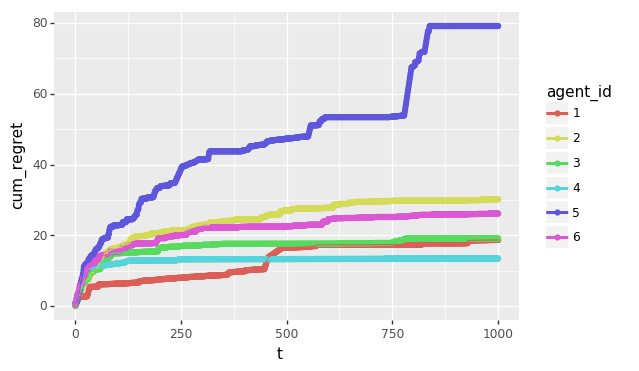

<ggplot: (8749461409601)>


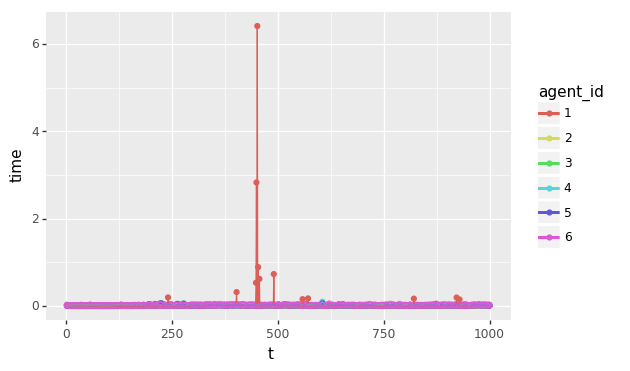

<ggplot: (8749498130329)>


([      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
  0             1        1     0.999443    0.012712        0.012712     1   
  1             2        2     0.999443    0.404515        0.404515     1   
  2             3        3     0.999443    0.010857        0.010857     1   
  3             4        4     0.999443    0.633194        0.633194     1   
  4             5        5     0.999443    0.961564        0.961564     1   
  5             6        6     0.999443    0.405310        0.405310     1   
  6             7        1     1.998886    0.917449        0.904737     2   
  7             8        2     1.998886    0.920033        0.515518     2   
  8             9        3     1.998886    0.199413        0.188556     2   
  9            10        4     1.998886    0.839674        0.206480     2   
  10           11        5     1.998886    0.981889        0.020325     2   
  11           12        6     1.998886    1.040203        0.634893     2   

In [9]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
agents = [make_laplace_agent(),
               make_pgts_agent(),
               make_best_langevin_agent(),
               make_mala_agent(),
               make_best_sgld_agent(),
               make_best_sagald_agent()]
                #,make_mala_agent_untimed]
#simple_compares(make_agents, num_articles, dim, var, 1000, [1], verbosity=verbosity)
#simple_compares(make_agents, num_articles, dim, var, 1000, range(100,105), verbosity=verbosity)
simple_compare(agents, num_articles, dim, var, 1000, seed=1, verbosity=0)

In [12]:
from algorithms.langevin import *
npla.eig(logistic_Hessian(agents[5].theta, agents[5].contexts))

#now very ill-conditioned!

(array([81.06570546, 62.75259306, 41.45249985, 37.50651228, 33.69825597,
        27.27352328, 25.18206507, 21.22030345, 17.377625  , 12.40144668,
         9.92572675,  9.45042464,  6.74971701,  0.80201459,  1.2072618 ,
         1.64473491,  5.42479957,  4.88400833,  2.87905892,  3.46700124]),
 array([[-2.20212837e-01, -1.57502104e-01,  3.49076682e-01,
          1.90571264e-01, -4.58722508e-01,  1.35459776e-02,
          2.76332242e-01, -3.38314438e-01,  1.10923236e-02,
          6.19475502e-02, -5.43926030e-02,  1.17637796e-01,
          1.60643538e-01,  4.55208745e-02, -1.41995497e-01,
         -2.86497923e-01,  1.65748280e-01, -2.10316069e-01,
         -3.21981901e-01,  2.02098366e-01],
        [ 2.22888532e-02,  1.64230481e-01, -5.22278014e-01,
          3.39098663e-02,  2.26284812e-01, -2.06948114e-01,
          3.66725542e-03, -8.97078047e-03,  1.34576167e-01,
         -1.38613369e-01,  9.35127602e-02,  1.85124815e-01,
          5.22118244e-01,  2.57052182e-01,  5.48096259e-02,
  